In [1]:
# Parameters
var_list = ["default1", "default2"]
plevel_list = [False, 300]
aew_subset = "default_subset"
model_save_name = "default_model.keras"
tuner_project_name = "default_tuner_run"






In [1]:
# Parameters
var_list = ["crr", "ie", "t", "t", "u", "vo"]
plevel_list = [False, False, 300, 900, 300, 300]
aew_subset = "12hr_before"
model_save_name = "best_model_var5.keras"
tuner_project_name = "tuner_run(second)1_1"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner

import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-03-05 16:06:04.145530: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 16:06:04.163519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741215964.182507    7471 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741215964.188470    7471 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 16:06:04.209053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [4]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [5]:
def add_dim(ds):

    """

    Preprocessing help when opening netcdf files

    """

    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars('utc_date')



In [6]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [7]:
def transpose_load_concat(data_dictionary):

   """

   Eagerly load the training labels and data, reshaping data to (samples, y, x, features).

   """

   thedatas = {}


   for key, value in data_dictionary.items():


       if '_' not in key:


          thedatas[key] = value[key.upper()].expand_dims('features').transpose(

                           'sample', 'latitude', 'longitude', 'features').values


       if '_' in key:


          thedatas[key] = value[key.split('_')[0].upper()].expand_dims('features').transpose(

                          'sample', 'latitude', 'longitude', 'features').values


       label = value['label'].values


   if len(data_dictionary) > 1:

       data = np.concatenate(list(thedatas.values()), axis=3)
   if len(data_dictionary) == 1:

       data = np.squeeze(np.asarray(list(thedatas.values())), axis=0)
   return data, label

In [8]:
def omit_nans(data, label):

   """

   Remove any ``nans`` from the data.

   Args:

   data (numpy array): Training data.

   label (numpy array): Labels for supervised learning.

   Returns:

   data (numpy array): Training data with ``nans`` removed.

   label (numpy array): Corresponding labels of data.
 
   """

   maskarray = np.full(data.shape[0], True)

   masker = np.unique(np.argwhere(np.isnan(data))[:, 0])

   maskarray[masker] = False

   traindata = data[maskarray, :, :, :]

   trainlabel = label[maskarray]

   return traindata, trainlabel

In [9]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [10]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [11]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [12]:
def pick_loss(loss_string):

   """

   Help selecting the activation functions

   """

   lossdict = {

           "relu": keras.activations.relu,

           "tanh": keras.activations.tanh,

           "selu": keras.activations.selu,

           "sigmoid": keras.activations.sigmoid,

           "relu6": keras.activations.relu6,

           "silu": keras.activations.silu,

           "gelu": keras.activations.gelu,

           "lrelu": keras.activations.leaky_relu,

   }

   return lossdict[loss_string]

In [13]:
number_of_features = len(var_list)

In [14]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/project/zarr"
)




Loading crr from Zarr store.
Loading ie from Zarr store.
Loading t_300 from Zarr store.
Loading t_900 from Zarr store.
Loading u_300 from Zarr store.
Loading vo_300 from Zarr store.


Loading t_900 from Zarr store.
Loading u_300 from Zarr store.
Loading vo_300 from Zarr store.


In [15]:
# transpose the data and concat variables

data_, labels_ = transpose_load_concat(data)

print (np.shape(data_))

(2750, 32, 32, 6)


In [16]:
# check / remove nans

data_, labels_ = omit_nans(data_, labels_)

In [17]:
#split train and test sets

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(

data_, labels_, test_size=0.2, random_state=42)


print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 6) (550, 32, 32, 6) (2200,) (550,)


In [18]:
# now rescale using sklearn object

# create our scaler object

# scaler_input = sklearn.preprocessing.MinMaxScaler()

#Zscore scaling

scaler_input = sklearn.preprocessing.StandardScaler()


# now fit and transform our input data and labels

# training data

# inputs

X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

input_train_scaled = scaler_input.fit_transform(X_train_tmp)

input_train_scaled = np.reshape(input_train_scaled, X_train.shape)

# labels

label_train_scaled = y_train


# testing data

# inputs

X_test_tmp = np.reshape(X_test, (-1, len(var_list)))

input_test_scaled = scaler_input.fit_transform(X_test_tmp)

input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# labels

label_test_scaled = y_test

In [19]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 6) (2200, 1) (550, 32, 32, 6) (550, 1)


In [20]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [21]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [22]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-03-05 16:06:46.264088: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [23]:
# Build CNN using keras-tuner

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        # start building model
        model = keras.Sequential()

        # input
        model.add(keras.Input(shape=(32, 32, number_of_features)))  # 32x32 images

        # data augmentation layers
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # things to tune
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float("lr", min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice(
            "activation",
            ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"]
        )

        # hidden layers
        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        # Now that we have 4x4 feature maps, now apply global max pooling.
        model.add(layers.GlobalMaxPooling2D())

        # Finally, we add last fully connected (dense) layers
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=f1_loss_sigmoid,
            metrics=METRICS
        )
        return model


In [24]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [25]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_mean_squared_error", direction="min"),
    max_trials=100,
    project_name=tuner_project_name,    # Use the passed parameter
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [26]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 100 Complete [00h 01m 19s]
val_mean_squared_error: 0.0812765434384346

Best val_mean_squared_error So Far: 0.043954506516456604
Total elapsed time: 02h 36m 54s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 6)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 13)     │           715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 43)     │         5,074 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 43)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 43)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 115)      │        44,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 115)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 115)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 115)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │         3,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,037 (211.08 KB)

 Trainable params: 54,037 (211.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - auc: 0.6893 - binary_accuracy: 0.4040 - cross entropy: 1.6708 - f1_score: 0.1991 - fn: 14.5079 - fp: 733.0952 - loss: 0.1321 - mean_squared_error: 0.4135 - prc: 0.1418 - precision: 0.1130 - recall: 0.8536 - root_mean_squared_error: 0.6398 - tn: 397.8889 - tp: 97.8730 - val_auc: 0.7789 - val_binary_accuracy: 0.5227 - val_cross entropy: 2.1670 - val_f1_score: 0.1732 - val_fn: 2.0000 - val_fp: 103.0000 - val_loss: 0.8322 - val_mean_squared_error: 0.3978 - val_prc: 0.1447 - val_precision: 0.0965 - val_recall: 0.8462 - val_root_mean_squared_error: 0.6308 - val_tn: 104.0000 - val_tp: 11.0000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7356 - binary_accuracy: 0.6142 - cross entropy: 2.4891 - f1_score: 0.2691 - fn: 27.9206 - fp: 328.1905 - loss: 0.1183 - mean_squared_error: 0.3302 - prc: 0.1823 - precision: 0.1658 - recall: 0.7581 - root_mean_squared_error: 0.5721 - tn: 595.7936 - tp: 71.4603 - val_auc: 0.8190 - val_bi

 1/62 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step - auc: 0.7602 - binary_accuracy: 0.7778 - cross entropy: 0.4685 - f1_score: 0.2222 - fn: 7.0000 - fp: 49.0000 - loss: 0.1276 - mean_squared_error: 0.1388 - prc: 0.2305 - precision: 0.1404 - recall: 0.5333 - root_mean_squared_error: 0.3726 - tn: 188.0000 - tp: 8.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7285 - binary_accuracy: 0.6728 - cross entropy: 0.6261 - f1_score: 0.1879 - fn: 7.0000 - fp: 93.7500 - loss: 0.1263 - mean_squared_error: 0.1923 - prc: 0.1742 - precision: 0.1122 - recall: 0.6073 - root_mean_squared_error: 0.4363 - tn: 188.0000 - tp: 11.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7072 - binary_accuracy: 0.5812 - cross entropy: 0.8613 - f1_score: 0.1722 - fn: 7.0000 - fp: 153.2500 - loss: 0.1265 - mean_squared_error: 0.2543 - prc: 0.1445 - precision: 0.0999 - recall: 0.6744 - root_mean_squared_error: 0.4991 - tn: 188.0000 - tp: 15.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.7031 - binary_accuracy: 0.5215 - cross entropy: 1.0439 - f1_score: 0.1713 - fn: 7.0000 - fp: 210.8333 - loss: 0.1283 - mean_squared_error: 0.2985 - prc: 0.1406 - precision: 0.0981 - recall: 0.7252 - root_mean_squared_error: 0.5400 - tn: 188.2500 - tp: 21.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.6969 - binary_accuracy: 0.4782 - cross entropy: 1.2052 - f1_score: 0.1720 - fn: 7.0000 - fp: 267.8750 - loss: 0.1297 - mean_squared_error: 0.3341 - prc: 0.1372 - precision: 0.0977 - recall: 0.7614 - root_mean_squared_error: 0.5710 - tn: 188.9375 - tp: 28.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.6931 - binary_accuracy: 0.4460 - cross entropy: 1.3380 - f1_score: 0.1733 - fn: 7.0000 - fp: 323.8500 - loss: 0.1307 - mean_squared_error: 0.3608 - prc: 0.1352 - precision: 0.0980 - recall: 0.7882 - root_mean_squared_error: 0.5935 - tn: 190.5500 - tp: 34.6000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.6908 - binary_accuracy: 0.4223 - cross entropy: 1.4489 - f1_score: 0.1760 - fn: 7.0000 - fp: 377.7917 - loss: 0.1315 - mean_squared_error: 0.3814 - prc: 0.1351 - precision: 0.0993 - recall: 0.8095 - root_mean_squared_error: 0.6106 - tn: 193.5833 - tp: 41.6250

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.6899 - binary_accuracy: 0.4060 - cross entropy: 1.5319 - f1_score: 0.1796 - fn: 7.0000 - fp: 428.3571 - loss: 0.1323 - mean_squared_error: 0.3966 - prc: 0.1361 - precision: 0.1012 - recall: 0.8267 - root_mean_squared_error: 0.6232 - tn: 199.6786 - tp: 48.9643

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6897 - binary_accuracy: 0.3935 - cross entropy: 1.6005 - f1_score: 0.1831 - fn: 7.1212 - fp: 486.3940 - loss: 0.1327 - mean_squared_error: 0.4093 - prc: 0.1369 - precision: 0.1031 - recall: 0.8424 - root_mean_squared_error: 0.6338 - tn: 213.1818 - tp: 57.3030

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6894 - binary_accuracy: 0.3899 - cross entropy: 1.6269 - f1_score: 0.1853 - fn: 7.7568 - fp: 526.2432 - loss: 0.1329 - mean_squared_error: 0.4140 - prc: 0.1375 - precision: 0.1044 - recall: 0.8482 - root_mean_squared_error: 0.6380 - tn: 230.8649 - tp: 63.1351

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6897 - binary_accuracy: 0.3896 - cross entropy: 1.6387 - f1_score: 0.1880 - fn: 8.5122 - fp: 562.0975 - loss: 0.1328 - mean_squared_error: 0.4157 - prc: 0.1386 - precision: 0.1060 - recall: 0.8521 - root_mean_squared_error: 0.6398 - tn: 252.4146 - tp: 68.9756

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6897 - binary_accuracy: 0.3912 - cross entropy: 1.6428 - f1_score: 0.1911 - fn: 9.4222 - fp: 595.4222 - loss: 0.1328 - mean_squared_error: 0.4161 - prc: 0.1397 - precision: 0.1079 - recall: 0.8546 - root_mean_squared_error: 0.6406 - tn: 276.1111 - tp: 75.0444

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6897 - binary_accuracy: 0.3937 - cross entropy: 1.6440 - f1_score: 0.1936 - fn: 10.4694 - fp: 627.0204 - loss: 0.1327 - mean_squared_error: 0.4156 - prc: 0.1405 - precision: 0.1095 - recall: 0.8554 - root_mean_squared_error: 0.6406 - tn: 301.9592 - tp: 80.5510

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6896 - binary_accuracy: 0.3974 - cross entropy: 1.6494 - f1_score: 0.1959 - fn: 11.9074 - fp: 665.3704 - loss: 0.1325 - mean_squared_error: 0.4149 - prc: 0.1411 - precision: 0.1110 - recall: 0.8551 - root_mean_squared_error: 0.6404 - tn: 335.7778 - tp: 86.9444

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6897 - binary_accuracy: 0.4004 - cross entropy: 1.6575 - f1_score: 0.1975 - fn: 12.9828 - fp: 695.8104 - loss: 0.1323 - mean_squared_error: 0.4142 - prc: 0.1415 - precision: 0.1120 - recall: 0.8549 - root_mean_squared_error: 0.6401 - tn: 363.2931 - tp: 91.9138

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6893 - binary_accuracy: 0.4033 - cross entropy: 1.6680 - f1_score: 0.1988 - fn: 14.2097 - fp: 725.8710 - loss: 0.1322 - mean_squared_error: 0.4136 - prc: 0.1416 - precision: 0.1128 - recall: 0.8538 - root_mean_squared_error: 0.6399 - tn: 391.1613 - tp: 96.6936

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - auc: 0.6893 - binary_accuracy: 0.4040 - cross entropy: 1.6708 - f1_score: 0.1991 - fn: 14.5079 - fp: 733.0952 - loss: 0.1321 - mean_squared_error: 0.4135 - prc: 0.1418 - precision: 0.1130 - recall: 0.8536 - root_mean_squared_error: 0.6398 - tn: 397.8889 - tp: 97.8730 - val_auc: 0.7789 - val_binary_accuracy: 0.5227 - val_cross entropy: 2.1670 - val_f1_score: 0.1732 - val_fn: 2.0000 - val_fp: 103.0000 - val_loss: 0.8322 - val_mean_squared_error: 0.3978 - val_prc: 0.1447 - val_precision: 0.0965 - val_recall: 0.8462 - val_root_mean_squared_error: 0.6308 - val_tn: 104.0000 - val_tp: 11.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.7250 - binary_accuracy: 0.5000 - cross entropy: 3.7867 - f1_score: 0.2000 - fn: 0.0000e+00 - fp: 16.0000 - loss: 0.1165 - mean_squared_error: 0.4415 - prc: 0.1054 - precision: 0.1111 - recall: 1.0000 - root_mean_squared_error: 0.6645 - tn: 14.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7535 - binary_accuracy: 0.5297 - cross entropy: 3.3537 - f1_score: 0.1894 - fn: 1.2000 - fp: 43.4000 - loss: 0.1145 - mean_squared_error: 0.4123 - prc: 0.1315 - precision: 0.1070 - recall: 0.8636 - root_mean_squared_error: 0.6419 - tn: 46.2000 - tp: 5.2000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7507 - binary_accuracy: 0.5275 - cross entropy: 3.2658 - f1_score: 0.1919 - fn: 2.0000 - fp: 73.4444 - loss: 0.1154 - mean_squared_error: 0.4085 - prc: 0.1381 - precision: 0.1086 - recall: 0.8462 - root_mean_squared_error: 0.6390 - tn: 75.5556 - tp: 9.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7432 - binary_accuracy: 0.5328 - cross entropy: 3.1719 - f1_score: 0.2055 - fn: 3.3846 - fp: 100.3846 - loss: 0.1174 - mean_squared_error: 0.4028 - prc: 0.1483 - precision: 0.1178 - recall: 0.8327 - root_mean_squared_error: 0.6345 - tn: 106.0000 - tp: 14.2308

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7389 - binary_accuracy: 0.5356 - cross entropy: 3.1348 - f1_score: 0.2128 - fn: 4.6471 - fp: 127.8235 - loss: 0.1185 - mean_squared_error: 0.4002 - prc: 0.1530 - precision: 0.1227 - recall: 0.8250 - root_mean_squared_error: 0.6325 - tn: 136.4118 - tp: 19.1176

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7374 - binary_accuracy: 0.5385 - cross entropy: 3.1171 - f1_score: 0.2202 - fn: 5.6667 - fp: 154.9524 - loss: 0.1192 - mean_squared_error: 0.3978 - prc: 0.1574 - precision: 0.1277 - recall: 0.8249 - root_mean_squared_error: 0.6306 - tn: 166.9048 - tp: 24.4762

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7357 - binary_accuracy: 0.5419 - cross entropy: 3.0972 - f1_score: 0.2287 - fn: 7.0000 - fp: 180.8800 - loss: 0.1198 - mean_squared_error: 0.3948 - prc: 0.1625 - precision: 0.1335 - recall: 0.8236 - root_mean_squared_error: 0.6282 - tn: 197.6000 - tp: 30.5200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7351 - binary_accuracy: 0.5470 - cross entropy: 3.0550 - f1_score: 0.2361 - fn: 8.3448 - fp: 204.6897 - loss: 0.1201 - mean_squared_error: 0.3904 - prc: 0.1667 - precision: 0.1387 - recall: 0.8222 - root_mean_squared_error: 0.6246 - tn: 230.5862 - tp: 36.3793

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7347 - binary_accuracy: 0.5537 - cross entropy: 2.9954 - f1_score: 0.2418 - fn: 9.8788 - fp: 225.8788 - loss: 0.1201 - mean_squared_error: 0.3844 - prc: 0.1695 - precision: 0.1427 - recall: 0.8183 - root_mean_squared_error: 0.6197 - tn: 266.6970 - tp: 41.5455

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7346 - binary_accuracy: 0.5623 - cross entropy: 2.9227 - f1_score: 0.2467 - fn: 11.7838 - fp: 243.5676 - loss: 0.1199 - mean_squared_error: 0.3767 - prc: 0.1717 - precision: 0.1464 - recall: 0.8113 - root_mean_squared_error: 0.6132 - tn: 306.5405 - tp: 46.1081

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7348 - binary_accuracy: 0.5713 - cross entropy: 2.8462 - f1_score: 0.2514 - fn: 13.9512 - fp: 259.0000 - loss: 0.1196 - mean_squared_error: 0.3686 - prc: 0.1739 - precision: 0.1502 - recall: 0.8033 - root_mean_squared_error: 0.6063 - tn: 348.5122 - tp: 50.5366

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7350 - binary_accuracy: 0.5804 - cross entropy: 2.7701 - f1_score: 0.2563 - fn: 16.5111 - fp: 272.6222 - loss: 0.1193 - mean_squared_error: 0.3605 - prc: 0.1762 - precision: 0.1543 - recall: 0.7942 - root_mean_squared_error: 0.5992 - tn: 391.9111 - tp: 54.9556

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7354 - binary_accuracy: 0.5891 - cross entropy: 2.6965 - f1_score: 0.2602 - fn: 19.0816 - fp: 285.1633 - loss: 0.1189 - mean_squared_error: 0.3526 - prc: 0.1779 - precision: 0.1577 - recall: 0.7852 - root_mean_squared_error: 0.5922 - tn: 436.8163 - tp: 58.9388

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7356 - binary_accuracy: 0.5970 - cross entropy: 2.6302 - f1_score: 0.2633 - fn: 21.6226 - fp: 297.7736 - loss: 0.1187 - mean_squared_error: 0.3455 - prc: 0.1794 - precision: 0.1604 - recall: 0.7768 - root_mean_squared_error: 0.5859 - tn: 481.8868 - tp: 62.7170

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7361 - binary_accuracy: 0.6042 - cross entropy: 2.5691 - f1_score: 0.2661 - fn: 23.9474 - fp: 310.5614 - loss: 0.1184 - mean_squared_error: 0.3391 - prc: 0.1808 - precision: 0.1628 - recall: 0.7700 - root_mean_squared_error: 0.5801 - tn: 527.0351 - tp: 66.4561

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7360 - binary_accuracy: 0.6109 - cross entropy: 2.5143 - f1_score: 0.2682 - fn: 26.4754 - fp: 322.6557 - loss: 0.1183 - mean_squared_error: 0.3331 - prc: 0.1819 - precision: 0.1649 - recall: 0.7625 - root_mean_squared_error: 0.5747 - tn: 572.9672 - tp: 69.9016

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.7356 - binary_accuracy: 0.6142 - cross entropy: 2.4891 - f1_score: 0.2691 - fn: 27.9206 - fp: 328.1905 - loss: 0.1183 - mean_squared_error: 0.3302 - prc: 0.1823 - precision: 0.1658 - recall: 0.7581 - root_mean_squared_error: 0.5721 - tn: 595.7936 - tp: 71.4603 - val_auc: 0.8190 - val_binary_accuracy: 0.7818 - val_cross entropy: 0.6067 - val_f1_score: 0.2727 - val_fn: 4.0000 - val_fp: 44.0000 - val_loss: 0.7449 - val_mean_squared_error: 0.1476 - val_prc: 0.2306 - val_precision: 0.1698 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3842 - val_tn: 163.0000 - val_tp: 9.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8167 - binary_accuracy: 0.8125 - cross entropy: 0.3801 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 4.0000 - loss: 0.1208 - mean_squared_error: 0.1226 - prc: 0.1415 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3502 - tn: 26.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8097 - binary_accuracy: 0.7883 - cross entropy: 0.9942 - f1_score: 0.2018 - fn: 3.5000 - fp: 21.5000 - loss: 0.1098 - mean_squared_error: 0.1761 - prc: 0.2185 - precision: 0.1324 - recall: 0.4354 - root_mean_squared_error: 0.4173 - tn: 82.8333 - tp: 4.1667               

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7966 - binary_accuracy: 0.7608 - cross entropy: 1.3021 - f1_score: 0.2177 - fn: 5.0000 - fp: 40.6000 - loss: 0.1106 - mean_squared_error: 0.2083 - prc: 0.2127 - precision: 0.1393 - recall: 0.5127 - root_mean_squared_error: 0.4530 - tn: 123.0000 - tp: 7.4000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7779 - binary_accuracy: 0.7343 - cross entropy: 1.7384 - f1_score: 0.2343 - fn: 7.6000 - fp: 67.2000 - loss: 0.1136 - mean_squared_error: 0.2378 - prc: 0.2068 - precision: 0.1490 - recall: 0.5593 - root_mean_squared_error: 0.4836 - tn: 168.2000 - tp: 13.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7698 - binary_accuracy: 0.7161 - cross entropy: 2.1251 - f1_score: 0.2440 - fn: 9.6500 - fp: 95.2000 - loss: 0.1150 - mean_squared_error: 0.2577 - prc: 0.2028 - precision: 0.1542 - recall: 0.5938 - root_mean_squared_error: 0.5036 - tn: 212.2000 - tp: 18.9500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7650 - binary_accuracy: 0.7019 - cross entropy: 2.4825 - f1_score: 0.2535 - fn: 11.5600 - fp: 124.6000 - loss: 0.1160 - mean_squared_error: 0.2728 - prc: 0.2028 - precision: 0.1597 - recall: 0.6225 - root_mean_squared_error: 0.5183 - tn: 253.8800 - tp: 25.9600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7626 - binary_accuracy: 0.6919 - cross entropy: 2.7614 - f1_score: 0.2617 - fn: 13.2333 - fp: 153.7333 - loss: 0.1166 - mean_squared_error: 0.2835 - prc: 0.2040 - precision: 0.1645 - recall: 0.6459 - root_mean_squared_error: 0.5286 - tn: 295.8000 - tp: 33.2333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7614 - binary_accuracy: 0.6843 - cross entropy: 2.9920 - f1_score: 0.2669 - fn: 14.6000 - fp: 183.0000 - loss: 0.1169 - mean_squared_error: 0.2915 - prc: 0.2043 - precision: 0.1674 - recall: 0.6651 - root_mean_squared_error: 0.5364 - tn: 338.3429 - tp: 40.0571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7620 - binary_accuracy: 0.6794 - cross entropy: 3.1562 - f1_score: 0.2720 - fn: 15.7250 - fp: 211.1250 - loss: 0.1169 - mean_squared_error: 0.2968 - prc: 0.2057 - precision: 0.1702 - recall: 0.6823 - root_mean_squared_error: 0.5415 - tn: 382.1000 - tp: 47.0500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7629 - binary_accuracy: 0.6761 - cross entropy: 3.2727 - f1_score: 0.2775 - fn: 16.9778 - fp: 238.1333 - loss: 0.1169 - mean_squared_error: 0.3003 - prc: 0.2080 - precision: 0.1736 - recall: 0.6963 - root_mean_squared_error: 0.5450 - tn: 426.4000 - tp: 54.4889

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7639 - binary_accuracy: 0.6750 - cross entropy: 3.3427 - f1_score: 0.2820 - fn: 18.3200 - fp: 262.6800 - loss: 0.1168 - mean_squared_error: 0.3017 - prc: 0.2098 - precision: 0.1764 - recall: 0.7068 - root_mean_squared_error: 0.5466 - tn: 473.7200 - tp: 61.2800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7637 - binary_accuracy: 0.6755 - cross entropy: 3.3824 - f1_score: 0.2854 - fn: 20.0727 - fp: 284.7636 - loss: 0.1166 - mean_squared_error: 0.3015 - prc: 0.2105 - precision: 0.1787 - recall: 0.7127 - root_mean_squared_error: 0.5467 - tn: 523.8727 - tp: 67.2909

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7626 - binary_accuracy: 0.6770 - cross entropy: 3.3998 - f1_score: 0.2879 - fn: 22.2500 - fp: 304.5000 - loss: 0.1166 - mean_squared_error: 0.3003 - prc: 0.2108 - precision: 0.1805 - recall: 0.7150 - root_mean_squared_error: 0.5457 - tn: 576.6500 - tp: 72.6000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7615 - binary_accuracy: 0.6782 - cross entropy: 3.4042 - f1_score: 0.2892 - fn: 23.8254 - fp: 315.3175 - loss: 0.1167 - mean_squared_error: 0.2993 - prc: 0.2107 - precision: 0.1816 - recall: 0.7147 - root_mean_squared_error: 0.5449 - tn: 608.6667 - tp: 75.5556 - val_auc: 0.7070 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.8861 - val_f1_score: 0.2857 - val_fn: 7.0000 - val_fp: 23.0000 - val_loss: 0.7591 - val_mean_squared_error: 0.1211 - val_prc: 0.1485 - val_precision: 0.2069 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3480 - val_tn: 184.0000 - val_tp: 6.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8000 - binary_accuracy: 0.7500 - cross entropy: 1.0308 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 6.0000 - loss: 0.1277 - mean_squared_error: 0.1990 - prc: 0.1370 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.4461 - tn: 24.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7813 - binary_accuracy: 0.7937 - cross entropy: 1.4355 - f1_score: 0.1903 - fn: 4.1667 - fp: 18.3333 - loss: 0.1102 - mean_squared_error: 0.1784 - prc: 0.1629 - precision: 0.1299 - recall: 0.3667 - root_mean_squared_error: 0.4221 - tn: 86.0000 - tp: 3.5000               

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7607 - binary_accuracy: 0.7949 - cross entropy: 1.7471 - f1_score: 0.2335 - fn: 6.8182 - fp: 32.2727 - loss: 0.1097 - mean_squared_error: 0.1836 - prc: 0.1703 - precision: 0.1586 - recall: 0.4495 - root_mean_squared_error: 0.4282 - tn: 145.6364 - tp: 7.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7456 - binary_accuracy: 0.7865 - cross entropy: 2.0019 - f1_score: 0.2543 - fn: 10.2500 - fp: 49.1250 - loss: 0.1117 - mean_squared_error: 0.1940 - prc: 0.1784 - precision: 0.1733 - recall: 0.4826 - root_mean_squared_error: 0.4399 - tn: 200.6875 - tp: 11.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7403 - binary_accuracy: 0.7830 - cross entropy: 2.1494 - f1_score: 0.2693 - fn: 13.3333 - fp: 64.9524 - loss: 0.1123 - mean_squared_error: 0.1991 - prc: 0.1849 - precision: 0.1840 - recall: 0.5059 - root_mean_squared_error: 0.4456 - tn: 256.9048 - tp: 16.8095

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7384 - binary_accuracy: 0.7809 - cross entropy: 2.2457 - f1_score: 0.2841 - fn: 16.8846 - fp: 79.9615 - loss: 0.1127 - mean_squared_error: 0.2020 - prc: 0.1938 - precision: 0.1957 - recall: 0.5229 - root_mean_squared_error: 0.4489 - tn: 312.6538 - tp: 22.5000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7381 - binary_accuracy: 0.7797 - cross entropy: 2.2961 - f1_score: 0.2950 - fn: 20.0968 - fp: 95.0323 - loss: 0.1127 - mean_squared_error: 0.2038 - prc: 0.2000 - precision: 0.2040 - recall: 0.5365 - root_mean_squared_error: 0.4510 - tn: 368.8065 - tp: 28.0645

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7385 - binary_accuracy: 0.7789 - cross entropy: 2.3286 - f1_score: 0.3014 - fn: 22.2571 - fp: 107.5429 - loss: 0.1125 - mean_squared_error: 0.2049 - prc: 0.2034 - precision: 0.2086 - recall: 0.5470 - root_mean_squared_error: 0.4523 - tn: 413.8000 - tp: 32.4000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7396 - binary_accuracy: 0.7783 - cross entropy: 2.3493 - f1_score: 0.3073 - fn: 24.1795 - fp: 120.2564 - loss: 0.1122 - mean_squared_error: 0.2059 - prc: 0.2068 - precision: 0.2126 - recall: 0.5576 - root_mean_squared_error: 0.4534 - tn: 458.6667 - tp: 36.8974

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7421 - binary_accuracy: 0.7773 - cross entropy: 2.3637 - f1_score: 0.3150 - fn: 26.4545 - fp: 136.7727 - loss: 0.1119 - mean_squared_error: 0.2072 - prc: 0.2122 - precision: 0.2179 - recall: 0.5712 - root_mean_squared_error: 0.4549 - tn: 513.5227 - tp: 43.2500

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7441 - binary_accuracy: 0.7765 - cross entropy: 2.3695 - f1_score: 0.3206 - fn: 28.7755 - fp: 153.2245 - loss: 0.1117 - mean_squared_error: 0.2082 - prc: 0.2161 - precision: 0.2216 - recall: 0.5817 - root_mean_squared_error: 0.4560 - tn: 568.7551 - tp: 49.2449

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7450 - binary_accuracy: 0.7761 - cross entropy: 2.3709 - f1_score: 0.3238 - fn: 30.6792 - fp: 166.0755 - loss: 0.1115 - mean_squared_error: 0.2087 - prc: 0.2182 - precision: 0.2238 - recall: 0.5881 - root_mean_squared_error: 0.4566 - tn: 613.5849 - tp: 53.6604

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7460 - binary_accuracy: 0.7760 - cross entropy: 2.3655 - f1_score: 0.3266 - fn: 32.5088 - fp: 178.4035 - loss: 0.1114 - mean_squared_error: 0.2088 - prc: 0.2200 - precision: 0.2256 - recall: 0.5937 - root_mean_squared_error: 0.4567 - tn: 659.1930 - tp: 57.8947

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7464 - binary_accuracy: 0.7765 - cross entropy: 2.3593 - f1_score: 0.3290 - fn: 34.5738 - fp: 189.6230 - loss: 0.1113 - mean_squared_error: 0.2084 - prc: 0.2214 - precision: 0.2273 - recall: 0.5972 - root_mean_squared_error: 0.4563 - tn: 706.0000 - tp: 61.8033

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7464 - binary_accuracy: 0.7768 - cross entropy: 2.3567 - f1_score: 0.3301 - fn: 35.6984 - fp: 194.7778 - loss: 0.1112 - mean_squared_error: 0.2081 - prc: 0.2220 - precision: 0.2282 - recall: 0.5984 - root_mean_squared_error: 0.4560 - tn: 729.2064 - tp: 63.6825 - val_auc: 0.6960 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.4840 - val_f1_score: 0.3030 - val_fn: 8.0000 - val_fp: 15.0000 - val_loss: 0.7402 - val_mean_squared_error: 0.0825 - val_prc: 0.2292 - val_precision: 0.2500 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2872 - val_tn: 192.0000 - val_tp: 5.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.3463 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0897 - mean_squared_error: 0.0581 - prc: 0.3657 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2411 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8740 - binary_accuracy: 0.9227 - cross entropy: 0.5929 - f1_score: 0.5049 - fn: 3.0000 - fp: 6.0000 - loss: 0.0820 - mean_squared_error: 0.0697 - prc: 0.3639 - precision: 0.4411 - recall: 0.6041 - root_mean_squared_error: 0.2637 - tn: 98.3333 - tp: 4.6667

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8430 - binary_accuracy: 0.9088 - cross entropy: 0.7177 - f1_score: 0.4664 - fn: 5.4000 - fp: 12.3000 - loss: 0.0848 - mean_squared_error: 0.0779 - prc: 0.3578 - precision: 0.3956 - recall: 0.5798 - root_mean_squared_error: 0.2782 - tn: 151.3000 - tp: 7.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8120 - binary_accuracy: 0.8860 - cross entropy: 0.9157 - f1_score: 0.4368 - fn: 9.2000 - fp: 24.8667 - loss: 0.0901 - mean_squared_error: 0.0977 - prc: 0.3399 - precision: 0.3605 - recall: 0.5677 - root_mean_squared_error: 0.3089 - tn: 210.5333 - tp: 11.4000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7963 - binary_accuracy: 0.8726 - cross entropy: 1.0497 - f1_score: 0.4224 - fn: 12.6500 - fp: 37.0000 - loss: 0.0930 - mean_squared_error: 0.1100 - prc: 0.3275 - precision: 0.3419 - recall: 0.5661 - root_mean_squared_error: 0.3275 - tn: 270.4000 - tp: 15.9500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7874 - binary_accuracy: 0.8647 - cross entropy: 1.1402 - f1_score: 0.4160 - fn: 16.8800 - fp: 47.4000 - loss: 0.0954 - mean_squared_error: 0.1173 - prc: 0.3206 - precision: 0.3348 - recall: 0.5607 - root_mean_squared_error: 0.3386 - tn: 331.0800 - tp: 20.6400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7823 - binary_accuracy: 0.8593 - cross entropy: 1.2053 - f1_score: 0.4138 - fn: 20.8000 - fp: 57.8333 - loss: 0.0968 - mean_squared_error: 0.1224 - prc: 0.3172 - precision: 0.3317 - recall: 0.5600 - root_mean_squared_error: 0.3462 - tn: 391.7000 - tp: 25.6667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7798 - binary_accuracy: 0.8556 - cross entropy: 1.2566 - f1_score: 0.4123 - fn: 23.3529 - fp: 67.1471 - loss: 0.0975 - mean_squared_error: 0.1261 - prc: 0.3142 - precision: 0.3285 - recall: 0.5630 - root_mean_squared_error: 0.3516 - tn: 439.7941 - tp: 29.7059

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7786 - binary_accuracy: 0.8516 - cross entropy: 1.3087 - f1_score: 0.4112 - fn: 26.1795 - fp: 79.3333 - loss: 0.0980 - mean_squared_error: 0.1300 - prc: 0.3123 - precision: 0.3251 - recall: 0.5686 - root_mean_squared_error: 0.3572 - tn: 499.5898 - tp: 34.8974

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7794 - binary_accuracy: 0.8483 - cross entropy: 1.3452 - f1_score: 0.4128 - fn: 28.7500 - fp: 91.8182 - loss: 0.0983 - mean_squared_error: 0.1332 - prc: 0.3142 - precision: 0.3243 - recall: 0.5771 - root_mean_squared_error: 0.3618 - tn: 558.4773 - tp: 40.9545

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7795 - binary_accuracy: 0.8458 - cross entropy: 1.3701 - f1_score: 0.4137 - fn: 31.4082 - fp: 103.8980 - loss: 0.0985 - mean_squared_error: 0.1355 - prc: 0.3150 - precision: 0.3233 - recall: 0.5833 - root_mean_squared_error: 0.3653 - tn: 618.0816 - tp: 46.6122

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7789 - binary_accuracy: 0.8444 - cross entropy: 1.3904 - f1_score: 0.4138 - fn: 34.2963 - fp: 114.5741 - loss: 0.0988 - mean_squared_error: 0.1369 - prc: 0.3152 - precision: 0.3224 - recall: 0.5862 - root_mean_squared_error: 0.3673 - tn: 679.5741 - tp: 51.5556

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7784 - binary_accuracy: 0.8438 - cross entropy: 1.4032 - f1_score: 0.4137 - fn: 37.3220 - fp: 124.1017 - loss: 0.0990 - mean_squared_error: 0.1375 - prc: 0.3151 - precision: 0.3218 - recall: 0.5873 - root_mean_squared_error: 0.3684 - tn: 742.5424 - tp: 56.0339

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7771 - binary_accuracy: 0.8435 - cross entropy: 1.4155 - f1_score: 0.4131 - fn: 40.1587 - fp: 130.9682 - loss: 0.0994 - mean_squared_error: 0.1378 - prc: 0.3145 - precision: 0.3213 - recall: 0.5859 - root_mean_squared_error: 0.3689 - tn: 793.0159 - tp: 59.2222 - val_auc: 0.7546 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.5389 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.6939 - val_mean_squared_error: 0.0710 - val_prc: 0.2344 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2665 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.6917 - binary_accuracy: 0.8750 - cross entropy: 0.5457 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 2.0000 - loss: 0.1362 - mean_squared_error: 0.0798 - prc: 0.1442 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2826 - tn: 28.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8119 - binary_accuracy: 0.9062 - cross entropy: 0.4918 - f1_score: 0.3110 - fn: 4.6667 - fp: 5.1667 - loss: 0.0998 - mean_squared_error: 0.0718 - prc: 0.3757 - precision: 0.3012 - recall: 0.3277 - root_mean_squared_error: 0.2679 - tn: 99.1667 - tp: 3.0000                

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8041 - binary_accuracy: 0.9079 - cross entropy: 0.6461 - f1_score: 0.3572 - fn: 8.3636 - fp: 9.0909 - loss: 0.0943 - mean_squared_error: 0.0744 - prc: 0.3906 - precision: 0.3485 - recall: 0.3698 - root_mean_squared_error: 0.2721 - tn: 168.8182 - tp: 5.7273

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7928 - binary_accuracy: 0.8987 - cross entropy: 0.7930 - f1_score: 0.3661 - fn: 11.7333 - fp: 15.7333 - loss: 0.0948 - mean_squared_error: 0.0840 - prc: 0.3803 - precision: 0.3473 - recall: 0.3923 - root_mean_squared_error: 0.2882 - tn: 219.6667 - tp: 8.8667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7873 - binary_accuracy: 0.8909 - cross entropy: 0.9144 - f1_score: 0.3719 - fn: 14.6316 - fp: 23.3684 - loss: 0.0953 - mean_squared_error: 0.0919 - prc: 0.3692 - precision: 0.3429 - recall: 0.4142 - root_mean_squared_error: 0.3008 - tn: 269.6842 - tp: 12.3158

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7827 - binary_accuracy: 0.8824 - cross entropy: 1.0670 - f1_score: 0.3794 - fn: 18.2500 - fp: 33.8333 - loss: 0.0960 - mean_squared_error: 0.1010 - prc: 0.3583 - precision: 0.3404 - recall: 0.4388 - root_mean_squared_error: 0.3149 - tn: 330.5417 - tp: 17.3750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7810 - binary_accuracy: 0.8775 - cross entropy: 1.1570 - f1_score: 0.3872 - fn: 21.0357 - fp: 42.0000 - loss: 0.0963 - mean_squared_error: 0.1062 - prc: 0.3550 - precision: 0.3420 - recall: 0.4570 - root_mean_squared_error: 0.3229 - tn: 379.0357 - tp: 21.9286

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7801 - binary_accuracy: 0.8724 - cross entropy: 1.2427 - f1_score: 0.3927 - fn: 24.1818 - fp: 52.8182 - loss: 0.0965 - mean_squared_error: 0.1116 - prc: 0.3499 - precision: 0.3409 - recall: 0.4751 - root_mean_squared_error: 0.3310 - tn: 439.7576 - tp: 27.2424

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7809 - binary_accuracy: 0.8688 - cross entropy: 1.2993 - f1_score: 0.3982 - fn: 26.8158 - fp: 63.5263 - loss: 0.0964 - mean_squared_error: 0.1155 - prc: 0.3477 - precision: 0.3406 - recall: 0.4926 - root_mean_squared_error: 0.3368 - tn: 500.9737 - tp: 32.6842

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7828 - binary_accuracy: 0.8664 - cross entropy: 1.3362 - f1_score: 0.4050 - fn: 29.3256 - fp: 73.6279 - loss: 0.0961 - mean_squared_error: 0.1181 - prc: 0.3484 - precision: 0.3425 - recall: 0.5089 - root_mean_squared_error: 0.3409 - tn: 562.4418 - tp: 38.6047

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7845 - binary_accuracy: 0.8649 - cross entropy: 1.3605 - f1_score: 0.4112 - fn: 32.0208 - fp: 82.9375 - loss: 0.0958 - mean_squared_error: 0.1200 - prc: 0.3493 - precision: 0.3450 - recall: 0.5217 - root_mean_squared_error: 0.3438 - tn: 624.6042 - tp: 44.4375

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7852 - binary_accuracy: 0.8643 - cross entropy: 1.3793 - f1_score: 0.4159 - fn: 34.8113 - fp: 91.0189 - loss: 0.0956 - mean_squared_error: 0.1209 - prc: 0.3495 - precision: 0.3473 - recall: 0.5305 - root_mean_squared_error: 0.3453 - tn: 688.6415 - tp: 49.5283

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7856 - binary_accuracy: 0.8643 - cross entropy: 1.3926 - f1_score: 0.4196 - fn: 37.7069 - fp: 98.2586 - loss: 0.0955 - mean_squared_error: 0.1212 - prc: 0.3494 - precision: 0.3494 - recall: 0.5367 - root_mean_squared_error: 0.3461 - tn: 753.8448 - tp: 54.1897

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7847 - binary_accuracy: 0.8645 - cross entropy: 1.4100 - f1_score: 0.4221 - fn: 41.0317 - fp: 104.7302 - loss: 0.0957 - mean_squared_error: 0.1214 - prc: 0.3485 - precision: 0.3512 - recall: 0.5396 - root_mean_squared_error: 0.3465 - tn: 819.2540 - tp: 58.3492 - val_auc: 0.7282 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.6178 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 11.0000 - val_loss: 0.6631 - val_mean_squared_error: 0.0707 - val_prc: 0.2470 - val_precision: 0.3529 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2658 - val_tn: 196.0000 - val_tp: 6.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.2827 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 2.0000 - loss: 0.1203 - mean_squared_error: 0.0825 - prc: 0.2299 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2873 - tn: 28.0000 - tp: 0.0000e+00

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8718 - binary_accuracy: 0.8948 - cross entropy: 0.4960 - f1_score: 0.2739 - fn: 3.8000 - fp: 6.0000 - loss: 0.0944 - mean_squared_error: 0.0798 - prc: 0.4058 - precision: 0.2400 - recall: 0.3258 - root_mean_squared_error: 0.2823 - tn: 83.6000 - tp: 2.6000                

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8513 - binary_accuracy: 0.9009 - cross entropy: 0.6906 - f1_score: 0.3562 - fn: 5.4444 - fp: 9.7778 - loss: 0.0878 - mean_squared_error: 0.0780 - prc: 0.4053 - precision: 0.3070 - recall: 0.4282 - root_mean_squared_error: 0.2791 - tn: 139.2222 - tp: 5.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8184 - binary_accuracy: 0.8933 - cross entropy: 0.9325 - f1_score: 0.3817 - fn: 9.3571 - fp: 17.0714 - loss: 0.0897 - mean_squared_error: 0.0884 - prc: 0.3856 - precision: 0.3286 - recall: 0.4584 - root_mean_squared_error: 0.2961 - tn: 203.7857 - tp: 9.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8019 - binary_accuracy: 0.8892 - cross entropy: 1.0664 - f1_score: 0.3961 - fn: 12.9474 - fp: 24.0000 - loss: 0.0904 - mean_squared_error: 0.0943 - prc: 0.3718 - precision: 0.3400 - recall: 0.4769 - root_mean_squared_error: 0.3058 - tn: 269.0526 - tp: 14.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7931 - binary_accuracy: 0.8863 - cross entropy: 1.1807 - f1_score: 0.4078 - fn: 16.9583 - fp: 30.6250 - loss: 0.0912 - mean_squared_error: 0.0984 - prc: 0.3666 - precision: 0.3513 - recall: 0.4882 - root_mean_squared_error: 0.3124 - tn: 333.7500 - tp: 18.6667

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7878 - binary_accuracy: 0.8844 - cross entropy: 1.2532 - f1_score: 0.4139 - fn: 20.6429 - fp: 35.5714 - loss: 0.0920 - mean_squared_error: 0.1010 - prc: 0.3638 - precision: 0.3589 - recall: 0.4911 - root_mean_squared_error: 0.3166 - tn: 385.4643 - tp: 22.3214

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7834 - binary_accuracy: 0.8820 - cross entropy: 1.3241 - f1_score: 0.4192 - fn: 24.4545 - fp: 43.0000 - loss: 0.0927 - mean_squared_error: 0.1041 - prc: 0.3582 - precision: 0.3630 - recall: 0.4979 - root_mean_squared_error: 0.3213 - tn: 449.5757 - tp: 26.9697

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7812 - binary_accuracy: 0.8792 - cross entropy: 1.3831 - f1_score: 0.4228 - fn: 27.5789 - fp: 52.0526 - loss: 0.0930 - mean_squared_error: 0.1073 - prc: 0.3535 - precision: 0.3635 - recall: 0.5077 - root_mean_squared_error: 0.3262 - tn: 512.4474 - tp: 31.9211

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7809 - binary_accuracy: 0.8760 - cross entropy: 1.4346 - f1_score: 0.4262 - fn: 30.3953 - fp: 62.6047 - loss: 0.0933 - mean_squared_error: 0.1108 - prc: 0.3511 - precision: 0.3630 - recall: 0.5192 - root_mean_squared_error: 0.3314 - tn: 573.4651 - tp: 37.5349

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7812 - binary_accuracy: 0.8735 - cross entropy: 1.4718 - f1_score: 0.4289 - fn: 32.4681 - fp: 71.6596 - loss: 0.0936 - mean_squared_error: 0.1135 - prc: 0.3499 - precision: 0.3626 - recall: 0.5289 - root_mean_squared_error: 0.3354 - tn: 621.4894 - tp: 42.3830

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7812 - binary_accuracy: 0.8715 - cross entropy: 1.5020 - f1_score: 0.4305 - fn: 34.4314 - fp: 80.3922 - loss: 0.0938 - mean_squared_error: 0.1157 - prc: 0.3481 - precision: 0.3616 - recall: 0.5369 - root_mean_squared_error: 0.3386 - tn: 670.4117 - tp: 46.7647

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7813 - binary_accuracy: 0.8698 - cross entropy: 1.5278 - f1_score: 0.4317 - fn: 36.3455 - fp: 89.0909 - loss: 0.0939 - mean_squared_error: 0.1176 - prc: 0.3464 - precision: 0.3604 - recall: 0.5440 - root_mean_squared_error: 0.3413 - tn: 719.5455 - tp: 51.0182

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7812 - binary_accuracy: 0.8682 - cross entropy: 1.5535 - f1_score: 0.4327 - fn: 38.8500 - fp: 99.2667 - loss: 0.0941 - mean_squared_error: 0.1193 - prc: 0.3445 - precision: 0.3590 - recall: 0.5508 - root_mean_squared_error: 0.3438 - tn: 781.8834 - tp: 56.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7805 - binary_accuracy: 0.8674 - cross entropy: 1.5707 - f1_score: 0.4330 - fn: 40.6032 - fp: 104.8730 - loss: 0.0943 - mean_squared_error: 0.1201 - prc: 0.3432 - precision: 0.3583 - recall: 0.5532 - root_mean_squared_error: 0.3451 - tn: 819.1111 - tp: 58.7778 - val_auc: 0.7326 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.6069 - val_f1_score: 0.3226 - val_fn: 8.0000 - val_fp: 13.0000 - val_loss: 0.7027 - val_mean_squared_error: 0.0814 - val_prc: 0.3313 - val_precision: 0.2778 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2853 - val_tn: 194.0000 - val_tp: 5.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3978 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.0842 - mean_squared_error: 0.0538 - prc: 0.4507 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2319 - tn: 29.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8826 - binary_accuracy: 0.9096 - cross entropy: 0.7134 - f1_score: 0.3069 - fn: 4.6667 - fp: 5.1667 - loss: 0.0834 - mean_squared_error: 0.0681 - prc: 0.4251 - precision: 0.2923 - recall: 0.3277 - root_mean_squared_error: 0.2604 - tn: 99.1667 - tp: 3.0000                

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8375 - binary_accuracy: 0.9098 - cross entropy: 0.9355 - f1_score: 0.3574 - fn: 8.1818 - fp: 9.1818 - loss: 0.0850 - mean_squared_error: 0.0709 - prc: 0.4139 - precision: 0.3432 - recall: 0.3757 - root_mean_squared_error: 0.2654 - tn: 168.7273 - tp: 5.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8144 - binary_accuracy: 0.9041 - cross entropy: 1.1134 - f1_score: 0.3863 - fn: 11.9375 - fp: 15.1875 - loss: 0.0871 - mean_squared_error: 0.0786 - prc: 0.4006 - precision: 0.3647 - recall: 0.4132 - root_mean_squared_error: 0.2792 - tn: 234.6250 - tp: 10.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8025 - binary_accuracy: 0.9018 - cross entropy: 1.2318 - f1_score: 0.4035 - fn: 15.8571 - fp: 20.0952 - loss: 0.0883 - mean_squared_error: 0.0825 - prc: 0.3923 - precision: 0.3806 - recall: 0.4314 - root_mean_squared_error: 0.2861 - tn: 301.7619 - tp: 14.2857

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7940 - binary_accuracy: 0.8990 - cross entropy: 1.3392 - f1_score: 0.4129 - fn: 20.9615 - fp: 24.6923 - loss: 0.0903 - mean_squared_error: 0.0864 - prc: 0.3880 - precision: 0.3936 - recall: 0.4364 - root_mean_squared_error: 0.2926 - tn: 367.9231 - tp: 18.4231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7891 - binary_accuracy: 0.8967 - cross entropy: 1.4134 - f1_score: 0.4217 - fn: 25.1290 - fp: 30.4194 - loss: 0.0913 - mean_squared_error: 0.0896 - prc: 0.3833 - precision: 0.4009 - recall: 0.4467 - root_mean_squared_error: 0.2980 - tn: 433.4193 - tp: 23.0323

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7864 - binary_accuracy: 0.8944 - cross entropy: 1.4674 - f1_score: 0.4254 - fn: 27.9429 - fp: 36.4571 - loss: 0.0918 - mean_squared_error: 0.0925 - prc: 0.3778 - precision: 0.4006 - recall: 0.4557 - root_mean_squared_error: 0.3027 - tn: 484.8857 - tp: 26.7143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7847 - binary_accuracy: 0.8912 - cross entropy: 1.5296 - f1_score: 0.4295 - fn: 30.9750 - fp: 45.3000 - loss: 0.0922 - mean_squared_error: 0.0963 - prc: 0.3718 - precision: 0.3989 - recall: 0.4691 - root_mean_squared_error: 0.3086 - tn: 547.9250 - tp: 31.8000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7849 - binary_accuracy: 0.8877 - cross entropy: 1.5837 - f1_score: 0.4343 - fn: 33.5333 - fp: 55.7778 - loss: 0.0926 - mean_squared_error: 0.1002 - prc: 0.3689 - precision: 0.3973 - recall: 0.4855 - root_mean_squared_error: 0.3147 - tn: 608.7556 - tp: 37.9333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7847 - binary_accuracy: 0.8842 - cross entropy: 1.6355 - f1_score: 0.4368 - fn: 35.8800 - fp: 67.1000 - loss: 0.0929 - mean_squared_error: 0.1041 - prc: 0.3646 - precision: 0.3937 - recall: 0.4997 - root_mean_squared_error: 0.3205 - tn: 669.3000 - tp: 43.7200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7843 - binary_accuracy: 0.8810 - cross entropy: 1.6835 - f1_score: 0.4378 - fn: 38.2000 - fp: 78.7091 - loss: 0.0932 - mean_squared_error: 0.1075 - prc: 0.3602 - precision: 0.3895 - recall: 0.5113 - root_mean_squared_error: 0.3256 - tn: 729.9272 - tp: 49.1636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7838 - binary_accuracy: 0.8784 - cross entropy: 1.7221 - f1_score: 0.4381 - fn: 40.5500 - fp: 89.9000 - loss: 0.0935 - mean_squared_error: 0.1103 - prc: 0.3561 - precision: 0.3856 - recall: 0.5208 - root_mean_squared_error: 0.3298 - tn: 791.2500 - tp: 54.3000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7830 - binary_accuracy: 0.8770 - cross entropy: 1.7477 - f1_score: 0.4380 - fn: 42.2222 - fp: 96.0952 - loss: 0.0938 - mean_squared_error: 0.1118 - prc: 0.3538 - precision: 0.3835 - recall: 0.5247 - root_mean_squared_error: 0.3320 - tn: 827.8889 - tp: 57.1587 - val_auc: 0.7157 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.7545 - val_f1_score: 0.3529 - val_fn: 7.0000 - val_fp: 15.0000 - val_loss: 0.6954 - val_mean_squared_error: 0.0951 - val_prc: 0.2554 - val_precision: 0.2857 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3084 - val_tn: 192.0000 - val_tp: 6.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.5052 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0609 - mean_squared_error: 0.0527 - prc: 0.4507 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2296 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8883 - binary_accuracy: 0.9249 - cross entropy: 0.6917 - f1_score: 0.5931 - fn: 1.6667 - fp: 6.5000 - loss: 0.0700 - mean_squared_error: 0.0646 - prc: 0.4912 - precision: 0.4687 - recall: 0.8387 - root_mean_squared_error: 0.2534 - tn: 97.8333 - tp: 6.0000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8394 - binary_accuracy: 0.9238 - cross entropy: 0.9877 - f1_score: 0.5660 - fn: 5.0909 - fp: 9.7273 - loss: 0.0766 - mean_squared_error: 0.0677 - prc: 0.4630 - precision: 0.4750 - recall: 0.7312 - root_mean_squared_error: 0.2594 - tn: 168.1818 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8081 - binary_accuracy: 0.9191 - cross entropy: 1.1874 - f1_score: 0.5391 - fn: 10.1250 - fp: 12.8125 - loss: 0.0827 - mean_squared_error: 0.0735 - prc: 0.4358 - precision: 0.4797 - recall: 0.6498 - root_mean_squared_error: 0.2701 - tn: 237.0000 - tp: 12.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7940 - binary_accuracy: 0.9171 - cross entropy: 1.3274 - f1_score: 0.5272 - fn: 14.7619 - fp: 15.6667 - loss: 0.0857 - mean_squared_error: 0.0761 - prc: 0.4214 - precision: 0.4874 - recall: 0.6065 - root_mean_squared_error: 0.2749 - tn: 306.1905 - tp: 15.3810

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7864 - binary_accuracy: 0.9142 - cross entropy: 1.4490 - f1_score: 0.5207 - fn: 19.8846 - fp: 19.1923 - loss: 0.0879 - mean_squared_error: 0.0792 - prc: 0.4139 - precision: 0.4936 - recall: 0.5803 - root_mean_squared_error: 0.2804 - tn: 373.4231 - tp: 19.5000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7822 - binary_accuracy: 0.9101 - cross entropy: 1.5591 - f1_score: 0.5145 - fn: 24.0645 - fp: 25.3548 - loss: 0.0892 - mean_squared_error: 0.0834 - prc: 0.4033 - precision: 0.4877 - recall: 0.5691 - root_mean_squared_error: 0.2875 - tn: 438.4839 - tp: 24.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7791 - binary_accuracy: 0.9048 - cross entropy: 1.6800 - f1_score: 0.5063 - fn: 27.4167 - fp: 34.5000 - loss: 0.0901 - mean_squared_error: 0.0888 - prc: 0.3900 - precision: 0.4742 - recall: 0.5660 - root_mean_squared_error: 0.2961 - tn: 501.2222 - tp: 28.8611

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7775 - binary_accuracy: 0.8990 - cross entropy: 1.7961 - f1_score: 0.4994 - fn: 30.2439 - fp: 45.8780 - loss: 0.0909 - mean_squared_error: 0.0946 - prc: 0.3791 - precision: 0.4608 - recall: 0.5689 - root_mean_squared_error: 0.3051 - tn: 561.6342 - tp: 34.2439

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7773 - binary_accuracy: 0.8929 - cross entropy: 1.9041 - f1_score: 0.4944 - fn: 32.6739 - fp: 59.2826 - loss: 0.0917 - mean_squared_error: 0.1007 - prc: 0.3710 - precision: 0.4490 - recall: 0.5762 - root_mean_squared_error: 0.3141 - tn: 619.5435 - tp: 40.5000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7767 - binary_accuracy: 0.8874 - cross entropy: 2.0047 - f1_score: 0.4887 - fn: 34.9608 - fp: 73.0784 - loss: 0.0923 - mean_squared_error: 0.1062 - prc: 0.3626 - precision: 0.4374 - recall: 0.5823 - root_mean_squared_error: 0.3221 - tn: 677.7255 - tp: 46.2353

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7761 - binary_accuracy: 0.8823 - cross entropy: 2.0966 - f1_score: 0.4829 - fn: 37.1786 - fp: 87.3393 - loss: 0.0929 - mean_squared_error: 0.1113 - prc: 0.3548 - precision: 0.4266 - recall: 0.5877 - root_mean_squared_error: 0.3295 - tn: 735.7679 - tp: 51.7143

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7751 - binary_accuracy: 0.8779 - cross entropy: 2.1773 - f1_score: 0.4771 - fn: 39.5738 - fp: 101.3279 - loss: 0.0936 - mean_squared_error: 0.1158 - prc: 0.3476 - precision: 0.4167 - recall: 0.5913 - root_mean_squared_error: 0.3359 - tn: 794.2951 - tp: 56.8033

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7748 - binary_accuracy: 0.8763 - cross entropy: 2.2084 - f1_score: 0.4750 - fn: 40.6032 - fp: 106.6508 - loss: 0.0938 - mean_squared_error: 0.1174 - prc: 0.3450 - precision: 0.4132 - recall: 0.5923 - root_mean_squared_error: 0.3381 - tn: 817.3333 - tp: 58.7778 - val_auc: 0.8125 - val_binary_accuracy: 0.8273 - val_cross entropy: 1.4665 - val_f1_score: 0.2692 - val_fn: 6.0000 - val_fp: 32.0000 - val_loss: 0.7410 - val_mean_squared_error: 0.1568 - val_prc: 0.1957 - val_precision: 0.1795 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3960 - val_tn: 175.0000 - val_tp: 7.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.7812 - cross entropy: 2.2297 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0896 - mean_squared_error: 0.1914 - prc: 0.2354 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4375 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8433 - binary_accuracy: 0.8128 - cross entropy: 2.3141 - f1_score: 0.3738 - fn: 1.5000 - fp: 18.0000 - loss: 0.0885 - mean_squared_error: 0.1665 - prc: 0.2529 - precision: 0.2433 - recall: 0.8506 - root_mean_squared_error: 0.4070 - tn: 86.3333 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8151 - binary_accuracy: 0.8354 - cross entropy: 2.2832 - f1_score: 0.3955 - fn: 4.1818 - fp: 24.5455 - loss: 0.0881 - mean_squared_error: 0.1484 - prc: 0.2709 - precision: 0.2723 - recall: 0.7725 - root_mean_squared_error: 0.3837 - tn: 153.3636 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7974 - binary_accuracy: 0.8432 - cross entropy: 2.3002 - f1_score: 0.4105 - fn: 7.6250 - fp: 31.6250 - loss: 0.0896 - mean_squared_error: 0.1430 - prc: 0.2852 - precision: 0.2950 - recall: 0.7253 - root_mean_squared_error: 0.3769 - tn: 218.1875 - tp: 14.5625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7882 - binary_accuracy: 0.8496 - cross entropy: 2.3103 - f1_score: 0.4186 - fn: 11.5238 - fp: 37.1905 - loss: 0.0904 - mean_squared_error: 0.1377 - prc: 0.2942 - precision: 0.3116 - recall: 0.6883 - root_mean_squared_error: 0.3700 - tn: 284.6667 - tp: 18.6190

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7794 - binary_accuracy: 0.8536 - cross entropy: 2.3381 - f1_score: 0.4231 - fn: 16.7692 - fp: 41.6923 - loss: 0.0924 - mean_squared_error: 0.1346 - prc: 0.2990 - precision: 0.3274 - recall: 0.6531 - root_mean_squared_error: 0.3659 - tn: 350.9231 - tp: 22.6154

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7742 - binary_accuracy: 0.8569 - cross entropy: 2.3394 - f1_score: 0.4278 - fn: 21.3871 - fp: 46.5484 - loss: 0.0933 - mean_squared_error: 0.1321 - prc: 0.3025 - precision: 0.3395 - recall: 0.6309 - root_mean_squared_error: 0.3625 - tn: 417.2903 - tp: 26.7742

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7713 - binary_accuracy: 0.8593 - cross entropy: 2.3346 - f1_score: 0.4317 - fn: 25.2500 - fp: 52.2778 - loss: 0.0937 - mean_squared_error: 0.1302 - prc: 0.3050 - precision: 0.3472 - recall: 0.6180 - root_mean_squared_error: 0.3599 - tn: 483.4445 - tp: 31.0278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7698 - binary_accuracy: 0.8609 - cross entropy: 2.3242 - f1_score: 0.4357 - fn: 28.8293 - fp: 58.6341 - loss: 0.0938 - mean_squared_error: 0.1289 - prc: 0.3077 - precision: 0.3534 - recall: 0.6107 - root_mean_squared_error: 0.3582 - tn: 548.8781 - tp: 35.6585

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7695 - binary_accuracy: 0.8622 - cross entropy: 2.3040 - f1_score: 0.4403 - fn: 32.4783 - fp: 64.9348 - loss: 0.0938 - mean_squared_error: 0.1279 - prc: 0.3121 - precision: 0.3599 - recall: 0.6060 - root_mean_squared_error: 0.3568 - tn: 613.8913 - tp: 40.6957

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7692 - binary_accuracy: 0.8634 - cross entropy: 2.2828 - f1_score: 0.4434 - fn: 35.8824 - fp: 71.2745 - loss: 0.0938 - mean_squared_error: 0.1269 - prc: 0.3148 - precision: 0.3642 - recall: 0.6022 - root_mean_squared_error: 0.3555 - tn: 679.5294 - tp: 45.3137

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7687 - binary_accuracy: 0.8642 - cross entropy: 2.2668 - f1_score: 0.4452 - fn: 39.1250 - fp: 78.0893 - loss: 0.0939 - mean_squared_error: 0.1262 - prc: 0.3161 - precision: 0.3667 - recall: 0.5992 - root_mean_squared_error: 0.3546 - tn: 745.0179 - tp: 49.7679

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7680 - binary_accuracy: 0.8649 - cross entropy: 2.2568 - f1_score: 0.4460 - fn: 42.4262 - fp: 85.0000 - loss: 0.0940 - mean_squared_error: 0.1258 - prc: 0.3162 - precision: 0.3680 - recall: 0.5959 - root_mean_squared_error: 0.3540 - tn: 810.6229 - tp: 53.9508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7677 - binary_accuracy: 0.8651 - cross entropy: 2.2557 - f1_score: 0.4463 - fn: 43.7778 - fp: 87.6984 - loss: 0.0941 - mean_squared_error: 0.1256 - prc: 0.3163 - precision: 0.3685 - recall: 0.5946 - root_mean_squared_error: 0.3539 - tn: 836.2857 - tp: 55.6032 - val_auc: 0.8055 - val_binary_accuracy: 0.8409 - val_cross entropy: 1.2588 - val_f1_score: 0.3137 - val_fn: 5.0000 - val_fp: 30.0000 - val_loss: 0.6984 - val_mean_squared_error: 0.1393 - val_prc: 0.2515 - val_precision: 0.2105 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3733 - val_tn: 177.0000 - val_tp: 8.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.8438 - cross entropy: 1.8669 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0791 - mean_squared_error: 0.1485 - prc: 0.4000 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3853 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8942 - binary_accuracy: 0.8525 - cross entropy: 2.2275 - f1_score: 0.4278 - fn: 1.5000 - fp: 14.6667 - loss: 0.0827 - mean_squared_error: 0.1407 - prc: 0.3393 - precision: 0.2892 - recall: 0.8506 - root_mean_squared_error: 0.3750 - tn: 89.6667 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8552 - binary_accuracy: 0.8516 - cross entropy: 2.2432 - f1_score: 0.4157 - fn: 4.1818 - fp: 24.3636 - loss: 0.0867 - mean_squared_error: 0.1414 - prc: 0.3231 - precision: 0.2876 - recall: 0.7725 - root_mean_squared_error: 0.3759 - tn: 153.5455 - tp: 9.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8335 - binary_accuracy: 0.8498 - cross entropy: 2.2857 - f1_score: 0.4184 - fn: 7.4375 - fp: 33.7500 - loss: 0.0893 - mean_squared_error: 0.1436 - prc: 0.3188 - precision: 0.2973 - recall: 0.7296 - root_mean_squared_error: 0.3789 - tn: 216.0625 - tp: 14.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8233 - binary_accuracy: 0.8508 - cross entropy: 2.2903 - f1_score: 0.4244 - fn: 10.4762 - fp: 42.0000 - loss: 0.0900 - mean_squared_error: 0.1429 - prc: 0.3199 - precision: 0.3077 - recall: 0.7074 - root_mean_squared_error: 0.3779 - tn: 279.8571 - tp: 19.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8160 - binary_accuracy: 0.8516 - cross entropy: 2.3015 - f1_score: 0.4304 - fn: 14.5385 - fp: 49.2692 - loss: 0.0909 - mean_squared_error: 0.1422 - prc: 0.3241 - precision: 0.3193 - recall: 0.6861 - root_mean_squared_error: 0.3770 - tn: 343.3462 - tp: 24.8462

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8109 - binary_accuracy: 0.8525 - cross entropy: 2.2898 - f1_score: 0.4349 - fn: 18.2903 - fp: 56.5806 - loss: 0.0913 - mean_squared_error: 0.1413 - prc: 0.3270 - precision: 0.3278 - recall: 0.6717 - root_mean_squared_error: 0.3758 - tn: 407.2581 - tp: 29.8710

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8076 - binary_accuracy: 0.8535 - cross entropy: 2.2745 - f1_score: 0.4380 - fn: 21.6111 - fp: 64.0556 - loss: 0.0914 - mean_squared_error: 0.1402 - prc: 0.3293 - precision: 0.3334 - recall: 0.6623 - root_mean_squared_error: 0.3744 - tn: 471.6667 - tp: 34.6667

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8051 - binary_accuracy: 0.8545 - cross entropy: 2.2503 - f1_score: 0.4412 - fn: 24.9024 - fp: 71.3902 - loss: 0.0914 - mean_squared_error: 0.1392 - prc: 0.3312 - precision: 0.3386 - recall: 0.6555 - root_mean_squared_error: 0.3730 - tn: 536.1219 - tp: 39.5854

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8040 - binary_accuracy: 0.8555 - cross entropy: 2.2214 - f1_score: 0.4457 - fn: 28.1304 - fp: 78.6087 - loss: 0.0912 - mean_squared_error: 0.1381 - prc: 0.3345 - precision: 0.3447 - recall: 0.6518 - root_mean_squared_error: 0.3715 - tn: 600.2174 - tp: 45.0435

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8033 - binary_accuracy: 0.8563 - cross entropy: 2.1991 - f1_score: 0.4484 - fn: 30.5400 - fp: 84.2600 - loss: 0.0911 - mean_squared_error: 0.1372 - prc: 0.3361 - precision: 0.3483 - recall: 0.6493 - root_mean_squared_error: 0.3703 - tn: 652.1400 - tp: 49.0600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8023 - binary_accuracy: 0.8571 - cross entropy: 2.1796 - f1_score: 0.4502 - fn: 33.5455 - fp: 91.7273 - loss: 0.0911 - mean_squared_error: 0.1364 - prc: 0.3369 - precision: 0.3511 - recall: 0.6462 - root_mean_squared_error: 0.3692 - tn: 716.9091 - tp: 53.8182

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8011 - binary_accuracy: 0.8576 - cross entropy: 2.1623 - f1_score: 0.4511 - fn: 36.5167 - fp: 99.3500 - loss: 0.0912 - mean_squared_error: 0.1358 - prc: 0.3368 - precision: 0.3527 - recall: 0.6431 - root_mean_squared_error: 0.3684 - tn: 781.8000 - tp: 58.3333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8003 - binary_accuracy: 0.8580 - cross entropy: 2.1578 - f1_score: 0.4518 - fn: 38.3492 - fp: 103.6667 - loss: 0.0913 - mean_squared_error: 0.1355 - prc: 0.3367 - precision: 0.3539 - recall: 0.6413 - root_mean_squared_error: 0.3680 - tn: 820.3174 - tp: 61.0317 - val_auc: 0.7878 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.9521 - val_f1_score: 0.3415 - val_fn: 6.0000 - val_fp: 21.0000 - val_loss: 0.6645 - val_mean_squared_error: 0.1102 - val_prc: 0.2693 - val_precision: 0.2500 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3320 - val_tn: 186.0000 - val_tp: 7.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 1.1116 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0714 - mean_squared_error: 0.1216 - prc: 0.4000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3487 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8848 - binary_accuracy: 0.8915 - cross entropy: 1.5444 - f1_score: 0.5005 - fn: 1.6667 - fp: 10.0000 - loss: 0.0745 - mean_squared_error: 0.1024 - prc: 0.4111 - precision: 0.3626 - recall: 0.8387 - root_mean_squared_error: 0.3195 - tn: 94.3333 - tp: 6.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8535 - binary_accuracy: 0.8929 - cross entropy: 1.7131 - f1_score: 0.4908 - fn: 4.4545 - fp: 15.9091 - loss: 0.0792 - mean_squared_error: 0.1026 - prc: 0.3942 - precision: 0.3701 - recall: 0.7546 - root_mean_squared_error: 0.3199 - tn: 162.0000 - tp: 9.6364

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8402 - binary_accuracy: 0.8860 - cross entropy: 1.8329 - f1_score: 0.4830 - fn: 7.0000 - fp: 23.2667 - loss: 0.0825 - mean_squared_error: 0.1091 - prc: 0.3851 - precision: 0.3680 - recall: 0.7231 - root_mean_squared_error: 0.3295 - tn: 212.1333 - tp: 13.6000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8323 - binary_accuracy: 0.8824 - cross entropy: 1.9050 - f1_score: 0.4801 - fn: 9.3684 - fp: 29.9474 - loss: 0.0842 - mean_squared_error: 0.1124 - prc: 0.3801 - precision: 0.3686 - recall: 0.7054 - root_mean_squared_error: 0.3346 - tn: 263.1053 - tp: 17.5789

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8247 - binary_accuracy: 0.8801 - cross entropy: 1.9642 - f1_score: 0.4799 - fn: 12.0000 - fp: 36.1739 - loss: 0.0859 - mean_squared_error: 0.1146 - prc: 0.3764 - precision: 0.3717 - recall: 0.6922 - root_mean_squared_error: 0.3379 - tn: 314.0869 - tp: 21.7391

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8158 - binary_accuracy: 0.8771 - cross entropy: 2.0324 - f1_score: 0.4789 - fn: 15.9643 - fp: 43.8929 - loss: 0.0877 - mean_squared_error: 0.1174 - prc: 0.3721 - precision: 0.3755 - recall: 0.6756 - root_mean_squared_error: 0.3419 - tn: 377.1429 - tp: 27.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8112 - binary_accuracy: 0.8743 - cross entropy: 2.0951 - f1_score: 0.4770 - fn: 18.5312 - fp: 51.5938 - loss: 0.0887 - mean_squared_error: 0.1201 - prc: 0.3677 - precision: 0.3745 - recall: 0.6695 - root_mean_squared_error: 0.3458 - tn: 426.5938 - tp: 31.2812

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8074 - binary_accuracy: 0.8704 - cross entropy: 2.1790 - f1_score: 0.4735 - fn: 21.1892 - fp: 62.8919 - loss: 0.0896 - mean_squared_error: 0.1238 - prc: 0.3617 - precision: 0.3706 - recall: 0.6670 - root_mean_squared_error: 0.3510 - tn: 487.2162 - tp: 36.7027

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8054 - binary_accuracy: 0.8663 - cross entropy: 2.2709 - f1_score: 0.4713 - fn: 23.4048 - fp: 75.6667 - loss: 0.0903 - mean_squared_error: 0.1278 - prc: 0.3570 - precision: 0.3670 - recall: 0.6694 - root_mean_squared_error: 0.3564 - tn: 546.1429 - tp: 42.7857

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8048 - binary_accuracy: 0.8622 - cross entropy: 2.3641 - f1_score: 0.4702 - fn: 25.3191 - fp: 89.6383 - loss: 0.0909 - mean_squared_error: 0.1318 - prc: 0.3539 - precision: 0.3640 - recall: 0.6747 - root_mean_squared_error: 0.3617 - tn: 603.5106 - tp: 49.5319

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8040 - binary_accuracy: 0.8586 - cross entropy: 2.4483 - f1_score: 0.4679 - fn: 27.2115 - fp: 103.5962 - loss: 0.0915 - mean_squared_error: 0.1352 - prc: 0.3497 - precision: 0.3602 - recall: 0.6785 - root_mean_squared_error: 0.3663 - tn: 661.6154 - tp: 55.5769

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8031 - binary_accuracy: 0.8554 - cross entropy: 2.5236 - f1_score: 0.4650 - fn: 29.0702 - fp: 117.8070 - loss: 0.0920 - mean_squared_error: 0.1383 - prc: 0.3454 - precision: 0.3560 - recall: 0.6817 - root_mean_squared_error: 0.3704 - tn: 719.7895 - tp: 61.3333

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8018 - binary_accuracy: 0.8527 - cross entropy: 2.5886 - f1_score: 0.4620 - fn: 31.2419 - fp: 131.2581 - loss: 0.0925 - mean_squared_error: 0.1408 - prc: 0.3413 - precision: 0.3523 - recall: 0.6827 - root_mean_squared_error: 0.3737 - tn: 778.7742 - tp: 66.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8016 - binary_accuracy: 0.8523 - cross entropy: 2.6008 - f1_score: 0.4616 - fn: 31.6825 - fp: 133.7619 - loss: 0.0926 - mean_squared_error: 0.1412 - prc: 0.3406 - precision: 0.3517 - recall: 0.6829 - root_mean_squared_error: 0.3743 - tn: 790.2222 - tp: 67.6984 - val_auc: 0.8168 - val_binary_accuracy: 0.8682 - val_cross entropy: 1.2499 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.6754 - val_mean_squared_error: 0.1193 - val_prc: 0.2598 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3454 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 1.0574 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0650 - mean_squared_error: 0.0951 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3084 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9135 - binary_accuracy: 0.8979 - cross entropy: 1.5013 - f1_score: 0.5171 - fn: 1.2000 - fp: 8.6000 - loss: 0.0703 - mean_squared_error: 0.0968 - prc: 0.3763 - precision: 0.3742 - recall: 0.8636 - root_mean_squared_error: 0.3110 - tn: 81.0000 - tp: 5.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8806 - binary_accuracy: 0.8959 - cross entropy: 1.6369 - f1_score: 0.4976 - fn: 3.6000 - fp: 15.0000 - loss: 0.0740 - mean_squared_error: 0.0977 - prc: 0.3692 - precision: 0.3715 - recall: 0.7720 - root_mean_squared_error: 0.3125 - tn: 148.6000 - tp: 8.8000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8522 - binary_accuracy: 0.8866 - cross entropy: 1.8459 - f1_score: 0.4842 - fn: 7.0000 - fp: 23.7333 - loss: 0.0791 - mean_squared_error: 0.1069 - prc: 0.3560 - precision: 0.3679 - recall: 0.7231 - root_mean_squared_error: 0.3263 - tn: 211.6667 - tp: 13.6000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8402 - binary_accuracy: 0.8820 - cross entropy: 1.9385 - f1_score: 0.4801 - fn: 10.0500 - fp: 31.9500 - loss: 0.0815 - mean_squared_error: 0.1114 - prc: 0.3522 - precision: 0.3686 - recall: 0.7009 - root_mean_squared_error: 0.3331 - tn: 275.4500 - tp: 18.5500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8313 - binary_accuracy: 0.8791 - cross entropy: 2.0461 - f1_score: 0.4801 - fn: 13.6400 - fp: 39.5200 - loss: 0.0833 - mean_squared_error: 0.1145 - prc: 0.3517 - precision: 0.3733 - recall: 0.6845 - root_mean_squared_error: 0.3377 - tn: 338.9600 - tp: 23.8800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8247 - binary_accuracy: 0.8771 - cross entropy: 2.1172 - f1_score: 0.4812 - fn: 17.1667 - fp: 46.9667 - loss: 0.0844 - mean_squared_error: 0.1166 - prc: 0.3514 - precision: 0.3780 - recall: 0.6735 - root_mean_squared_error: 0.3408 - tn: 402.5667 - tp: 29.3000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8197 - binary_accuracy: 0.8750 - cross entropy: 2.1759 - f1_score: 0.4803 - fn: 20.1714 - fp: 55.5429 - loss: 0.0853 - mean_squared_error: 0.1186 - prc: 0.3487 - precision: 0.3783 - recall: 0.6675 - root_mean_squared_error: 0.3438 - tn: 465.8000 - tp: 34.4857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8168 - binary_accuracy: 0.8727 - cross entropy: 2.2326 - f1_score: 0.4793 - fn: 22.8000 - fp: 65.3000 - loss: 0.0859 - mean_squared_error: 0.1209 - prc: 0.3463 - precision: 0.3773 - recall: 0.6660 - root_mean_squared_error: 0.3471 - tn: 527.9250 - tp: 39.9750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8158 - binary_accuracy: 0.8702 - cross entropy: 2.2959 - f1_score: 0.4803 - fn: 25.0444 - fp: 76.1111 - loss: 0.0864 - mean_squared_error: 0.1234 - prc: 0.3455 - precision: 0.3772 - recall: 0.6692 - root_mean_squared_error: 0.3506 - tn: 588.4222 - tp: 46.4222

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8149 - binary_accuracy: 0.8677 - cross entropy: 2.3621 - f1_score: 0.4796 - fn: 27.1000 - fp: 87.7800 - loss: 0.0868 - mean_squared_error: 0.1259 - prc: 0.3434 - precision: 0.3752 - recall: 0.6724 - root_mean_squared_error: 0.3541 - tn: 648.6200 - tp: 52.5000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8136 - binary_accuracy: 0.8652 - cross entropy: 2.4306 - f1_score: 0.4779 - fn: 29.1455 - fp: 99.8545 - loss: 0.0873 - mean_squared_error: 0.1284 - prc: 0.3403 - precision: 0.3723 - recall: 0.6749 - root_mean_squared_error: 0.3575 - tn: 708.7818 - tp: 58.2182

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8118 - binary_accuracy: 0.8628 - cross entropy: 2.4931 - f1_score: 0.4752 - fn: 31.3167 - fp: 112.3333 - loss: 0.0879 - mean_squared_error: 0.1309 - prc: 0.3364 - precision: 0.3687 - recall: 0.6760 - root_mean_squared_error: 0.3608 - tn: 768.8167 - tp: 63.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8107 - binary_accuracy: 0.8615 - cross entropy: 2.5317 - f1_score: 0.4736 - fn: 32.7302 - fp: 119.5397 - loss: 0.0882 - mean_squared_error: 0.1322 - prc: 0.3343 - precision: 0.3668 - recall: 0.6762 - root_mean_squared_error: 0.3626 - tn: 804.4445 - tp: 66.6508 - val_auc: 0.8330 - val_binary_accuracy: 0.8455 - val_cross entropy: 1.8442 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.6990 - val_mean_squared_error: 0.1482 - val_prc: 0.2371 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3849 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 2.0161 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0754 - mean_squared_error: 0.1282 - prc: 0.2354 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3581 - tn: 26.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8875 - binary_accuracy: 0.8571 - cross entropy: 2.3196 - f1_score: 0.4549 - fn: 0.6000 - fp: 13.2000 - loss: 0.0773 - mean_squared_error: 0.1361 - prc: 0.2793 - precision: 0.3033 - recall: 0.9318 - root_mean_squared_error: 0.3687 - tn: 76.4000 - tp: 5.8000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8643 - binary_accuracy: 0.8647 - cross entropy: 2.2442 - f1_score: 0.4622 - fn: 2.3000 - fp: 20.9000 - loss: 0.0778 - mean_squared_error: 0.1279 - prc: 0.3032 - precision: 0.3187 - recall: 0.8630 - root_mean_squared_error: 0.3574 - tn: 142.7000 - tp: 10.1000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8379 - binary_accuracy: 0.8644 - cross entropy: 2.2658 - f1_score: 0.4611 - fn: 5.8667 - fp: 28.4000 - loss: 0.0819 - mean_squared_error: 0.1286 - prc: 0.3142 - precision: 0.3309 - recall: 0.7912 - root_mean_squared_error: 0.3584 - tn: 207.0000 - tp: 14.7333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8270 - binary_accuracy: 0.8669 - cross entropy: 2.2456 - f1_score: 0.4623 - fn: 9.6500 - fp: 34.1000 - loss: 0.0840 - mean_squared_error: 0.1262 - prc: 0.3226 - precision: 0.3434 - recall: 0.7435 - root_mean_squared_error: 0.3549 - tn: 273.3000 - tp: 18.9500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8186 - binary_accuracy: 0.8688 - cross entropy: 2.2737 - f1_score: 0.4670 - fn: 13.7600 - fp: 39.4400 - loss: 0.0855 - mean_squared_error: 0.1245 - prc: 0.3306 - precision: 0.3574 - recall: 0.7126 - root_mean_squared_error: 0.3526 - tn: 339.0400 - tp: 23.7600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8133 - binary_accuracy: 0.8704 - cross entropy: 2.2854 - f1_score: 0.4715 - fn: 17.8000 - fp: 44.7000 - loss: 0.0863 - mean_squared_error: 0.1231 - prc: 0.3374 - precision: 0.3693 - recall: 0.6910 - root_mean_squared_error: 0.3507 - tn: 404.8333 - tp: 28.6667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8102 - binary_accuracy: 0.8714 - cross entropy: 2.2914 - f1_score: 0.4738 - fn: 21.2857 - fp: 50.7429 - loss: 0.0867 - mean_squared_error: 0.1222 - prc: 0.3416 - precision: 0.3757 - recall: 0.6771 - root_mean_squared_error: 0.3494 - tn: 470.6000 - tp: 33.3714

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8088 - binary_accuracy: 0.8718 - cross entropy: 2.2899 - f1_score: 0.4750 - fn: 23.2368 - fp: 54.6579 - loss: 0.0869 - mean_squared_error: 0.1219 - prc: 0.3439 - precision: 0.3785 - recall: 0.6712 - root_mean_squared_error: 0.3490 - tn: 509.8421 - tp: 36.2632

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8070 - binary_accuracy: 0.8722 - cross entropy: 2.2829 - f1_score: 0.4776 - fn: 26.4651 - fp: 61.3953 - loss: 0.0870 - mean_squared_error: 0.1217 - prc: 0.3473 - precision: 0.3831 - recall: 0.6645 - root_mean_squared_error: 0.3486 - tn: 574.6744 - tp: 41.4651

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8057 - binary_accuracy: 0.8729 - cross entropy: 2.2681 - f1_score: 0.4809 - fn: 29.6458 - fp: 67.6875 - loss: 0.0870 - mean_squared_error: 0.1211 - prc: 0.3507 - precision: 0.3883 - recall: 0.6598 - root_mean_squared_error: 0.3478 - tn: 639.8542 - tp: 46.8125

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8042 - binary_accuracy: 0.8737 - cross entropy: 2.2539 - f1_score: 0.4828 - fn: 32.8113 - fp: 73.5472 - loss: 0.0871 - mean_squared_error: 0.1203 - prc: 0.3527 - precision: 0.3919 - recall: 0.6546 - root_mean_squared_error: 0.3467 - tn: 706.1132 - tp: 51.5283

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8030 - binary_accuracy: 0.8746 - cross entropy: 2.2372 - f1_score: 0.4842 - fn: 35.8621 - fp: 79.2759 - loss: 0.0871 - mean_squared_error: 0.1194 - prc: 0.3542 - precision: 0.3948 - recall: 0.6502 - root_mean_squared_error: 0.3454 - tn: 772.8276 - tp: 56.0345

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8011 - binary_accuracy: 0.8753 - cross entropy: 2.2295 - f1_score: 0.4846 - fn: 39.2222 - fp: 84.6825 - loss: 0.0873 - mean_squared_error: 0.1187 - prc: 0.3547 - precision: 0.3971 - recall: 0.6447 - root_mean_squared_error: 0.3443 - tn: 839.3016 - tp: 60.1587 - val_auc: 0.7016 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.6644 - val_f1_score: 0.4138 - val_fn: 7.0000 - val_fp: 10.0000 - val_loss: 0.6763 - val_mean_squared_error: 0.0750 - val_prc: 0.2612 - val_precision: 0.3750 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2739 - val_tn: 197.0000 - val_tp: 6.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1305 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0420 - mean_squared_error: 0.0427 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2067 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8779 - binary_accuracy: 0.9224 - cross entropy: 0.8690 - f1_score: 0.5015 - fn: 3.5000 - fp: 5.3333 - loss: 0.0763 - mean_squared_error: 0.0684 - prc: 0.4840 - precision: 0.4343 - recall: 0.6187 - root_mean_squared_error: 0.2603 - tn: 99.0000 - tp: 4.1667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8325 - binary_accuracy: 0.9183 - cross entropy: 1.2496 - f1_score: 0.4854 - fn: 6.8182 - fp: 9.5455 - loss: 0.0818 - mean_squared_error: 0.0751 - prc: 0.4175 - precision: 0.4332 - recall: 0.5676 - root_mean_squared_error: 0.2727 - tn: 168.3636 - tp: 7.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8151 - binary_accuracy: 0.9103 - cross entropy: 1.4839 - f1_score: 0.4839 - fn: 10.2500 - fp: 16.0625 - loss: 0.0848 - mean_squared_error: 0.0834 - prc: 0.3955 - precision: 0.4303 - recall: 0.5638 - root_mean_squared_error: 0.2872 - tn: 233.7500 - tp: 11.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8073 - binary_accuracy: 0.9063 - cross entropy: 1.6233 - f1_score: 0.4853 - fn: 13.6190 - fp: 21.8571 - loss: 0.0859 - mean_squared_error: 0.0876 - prc: 0.3855 - precision: 0.4315 - recall: 0.5630 - root_mean_squared_error: 0.2945 - tn: 300.0000 - tp: 16.5238

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8030 - binary_accuracy: 0.9037 - cross entropy: 1.7183 - f1_score: 0.4883 - fn: 16.9200 - fp: 26.1200 - loss: 0.0867 - mean_squared_error: 0.0903 - prc: 0.3831 - precision: 0.4367 - recall: 0.5611 - root_mean_squared_error: 0.2991 - tn: 352.3600 - tp: 20.6000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7994 - binary_accuracy: 0.9000 - cross entropy: 1.8178 - f1_score: 0.4900 - fn: 20.5000 - fp: 33.1000 - loss: 0.0873 - mean_squared_error: 0.0940 - prc: 0.3798 - precision: 0.4370 - recall: 0.5640 - root_mean_squared_error: 0.3051 - tn: 416.4333 - tp: 25.9667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7969 - binary_accuracy: 0.8959 - cross entropy: 1.9133 - f1_score: 0.4885 - fn: 23.4571 - fp: 41.8857 - loss: 0.0878 - mean_squared_error: 0.0979 - prc: 0.3740 - precision: 0.4315 - recall: 0.5695 - root_mean_squared_error: 0.3113 - tn: 479.4572 - tp: 31.2000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7956 - binary_accuracy: 0.8920 - cross entropy: 1.9953 - f1_score: 0.4872 - fn: 26.0500 - fp: 51.7000 - loss: 0.0881 - mean_squared_error: 0.1017 - prc: 0.3692 - precision: 0.4257 - recall: 0.5771 - root_mean_squared_error: 0.3171 - tn: 541.5250 - tp: 36.7250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7962 - binary_accuracy: 0.8886 - cross entropy: 2.0597 - f1_score: 0.4882 - fn: 28.3778 - fp: 61.9333 - loss: 0.0883 - mean_squared_error: 0.1049 - prc: 0.3677 - precision: 0.4224 - recall: 0.5870 - root_mean_squared_error: 0.3221 - tn: 602.6000 - tp: 43.0889

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7967 - binary_accuracy: 0.8856 - cross entropy: 2.1141 - f1_score: 0.4878 - fn: 30.6400 - fp: 72.4000 - loss: 0.0885 - mean_squared_error: 0.1079 - prc: 0.3652 - precision: 0.4181 - recall: 0.5950 - root_mean_squared_error: 0.3265 - tn: 664.0000 - tp: 48.9600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7967 - binary_accuracy: 0.8827 - cross entropy: 2.1716 - f1_score: 0.4861 - fn: 32.8909 - fp: 83.3455 - loss: 0.0888 - mean_squared_error: 0.1107 - prc: 0.3617 - precision: 0.4130 - recall: 0.6013 - root_mean_squared_error: 0.3308 - tn: 725.2909 - tp: 54.4727

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7962 - binary_accuracy: 0.8799 - cross entropy: 2.2247 - f1_score: 0.4836 - fn: 35.1500 - fp: 94.6333 - loss: 0.0891 - mean_squared_error: 0.1134 - prc: 0.3576 - precision: 0.4077 - recall: 0.6063 - root_mean_squared_error: 0.3347 - tn: 786.5167 - tp: 59.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7959 - binary_accuracy: 0.8785 - cross entropy: 2.2582 - f1_score: 0.4824 - fn: 36.5714 - fp: 101.1587 - loss: 0.0893 - mean_squared_error: 0.1149 - prc: 0.3555 - precision: 0.4050 - recall: 0.6087 - root_mean_squared_error: 0.3368 - tn: 822.8254 - tp: 62.8095 - val_auc: 0.8335 - val_binary_accuracy: 0.8364 - val_cross entropy: 1.8426 - val_f1_score: 0.3333 - val_fn: 4.0000 - val_fp: 32.0000 - val_loss: 0.6960 - val_mean_squared_error: 0.1486 - val_prc: 0.2243 - val_precision: 0.2195 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3855 - val_tn: 175.0000 - val_tp: 9.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 2.4821 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0683 - mean_squared_error: 0.1023 - prc: 0.4000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3199 - tn: 26.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9398 - binary_accuracy: 0.8667 - cross entropy: 2.4974 - f1_score: 0.4507 - fn: 1.2000 - fp: 11.6000 - loss: 0.0735 - mean_squared_error: 0.1140 - prc: 0.3688 - precision: 0.3085 - recall: 0.8636 - root_mean_squared_error: 0.3374 - tn: 78.0000 - tp: 5.2000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9137 - binary_accuracy: 0.8674 - cross entropy: 2.3915 - f1_score: 0.4381 - fn: 3.0000 - fp: 18.2222 - loss: 0.0772 - mean_squared_error: 0.1153 - prc: 0.3589 - precision: 0.3066 - recall: 0.7866 - root_mean_squared_error: 0.3393 - tn: 130.7778 - tp: 8.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8743 - binary_accuracy: 0.8598 - cross entropy: 2.4916 - f1_score: 0.4303 - fn: 6.4286 - fp: 28.3571 - loss: 0.0834 - mean_squared_error: 0.1249 - prc: 0.3420 - precision: 0.3085 - recall: 0.7294 - root_mean_squared_error: 0.3528 - tn: 192.5000 - tp: 12.7143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8551 - binary_accuracy: 0.8557 - cross entropy: 2.5514 - f1_score: 0.4288 - fn: 9.3158 - fp: 38.5789 - loss: 0.0862 - mean_squared_error: 0.1304 - prc: 0.3321 - precision: 0.3108 - recall: 0.7065 - root_mean_squared_error: 0.3604 - tn: 254.4737 - tp: 17.6316

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8432 - binary_accuracy: 0.8525 - cross entropy: 2.6333 - f1_score: 0.4312 - fn: 12.4167 - fp: 48.9583 - loss: 0.0880 - mean_squared_error: 0.1341 - prc: 0.3295 - precision: 0.3156 - recall: 0.6943 - root_mean_squared_error: 0.3656 - tn: 315.4167 - tp: 23.2083

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8347 - binary_accuracy: 0.8517 - cross entropy: 2.6712 - f1_score: 0.4363 - fn: 15.8621 - fp: 57.5517 - loss: 0.0889 - mean_squared_error: 0.1356 - prc: 0.3308 - precision: 0.3235 - recall: 0.6838 - root_mean_squared_error: 0.3676 - tn: 377.7242 - tp: 28.8621

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8287 - binary_accuracy: 0.8523 - cross entropy: 2.6715 - f1_score: 0.4398 - fn: 19.2059 - fp: 65.0882 - loss: 0.0893 - mean_squared_error: 0.1353 - prc: 0.3319 - precision: 0.3298 - recall: 0.6743 - root_mean_squared_error: 0.3674 - tn: 441.8529 - tp: 33.8529

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8247 - binary_accuracy: 0.8534 - cross entropy: 2.6526 - f1_score: 0.4434 - fn: 22.2308 - fp: 72.4359 - loss: 0.0893 - mean_squared_error: 0.1346 - prc: 0.3339 - precision: 0.3353 - recall: 0.6686 - root_mean_squared_error: 0.3664 - tn: 506.4872 - tp: 38.8462

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8215 - binary_accuracy: 0.8545 - cross entropy: 2.6253 - f1_score: 0.4481 - fn: 25.4545 - fp: 79.3182 - loss: 0.0893 - mean_squared_error: 0.1337 - prc: 0.3370 - precision: 0.3419 - recall: 0.6643 - root_mean_squared_error: 0.3653 - tn: 570.9773 - tp: 44.2500

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8184 - binary_accuracy: 0.8556 - cross entropy: 2.5958 - f1_score: 0.4510 - fn: 28.8571 - fp: 85.9388 - loss: 0.0894 - mean_squared_error: 0.1328 - prc: 0.3388 - precision: 0.3469 - recall: 0.6589 - root_mean_squared_error: 0.3641 - tn: 636.0408 - tp: 49.1633

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8153 - binary_accuracy: 0.8563 - cross entropy: 2.5731 - f1_score: 0.4521 - fn: 32.1852 - fp: 93.0000 - loss: 0.0896 - mean_squared_error: 0.1323 - prc: 0.3388 - precision: 0.3496 - recall: 0.6536 - root_mean_squared_error: 0.3633 - tn: 701.1481 - tp: 53.6667

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8132 - binary_accuracy: 0.8566 - cross entropy: 2.5625 - f1_score: 0.4524 - fn: 34.6379 - fp: 99.3448 - loss: 0.0897 - mean_squared_error: 0.1321 - prc: 0.3379 - precision: 0.3506 - recall: 0.6505 - root_mean_squared_error: 0.3631 - tn: 752.7586 - tp: 57.2586

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8110 - binary_accuracy: 0.8567 - cross entropy: 2.5603 - f1_score: 0.4522 - fn: 37.0968 - fp: 105.9194 - loss: 0.0899 - mean_squared_error: 0.1321 - prc: 0.3364 - precision: 0.3511 - recall: 0.6477 - root_mean_squared_error: 0.3632 - tn: 804.1129 - tp: 60.8064

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8105 - binary_accuracy: 0.8567 - cross entropy: 2.5611 - f1_score: 0.4523 - fn: 37.6825 - fp: 107.5556 - loss: 0.0900 - mean_squared_error: 0.1321 - prc: 0.3361 - precision: 0.3512 - recall: 0.6471 - root_mean_squared_error: 0.3632 - tn: 816.4286 - tp: 61.6984 - val_auc: 0.7651 - val_binary_accuracy: 0.7182 - val_cross entropy: 5.1282 - val_f1_score: 0.2250 - val_fn: 4.0000 - val_fp: 58.0000 - val_loss: 0.7931 - val_mean_squared_error: 0.2747 - val_prc: 0.1419 - val_precision: 0.1343 - val_recall: 0.6923 - val_root_mean_squared_error: 0.5241 - val_tn: 149.0000 - val_tp: 9.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8167 - binary_accuracy: 0.6250 - cross entropy: 9.9440 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.1068 - mean_squared_error: 0.3550 - prc: 0.1538 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.5958 - tn: 18.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7959 - binary_accuracy: 0.6451 - cross entropy: 10.1882 - f1_score: 0.2527 - fn: 0.6000 - fp: 32.8000 - loss: 0.1028 - mean_squared_error: 0.3396 - prc: 0.1561 - precision: 0.1472 - recall: 0.9318 - root_mean_squared_error: 0.5824 - tn: 56.8000 - tp: 5.8000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7879 - binary_accuracy: 0.6382 - cross entropy: 11.2503 - f1_score: 0.2562 - fn: 1.2000 - fp: 62.7000 - loss: 0.1048 - mean_squared_error: 0.3455 - prc: 0.1600 - precision: 0.1494 - recall: 0.9188 - root_mean_squared_error: 0.5876 - tn: 100.9000 - tp: 11.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7708 - binary_accuracy: 0.6285 - cross entropy: 12.3418 - f1_score: 0.2649 - fn: 2.4667 - fp: 94.4667 - loss: 0.1082 - mean_squared_error: 0.3563 - prc: 0.1642 - precision: 0.1559 - recall: 0.9004 - root_mean_squared_error: 0.5966 - tn: 140.9333 - tp: 18.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7626 - binary_accuracy: 0.6209 - cross entropy: 13.0945 - f1_score: 0.2704 - fn: 3.3500 - fp: 127.2500 - loss: 0.1101 - mean_squared_error: 0.3647 - prc: 0.1667 - precision: 0.1597 - recall: 0.8968 - root_mean_squared_error: 0.6036 - tn: 180.1500 - tp: 25.2500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7545 - binary_accuracy: 0.6152 - cross entropy: 13.6939 - f1_score: 0.2754 - fn: 4.7200 - fp: 159.6800 - loss: 0.1117 - mean_squared_error: 0.3709 - prc: 0.1692 - precision: 0.1634 - recall: 0.8899 - root_mean_squared_error: 0.6087 - tn: 218.8000 - tp: 32.8000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7478 - binary_accuracy: 0.6119 - cross entropy: 14.0176 - f1_score: 0.2791 - fn: 6.3333 - fp: 191.1000 - loss: 0.1130 - mean_squared_error: 0.3745 - prc: 0.1713 - precision: 0.1663 - recall: 0.8819 - root_mean_squared_error: 0.6117 - tn: 258.4333 - tp: 40.1333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7433 - binary_accuracy: 0.6097 - cross entropy: 14.2183 - f1_score: 0.2809 - fn: 7.7143 - fp: 222.4286 - loss: 0.1138 - mean_squared_error: 0.3769 - prc: 0.1722 - precision: 0.1677 - recall: 0.8768 - root_mean_squared_error: 0.6137 - tn: 298.9143 - tp: 46.9429

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7415 - binary_accuracy: 0.6087 - cross entropy: 14.2913 - f1_score: 0.2823 - fn: 8.6923 - fp: 247.0000 - loss: 0.1142 - mean_squared_error: 0.3780 - prc: 0.1730 - precision: 0.1688 - recall: 0.8743 - root_mean_squared_error: 0.6145 - tn: 331.9231 - tp: 52.3846

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7399 - binary_accuracy: 0.6084 - cross entropy: 14.3244 - f1_score: 0.2842 - fn: 9.8140 - fp: 270.8605 - loss: 0.1146 - mean_squared_error: 0.3784 - prc: 0.1742 - precision: 0.1703 - recall: 0.8717 - root_mean_squared_error: 0.6149 - tn: 365.2093 - tp: 58.1163

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7388 - binary_accuracy: 0.6090 - cross entropy: 14.2967 - f1_score: 0.2866 - fn: 11.2708 - fp: 299.3542 - loss: 0.1149 - mean_squared_error: 0.3780 - prc: 0.1758 - precision: 0.1721 - recall: 0.8685 - root_mean_squared_error: 0.6146 - tn: 408.1875 - tp: 65.1875

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7380 - binary_accuracy: 0.6100 - cross entropy: 14.2293 - f1_score: 0.2879 - fn: 12.7547 - fp: 327.0943 - loss: 0.1152 - mean_squared_error: 0.3771 - prc: 0.1767 - precision: 0.1731 - recall: 0.8650 - root_mean_squared_error: 0.6139 - tn: 452.5660 - tp: 71.5849

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7374 - binary_accuracy: 0.6115 - cross entropy: 14.1346 - f1_score: 0.2888 - fn: 14.2759 - fp: 353.7586 - loss: 0.1153 - mean_squared_error: 0.3758 - prc: 0.1773 - precision: 0.1739 - recall: 0.8614 - root_mean_squared_error: 0.6128 - tn: 498.3448 - tp: 77.6207

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7369 - binary_accuracy: 0.6132 - cross entropy: 14.0378 - f1_score: 0.2895 - fn: 15.6290 - fp: 373.8871 - loss: 0.1154 - mean_squared_error: 0.3742 - prc: 0.1778 - precision: 0.1745 - recall: 0.8580 - root_mean_squared_error: 0.6115 - tn: 536.1451 - tp: 82.2742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7369 - binary_accuracy: 0.6137 - cross entropy: 14.0131 - f1_score: 0.2897 - fn: 15.9524 - fp: 378.6508 - loss: 0.1154 - mean_squared_error: 0.3738 - prc: 0.1779 - precision: 0.1747 - recall: 0.8573 - root_mean_squared_error: 0.6112 - tn: 545.3333 - tp: 83.4286 - val_auc: 0.7233 - val_binary_accuracy: 0.7727 - val_cross entropy: 3.7347 - val_f1_score: 0.2424 - val_fn: 5.0000 - val_fp: 45.0000 - val_loss: 0.7653 - val_mean_squared_error: 0.2214 - val_prc: 0.1324 - val_precision: 0.1509 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4706 - val_tn: 162.0000 - val_tp: 8.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8333 - binary_accuracy: 0.6562 - cross entropy: 6.7643 - f1_score: 0.2667 - fn: 0.0000e+00 - fp: 11.0000 - loss: 0.1041 - mean_squared_error: 0.3214 - prc: 0.1667 - precision: 0.1538 - recall: 1.0000 - root_mean_squared_error: 0.5670 - tn: 19.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7920 - binary_accuracy: 0.7500 - cross entropy: 6.0789 - f1_score: 0.3098 - fn: 1.5000 - fp: 24.5000 - loss: 0.0984 - mean_squared_error: 0.2395 - prc: 0.1752 - precision: 0.1920 - recall: 0.8506 - root_mean_squared_error: 0.4879 - tn: 79.8333 - tp: 6.1667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7858 - binary_accuracy: 0.7698 - cross entropy: 5.7654 - f1_score: 0.3308 - fn: 3.1818 - fp: 38.0000 - loss: 0.0984 - mean_squared_error: 0.2207 - prc: 0.1906 - precision: 0.2103 - recall: 0.8141 - root_mean_squared_error: 0.4684 - tn: 139.9091 - tp: 10.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7763 - binary_accuracy: 0.7768 - cross entropy: 5.5372 - f1_score: 0.3451 - fn: 5.9375 - fp: 51.3750 - loss: 0.1003 - mean_squared_error: 0.2143 - prc: 0.2029 - precision: 0.2250 - recall: 0.7789 - root_mean_squared_error: 0.4619 - tn: 198.4375 - tp: 16.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7704 - binary_accuracy: 0.7834 - cross entropy: 5.2518 - f1_score: 0.3500 - fn: 9.6190 - fp: 62.4286 - loss: 0.1017 - mean_squared_error: 0.2080 - prc: 0.2100 - precision: 0.2333 - recall: 0.7405 - root_mean_squared_error: 0.4551 - tn: 259.4286 - tp: 20.5238

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7618 - binary_accuracy: 0.7853 - cross entropy: 5.1362 - f1_score: 0.3512 - fn: 14.3462 - fp: 74.3462 - loss: 0.1037 - mean_squared_error: 0.2060 - prc: 0.2142 - precision: 0.2386 - recall: 0.7063 - root_mean_squared_error: 0.4531 - tn: 318.2692 - tp: 25.0385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7558 - binary_accuracy: 0.7855 - cross entropy: 5.0974 - f1_score: 0.3514 - fn: 18.4839 - fp: 87.8387 - loss: 0.1050 - mean_squared_error: 0.2056 - prc: 0.2161 - precision: 0.2412 - recall: 0.6849 - root_mean_squared_error: 0.4528 - tn: 376.0000 - tp: 29.6774

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7522 - binary_accuracy: 0.7848 - cross entropy: 5.1002 - f1_score: 0.3508 - fn: 21.8889 - fp: 102.8333 - loss: 0.1057 - mean_squared_error: 0.2064 - prc: 0.2167 - precision: 0.2417 - recall: 0.6725 - root_mean_squared_error: 0.4537 - tn: 432.8889 - tp: 34.3889

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7515 - binary_accuracy: 0.7843 - cross entropy: 5.1000 - f1_score: 0.3527 - fn: 24.6341 - fp: 118.2927 - loss: 0.1060 - mean_squared_error: 0.2070 - prc: 0.2188 - precision: 0.2435 - recall: 0.6686 - root_mean_squared_error: 0.4544 - tn: 489.2195 - tp: 39.8537

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7515 - binary_accuracy: 0.7839 - cross entropy: 5.0891 - f1_score: 0.3558 - fn: 27.3043 - fp: 133.6304 - loss: 0.1062 - mean_squared_error: 0.2074 - prc: 0.2219 - precision: 0.2462 - recall: 0.6676 - root_mean_squared_error: 0.4549 - tn: 545.1957 - tp: 45.8696

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7515 - binary_accuracy: 0.7843 - cross entropy: 5.0614 - f1_score: 0.3581 - fn: 29.8824 - fp: 147.8235 - loss: 0.1062 - mean_squared_error: 0.2070 - prc: 0.2241 - precision: 0.2482 - recall: 0.6663 - root_mean_squared_error: 0.4546 - tn: 602.9804 - tp: 51.3137

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7516 - binary_accuracy: 0.7851 - cross entropy: 5.0222 - f1_score: 0.3598 - fn: 32.5000 - fp: 161.3036 - loss: 0.1062 - mean_squared_error: 0.2064 - prc: 0.2259 - precision: 0.2498 - recall: 0.6645 - root_mean_squared_error: 0.4539 - tn: 661.8036 - tp: 56.3929

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7511 - binary_accuracy: 0.7862 - cross entropy: 4.9767 - f1_score: 0.3609 - fn: 35.2951 - fp: 173.8033 - loss: 0.1062 - mean_squared_error: 0.2054 - prc: 0.2270 - precision: 0.2511 - recall: 0.6617 - root_mean_squared_error: 0.4528 - tn: 721.8197 - tp: 61.0820

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7510 - binary_accuracy: 0.7867 - cross entropy: 4.9591 - f1_score: 0.3615 - fn: 36.4603 - fp: 178.3810 - loss: 0.1062 - mean_squared_error: 0.2049 - prc: 0.2275 - precision: 0.2518 - recall: 0.6605 - root_mean_squared_error: 0.4523 - tn: 745.6031 - tp: 62.9206 - val_auc: 0.7053 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.8712 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.6293 - val_mean_squared_error: 0.0693 - val_prc: 0.2914 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2633 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.1033 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0476 - mean_squared_error: 0.0290 - prc: 0.7973 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1702 - tn: 30.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8617 - binary_accuracy: 0.9392 - cross entropy: 0.9812 - f1_score: 0.5432 - fn: 3.0000 - fp: 3.6000 - loss: 0.0670 - mean_squared_error: 0.0599 - prc: 0.4400 - precision: 0.5866 - recall: 0.5424 - root_mean_squared_error: 0.2411 - tn: 86.0000 - tp: 3.4000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8196 - binary_accuracy: 0.9257 - cross entropy: 1.3377 - f1_score: 0.4981 - fn: 6.0000 - fp: 8.6000 - loss: 0.0753 - mean_squared_error: 0.0731 - prc: 0.3739 - precision: 0.4975 - recall: 0.5260 - root_mean_squared_error: 0.2673 - tn: 155.0000 - tp: 6.4000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7959 - binary_accuracy: 0.9157 - cross entropy: 1.6849 - f1_score: 0.4875 - fn: 10.0000 - fp: 14.1333 - loss: 0.0803 - mean_squared_error: 0.0824 - prc: 0.3579 - precision: 0.4746 - recall: 0.5211 - root_mean_squared_error: 0.2843 - tn: 221.2667 - tp: 10.6000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7867 - binary_accuracy: 0.9107 - cross entropy: 1.8158 - f1_score: 0.4810 - fn: 14.2000 - fp: 18.9500 - loss: 0.0831 - mean_squared_error: 0.0865 - prc: 0.3549 - precision: 0.4649 - recall: 0.5135 - root_mean_squared_error: 0.2917 - tn: 288.4500 - tp: 14.4000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7784 - binary_accuracy: 0.9056 - cross entropy: 1.9701 - f1_score: 0.4736 - fn: 19.2400 - fp: 24.2000 - loss: 0.0858 - mean_squared_error: 0.0908 - prc: 0.3517 - precision: 0.4573 - recall: 0.5034 - root_mean_squared_error: 0.2991 - tn: 354.2800 - tp: 18.2800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7734 - binary_accuracy: 0.9012 - cross entropy: 2.0959 - f1_score: 0.4697 - fn: 23.8333 - fp: 30.4667 - loss: 0.0876 - mean_squared_error: 0.0948 - prc: 0.3484 - precision: 0.4510 - recall: 0.5006 - root_mean_squared_error: 0.3057 - tn: 419.0667 - tp: 22.6333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7706 - binary_accuracy: 0.8965 - cross entropy: 2.2109 - f1_score: 0.4648 - fn: 27.6000 - fp: 38.7714 - loss: 0.0888 - mean_squared_error: 0.0990 - prc: 0.3431 - precision: 0.4404 - recall: 0.5028 - root_mean_squared_error: 0.3124 - tn: 482.5714 - tp: 27.0571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7704 - binary_accuracy: 0.8922 - cross entropy: 2.3141 - f1_score: 0.4616 - fn: 30.9000 - fp: 48.1500 - loss: 0.0895 - mean_squared_error: 0.1029 - prc: 0.3397 - precision: 0.4311 - recall: 0.5084 - root_mean_squared_error: 0.3185 - tn: 545.0750 - tp: 31.8750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7719 - binary_accuracy: 0.8881 - cross entropy: 2.4140 - f1_score: 0.4612 - fn: 33.7556 - fp: 58.6667 - loss: 0.0901 - mean_squared_error: 0.1068 - prc: 0.3387 - precision: 0.4245 - recall: 0.5184 - root_mean_squared_error: 0.3243 - tn: 605.8666 - tp: 37.7111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7733 - binary_accuracy: 0.8841 - cross entropy: 2.5186 - f1_score: 0.4598 - fn: 36.2400 - fp: 70.3000 - loss: 0.0906 - mean_squared_error: 0.1107 - prc: 0.3363 - precision: 0.4171 - recall: 0.5282 - root_mean_squared_error: 0.3300 - tn: 666.1000 - tp: 43.3600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7739 - binary_accuracy: 0.8799 - cross entropy: 2.6283 - f1_score: 0.4569 - fn: 38.6182 - fp: 83.1273 - loss: 0.0911 - mean_squared_error: 0.1146 - prc: 0.3327 - precision: 0.4089 - recall: 0.5367 - root_mean_squared_error: 0.3357 - tn: 725.5091 - tp: 48.7455

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7738 - binary_accuracy: 0.8760 - cross entropy: 2.7277 - f1_score: 0.4535 - fn: 40.9833 - fp: 96.5000 - loss: 0.0916 - mean_squared_error: 0.1184 - prc: 0.3284 - precision: 0.4008 - recall: 0.5438 - root_mean_squared_error: 0.3411 - tn: 784.6500 - tp: 53.8667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7738 - binary_accuracy: 0.8740 - cross entropy: 2.7826 - f1_score: 0.4518 - fn: 42.4603 - fp: 104.1270 - loss: 0.0919 - mean_squared_error: 0.1204 - prc: 0.3263 - precision: 0.3967 - recall: 0.5475 - root_mean_squared_error: 0.3439 - tn: 819.8571 - tp: 56.9206 - val_auc: 0.7514 - val_binary_accuracy: 0.8091 - val_cross entropy: 2.3076 - val_f1_score: 0.2759 - val_fn: 5.0000 - val_fp: 37.0000 - val_loss: 0.7407 - val_mean_squared_error: 0.1767 - val_prc: 0.1740 - val_precision: 0.1778 - val_recall: 0.6154 - val_root_mean_squared_error: 0.4204 - val_tn: 170.0000 - val_tp: 8.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9333 - binary_accuracy: 0.8125 - cross entropy: 3.6095 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0870 - mean_squared_error: 0.1791 - prc: 0.3333 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4233 - tn: 24.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9125 - binary_accuracy: 0.8263 - cross entropy: 3.5798 - f1_score: 0.4032 - fn: 0.8000 - fp: 15.2000 - loss: 0.0808 - mean_squared_error: 0.1673 - prc: 0.3037 - precision: 0.2622 - recall: 0.9136 - root_mean_squared_error: 0.4084 - tn: 74.4000 - tp: 5.6000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8576 - binary_accuracy: 0.8438 - cross entropy: 3.2211 - f1_score: 0.4076 - fn: 3.4000 - fp: 22.2000 - loss: 0.0826 - mean_squared_error: 0.1509 - prc: 0.2876 - precision: 0.2792 - recall: 0.7970 - root_mean_squared_error: 0.3875 - tn: 141.4000 - tp: 9.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8257 - binary_accuracy: 0.8487 - cross entropy: 3.0783 - f1_score: 0.4178 - fn: 6.9333 - fp: 29.7333 - loss: 0.0858 - mean_squared_error: 0.1463 - prc: 0.2844 - precision: 0.2991 - recall: 0.7381 - root_mean_squared_error: 0.3818 - tn: 205.6667 - tp: 13.6667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8128 - binary_accuracy: 0.8535 - cross entropy: 2.9891 - f1_score: 0.4286 - fn: 10.2000 - fp: 36.3000 - loss: 0.0871 - mean_squared_error: 0.1417 - prc: 0.2866 - precision: 0.3161 - recall: 0.7084 - root_mean_squared_error: 0.3758 - tn: 271.1000 - tp: 18.4000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8023 - binary_accuracy: 0.8568 - cross entropy: 2.9591 - f1_score: 0.4370 - fn: 14.2800 - fp: 42.0400 - loss: 0.0882 - mean_squared_error: 0.1386 - prc: 0.2911 - precision: 0.3319 - recall: 0.6835 - root_mean_squared_error: 0.3717 - tn: 336.4400 - tp: 23.2400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7959 - binary_accuracy: 0.8598 - cross entropy: 2.9223 - f1_score: 0.4445 - fn: 18.4000 - fp: 47.2333 - loss: 0.0887 - mean_squared_error: 0.1358 - prc: 0.2971 - precision: 0.3460 - recall: 0.6650 - root_mean_squared_error: 0.3679 - tn: 402.3000 - tp: 28.0667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7919 - binary_accuracy: 0.8622 - cross entropy: 2.8889 - f1_score: 0.4493 - fn: 22.0857 - fp: 52.7429 - loss: 0.0887 - mean_squared_error: 0.1335 - prc: 0.3013 - precision: 0.3551 - recall: 0.6520 - root_mean_squared_error: 0.3647 - tn: 468.6000 - tp: 32.5714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7893 - binary_accuracy: 0.8642 - cross entropy: 2.8565 - f1_score: 0.4541 - fn: 25.4750 - fp: 58.5000 - loss: 0.0886 - mean_squared_error: 0.1316 - prc: 0.3052 - precision: 0.3627 - recall: 0.6440 - root_mean_squared_error: 0.3622 - tn: 534.7250 - tp: 37.3000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7879 - binary_accuracy: 0.8661 - cross entropy: 2.8201 - f1_score: 0.4599 - fn: 28.9778 - fp: 63.8667 - loss: 0.0884 - mean_squared_error: 0.1299 - prc: 0.3103 - precision: 0.3713 - recall: 0.6387 - root_mean_squared_error: 0.3598 - tn: 600.6667 - tp: 42.4889

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7869 - binary_accuracy: 0.8675 - cross entropy: 2.7856 - f1_score: 0.4633 - fn: 31.7551 - fp: 67.9184 - loss: 0.0882 - mean_squared_error: 0.1286 - prc: 0.3134 - precision: 0.3768 - recall: 0.6343 - root_mean_squared_error: 0.3580 - tn: 654.0612 - tp: 46.2653

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7855 - binary_accuracy: 0.8693 - cross entropy: 2.7490 - f1_score: 0.4661 - fn: 35.3148 - fp: 72.6481 - loss: 0.0882 - mean_squared_error: 0.1269 - prc: 0.3164 - precision: 0.3824 - recall: 0.6282 - root_mean_squared_error: 0.3556 - tn: 721.5000 - tp: 50.5370

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7843 - binary_accuracy: 0.8708 - cross entropy: 2.7143 - f1_score: 0.4680 - fn: 38.7797 - fp: 77.4746 - loss: 0.0882 - mean_squared_error: 0.1255 - prc: 0.3182 - precision: 0.3865 - recall: 0.6227 - root_mean_squared_error: 0.3536 - tn: 789.1695 - tp: 54.5763

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7827 - binary_accuracy: 0.8718 - cross entropy: 2.6956 - f1_score: 0.4684 - fn: 41.9048 - fp: 81.0952 - loss: 0.0885 - mean_squared_error: 0.1245 - prc: 0.3188 - precision: 0.3891 - recall: 0.6170 - root_mean_squared_error: 0.3523 - tn: 842.8889 - tp: 57.4762 - val_auc: 0.7009 - val_binary_accuracy: 0.9227 - val_cross entropy: 1.1402 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.6864 - val_mean_squared_error: 0.0765 - val_prc: 0.2092 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2766 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.6917 - binary_accuracy: 0.8750 - cross entropy: 1.4285 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0952 - mean_squared_error: 0.1189 - prc: 0.1442 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3448 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7248 - binary_accuracy: 0.8925 - cross entropy: 1.4893 - f1_score: 0.3966 - fn: 3.6667 - fp: 7.5000 - loss: 0.0907 - mean_squared_error: 0.1000 - prc: 0.2272 - precision: 0.3251 - recall: 0.5354 - root_mean_squared_error: 0.3152 - tn: 96.8333 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7244 - binary_accuracy: 0.9011 - cross entropy: 1.6938 - f1_score: 0.4234 - fn: 7.0000 - fp: 10.8182 - loss: 0.0904 - mean_squared_error: 0.0935 - prc: 0.2560 - precision: 0.3680 - recall: 0.5192 - root_mean_squared_error: 0.3049 - tn: 167.0909 - tp: 7.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7296 - binary_accuracy: 0.8989 - cross entropy: 1.8268 - f1_score: 0.4311 - fn: 11.3125 - fp: 15.7500 - loss: 0.0920 - mean_squared_error: 0.0964 - prc: 0.2727 - precision: 0.3843 - recall: 0.5069 - root_mean_squared_error: 0.3098 - tn: 234.0625 - tp: 10.8750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7349 - binary_accuracy: 0.8976 - cross entropy: 1.9286 - f1_score: 0.4371 - fn: 15.3810 - fp: 20.6667 - loss: 0.0925 - mean_squared_error: 0.0979 - prc: 0.2855 - precision: 0.3947 - recall: 0.5028 - root_mean_squared_error: 0.3123 - tn: 301.1905 - tp: 14.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7383 - binary_accuracy: 0.8957 - cross entropy: 2.0138 - f1_score: 0.4422 - fn: 20.2692 - fp: 25.4615 - loss: 0.0931 - mean_squared_error: 0.0995 - prc: 0.2977 - precision: 0.4053 - recall: 0.4979 - root_mean_squared_error: 0.3149 - tn: 367.1538 - tp: 19.1154

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7407 - binary_accuracy: 0.8932 - cross entropy: 2.0991 - f1_score: 0.4445 - fn: 23.5333 - fp: 31.0667 - loss: 0.0933 - mean_squared_error: 0.1017 - prc: 0.3025 - precision: 0.4066 - recall: 0.5003 - root_mean_squared_error: 0.3184 - tn: 418.4667 - tp: 22.9333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7427 - binary_accuracy: 0.8889 - cross entropy: 2.2455 - f1_score: 0.4437 - fn: 26.9143 - fp: 40.6000 - loss: 0.0937 - mean_squared_error: 0.1060 - prc: 0.3021 - precision: 0.4010 - recall: 0.5067 - root_mean_squared_error: 0.3247 - tn: 480.7429 - tp: 27.7429

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7455 - binary_accuracy: 0.8843 - cross entropy: 2.4054 - f1_score: 0.4434 - fn: 29.6250 - fp: 51.9000 - loss: 0.0939 - mean_squared_error: 0.1105 - prc: 0.3009 - precision: 0.3949 - recall: 0.5175 - root_mean_squared_error: 0.3312 - tn: 541.3250 - tp: 33.1500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7493 - binary_accuracy: 0.8798 - cross entropy: 2.5689 - f1_score: 0.4448 - fn: 31.9556 - fp: 64.4889 - loss: 0.0940 - mean_squared_error: 0.1151 - prc: 0.3014 - precision: 0.3903 - recall: 0.5312 - root_mean_squared_error: 0.3377 - tn: 600.0444 - tp: 39.5111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7523 - binary_accuracy: 0.8754 - cross entropy: 2.7328 - f1_score: 0.4447 - fn: 34.0200 - fp: 77.9400 - loss: 0.0942 - mean_squared_error: 0.1195 - prc: 0.3004 - precision: 0.3848 - recall: 0.5436 - root_mean_squared_error: 0.3438 - tn: 658.4600 - tp: 45.5800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7544 - binary_accuracy: 0.8713 - cross entropy: 2.8947 - f1_score: 0.4433 - fn: 36.0545 - fp: 91.9455 - loss: 0.0944 - mean_squared_error: 0.1236 - prc: 0.2983 - precision: 0.3788 - recall: 0.5540 - root_mean_squared_error: 0.3495 - tn: 716.6909 - tp: 51.3091

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7556 - binary_accuracy: 0.8674 - cross entropy: 3.0449 - f1_score: 0.4412 - fn: 38.1167 - fp: 106.2833 - loss: 0.0947 - mean_squared_error: 0.1275 - prc: 0.2956 - precision: 0.3727 - recall: 0.5626 - root_mean_squared_error: 0.3547 - tn: 774.8666 - tp: 56.7333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7562 - binary_accuracy: 0.8654 - cross entropy: 3.1317 - f1_score: 0.4401 - fn: 39.3968 - fp: 114.6349 - loss: 0.0949 - mean_squared_error: 0.1295 - prc: 0.2942 - precision: 0.3696 - recall: 0.5671 - root_mean_squared_error: 0.3575 - tn: 809.3492 - tp: 59.9841 - val_auc: 0.8382 - val_binary_accuracy: 0.7818 - val_cross entropy: 3.9324 - val_f1_score: 0.2941 - val_fn: 3.0000 - val_fp: 45.0000 - val_loss: 0.7383 - val_mean_squared_error: 0.2147 - val_prc: 0.1927 - val_precision: 0.1818 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4634 - val_tn: 162.0000 - val_tp: 10.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 7.4491 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0865 - mean_squared_error: 0.1876 - prc: 0.2500 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4332 - tn: 24.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9003 - binary_accuracy: 0.8031 - cross entropy: 7.5420 - f1_score: 0.3949 - fn: 0.0000e+00 - fp: 18.8000 - loss: 0.0852 - mean_squared_error: 0.1949 - prc: 0.2588 - precision: 0.2475 - recall: 1.0000 - root_mean_squared_error: 0.4412 - tn: 70.8000 - tp: 6.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8700 - binary_accuracy: 0.8005 - cross entropy: 6.8178 - f1_score: 0.3796 - fn: 1.8000 - fp: 33.4000 - loss: 0.0891 - mean_squared_error: 0.1926 - prc: 0.2529 - precision: 0.2413 - recall: 0.9058 - root_mean_squared_error: 0.4387 - tn: 130.2000 - tp: 10.6000  

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8402 - binary_accuracy: 0.7972 - cross entropy: 6.5316 - f1_score: 0.3783 - fn: 4.8000 - fp: 47.6667 - loss: 0.0934 - mean_squared_error: 0.1953 - prc: 0.2506 - precision: 0.2461 - recall: 0.8396 - root_mean_squared_error: 0.4418 - tn: 187.7333 - tp: 15.8000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8271 - binary_accuracy: 0.7998 - cross entropy: 6.2212 - f1_score: 0.3839 - fn: 7.4500 - fp: 59.5500 - loss: 0.0945 - mean_squared_error: 0.1926 - prc: 0.2540 - precision: 0.2546 - recall: 0.8062 - root_mean_squared_error: 0.4387 - tn: 247.8500 - tp: 21.1500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8167 - binary_accuracy: 0.8041 - cross entropy: 5.9906 - f1_score: 0.3929 - fn: 10.7200 - fp: 69.1600 - loss: 0.0950 - mean_squared_error: 0.1884 - prc: 0.2595 - precision: 0.2666 - recall: 0.7805 - root_mean_squared_error: 0.4338 - tn: 309.3200 - tp: 26.8000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8097 - binary_accuracy: 0.8089 - cross entropy: 5.7672 - f1_score: 0.4010 - fn: 14.2667 - fp: 77.2667 - loss: 0.0948 - mean_squared_error: 0.1837 - prc: 0.2654 - precision: 0.2779 - recall: 0.7586 - root_mean_squared_error: 0.4282 - tn: 372.2667 - tp: 32.2000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8054 - binary_accuracy: 0.8133 - cross entropy: 5.5722 - f1_score: 0.4072 - fn: 17.4000 - fp: 85.2000 - loss: 0.0944 - mean_squared_error: 0.1793 - prc: 0.2697 - precision: 0.2863 - recall: 0.7432 - root_mean_squared_error: 0.4230 - tn: 436.1429 - tp: 37.2571

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8023 - binary_accuracy: 0.8172 - cross entropy: 5.4003 - f1_score: 0.4129 - fn: 20.4000 - fp: 92.9750 - loss: 0.0939 - mean_squared_error: 0.1755 - prc: 0.2738 - precision: 0.2939 - recall: 0.7321 - root_mean_squared_error: 0.4183 - tn: 500.2500 - tp: 42.3750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7997 - binary_accuracy: 0.8205 - cross entropy: 5.2402 - f1_score: 0.4185 - fn: 23.6889 - fp: 100.5778 - loss: 0.0936 - mean_squared_error: 0.1724 - prc: 0.2783 - precision: 0.3013 - recall: 0.7225 - root_mean_squared_error: 0.4144 - tn: 563.9556 - tp: 47.7778

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7970 - binary_accuracy: 0.8235 - cross entropy: 5.0904 - f1_score: 0.4223 - fn: 27.0000 - fp: 107.6800 - loss: 0.0934 - mean_squared_error: 0.1694 - prc: 0.2812 - precision: 0.3070 - recall: 0.7131 - root_mean_squared_error: 0.4108 - tn: 628.7200 - tp: 52.6000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7946 - binary_accuracy: 0.8266 - cross entropy: 4.9565 - f1_score: 0.4252 - fn: 30.3636 - fp: 114.0909 - loss: 0.0933 - mean_squared_error: 0.1665 - prc: 0.2835 - precision: 0.3120 - recall: 0.7039 - root_mean_squared_error: 0.4071 - tn: 694.5455 - tp: 57.0000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7927 - binary_accuracy: 0.8296 - cross entropy: 4.8332 - f1_score: 0.4278 - fn: 33.7000 - fp: 120.0000 - loss: 0.0932 - mean_squared_error: 0.1636 - prc: 0.2855 - precision: 0.3165 - recall: 0.6955 - root_mean_squared_error: 0.4034 - tn: 761.1500 - tp: 61.1500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7912 - binary_accuracy: 0.8312 - cross entropy: 4.7719 - f1_score: 0.4289 - fn: 35.8889 - fp: 123.2857 - loss: 0.0932 - mean_squared_error: 0.1620 - prc: 0.2865 - precision: 0.3190 - recall: 0.6900 - root_mean_squared_error: 0.4014 - tn: 800.6984 - tp: 63.4921 - val_auc: 0.6317 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.0680 - val_f1_score: 0.3077 - val_fn: 9.0000 - val_fp: 9.0000 - val_loss: 0.7444 - val_mean_squared_error: 0.0784 - val_prc: 0.1975 - val_precision: 0.3077 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2799 - val_tn: 198.0000 - val_tp: 4.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.7250 - binary_accuracy: 0.9062 - cross entropy: 0.9419 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0846 - mean_squared_error: 0.0852 - prc: 0.3038 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2919 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7790 - binary_accuracy: 0.9280 - cross entropy: 1.2075 - f1_score: 0.4940 - fn: 3.6667 - fp: 4.0000 - loss: 0.0793 - mean_squared_error: 0.0685 - prc: 0.3866 - precision: 0.4695 - recall: 0.5354 - root_mean_squared_error: 0.2611 - tn: 100.3333 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7680 - binary_accuracy: 0.9254 - cross entropy: 1.5977 - f1_score: 0.4880 - fn: 7.1818 - fp: 7.3636 - loss: 0.0828 - mean_squared_error: 0.0717 - prc: 0.3775 - precision: 0.4741 - recall: 0.5113 - root_mean_squared_error: 0.2671 - tn: 170.5455 - tp: 6.9091

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7659 - binary_accuracy: 0.9197 - cross entropy: 1.7806 - f1_score: 0.4864 - fn: 10.4000 - fp: 11.3333 - loss: 0.0850 - mean_squared_error: 0.0772 - prc: 0.3722 - precision: 0.4717 - recall: 0.5083 - root_mean_squared_error: 0.2769 - tn: 224.0667 - tp: 10.2000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7620 - binary_accuracy: 0.9157 - cross entropy: 1.9142 - f1_score: 0.4814 - fn: 13.8421 - fp: 15.0000 - loss: 0.0868 - mean_squared_error: 0.0810 - prc: 0.3659 - precision: 0.4680 - recall: 0.5006 - root_mean_squared_error: 0.2836 - tn: 278.0526 - tp: 13.1053

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7595 - binary_accuracy: 0.9118 - cross entropy: 2.0571 - f1_score: 0.4775 - fn: 18.7500 - fp: 19.2083 - loss: 0.0889 - mean_squared_error: 0.0848 - prc: 0.3623 - precision: 0.4683 - recall: 0.4914 - root_mean_squared_error: 0.2901 - tn: 345.1667 - tp: 16.8750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7577 - binary_accuracy: 0.9093 - cross entropy: 2.1515 - f1_score: 0.4768 - fn: 22.7500 - fp: 22.6071 - loss: 0.0899 - mean_squared_error: 0.0873 - prc: 0.3609 - precision: 0.4706 - recall: 0.4873 - root_mean_squared_error: 0.2943 - tn: 398.4286 - tp: 20.2143

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7576 - binary_accuracy: 0.9066 - cross entropy: 2.2437 - f1_score: 0.4768 - fn: 26.8485 - fp: 27.9697 - loss: 0.0905 - mean_squared_error: 0.0899 - prc: 0.3584 - precision: 0.4688 - recall: 0.4886 - root_mean_squared_error: 0.2987 - tn: 464.6060 - tp: 24.5758

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7583 - binary_accuracy: 0.9038 - cross entropy: 2.3299 - f1_score: 0.4760 - fn: 30.3947 - fp: 34.6579 - loss: 0.0909 - mean_squared_error: 0.0928 - prc: 0.3551 - precision: 0.4636 - recall: 0.4931 - root_mean_squared_error: 0.3034 - tn: 529.8421 - tp: 29.1053

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7604 - binary_accuracy: 0.9007 - cross entropy: 2.4092 - f1_score: 0.4767 - fn: 33.4884 - fp: 42.6977 - loss: 0.0911 - mean_squared_error: 0.0958 - prc: 0.3535 - precision: 0.4584 - recall: 0.5017 - root_mean_squared_error: 0.3082 - tn: 593.3721 - tp: 34.4419

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7627 - binary_accuracy: 0.8975 - cross entropy: 2.4757 - f1_score: 0.4773 - fn: 36.3125 - fp: 51.8958 - loss: 0.0913 - mean_squared_error: 0.0990 - prc: 0.3518 - precision: 0.4529 - recall: 0.5115 - root_mean_squared_error: 0.3131 - tn: 655.6458 - tp: 40.1458

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7641 - binary_accuracy: 0.8946 - cross entropy: 2.5403 - f1_score: 0.4762 - fn: 39.0189 - fp: 61.4151 - loss: 0.0916 - mean_squared_error: 0.1019 - prc: 0.3486 - precision: 0.4463 - recall: 0.5192 - root_mean_squared_error: 0.3175 - tn: 718.2453 - tp: 45.3208

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7651 - binary_accuracy: 0.8917 - cross entropy: 2.6066 - f1_score: 0.4743 - fn: 41.5517 - fp: 71.7069 - loss: 0.0919 - mean_squared_error: 0.1047 - prc: 0.3447 - precision: 0.4393 - recall: 0.5264 - root_mean_squared_error: 0.3218 - tn: 780.3965 - tp: 50.3448

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7656 - binary_accuracy: 0.8891 - cross entropy: 2.6747 - f1_score: 0.4723 - fn: 44.2063 - fp: 81.6984 - loss: 0.0922 - mean_squared_error: 0.1072 - prc: 0.3411 - precision: 0.4330 - recall: 0.5320 - root_mean_squared_error: 0.3256 - tn: 842.2857 - tp: 55.1746 - val_auc: 0.7785 - val_binary_accuracy: 0.8636 - val_cross entropy: 2.1070 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.6819 - val_mean_squared_error: 0.1362 - val_prc: 0.2236 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3691 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 3.8704 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0769 - mean_squared_error: 0.1364 - prc: 0.3333 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3693 - tn: 25.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8878 - binary_accuracy: 0.8308 - cross entropy: 4.1948 - f1_score: 0.3872 - fn: 1.4000 - fp: 15.0000 - loss: 0.0867 - mean_squared_error: 0.1546 - prc: 0.2880 - precision: 0.2533 - recall: 0.8455 - root_mean_squared_error: 0.3930 - tn: 74.6000 - tp: 5.0000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8398 - binary_accuracy: 0.8305 - cross entropy: 4.0783 - f1_score: 0.3655 - fn: 4.2000 - fp: 25.8000 - loss: 0.0926 - mean_squared_error: 0.1558 - prc: 0.2661 - precision: 0.2454 - recall: 0.7344 - root_mean_squared_error: 0.3946 - tn: 137.8000 - tp: 8.2000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8158 - binary_accuracy: 0.8269 - cross entropy: 4.2029 - f1_score: 0.3668 - fn: 7.1429 - fp: 35.0714 - loss: 0.0960 - mean_squared_error: 0.1606 - prc: 0.2635 - precision: 0.2521 - recall: 0.6946 - root_mean_squared_error: 0.4005 - tn: 185.7857 - tp: 12.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8036 - binary_accuracy: 0.8270 - cross entropy: 4.2410 - f1_score: 0.3712 - fn: 9.5556 - fp: 43.5000 - loss: 0.0971 - mean_squared_error: 0.1616 - prc: 0.2634 - precision: 0.2587 - recall: 0.6768 - root_mean_squared_error: 0.4018 - tn: 235.2222 - tp: 15.7222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7982 - binary_accuracy: 0.8298 - cross entropy: 4.2444 - f1_score: 0.3858 - fn: 12.3043 - fp: 52.5652 - loss: 0.0969 - mean_squared_error: 0.1599 - prc: 0.2717 - precision: 0.2741 - recall: 0.6720 - root_mean_squared_error: 0.3998 - tn: 297.6956 - tp: 21.4348

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7934 - binary_accuracy: 0.8327 - cross entropy: 4.2309 - f1_score: 0.3988 - fn: 15.6786 - fp: 60.4643 - loss: 0.0966 - mean_squared_error: 0.1579 - prc: 0.2798 - precision: 0.2893 - recall: 0.6653 - root_mean_squared_error: 0.3972 - tn: 360.5714 - tp: 27.2857

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7910 - binary_accuracy: 0.8355 - cross entropy: 4.1933 - f1_score: 0.4082 - fn: 18.7273 - fp: 68.2424 - loss: 0.0961 - mean_squared_error: 0.1558 - prc: 0.2856 - precision: 0.3001 - recall: 0.6611 - root_mean_squared_error: 0.3946 - tn: 424.3333 - tp: 32.6970

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7899 - binary_accuracy: 0.8374 - cross entropy: 4.1587 - f1_score: 0.4141 - fn: 20.9459 - fp: 74.6757 - loss: 0.0956 - mean_squared_error: 0.1544 - prc: 0.2893 - precision: 0.3066 - recall: 0.6596 - root_mean_squared_error: 0.3927 - tn: 475.4324 - tp: 36.9459

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7890 - binary_accuracy: 0.8394 - cross entropy: 4.1111 - f1_score: 0.4205 - fn: 23.8333 - fp: 82.6667 - loss: 0.0952 - mean_squared_error: 0.1529 - prc: 0.2936 - precision: 0.3138 - recall: 0.6580 - root_mean_squared_error: 0.3908 - tn: 539.1429 - tp: 42.3571

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7884 - binary_accuracy: 0.8409 - cross entropy: 4.0643 - f1_score: 0.4255 - fn: 26.3913 - fp: 88.5870 - loss: 0.0948 - mean_squared_error: 0.1516 - prc: 0.2973 - precision: 0.3198 - recall: 0.6561 - root_mean_squared_error: 0.3891 - tn: 590.2391 - tp: 46.7826

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7874 - binary_accuracy: 0.8429 - cross entropy: 4.0031 - f1_score: 0.4301 - fn: 29.5098 - fp: 95.4118 - loss: 0.0945 - mean_squared_error: 0.1498 - prc: 0.3002 - precision: 0.3256 - recall: 0.6530 - root_mean_squared_error: 0.3868 - tn: 655.3922 - tp: 51.6863

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7866 - binary_accuracy: 0.8450 - cross entropy: 3.9469 - f1_score: 0.4340 - fn: 32.4821 - fp: 102.0000 - loss: 0.0941 - mean_squared_error: 0.1480 - prc: 0.3025 - precision: 0.3307 - recall: 0.6505 - root_mean_squared_error: 0.3844 - tn: 721.1071 - tp: 56.4107

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7858 - binary_accuracy: 0.8465 - cross entropy: 3.9065 - f1_score: 0.4365 - fn: 34.8667 - fp: 107.1167 - loss: 0.0939 - mean_squared_error: 0.1467 - prc: 0.3038 - precision: 0.3340 - recall: 0.6483 - root_mean_squared_error: 0.3826 - tn: 774.0333 - tp: 59.9833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7848 - binary_accuracy: 0.8475 - cross entropy: 3.8863 - f1_score: 0.4379 - fn: 36.8571 - fp: 110.7778 - loss: 0.0939 - mean_squared_error: 0.1458 - prc: 0.3045 - precision: 0.3363 - recall: 0.6458 - root_mean_squared_error: 0.3814 - tn: 813.2064 - tp: 62.5238 - val_auc: 0.7014 - val_binary_accuracy: 0.9136 - val_cross entropy: 1.0242 - val_f1_score: 0.2963 - val_fn: 9.0000 - val_fp: 10.0000 - val_loss: 0.7284 - val_mean_squared_error: 0.0771 - val_prc: 0.2409 - val_precision: 0.2857 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2777 - val_tn: 197.0000 - val_tp: 4.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.5000 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0297 - mean_squared_error: 0.0313 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1769 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8694 - binary_accuracy: 0.9528 - cross entropy: 1.0353 - f1_score: 0.6744 - fn: 2.0000 - fp: 3.0000 - loss: 0.0543 - mean_squared_error: 0.0492 - prc: 0.5059 - precision: 0.6061 - recall: 0.7773 - root_mean_squared_error: 0.2195 - tn: 86.6000 - tp: 4.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8219 - binary_accuracy: 0.9452 - cross entropy: 1.4069 - f1_score: 0.6177 - fn: 4.4444 - fp: 5.2222 - loss: 0.0644 - mean_squared_error: 0.0563 - prc: 0.4419 - precision: 0.5761 - recall: 0.6790 - root_mean_squared_error: 0.2355 - tn: 143.7778 - tp: 6.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7940 - binary_accuracy: 0.9336 - cross entropy: 1.8257 - f1_score: 0.5754 - fn: 8.9286 - fp: 9.3571 - loss: 0.0730 - mean_squared_error: 0.0674 - prc: 0.4067 - precision: 0.5496 - recall: 0.6140 - root_mean_squared_error: 0.2569 - tn: 211.5000 - tp: 10.2143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7821 - binary_accuracy: 0.9274 - cross entropy: 2.0147 - f1_score: 0.5573 - fn: 12.7895 - fp: 13.5263 - loss: 0.0769 - mean_squared_error: 0.0730 - prc: 0.3907 - precision: 0.5362 - recall: 0.5880 - root_mean_squared_error: 0.2676 - tn: 279.5263 - tp: 14.1579

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7748 - binary_accuracy: 0.9233 - cross entropy: 2.1419 - f1_score: 0.5469 - fn: 16.3478 - fp: 16.9130 - loss: 0.0797 - mean_squared_error: 0.0767 - prc: 0.3832 - precision: 0.5295 - recall: 0.5722 - root_mean_squared_error: 0.2744 - tn: 333.3478 - tp: 17.3913

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7674 - binary_accuracy: 0.9187 - cross entropy: 2.2864 - f1_score: 0.5349 - fn: 21.6429 - fp: 20.9286 - loss: 0.0830 - mean_squared_error: 0.0810 - prc: 0.3770 - precision: 0.5243 - recall: 0.5524 - root_mean_squared_error: 0.2821 - tn: 400.1071 - tp: 21.3214

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7641 - binary_accuracy: 0.9161 - cross entropy: 2.3545 - f1_score: 0.5292 - fn: 25.2188 - fp: 24.4375 - loss: 0.0844 - mean_squared_error: 0.0833 - prc: 0.3738 - precision: 0.5203 - recall: 0.5440 - root_mean_squared_error: 0.2863 - tn: 453.7500 - tp: 24.5938

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7617 - binary_accuracy: 0.9136 - cross entropy: 2.4187 - f1_score: 0.5241 - fn: 29.1081 - fp: 29.3784 - loss: 0.0854 - mean_squared_error: 0.0857 - prc: 0.3708 - precision: 0.5145 - recall: 0.5390 - root_mean_squared_error: 0.2905 - tn: 520.7297 - tp: 28.7838

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7601 - binary_accuracy: 0.9112 - cross entropy: 2.4657 - f1_score: 0.5206 - fn: 32.8810 - fp: 34.8810 - loss: 0.0861 - mean_squared_error: 0.0878 - prc: 0.3689 - precision: 0.5090 - recall: 0.5372 - root_mean_squared_error: 0.2943 - tn: 586.9286 - tp: 33.3095

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7590 - binary_accuracy: 0.9094 - cross entropy: 2.4907 - f1_score: 0.5188 - fn: 36.8936 - fp: 39.7872 - loss: 0.0865 - mean_squared_error: 0.0893 - prc: 0.3685 - precision: 0.5067 - recall: 0.5355 - root_mean_squared_error: 0.2969 - tn: 653.3617 - tp: 37.9574

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7577 - binary_accuracy: 0.9084 - cross entropy: 2.5078 - f1_score: 0.5168 - fn: 40.7308 - fp: 44.1923 - loss: 0.0869 - mean_squared_error: 0.0902 - prc: 0.3675 - precision: 0.5046 - recall: 0.5333 - root_mean_squared_error: 0.2985 - tn: 721.0192 - tp: 42.0577

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7568 - binary_accuracy: 0.9078 - cross entropy: 2.5160 - f1_score: 0.5153 - fn: 43.7143 - fp: 47.6429 - loss: 0.0872 - mean_squared_error: 0.0907 - prc: 0.3666 - precision: 0.5029 - recall: 0.5316 - root_mean_squared_error: 0.2995 - tn: 775.4643 - tp: 45.1786

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7556 - binary_accuracy: 0.9073 - cross entropy: 2.5249 - f1_score: 0.5136 - fn: 46.7500 - fp: 50.8333 - loss: 0.0876 - mean_squared_error: 0.0911 - prc: 0.3654 - precision: 0.5016 - recall: 0.5294 - root_mean_squared_error: 0.3002 - tn: 830.3167 - tp: 48.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7544 - binary_accuracy: 0.9070 - cross entropy: 2.5391 - f1_score: 0.5120 - fn: 49.2540 - fp: 53.0317 - loss: 0.0880 - mean_squared_error: 0.0913 - prc: 0.3642 - precision: 0.5007 - recall: 0.5270 - root_mean_squared_error: 0.3007 - tn: 870.9524 - tp: 50.1270 - val_auc: 0.6715 - val_binary_accuracy: 0.9318 - val_cross entropy: 1.1960 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.7247 - val_mean_squared_error: 0.0668 - val_prc: 0.2593 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2585 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.7333 - binary_accuracy: 0.9375 - cross entropy: 0.7874 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0718 - mean_squared_error: 0.0624 - prc: 0.3098 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2497 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7842 - binary_accuracy: 0.9385 - cross entropy: 1.1676 - f1_score: 0.5300 - fn: 3.0000 - fp: 3.0000 - loss: 0.0713 - mean_squared_error: 0.0596 - prc: 0.3787 - precision: 0.5234 - recall: 0.5424 - root_mean_squared_error: 0.2434 - tn: 86.6000 - tp: 3.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7705 - binary_accuracy: 0.9330 - cross entropy: 1.6342 - f1_score: 0.5112 - fn: 6.2000 - fp: 6.2000 - loss: 0.0769 - mean_squared_error: 0.0639 - prc: 0.3679 - precision: 0.5082 - recall: 0.5172 - root_mean_squared_error: 0.2523 - tn: 157.4000 - tp: 6.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7639 - binary_accuracy: 0.9208 - cross entropy: 2.0478 - f1_score: 0.4928 - fn: 10.4000 - fp: 12.2667 - loss: 0.0822 - mean_squared_error: 0.0755 - prc: 0.3563 - precision: 0.4818 - recall: 0.5078 - root_mean_squared_error: 0.2730 - tn: 223.1333 - tp: 10.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7614 - binary_accuracy: 0.9139 - cross entropy: 2.2665 - f1_score: 0.4872 - fn: 14.1000 - fp: 18.2500 - loss: 0.0843 - mean_squared_error: 0.0822 - prc: 0.3533 - precision: 0.4687 - recall: 0.5107 - root_mean_squared_error: 0.2847 - tn: 289.1500 - tp: 14.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7602 - binary_accuracy: 0.9100 - cross entropy: 2.4081 - f1_score: 0.4875 - fn: 17.2500 - fp: 22.8333 - loss: 0.0854 - mean_squared_error: 0.0861 - prc: 0.3542 - precision: 0.4658 - recall: 0.5146 - root_mean_squared_error: 0.2913 - tn: 341.5417 - tp: 18.3750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7602 - binary_accuracy: 0.9076 - cross entropy: 2.5121 - f1_score: 0.4907 - fn: 20.4643 - fp: 26.8571 - loss: 0.0857 - mean_squared_error: 0.0885 - prc: 0.3580 - precision: 0.4680 - recall: 0.5186 - root_mean_squared_error: 0.2955 - tn: 394.1786 - tp: 22.5000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7616 - binary_accuracy: 0.9058 - cross entropy: 2.5988 - f1_score: 0.4952 - fn: 23.8485 - fp: 31.9697 - loss: 0.0854 - mean_squared_error: 0.0901 - prc: 0.3627 - precision: 0.4699 - recall: 0.5259 - root_mean_squared_error: 0.2985 - tn: 460.6060 - tp: 27.5758

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7635 - binary_accuracy: 0.9047 - cross entropy: 2.6548 - f1_score: 0.4995 - fn: 26.8684 - fp: 37.1053 - loss: 0.0850 - mean_squared_error: 0.0912 - prc: 0.3672 - precision: 0.4715 - recall: 0.5337 - root_mean_squared_error: 0.3004 - tn: 527.3947 - tp: 32.6316

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7652 - binary_accuracy: 0.9040 - cross entropy: 2.6927 - f1_score: 0.5041 - fn: 29.9767 - fp: 42.1163 - loss: 0.0845 - mean_squared_error: 0.0920 - prc: 0.3715 - precision: 0.4741 - recall: 0.5407 - root_mean_squared_error: 0.3019 - tn: 593.9535 - tp: 37.9535

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7664 - binary_accuracy: 0.9034 - cross entropy: 2.7129 - f1_score: 0.5077 - fn: 33.3958 - fp: 46.7083 - loss: 0.0843 - mean_squared_error: 0.0925 - prc: 0.3751 - precision: 0.4770 - recall: 0.5449 - root_mean_squared_error: 0.3029 - tn: 660.8333 - tp: 43.0625

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7671 - binary_accuracy: 0.9031 - cross entropy: 2.7242 - f1_score: 0.5093 - fn: 36.0385 - fp: 50.4423 - loss: 0.0843 - mean_squared_error: 0.0928 - prc: 0.3766 - precision: 0.4779 - recall: 0.5471 - root_mean_squared_error: 0.3035 - tn: 714.7692 - tp: 46.7500

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7678 - binary_accuracy: 0.9024 - cross entropy: 2.7379 - f1_score: 0.5101 - fn: 39.0526 - fp: 56.0000 - loss: 0.0843 - mean_squared_error: 0.0935 - prc: 0.3769 - precision: 0.4769 - recall: 0.5504 - root_mean_squared_error: 0.3047 - tn: 781.5965 - tp: 51.3509

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7678 - binary_accuracy: 0.9017 - cross entropy: 2.7538 - f1_score: 0.5096 - fn: 41.5902 - fp: 60.6885 - loss: 0.0845 - mean_squared_error: 0.0942 - prc: 0.3761 - precision: 0.4750 - recall: 0.5518 - root_mean_squared_error: 0.3059 - tn: 834.9344 - tp: 54.7869

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7678 - binary_accuracy: 0.9014 - cross entropy: 2.7628 - f1_score: 0.5093 - fn: 42.9048 - fp: 62.9841 - loss: 0.0846 - mean_squared_error: 0.0945 - prc: 0.3756 - precision: 0.4742 - recall: 0.5522 - root_mean_squared_error: 0.3064 - tn: 861.0000 - tp: 56.4762 - val_auc: 0.7295 - val_binary_accuracy: 0.9045 - val_cross entropy: 1.4265 - val_f1_score: 0.3636 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.6643 - val_mean_squared_error: 0.0903 - val_prc: 0.2209 - val_precision: 0.3000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3005 - val_tn: 193.0000 - val_tp: 6.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 2.5036 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0723 - mean_squared_error: 0.1250 - prc: 0.2354 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3535 - tn: 26.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8546 - binary_accuracy: 0.8908 - cross entropy: 2.4963 - f1_score: 0.4967 - fn: 1.4000 - fp: 8.4000 - loss: 0.0766 - mean_squared_error: 0.1103 - prc: 0.2714 - precision: 0.3604 - recall: 0.8455 - root_mean_squared_error: 0.3314 - tn: 81.2000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8164 - binary_accuracy: 0.9014 - cross entropy: 2.6081 - f1_score: 0.4995 - fn: 4.2000 - fp: 12.0000 - loss: 0.0796 - mean_squared_error: 0.0995 - prc: 0.2889 - precision: 0.3908 - recall: 0.7344 - root_mean_squared_error: 0.3145 - tn: 151.6000 - tp: 8.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7981 - binary_accuracy: 0.8987 - cross entropy: 2.7368 - f1_score: 0.4965 - fn: 8.0000 - fp: 17.6000 - loss: 0.0828 - mean_squared_error: 0.1015 - prc: 0.3027 - precision: 0.4028 - recall: 0.6820 - root_mean_squared_error: 0.3180 - tn: 217.8000 - tp: 12.6000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7900 - binary_accuracy: 0.8977 - cross entropy: 2.7773 - f1_score: 0.4964 - fn: 10.8421 - fp: 21.8421 - loss: 0.0840 - mean_squared_error: 0.1022 - prc: 0.3090 - precision: 0.4097 - recall: 0.6596 - root_mean_squared_error: 0.3192 - tn: 271.2105 - tp: 16.1053

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7829 - binary_accuracy: 0.8967 - cross entropy: 2.8188 - f1_score: 0.4981 - fn: 14.8750 - fp: 26.7083 - loss: 0.0854 - mean_squared_error: 0.1028 - prc: 0.3161 - precision: 0.4199 - recall: 0.6391 - root_mean_squared_error: 0.3203 - tn: 337.6667 - tp: 20.7500

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7790 - binary_accuracy: 0.8959 - cross entropy: 2.8403 - f1_score: 0.5000 - fn: 18.2857 - fp: 30.5357 - loss: 0.0860 - mean_squared_error: 0.1033 - prc: 0.3221 - precision: 0.4277 - recall: 0.6270 - root_mean_squared_error: 0.3211 - tn: 390.5000 - tp: 24.6786

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7768 - binary_accuracy: 0.8952 - cross entropy: 2.8420 - f1_score: 0.5015 - fn: 22.0000 - fp: 35.7576 - loss: 0.0861 - mean_squared_error: 0.1037 - prc: 0.3277 - precision: 0.4331 - recall: 0.6179 - root_mean_squared_error: 0.3217 - tn: 456.8182 - tp: 29.4242

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7756 - binary_accuracy: 0.8945 - cross entropy: 2.8525 - f1_score: 0.5024 - fn: 25.2632 - fp: 41.6842 - loss: 0.0861 - mean_squared_error: 0.1042 - prc: 0.3313 - precision: 0.4353 - recall: 0.6135 - root_mean_squared_error: 0.3226 - tn: 522.8158 - tp: 34.2368

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7747 - binary_accuracy: 0.8935 - cross entropy: 2.8629 - f1_score: 0.5024 - fn: 27.9762 - fp: 46.9048 - loss: 0.0862 - mean_squared_error: 0.1050 - prc: 0.3334 - precision: 0.4358 - recall: 0.6109 - root_mean_squared_error: 0.3238 - tn: 574.9048 - tp: 38.2143

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7740 - binary_accuracy: 0.8927 - cross entropy: 2.8610 - f1_score: 0.5037 - fn: 31.4681 - fp: 52.8723 - loss: 0.0862 - mean_squared_error: 0.1055 - prc: 0.3374 - precision: 0.4381 - recall: 0.6085 - root_mean_squared_error: 0.3246 - tn: 640.2766 - tp: 43.3830

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7730 - binary_accuracy: 0.8926 - cross entropy: 2.8523 - f1_score: 0.5045 - fn: 34.8846 - fp: 57.9423 - loss: 0.0863 - mean_squared_error: 0.1054 - prc: 0.3405 - precision: 0.4403 - recall: 0.6052 - root_mean_squared_error: 0.3245 - tn: 707.2692 - tp: 47.9038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7718 - binary_accuracy: 0.8929 - cross entropy: 2.8396 - f1_score: 0.5045 - fn: 38.5088 - fp: 62.2456 - loss: 0.0865 - mean_squared_error: 0.1050 - prc: 0.3429 - precision: 0.4426 - recall: 0.6005 - root_mean_squared_error: 0.3238 - tn: 775.3509 - tp: 51.8947

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7698 - binary_accuracy: 0.8933 - cross entropy: 2.8378 - f1_score: 0.5033 - fn: 42.5645 - fp: 65.9677 - loss: 0.0871 - mean_squared_error: 0.1045 - prc: 0.3438 - precision: 0.4445 - recall: 0.5937 - root_mean_squared_error: 0.3231 - tn: 844.0645 - tp: 55.3387

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7693 - binary_accuracy: 0.8933 - cross entropy: 2.8389 - f1_score: 0.5030 - fn: 43.3968 - fp: 66.6508 - loss: 0.0872 - mean_squared_error: 0.1045 - prc: 0.3439 - precision: 0.4448 - recall: 0.5922 - root_mean_squared_error: 0.3230 - tn: 857.3333 - tp: 55.9841 - val_auc: 0.6646 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.4121 - val_f1_score: 0.3077 - val_fn: 9.0000 - val_fp: 9.0000 - val_loss: 0.7471 - val_mean_squared_error: 0.0782 - val_prc: 0.2142 - val_precision: 0.3077 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2796 - val_tn: 198.0000 - val_tp: 4.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.7250 - binary_accuracy: 0.9062 - cross entropy: 2.2373 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0841 - mean_squared_error: 0.0837 - prc: 0.3038 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2893 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7739 - binary_accuracy: 0.9082 - cross entropy: 2.0048 - f1_score: 0.4291 - fn: 3.0000 - fp: 5.6000 - loss: 0.0830 - mean_squared_error: 0.0802 - prc: 0.3201 - precision: 0.3623 - recall: 0.5424 - root_mean_squared_error: 0.2829 - tn: 84.0000 - tp: 3.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7651 - binary_accuracy: 0.9117 - cross entropy: 2.2735 - f1_score: 0.4389 - fn: 5.4444 - fp: 8.3333 - loss: 0.0847 - mean_squared_error: 0.0792 - prc: 0.3166 - precision: 0.3855 - recall: 0.5214 - root_mean_squared_error: 0.2813 - tn: 140.6667 - tp: 5.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7636 - binary_accuracy: 0.9070 - cross entropy: 2.5948 - f1_score: 0.4538 - fn: 9.0714 - fp: 13.7857 - loss: 0.0866 - mean_squared_error: 0.0855 - prc: 0.3213 - precision: 0.4039 - recall: 0.5263 - root_mean_squared_error: 0.2918 - tn: 207.0714 - tp: 10.0714

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7679 - binary_accuracy: 0.9040 - cross entropy: 2.7429 - f1_score: 0.4677 - fn: 11.7895 - fp: 20.0000 - loss: 0.0863 - mean_squared_error: 0.0896 - prc: 0.3252 - precision: 0.4130 - recall: 0.5459 - root_mean_squared_error: 0.2987 - tn: 273.0526 - tp: 15.1579

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7698 - binary_accuracy: 0.9010 - cross entropy: 2.8648 - f1_score: 0.4766 - fn: 15.2083 - fp: 26.1250 - loss: 0.0866 - mean_squared_error: 0.0932 - prc: 0.3300 - precision: 0.4206 - recall: 0.5552 - root_mean_squared_error: 0.3045 - tn: 338.2500 - tp: 20.4167

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7707 - binary_accuracy: 0.8990 - cross entropy: 2.9490 - f1_score: 0.4845 - fn: 18.7931 - fp: 31.9310 - loss: 0.0865 - mean_squared_error: 0.0956 - prc: 0.3363 - precision: 0.4287 - recall: 0.5616 - root_mean_squared_error: 0.3086 - tn: 403.3448 - tp: 25.9310

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7718 - binary_accuracy: 0.8978 - cross entropy: 2.9925 - f1_score: 0.4889 - fn: 21.2727 - fp: 36.8788 - loss: 0.0862 - mean_squared_error: 0.0970 - prc: 0.3398 - precision: 0.4319 - recall: 0.5672 - root_mean_squared_error: 0.3108 - tn: 455.6970 - tp: 30.1515

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7733 - binary_accuracy: 0.8965 - cross entropy: 3.0346 - f1_score: 0.4931 - fn: 24.1053 - fp: 43.3421 - loss: 0.0858 - mean_squared_error: 0.0984 - prc: 0.3433 - precision: 0.4342 - recall: 0.5742 - root_mean_squared_error: 0.3131 - tn: 521.1579 - tp: 35.3947

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7746 - binary_accuracy: 0.8952 - cross entropy: 3.0608 - f1_score: 0.4964 - fn: 27.1395 - fp: 49.9302 - loss: 0.0855 - mean_squared_error: 0.0997 - prc: 0.3468 - precision: 0.4360 - recall: 0.5795 - root_mean_squared_error: 0.3151 - tn: 586.1395 - tp: 40.7907

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7755 - binary_accuracy: 0.8945 - cross entropy: 3.0672 - f1_score: 0.4996 - fn: 30.3542 - fp: 55.8542 - loss: 0.0852 - mean_squared_error: 0.1005 - prc: 0.3503 - precision: 0.4387 - recall: 0.5830 - root_mean_squared_error: 0.3164 - tn: 651.6875 - tp: 46.1042

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7757 - binary_accuracy: 0.8942 - cross entropy: 3.0680 - f1_score: 0.5016 - fn: 33.4906 - fp: 61.3208 - loss: 0.0851 - mean_squared_error: 0.1008 - prc: 0.3524 - precision: 0.4406 - recall: 0.5848 - root_mean_squared_error: 0.3170 - tn: 718.3396 - tp: 50.8491

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7759 - binary_accuracy: 0.8938 - cross entropy: 3.0634 - f1_score: 0.5025 - fn: 36.5172 - fp: 67.0690 - loss: 0.0851 - mean_squared_error: 0.1013 - prc: 0.3535 - precision: 0.4411 - recall: 0.5862 - root_mean_squared_error: 0.3177 - tn: 785.0345 - tp: 55.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7751 - binary_accuracy: 0.8935 - cross entropy: 3.0688 - f1_score: 0.5024 - fn: 39.8889 - fp: 72.4603 - loss: 0.0853 - mean_squared_error: 0.1016 - prc: 0.3537 - precision: 0.4412 - recall: 0.5854 - root_mean_squared_error: 0.3184 - tn: 851.5238 - tp: 59.4921 - val_auc: 0.6633 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.3407 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.7137 - val_mean_squared_error: 0.0806 - val_prc: 0.2032 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2840 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.7167 - binary_accuracy: 0.8750 - cross entropy: 1.7459 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0944 - mean_squared_error: 0.1151 - prc: 0.2997 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3393 - tn: 27.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7693 - binary_accuracy: 0.8940 - cross entropy: 1.7254 - f1_score: 0.3959 - fn: 3.0000 - fp: 6.6000 - loss: 0.0888 - mean_squared_error: 0.1005 - prc: 0.3070 - precision: 0.3194 - recall: 0.5424 - root_mean_squared_error: 0.3164 - tn: 83.0000 - tp: 3.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7638 - binary_accuracy: 0.9026 - cross entropy: 2.0828 - f1_score: 0.4197 - fn: 5.3333 - fp: 9.2222 - loss: 0.0880 - mean_squared_error: 0.0926 - prc: 0.3152 - precision: 0.3570 - recall: 0.5267 - root_mean_squared_error: 0.3036 - tn: 139.7778 - tp: 5.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7618 - binary_accuracy: 0.9015 - cross entropy: 2.2927 - f1_score: 0.4268 - fn: 8.0000 - fp: 11.9167 - loss: 0.0896 - mean_squared_error: 0.0937 - prc: 0.3193 - precision: 0.3734 - recall: 0.5143 - root_mean_squared_error: 0.3055 - tn: 180.1667 - tp: 7.9167

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7617 - binary_accuracy: 0.8992 - cross entropy: 2.4884 - f1_score: 0.4373 - fn: 11.7059 - fp: 17.3529 - loss: 0.0904 - mean_squared_error: 0.0961 - prc: 0.3204 - precision: 0.3870 - recall: 0.5146 - root_mean_squared_error: 0.3095 - tn: 246.8824 - tp: 12.0588

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7661 - binary_accuracy: 0.8982 - cross entropy: 2.6148 - f1_score: 0.4522 - fn: 14.8182 - fp: 23.0000 - loss: 0.0899 - mean_squared_error: 0.0973 - prc: 0.3284 - precision: 0.4007 - recall: 0.5280 - root_mean_squared_error: 0.3115 - tn: 313.0909 - tp: 17.0909

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7669 - binary_accuracy: 0.8966 - cross entropy: 2.7409 - f1_score: 0.4637 - fn: 18.5926 - fp: 28.5556 - loss: 0.0898 - mean_squared_error: 0.0990 - prc: 0.3357 - precision: 0.4133 - recall: 0.5359 - root_mean_squared_error: 0.3142 - tn: 378.2592 - tp: 22.5926

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7683 - binary_accuracy: 0.8950 - cross entropy: 2.8136 - f1_score: 0.4714 - fn: 21.7812 - fp: 35.0625 - loss: 0.0894 - mean_squared_error: 0.1005 - prc: 0.3404 - precision: 0.4191 - recall: 0.5451 - root_mean_squared_error: 0.3167 - tn: 443.1250 - tp: 28.0312

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7696 - binary_accuracy: 0.8941 - cross entropy: 2.8572 - f1_score: 0.4760 - fn: 24.0833 - fp: 40.2500 - loss: 0.0889 - mean_squared_error: 0.1013 - prc: 0.3432 - precision: 0.4219 - recall: 0.5519 - root_mean_squared_error: 0.3179 - tn: 495.4722 - tp: 32.1944

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7707 - binary_accuracy: 0.8934 - cross entropy: 2.8882 - f1_score: 0.4800 - fn: 26.3750 - fp: 45.4500 - loss: 0.0885 - mean_squared_error: 0.1020 - prc: 0.3458 - precision: 0.4243 - recall: 0.5580 - root_mean_squared_error: 0.3191 - tn: 547.7750 - tp: 36.4000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7723 - binary_accuracy: 0.8928 - cross entropy: 2.9073 - f1_score: 0.4851 - fn: 29.5556 - fp: 51.5111 - loss: 0.0880 - mean_squared_error: 0.1027 - prc: 0.3499 - precision: 0.4285 - recall: 0.5638 - root_mean_squared_error: 0.3201 - tn: 613.0222 - tp: 41.9111

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7733 - binary_accuracy: 0.8926 - cross entropy: 2.9083 - f1_score: 0.4883 - fn: 32.0408 - fp: 56.0000 - loss: 0.0876 - mean_squared_error: 0.1028 - prc: 0.3525 - precision: 0.4313 - recall: 0.5671 - root_mean_squared_error: 0.3203 - tn: 665.9796 - tp: 45.9796

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7739 - binary_accuracy: 0.8925 - cross entropy: 2.9090 - f1_score: 0.4909 - fn: 35.2407 - fp: 61.2593 - loss: 0.0874 - mean_squared_error: 0.1028 - prc: 0.3544 - precision: 0.4340 - recall: 0.5693 - root_mean_squared_error: 0.3203 - tn: 732.8889 - tp: 50.6111

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7744 - binary_accuracy: 0.8926 - cross entropy: 2.9027 - f1_score: 0.4930 - fn: 38.2881 - fp: 66.4746 - loss: 0.0872 - mean_squared_error: 0.1027 - prc: 0.3556 - precision: 0.4359 - recall: 0.5712 - root_mean_squared_error: 0.3202 - tn: 800.1695 - tp: 55.0678

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7739 - binary_accuracy: 0.8927 - cross entropy: 2.9059 - f1_score: 0.4937 - fn: 41.0952 - fp: 70.2381 - loss: 0.0873 - mean_squared_error: 0.1026 - prc: 0.3558 - precision: 0.4372 - recall: 0.5706 - root_mean_squared_error: 0.3201 - tn: 853.7460 - tp: 58.2857 - val_auc: 0.6741 - val_binary_accuracy: 0.9364 - val_cross entropy: 1.2712 - val_f1_score: 0.3636 - val_fn: 9.0000 - val_fp: 5.0000 - val_loss: 0.7164 - val_mean_squared_error: 0.0624 - val_prc: 0.2508 - val_precision: 0.4444 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2499 - val_tn: 202.0000 - val_tp: 4.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.7333 - binary_accuracy: 0.9375 - cross entropy: 1.6501 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0719 - mean_squared_error: 0.0625 - prc: 0.3098 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2500 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7470 - binary_accuracy: 0.9351 - cross entropy: 1.7484 - f1_score: 0.5183 - fn: 3.6667 - fp: 3.5000 - loss: 0.0765 - mean_squared_error: 0.0632 - prc: 0.3172 - precision: 0.5139 - recall: 0.5354 - root_mean_squared_error: 0.2509 - tn: 100.8333 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7387 - binary_accuracy: 0.9318 - cross entropy: 2.1379 - f1_score: 0.5086 - fn: 7.2727 - fp: 6.2727 - loss: 0.0808 - mean_squared_error: 0.0666 - prc: 0.3181 - precision: 0.5169 - recall: 0.5083 - root_mean_squared_error: 0.2573 - tn: 171.6364 - tp: 6.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7309 - binary_accuracy: 0.9248 - cross entropy: 2.3405 - f1_score: 0.4959 - fn: 11.9375 - fp: 10.0625 - loss: 0.0845 - mean_squared_error: 0.0734 - prc: 0.3178 - precision: 0.5094 - recall: 0.4888 - root_mean_squared_error: 0.2698 - tn: 239.7500 - tp: 10.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7311 - binary_accuracy: 0.9196 - cross entropy: 2.4396 - f1_score: 0.4805 - fn: 17.0000 - fp: 13.8571 - loss: 0.0879 - mean_squared_error: 0.0778 - prc: 0.3197 - precision: 0.4985 - recall: 0.4684 - root_mean_squared_error: 0.2777 - tn: 308.0000 - tp: 13.1429

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7305 - binary_accuracy: 0.9160 - cross entropy: 2.5211 - f1_score: 0.4746 - fn: 21.5200 - fp: 16.8000 - loss: 0.0901 - mean_squared_error: 0.0810 - prc: 0.3241 - precision: 0.4970 - recall: 0.4584 - root_mean_squared_error: 0.2833 - tn: 361.6800 - tp: 16.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7322 - binary_accuracy: 0.9125 - cross entropy: 2.5848 - f1_score: 0.4738 - fn: 26.2000 - fp: 21.3667 - loss: 0.0912 - mean_squared_error: 0.0842 - prc: 0.3304 - precision: 0.4951 - recall: 0.4579 - root_mean_squared_error: 0.2889 - tn: 428.1667 - tp: 20.2667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7337 - binary_accuracy: 0.9089 - cross entropy: 2.6607 - f1_score: 0.4717 - fn: 30.0571 - fp: 27.7714 - loss: 0.0918 - mean_squared_error: 0.0877 - prc: 0.3302 - precision: 0.4864 - recall: 0.4621 - root_mean_squared_error: 0.2948 - tn: 493.5714 - tp: 24.6000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7356 - binary_accuracy: 0.9055 - cross entropy: 2.7385 - f1_score: 0.4697 - fn: 32.6923 - fp: 34.4872 - loss: 0.0922 - mean_squared_error: 0.0911 - prc: 0.3285 - precision: 0.4774 - recall: 0.4685 - root_mean_squared_error: 0.3001 - tn: 544.4359 - tp: 28.3846

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7393 - binary_accuracy: 0.9011 - cross entropy: 2.8414 - f1_score: 0.4695 - fn: 35.5909 - fp: 44.2727 - loss: 0.0925 - mean_squared_error: 0.0954 - prc: 0.3279 - precision: 0.4681 - recall: 0.4805 - root_mean_squared_error: 0.3068 - tn: 606.0227 - tp: 34.1136

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7426 - binary_accuracy: 0.8968 - cross entropy: 2.9492 - f1_score: 0.4688 - fn: 38.0816 - fp: 55.3265 - loss: 0.0928 - mean_squared_error: 0.0996 - prc: 0.3266 - precision: 0.4585 - recall: 0.4930 - root_mean_squared_error: 0.3133 - tn: 666.6531 - tp: 39.9388

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7446 - binary_accuracy: 0.8934 - cross entropy: 3.0434 - f1_score: 0.4670 - fn: 40.0189 - fp: 64.8113 - loss: 0.0931 - mean_squared_error: 0.1030 - prc: 0.3245 - precision: 0.4504 - recall: 0.5015 - root_mean_squared_error: 0.3182 - tn: 714.8491 - tp: 44.3208

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7465 - binary_accuracy: 0.8889 - cross entropy: 3.1695 - f1_score: 0.4636 - fn: 42.2759 - fp: 77.9483 - loss: 0.0934 - mean_squared_error: 0.1073 - prc: 0.3208 - precision: 0.4398 - recall: 0.5113 - root_mean_squared_error: 0.3245 - tn: 774.1552 - tp: 49.6207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7481 - binary_accuracy: 0.8849 - cross entropy: 3.2855 - f1_score: 0.4605 - fn: 44.4921 - fp: 91.1111 - loss: 0.0937 - mean_squared_error: 0.1112 - prc: 0.3176 - precision: 0.4305 - recall: 0.5202 - root_mean_squared_error: 0.3302 - tn: 832.8730 - tp: 54.8889 - val_auc: 0.8021 - val_binary_accuracy: 0.7864 - val_cross entropy: 4.7635 - val_f1_score: 0.3188 - val_fn: 2.0000 - val_fp: 45.0000 - val_loss: 0.7219 - val_mean_squared_error: 0.2104 - val_prc: 0.1676 - val_precision: 0.1964 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4587 - val_tn: 162.0000 - val_tp: 11.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 7.4819 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0798 - mean_squared_error: 0.1563 - prc: 0.2857 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8634 - binary_accuracy: 0.8120 - cross entropy: 6.7501 - f1_score: 0.3837 - fn: 0.8000 - fp: 17.6000 - loss: 0.0876 - mean_squared_error: 0.1860 - prc: 0.2440 - precision: 0.2445 - recall: 0.9136 - root_mean_squared_error: 0.4308 - tn: 72.0000 - tp: 5.6000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8295 - binary_accuracy: 0.8142 - cross entropy: 5.9280 - f1_score: 0.3791 - fn: 2.5000 - fp: 30.2000 - loss: 0.0917 - mean_squared_error: 0.1827 - prc: 0.2364 - precision: 0.2460 - recall: 0.8422 - root_mean_squared_error: 0.4272 - tn: 133.4000 - tp: 9.9000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8163 - binary_accuracy: 0.8092 - cross entropy: 5.8296 - f1_score: 0.3860 - fn: 4.2143 - fp: 42.4286 - loss: 0.0942 - mean_squared_error: 0.1870 - prc: 0.2416 - precision: 0.2540 - recall: 0.8196 - root_mean_squared_error: 0.4322 - tn: 178.4286 - tp: 14.9286

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8129 - binary_accuracy: 0.8067 - cross entropy: 5.7415 - f1_score: 0.3915 - fn: 5.3889 - fp: 54.5556 - loss: 0.0948 - mean_squared_error: 0.1891 - prc: 0.2467 - precision: 0.2591 - recall: 0.8144 - root_mean_squared_error: 0.4346 - tn: 224.1667 - tp: 19.8889

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8115 - binary_accuracy: 0.8047 - cross entropy: 5.6587 - f1_score: 0.3996 - fn: 7.0870 - fp: 69.4348 - loss: 0.0951 - mean_squared_error: 0.1910 - prc: 0.2546 - precision: 0.2665 - recall: 0.8104 - root_mean_squared_error: 0.4368 - tn: 280.8261 - tp: 26.6522

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8086 - binary_accuracy: 0.8046 - cross entropy: 5.5486 - f1_score: 0.4075 - fn: 9.4643 - fp: 82.4286 - loss: 0.0951 - mean_squared_error: 0.1909 - prc: 0.2627 - precision: 0.2749 - recall: 0.8016 - root_mean_squared_error: 0.4367 - tn: 338.6071 - tp: 33.5000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8074 - binary_accuracy: 0.8066 - cross entropy: 5.4077 - f1_score: 0.4145 - fn: 11.6364 - fp: 93.7576 - loss: 0.0945 - mean_squared_error: 0.1887 - prc: 0.2693 - precision: 0.2822 - recall: 0.7952 - root_mean_squared_error: 0.4343 - tn: 398.8182 - tp: 39.7879

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8063 - binary_accuracy: 0.8090 - cross entropy: 5.2740 - f1_score: 0.4199 - fn: 13.8158 - fp: 104.2632 - loss: 0.0940 - mean_squared_error: 0.1863 - prc: 0.2741 - precision: 0.2882 - recall: 0.7893 - root_mean_squared_error: 0.4314 - tn: 460.2368 - tp: 45.6842

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8034 - binary_accuracy: 0.8109 - cross entropy: 5.1529 - f1_score: 0.4232 - fn: 16.7209 - fp: 114.2791 - loss: 0.0939 - mean_squared_error: 0.1843 - prc: 0.2770 - precision: 0.2929 - recall: 0.7797 - root_mean_squared_error: 0.4291 - tn: 521.7907 - tp: 51.2093

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8014 - binary_accuracy: 0.8127 - cross entropy: 5.0555 - f1_score: 0.4264 - fn: 19.1915 - fp: 121.3617 - loss: 0.0937 - mean_squared_error: 0.1824 - prc: 0.2799 - precision: 0.2972 - recall: 0.7723 - root_mean_squared_error: 0.4268 - tn: 571.7872 - tp: 55.6596

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7990 - binary_accuracy: 0.8154 - cross entropy: 4.9381 - f1_score: 0.4292 - fn: 22.1923 - fp: 129.4231 - loss: 0.0936 - mean_squared_error: 0.1797 - prc: 0.2825 - precision: 0.3016 - recall: 0.7634 - root_mean_squared_error: 0.4235 - tn: 635.7885 - tp: 60.5962

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7974 - binary_accuracy: 0.8175 - cross entropy: 4.8504 - f1_score: 0.4312 - fn: 24.4821 - fp: 135.6607 - loss: 0.0934 - mean_squared_error: 0.1776 - prc: 0.2841 - precision: 0.3047 - recall: 0.7573 - root_mean_squared_error: 0.4210 - tn: 687.4464 - tp: 64.4107

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7950 - binary_accuracy: 0.8200 - cross entropy: 4.7518 - f1_score: 0.4328 - fn: 27.5574 - fp: 142.9836 - loss: 0.0934 - mean_squared_error: 0.1751 - prc: 0.2854 - precision: 0.3079 - recall: 0.7490 - root_mean_squared_error: 0.4179 - tn: 752.6393 - tp: 68.8197

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7939 - binary_accuracy: 0.8209 - cross entropy: 4.7170 - f1_score: 0.4334 - fn: 28.9048 - fp: 145.6508 - loss: 0.0934 - mean_squared_error: 0.1742 - prc: 0.2858 - precision: 0.3092 - recall: 0.7454 - root_mean_squared_error: 0.4167 - tn: 778.3333 - tp: 70.4762 - val_auc: 0.6804 - val_binary_accuracy: 0.9409 - val_cross entropy: 1.1374 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.7270 - val_mean_squared_error: 0.0590 - val_prc: 0.2598 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2428 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.7250 - binary_accuracy: 0.9375 - cross entropy: 0.6807 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0728 - mean_squared_error: 0.0625 - prc: 0.3038 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2500 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7455 - binary_accuracy: 0.9346 - cross entropy: 1.4077 - f1_score: 0.5143 - fn: 3.0000 - fp: 3.2000 - loss: 0.0791 - mean_squared_error: 0.0655 - prc: 0.3137 - precision: 0.5000 - recall: 0.5424 - root_mean_squared_error: 0.2554 - tn: 86.4000 - tp: 3.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7382 - binary_accuracy: 0.9348 - cross entropy: 1.8913 - f1_score: 0.5190 - fn: 6.1000 - fp: 5.4000 - loss: 0.0815 - mean_squared_error: 0.0654 - prc: 0.3277 - precision: 0.5245 - recall: 0.5220 - root_mean_squared_error: 0.2554 - tn: 158.2000 - tp: 6.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7289 - binary_accuracy: 0.9272 - cross entropy: 2.2154 - f1_score: 0.5083 - fn: 10.6000 - fp: 9.2000 - loss: 0.0852 - mean_squared_error: 0.0726 - prc: 0.3253 - precision: 0.5189 - recall: 0.5040 - root_mean_squared_error: 0.2686 - tn: 226.2000 - tp: 10.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7285 - binary_accuracy: 0.9241 - cross entropy: 2.3059 - f1_score: 0.5047 - fn: 14.0526 - fp: 11.8947 - loss: 0.0866 - mean_squared_error: 0.0754 - prc: 0.3287 - precision: 0.5188 - recall: 0.4962 - root_mean_squared_error: 0.2738 - tn: 281.1579 - tp: 12.8947

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7240 - binary_accuracy: 0.9205 - cross entropy: 2.4477 - f1_score: 0.4984 - fn: 19.2500 - fp: 15.0000 - loss: 0.0891 - mean_squared_error: 0.0788 - prc: 0.3296 - precision: 0.5200 - recall: 0.4832 - root_mean_squared_error: 0.2797 - tn: 349.3750 - tp: 16.3750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7195 - binary_accuracy: 0.9181 - cross entropy: 2.5650 - f1_score: 0.4930 - fn: 23.9643 - fp: 17.0357 - loss: 0.0909 - mean_squared_error: 0.0810 - prc: 0.3295 - precision: 0.5233 - recall: 0.4712 - root_mean_squared_error: 0.2837 - tn: 404.0000 - tp: 19.0000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7168 - binary_accuracy: 0.9165 - cross entropy: 2.6424 - f1_score: 0.4901 - fn: 29.0303 - fp: 19.6667 - loss: 0.0920 - mean_squared_error: 0.0825 - prc: 0.3305 - precision: 0.5268 - recall: 0.4633 - root_mean_squared_error: 0.2864 - tn: 472.9091 - tp: 22.3939

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7162 - binary_accuracy: 0.9157 - cross entropy: 2.6742 - f1_score: 0.4893 - fn: 31.7500 - fp: 21.5556 - loss: 0.0922 - mean_squared_error: 0.0832 - prc: 0.3313 - precision: 0.5272 - recall: 0.4612 - root_mean_squared_error: 0.2876 - tn: 514.1667 - tp: 24.5278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7163 - binary_accuracy: 0.9143 - cross entropy: 2.7185 - f1_score: 0.4886 - fn: 36.0976 - fp: 25.3171 - loss: 0.0925 - mean_squared_error: 0.0844 - prc: 0.3329 - precision: 0.5260 - recall: 0.4603 - root_mean_squared_error: 0.2898 - tn: 582.1951 - tp: 28.3902

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7179 - binary_accuracy: 0.9132 - cross entropy: 2.7437 - f1_score: 0.4910 - fn: 40.1957 - fp: 29.2609 - loss: 0.0924 - mean_squared_error: 0.0854 - prc: 0.3366 - precision: 0.5269 - recall: 0.4634 - root_mean_squared_error: 0.2916 - tn: 649.5652 - tp: 32.9783

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7188 - binary_accuracy: 0.9121 - cross entropy: 2.7646 - f1_score: 0.4915 - fn: 44.0196 - fp: 33.6863 - loss: 0.0924 - mean_squared_error: 0.0864 - prc: 0.3378 - precision: 0.5247 - recall: 0.4659 - root_mean_squared_error: 0.2933 - tn: 717.1177 - tp: 37.1765

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7195 - binary_accuracy: 0.9112 - cross entropy: 2.7810 - f1_score: 0.4914 - fn: 46.8909 - fp: 37.6727 - loss: 0.0924 - mean_squared_error: 0.0873 - prc: 0.3377 - precision: 0.5217 - recall: 0.4682 - root_mean_squared_error: 0.2948 - tn: 770.9636 - tp: 40.4727

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7203 - binary_accuracy: 0.9101 - cross entropy: 2.7993 - f1_score: 0.4909 - fn: 50.3500 - fp: 42.8667 - loss: 0.0925 - mean_squared_error: 0.0884 - prc: 0.3370 - precision: 0.5174 - recall: 0.4709 - root_mean_squared_error: 0.2966 - tn: 838.2833 - tp: 44.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7205 - binary_accuracy: 0.9094 - cross entropy: 2.8145 - f1_score: 0.4901 - fn: 52.6032 - fp: 45.9206 - loss: 0.0926 - mean_squared_error: 0.0890 - prc: 0.3363 - precision: 0.5148 - recall: 0.4717 - root_mean_squared_error: 0.2977 - tn: 878.0635 - tp: 46.7778 - val_auc: 0.6722 - val_binary_accuracy: 0.9364 - val_cross entropy: 1.1116 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.6716 - val_mean_squared_error: 0.0633 - val_prc: 0.2724 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2517 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0219 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0218 - mean_squared_error: 0.0061 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0783 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7992 - binary_accuracy: 0.9433 - cross entropy: 1.4673 - f1_score: 0.6032 - fn: 2.8000 - fp: 3.8000 - loss: 0.0700 - mean_squared_error: 0.0538 - prc: 0.4477 - precision: 0.5723 - recall: 0.6424 - root_mean_squared_error: 0.2193 - tn: 85.8000 - tp: 3.6000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7666 - binary_accuracy: 0.9325 - cross entropy: 1.8007 - f1_score: 0.5422 - fn: 5.2222 - fp: 7.1111 - loss: 0.0776 - mean_squared_error: 0.0639 - prc: 0.3774 - precision: 0.5099 - recall: 0.5822 - root_mean_squared_error: 0.2446 - tn: 141.8889 - tp: 5.7778

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7514 - binary_accuracy: 0.9211 - cross entropy: 2.2737 - f1_score: 0.5125 - fn: 9.6429 - fp: 12.0000 - loss: 0.0833 - mean_squared_error: 0.0748 - prc: 0.3520 - precision: 0.4847 - recall: 0.5460 - root_mean_squared_error: 0.2670 - tn: 208.8571 - tp: 9.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7493 - binary_accuracy: 0.9172 - cross entropy: 2.3929 - f1_score: 0.5027 - fn: 12.8889 - fp: 15.2778 - loss: 0.0845 - mean_squared_error: 0.0782 - prc: 0.3473 - precision: 0.4784 - recall: 0.5317 - root_mean_squared_error: 0.2744 - tn: 263.4445 - tp: 12.3889

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7491 - binary_accuracy: 0.9136 - cross entropy: 2.4952 - f1_score: 0.4964 - fn: 16.4091 - fp: 18.8636 - loss: 0.0856 - mean_squared_error: 0.0815 - prc: 0.3459 - precision: 0.4747 - recall: 0.5221 - root_mean_squared_error: 0.2808 - tn: 317.2273 - tp: 15.5000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7463 - binary_accuracy: 0.9085 - cross entropy: 2.6775 - f1_score: 0.4882 - fn: 21.5926 - fp: 24.0370 - loss: 0.0876 - mean_squared_error: 0.0863 - prc: 0.3421 - precision: 0.4695 - recall: 0.5103 - root_mean_squared_error: 0.2896 - tn: 382.7778 - tp: 19.5926

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7445 - binary_accuracy: 0.9029 - cross entropy: 2.8612 - f1_score: 0.4796 - fn: 26.0000 - fp: 31.6250 - loss: 0.0891 - mean_squared_error: 0.0917 - prc: 0.3351 - precision: 0.4574 - recall: 0.5061 - root_mean_squared_error: 0.2986 - tn: 446.5625 - tp: 23.8125

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7439 - binary_accuracy: 0.8975 - cross entropy: 3.0252 - f1_score: 0.4721 - fn: 29.6486 - fp: 40.9459 - loss: 0.0901 - mean_squared_error: 0.0970 - prc: 0.3275 - precision: 0.4443 - recall: 0.5074 - root_mean_squared_error: 0.3072 - tn: 509.1622 - tp: 28.2432

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7446 - binary_accuracy: 0.8918 - cross entropy: 3.1985 - f1_score: 0.4666 - fn: 32.7619 - fp: 52.3810 - loss: 0.0909 - mean_squared_error: 0.1027 - prc: 0.3216 - precision: 0.4323 - recall: 0.5139 - root_mean_squared_error: 0.3159 - tn: 569.4286 - tp: 33.4286

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7461 - binary_accuracy: 0.8862 - cross entropy: 3.3642 - f1_score: 0.4632 - fn: 35.5319 - fp: 65.1915 - loss: 0.0917 - mean_squared_error: 0.1083 - prc: 0.3176 - precision: 0.4225 - recall: 0.5232 - root_mean_squared_error: 0.3242 - tn: 627.9575 - tp: 39.3191

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7468 - binary_accuracy: 0.8821 - cross entropy: 3.4955 - f1_score: 0.4596 - fn: 37.5686 - fp: 75.9412 - loss: 0.0922 - mean_squared_error: 0.1124 - prc: 0.3136 - precision: 0.4143 - recall: 0.5296 - root_mean_squared_error: 0.3302 - tn: 674.8627 - tp: 43.6275

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7474 - binary_accuracy: 0.8769 - cross entropy: 3.6701 - f1_score: 0.4547 - fn: 39.9107 - fp: 90.6250 - loss: 0.0928 - mean_squared_error: 0.1176 - prc: 0.3084 - precision: 0.4042 - recall: 0.5376 - root_mean_squared_error: 0.3377 - tn: 732.4821 - tp: 48.9821

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7474 - binary_accuracy: 0.8722 - cross entropy: 3.8393 - f1_score: 0.4498 - fn: 42.2787 - fp: 105.5738 - loss: 0.0934 - mean_squared_error: 0.1224 - prc: 0.3032 - precision: 0.3948 - recall: 0.5442 - root_mean_squared_error: 0.3444 - tn: 790.0492 - tp: 54.0984

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7475 - binary_accuracy: 0.8705 - cross entropy: 3.9040 - f1_score: 0.4482 - fn: 43.2222 - fp: 111.3333 - loss: 0.0937 - mean_squared_error: 0.1242 - prc: 0.3014 - precision: 0.3916 - recall: 0.5467 - root_mean_squared_error: 0.3468 - tn: 812.6508 - tp: 56.1587 - val_auc: 0.8051 - val_binary_accuracy: 0.7864 - val_cross entropy: 4.6366 - val_f1_score: 0.2985 - val_fn: 3.0000 - val_fp: 44.0000 - val_loss: 0.7275 - val_mean_squared_error: 0.2034 - val_prc: 0.1722 - val_precision: 0.1852 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4510 - val_tn: 163.0000 - val_tp: 10.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8833 - binary_accuracy: 0.7812 - cross entropy: 9.3734 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0914 - mean_squared_error: 0.2187 - prc: 0.2222 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8171 - binary_accuracy: 0.7835 - cross entropy: 8.6544 - f1_score: 0.3379 - fn: 1.5000 - fp: 22.3333 - loss: 0.0974 - mean_squared_error: 0.2160 - prc: 0.2029 - precision: 0.2122 - recall: 0.8506 - root_mean_squared_error: 0.4646 - tn: 82.0000 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7942 - binary_accuracy: 0.7924 - cross entropy: 8.0108 - f1_score: 0.3423 - fn: 3.8182 - fp: 35.0000 - loss: 0.0993 - mean_squared_error: 0.2064 - prc: 0.2059 - precision: 0.2207 - recall: 0.7863 - root_mean_squared_error: 0.4541 - tn: 142.9091 - tp: 10.2727

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7851 - binary_accuracy: 0.7956 - cross entropy: 7.7497 - f1_score: 0.3560 - fn: 6.4375 - fp: 47.8750 - loss: 0.1002 - mean_squared_error: 0.2029 - prc: 0.2168 - precision: 0.2353 - recall: 0.7577 - root_mean_squared_error: 0.4502 - tn: 201.9375 - tp: 15.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7844 - binary_accuracy: 0.7996 - cross entropy: 7.4493 - f1_score: 0.3690 - fn: 8.6667 - fp: 59.8571 - loss: 0.0997 - mean_squared_error: 0.1985 - prc: 0.2285 - precision: 0.2479 - recall: 0.7475 - root_mean_squared_error: 0.4452 - tn: 262.0000 - tp: 21.4762

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7841 - binary_accuracy: 0.8031 - cross entropy: 7.2330 - f1_score: 0.3830 - fn: 11.3846 - fp: 70.8462 - loss: 0.0992 - mean_squared_error: 0.1945 - prc: 0.2413 - precision: 0.2619 - recall: 0.7401 - root_mean_squared_error: 0.4407 - tn: 321.7692 - tp: 28.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7837 - binary_accuracy: 0.8054 - cross entropy: 7.0762 - f1_score: 0.3909 - fn: 13.5333 - fp: 79.5667 - loss: 0.0987 - mean_squared_error: 0.1919 - prc: 0.2488 - precision: 0.2701 - recall: 0.7351 - root_mean_squared_error: 0.4378 - tn: 369.9667 - tp: 32.9333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7831 - binary_accuracy: 0.8080 - cross entropy: 6.9047 - f1_score: 0.3976 - fn: 16.0571 - fp: 90.3714 - loss: 0.0982 - mean_squared_error: 0.1892 - prc: 0.2551 - precision: 0.2770 - recall: 0.7300 - root_mean_squared_error: 0.4346 - tn: 430.9714 - tp: 38.6000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7827 - binary_accuracy: 0.8102 - cross entropy: 6.7491 - f1_score: 0.4030 - fn: 18.5750 - fp: 101.0250 - loss: 0.0978 - mean_squared_error: 0.1868 - prc: 0.2600 - precision: 0.2826 - recall: 0.7259 - root_mean_squared_error: 0.4319 - tn: 492.2000 - tp: 44.2000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7832 - binary_accuracy: 0.8119 - cross entropy: 6.6246 - f1_score: 0.4080 - fn: 20.5909 - fp: 109.2500 - loss: 0.0974 - mean_squared_error: 0.1850 - prc: 0.2647 - precision: 0.2877 - recall: 0.7242 - root_mean_squared_error: 0.4298 - tn: 541.0455 - tp: 49.1136

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7836 - binary_accuracy: 0.8141 - cross entropy: 6.4762 - f1_score: 0.4130 - fn: 23.1633 - fp: 118.9796 - loss: 0.0970 - mean_squared_error: 0.1827 - prc: 0.2692 - precision: 0.2931 - recall: 0.7214 - root_mean_squared_error: 0.4270 - tn: 603.0000 - tp: 54.8571

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7832 - binary_accuracy: 0.8156 - cross entropy: 6.3750 - f1_score: 0.4156 - fn: 25.3019 - fp: 126.7358 - loss: 0.0969 - mean_squared_error: 0.1812 - prc: 0.2715 - precision: 0.2960 - recall: 0.7184 - root_mean_squared_error: 0.4252 - tn: 652.9245 - tp: 59.0377

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7830 - binary_accuracy: 0.8169 - cross entropy: 6.2833 - f1_score: 0.4174 - fn: 27.2982 - fp: 134.7895 - loss: 0.0967 - mean_squared_error: 0.1798 - prc: 0.2732 - precision: 0.2982 - recall: 0.7161 - root_mean_squared_error: 0.4236 - tn: 702.8070 - tp: 63.1053

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7824 - binary_accuracy: 0.8180 - cross entropy: 6.2017 - f1_score: 0.4185 - fn: 29.4590 - fp: 142.7049 - loss: 0.0967 - mean_squared_error: 0.1787 - prc: 0.2742 - precision: 0.2997 - recall: 0.7130 - root_mean_squared_error: 0.4222 - tn: 752.9180 - tp: 66.9180

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7820 - binary_accuracy: 0.8186 - cross entropy: 6.1660 - f1_score: 0.4191 - fn: 30.5873 - fp: 146.4603 - loss: 0.0967 - mean_squared_error: 0.1781 - prc: 0.2747 - precision: 0.3005 - recall: 0.7113 - root_mean_squared_error: 0.4216 - tn: 777.5238 - tp: 68.7936 - val_auc: 0.7559 - val_binary_accuracy: 0.8818 - val_cross entropy: 1.4451 - val_f1_score: 0.3500 - val_fn: 6.0000 - val_fp: 20.0000 - val_loss: 0.6986 - val_mean_squared_error: 0.1123 - val_prc: 0.2312 - val_precision: 0.2593 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3351 - val_tn: 187.0000 - val_tp: 7.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 1.6941 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0613 - mean_squared_error: 0.0922 - prc: 0.5000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3036 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8462 - binary_accuracy: 0.8933 - cross entropy: 2.8483 - f1_score: 0.4755 - fn: 2.0000 - fp: 8.4000 - loss: 0.0768 - mean_squared_error: 0.1060 - prc: 0.3404 - precision: 0.3494 - recall: 0.7773 - root_mean_squared_error: 0.3254 - tn: 81.2000 - tp: 4.4000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7955 - binary_accuracy: 0.8958 - cross entropy: 3.1169 - f1_score: 0.4589 - fn: 5.0000 - fp: 13.2000 - loss: 0.0823 - mean_squared_error: 0.1039 - prc: 0.3076 - precision: 0.3565 - recall: 0.6719 - root_mean_squared_error: 0.3222 - tn: 150.4000 - tp: 7.4000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7748 - binary_accuracy: 0.8925 - cross entropy: 3.3344 - f1_score: 0.4589 - fn: 8.9333 - fp: 19.0000 - loss: 0.0858 - mean_squared_error: 0.1072 - prc: 0.3046 - precision: 0.3701 - recall: 0.6291 - root_mean_squared_error: 0.3273 - tn: 216.4000 - tp: 11.6667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7708 - binary_accuracy: 0.8927 - cross entropy: 3.3436 - f1_score: 0.4673 - fn: 12.4000 - fp: 23.8500 - loss: 0.0860 - mean_squared_error: 0.1066 - prc: 0.3133 - precision: 0.3865 - recall: 0.6133 - root_mean_squared_error: 0.3264 - tn: 283.5500 - tp: 16.2000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7658 - binary_accuracy: 0.8924 - cross entropy: 3.4061 - f1_score: 0.4724 - fn: 16.7600 - fp: 28.3200 - loss: 0.0869 - mean_squared_error: 0.1068 - prc: 0.3178 - precision: 0.4007 - recall: 0.5977 - root_mean_squared_error: 0.3267 - tn: 350.1600 - tp: 20.7600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7624 - binary_accuracy: 0.8919 - cross entropy: 3.4464 - f1_score: 0.4750 - fn: 20.3103 - fp: 32.0345 - loss: 0.0877 - mean_squared_error: 0.1072 - prc: 0.3198 - precision: 0.4091 - recall: 0.5878 - root_mean_squared_error: 0.3273 - tn: 403.2414 - tp: 24.4138

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7600 - binary_accuracy: 0.8913 - cross entropy: 3.4789 - f1_score: 0.4764 - fn: 23.4545 - fp: 36.3333 - loss: 0.0881 - mean_squared_error: 0.1078 - prc: 0.3204 - precision: 0.4133 - recall: 0.5817 - root_mean_squared_error: 0.3282 - tn: 456.2424 - tp: 27.9697

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7588 - binary_accuracy: 0.8907 - cross entropy: 3.5001 - f1_score: 0.4777 - fn: 26.2432 - fp: 41.1081 - loss: 0.0884 - mean_squared_error: 0.1084 - prc: 0.3212 - precision: 0.4156 - recall: 0.5791 - root_mean_squared_error: 0.3291 - tn: 509.0000 - tp: 31.6486

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7583 - binary_accuracy: 0.8898 - cross entropy: 3.5308 - f1_score: 0.4788 - fn: 28.8780 - fp: 46.5854 - loss: 0.0886 - mean_squared_error: 0.1093 - prc: 0.3219 - precision: 0.4166 - recall: 0.5787 - root_mean_squared_error: 0.3304 - tn: 560.9268 - tp: 35.6098

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7589 - binary_accuracy: 0.8891 - cross entropy: 3.5461 - f1_score: 0.4817 - fn: 31.4000 - fp: 51.9111 - loss: 0.0886 - mean_squared_error: 0.1099 - prc: 0.3246 - precision: 0.4192 - recall: 0.5806 - root_mean_squared_error: 0.3314 - tn: 612.6222 - tp: 40.0667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7595 - binary_accuracy: 0.8886 - cross entropy: 3.5581 - f1_score: 0.4844 - fn: 34.3600 - fp: 58.4000 - loss: 0.0885 - mean_squared_error: 0.1104 - prc: 0.3266 - precision: 0.4213 - recall: 0.5826 - root_mean_squared_error: 0.3321 - tn: 678.0000 - tp: 45.2400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7599 - binary_accuracy: 0.8881 - cross entropy: 3.5721 - f1_score: 0.4858 - fn: 37.1818 - fp: 65.2364 - loss: 0.0885 - mean_squared_error: 0.1109 - prc: 0.3271 - precision: 0.4219 - recall: 0.5845 - root_mean_squared_error: 0.3329 - tn: 743.4000 - tp: 50.1818

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7602 - binary_accuracy: 0.8877 - cross entropy: 3.5778 - f1_score: 0.4865 - fn: 39.3390 - fp: 70.8475 - loss: 0.0885 - mean_squared_error: 0.1113 - prc: 0.3273 - precision: 0.4217 - recall: 0.5861 - root_mean_squared_error: 0.3335 - tn: 795.7966 - tp: 54.0169

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7599 - binary_accuracy: 0.8873 - cross entropy: 3.5903 - f1_score: 0.4865 - fn: 41.7778 - fp: 76.1905 - loss: 0.0887 - mean_squared_error: 0.1117 - prc: 0.3271 - precision: 0.4213 - recall: 0.5861 - root_mean_squared_error: 0.3341 - tn: 847.7936 - tp: 57.6032 - val_auc: 0.7074 - val_binary_accuracy: 0.9273 - val_cross entropy: 1.0842 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.6659 - val_mean_squared_error: 0.0659 - val_prc: 0.2552 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2566 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.4580 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0316 - mean_squared_error: 0.0318 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1782 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8715 - binary_accuracy: 0.9556 - cross entropy: 1.5869 - f1_score: 0.6873 - fn: 2.0000 - fp: 2.6000 - loss: 0.0525 - mean_squared_error: 0.0446 - prc: 0.5222 - precision: 0.6306 - recall: 0.7773 - root_mean_squared_error: 0.2094 - tn: 87.0000 - tp: 4.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8239 - binary_accuracy: 0.9478 - cross entropy: 2.0203 - f1_score: 0.6310 - fn: 4.3333 - fp: 4.8889 - loss: 0.0630 - mean_squared_error: 0.0524 - prc: 0.4559 - precision: 0.5970 - recall: 0.6843 - root_mean_squared_error: 0.2271 - tn: 144.1111 - tp: 6.6667

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7959 - binary_accuracy: 0.9375 - cross entropy: 2.3843 - f1_score: 0.5987 - fn: 8.2857 - fp: 8.7857 - loss: 0.0709 - mean_squared_error: 0.0629 - prc: 0.4214 - precision: 0.5759 - recall: 0.6339 - root_mean_squared_error: 0.2480 - tn: 212.0714 - tp: 10.8571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7890 - binary_accuracy: 0.9331 - cross entropy: 2.4819 - f1_score: 0.5844 - fn: 11.2778 - fp: 11.6667 - loss: 0.0743 - mean_squared_error: 0.0671 - prc: 0.4121 - precision: 0.5667 - recall: 0.6119 - root_mean_squared_error: 0.2565 - tn: 267.0555 - tp: 14.0000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7827 - binary_accuracy: 0.9296 - cross entropy: 2.5703 - f1_score: 0.5742 - fn: 14.7273 - fp: 14.3182 - loss: 0.0771 - mean_squared_error: 0.0704 - prc: 0.4055 - precision: 0.5629 - recall: 0.5937 - root_mean_squared_error: 0.2630 - tn: 321.7727 - tp: 17.1818

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7729 - binary_accuracy: 0.9252 - cross entropy: 2.7318 - f1_score: 0.5605 - fn: 20.1852 - fp: 17.4815 - loss: 0.0807 - mean_squared_error: 0.0748 - prc: 0.3974 - precision: 0.5598 - recall: 0.5692 - root_mean_squared_error: 0.2710 - tn: 389.3333 - tp: 21.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7672 - binary_accuracy: 0.9223 - cross entropy: 2.8282 - f1_score: 0.5524 - fn: 24.8750 - fp: 20.8438 - loss: 0.0825 - mean_squared_error: 0.0775 - prc: 0.3925 - precision: 0.5571 - recall: 0.5551 - root_mean_squared_error: 0.2761 - tn: 457.3438 - tp: 24.9375

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7641 - binary_accuracy: 0.9203 - cross entropy: 2.8963 - f1_score: 0.5470 - fn: 28.9459 - fp: 24.6216 - loss: 0.0835 - mean_squared_error: 0.0794 - prc: 0.3891 - precision: 0.5532 - recall: 0.5473 - root_mean_squared_error: 0.2796 - tn: 525.4865 - tp: 28.9459

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7627 - binary_accuracy: 0.9184 - cross entropy: 2.9511 - f1_score: 0.5436 - fn: 31.9512 - fp: 28.5854 - loss: 0.0841 - mean_squared_error: 0.0811 - prc: 0.3867 - precision: 0.5482 - recall: 0.5450 - root_mean_squared_error: 0.2827 - tn: 578.9268 - tp: 32.5366

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7625 - binary_accuracy: 0.9166 - cross entropy: 2.9924 - f1_score: 0.5425 - fn: 35.5870 - fp: 33.4130 - loss: 0.0844 - mean_squared_error: 0.0826 - prc: 0.3869 - precision: 0.5451 - recall: 0.5452 - root_mean_squared_error: 0.2856 - tn: 645.4130 - tp: 37.5870

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7620 - binary_accuracy: 0.9151 - cross entropy: 3.0189 - f1_score: 0.5403 - fn: 39.0784 - fp: 38.2941 - loss: 0.0847 - mean_squared_error: 0.0839 - prc: 0.3855 - precision: 0.5409 - recall: 0.5448 - root_mean_squared_error: 0.2879 - tn: 712.5098 - tp: 42.1176

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7616 - binary_accuracy: 0.9137 - cross entropy: 3.0417 - f1_score: 0.5377 - fn: 42.4286 - fp: 43.5714 - loss: 0.0851 - mean_squared_error: 0.0852 - prc: 0.3833 - precision: 0.5357 - recall: 0.5446 - root_mean_squared_error: 0.2901 - tn: 779.5357 - tp: 46.4643

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7608 - binary_accuracy: 0.9123 - cross entropy: 3.0649 - f1_score: 0.5344 - fn: 45.7869 - fp: 49.1639 - loss: 0.0854 - mean_squared_error: 0.0864 - prc: 0.3802 - precision: 0.5298 - recall: 0.5440 - root_mean_squared_error: 0.2923 - tn: 846.4590 - tp: 50.5902

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7603 - binary_accuracy: 0.9118 - cross entropy: 3.0765 - f1_score: 0.5331 - fn: 47.1905 - fp: 51.3810 - loss: 0.0856 - mean_squared_error: 0.0869 - prc: 0.3789 - precision: 0.5276 - recall: 0.5435 - root_mean_squared_error: 0.2932 - tn: 872.6031 - tp: 52.1905 - val_auc: 0.7313 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.3718 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 11.0000 - val_loss: 0.6482 - val_mean_squared_error: 0.0809 - val_prc: 0.2108 - val_precision: 0.3529 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2845 - val_tn: 196.0000 - val_tp: 6.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 1.5621 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0630 - mean_squared_error: 0.0942 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3070 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8677 - binary_accuracy: 0.9088 - cross entropy: 1.9282 - f1_score: 0.5085 - fn: 2.6667 - fp: 7.3333 - loss: 0.0728 - mean_squared_error: 0.0810 - prc: 0.3802 - precision: 0.3989 - recall: 0.7430 - root_mean_squared_error: 0.2842 - tn: 97.0000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8328 - binary_accuracy: 0.9083 - cross entropy: 2.1745 - f1_score: 0.4909 - fn: 5.0000 - fp: 11.1000 - loss: 0.0778 - mean_squared_error: 0.0826 - prc: 0.3589 - precision: 0.3971 - recall: 0.6719 - root_mean_squared_error: 0.2870 - tn: 152.5000 - tp: 7.4000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8131 - binary_accuracy: 0.9015 - cross entropy: 2.4812 - f1_score: 0.4864 - fn: 8.5333 - fp: 17.7333 - loss: 0.0820 - mean_squared_error: 0.0903 - prc: 0.3527 - precision: 0.4008 - recall: 0.6398 - root_mean_squared_error: 0.2997 - tn: 217.6667 - tp: 12.0667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8087 - binary_accuracy: 0.8996 - cross entropy: 2.6041 - f1_score: 0.4944 - fn: 11.3000 - fp: 23.6500 - loss: 0.0825 - mean_squared_error: 0.0930 - prc: 0.3571 - precision: 0.4112 - recall: 0.6364 - root_mean_squared_error: 0.3043 - tn: 283.7500 - tp: 17.3000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8017 - binary_accuracy: 0.8979 - cross entropy: 2.7196 - f1_score: 0.4983 - fn: 15.2000 - fp: 28.8000 - loss: 0.0837 - mean_squared_error: 0.0953 - prc: 0.3598 - precision: 0.4213 - recall: 0.6254 - root_mean_squared_error: 0.3082 - tn: 349.6800 - tp: 22.3200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7969 - binary_accuracy: 0.8969 - cross entropy: 2.7901 - f1_score: 0.5018 - fn: 19.1667 - fp: 33.6000 - loss: 0.0843 - mean_squared_error: 0.0967 - prc: 0.3629 - precision: 0.4303 - recall: 0.6165 - root_mean_squared_error: 0.3104 - tn: 415.9333 - tp: 27.3000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7944 - binary_accuracy: 0.8964 - cross entropy: 2.8273 - f1_score: 0.5035 - fn: 21.9706 - fp: 37.7353 - loss: 0.0845 - mean_squared_error: 0.0975 - prc: 0.3641 - precision: 0.4343 - recall: 0.6123 - root_mean_squared_error: 0.3117 - tn: 469.2059 - tp: 31.0882

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7930 - binary_accuracy: 0.8961 - cross entropy: 2.8529 - f1_score: 0.5051 - fn: 24.6053 - fp: 41.9474 - loss: 0.0845 - mean_squared_error: 0.0980 - prc: 0.3655 - precision: 0.4374 - recall: 0.6098 - root_mean_squared_error: 0.3126 - tn: 522.5526 - tp: 34.8947

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7919 - binary_accuracy: 0.8956 - cross entropy: 2.8786 - f1_score: 0.5077 - fn: 27.8837 - fp: 47.3953 - loss: 0.0844 - mean_squared_error: 0.0987 - prc: 0.3676 - precision: 0.4413 - recall: 0.6086 - root_mean_squared_error: 0.3138 - tn: 588.6744 - tp: 40.0465

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7909 - binary_accuracy: 0.8955 - cross entropy: 2.8840 - f1_score: 0.5107 - fn: 31.2292 - fp: 52.3542 - loss: 0.0842 - mean_squared_error: 0.0990 - prc: 0.3704 - precision: 0.4459 - recall: 0.6077 - root_mean_squared_error: 0.3143 - tn: 655.1875 - tp: 45.2292

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7894 - binary_accuracy: 0.8957 - cross entropy: 2.8848 - f1_score: 0.5123 - fn: 34.5472 - fp: 56.9623 - loss: 0.0842 - mean_squared_error: 0.0991 - prc: 0.3719 - precision: 0.4492 - recall: 0.6055 - root_mean_squared_error: 0.3144 - tn: 722.6981 - tp: 49.7925

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7882 - binary_accuracy: 0.8959 - cross entropy: 2.8809 - f1_score: 0.5132 - fn: 37.7759 - fp: 61.5690 - loss: 0.0843 - mean_squared_error: 0.0990 - prc: 0.3725 - precision: 0.4514 - recall: 0.6035 - root_mean_squared_error: 0.3143 - tn: 790.5345 - tp: 54.1207

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7861 - binary_accuracy: 0.8961 - cross entropy: 2.8883 - f1_score: 0.5130 - fn: 41.3810 - fp: 65.8095 - loss: 0.0846 - mean_squared_error: 0.0990 - prc: 0.3721 - precision: 0.4531 - recall: 0.5995 - root_mean_squared_error: 0.3143 - tn: 858.1746 - tp: 58.0000 - val_auc: 0.6423 - val_binary_accuracy: 0.9409 - val_cross entropy: 1.2445 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.7271 - val_mean_squared_error: 0.0586 - val_prc: 0.2712 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2421 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.7417 - binary_accuracy: 0.9375 - cross entropy: 1.2949 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0663 - mean_squared_error: 0.0470 - prc: 0.5598 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2167 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7605 - binary_accuracy: 0.9414 - cross entropy: 1.5493 - f1_score: 0.5419 - fn: 3.0000 - fp: 2.6000 - loss: 0.0682 - mean_squared_error: 0.0515 - prc: 0.4633 - precision: 0.5486 - recall: 0.5424 - root_mean_squared_error: 0.2260 - tn: 87.0000 - tp: 3.4000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7468 - binary_accuracy: 0.9378 - cross entropy: 1.9707 - f1_score: 0.5292 - fn: 6.2000 - fp: 5.1000 - loss: 0.0747 - mean_squared_error: 0.0574 - prc: 0.4278 - precision: 0.5465 - recall: 0.5172 - root_mean_squared_error: 0.2388 - tn: 158.5000 - tp: 6.2000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7315 - binary_accuracy: 0.9302 - cross entropy: 2.2643 - f1_score: 0.5099 - fn: 10.3571 - fp: 7.8571 - loss: 0.0801 - mean_squared_error: 0.0656 - prc: 0.4031 - precision: 0.5355 - recall: 0.4904 - root_mean_squared_error: 0.2544 - tn: 213.0000 - tp: 8.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7214 - binary_accuracy: 0.9261 - cross entropy: 2.3945 - f1_score: 0.4957 - fn: 15.3684 - fp: 10.2632 - loss: 0.0833 - mean_squared_error: 0.0698 - prc: 0.3887 - precision: 0.5347 - recall: 0.4664 - root_mean_squared_error: 0.2625 - tn: 282.7895 - tp: 11.5789

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7093 - binary_accuracy: 0.9221 - cross entropy: 2.5572 - f1_score: 0.4796 - fn: 21.5417 - fp: 12.4583 - loss: 0.0875 - mean_squared_error: 0.0741 - prc: 0.3724 - precision: 0.5340 - recall: 0.4412 - root_mean_squared_error: 0.2705 - tn: 351.9167 - tp: 14.0833

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7006 - binary_accuracy: 0.9190 - cross entropy: 2.7085 - f1_score: 0.4685 - fn: 28.0000 - fp: 14.4138 - loss: 0.0907 - mean_squared_error: 0.0774 - prc: 0.3621 - precision: 0.5373 - recall: 0.4225 - root_mean_squared_error: 0.2766 - tn: 420.8621 - tp: 16.7241

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6959 - binary_accuracy: 0.9173 - cross entropy: 2.7905 - f1_score: 0.4619 - fn: 33.6765 - fp: 16.4412 - loss: 0.0924 - mean_squared_error: 0.0794 - prc: 0.3549 - precision: 0.5395 - recall: 0.4108 - root_mean_squared_error: 0.2801 - tn: 490.5000 - tp: 19.3824

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6945 - binary_accuracy: 0.9164 - cross entropy: 2.8339 - f1_score: 0.4601 - fn: 37.6316 - fp: 18.4737 - loss: 0.0931 - mean_squared_error: 0.0804 - prc: 0.3517 - precision: 0.5402 - recall: 0.4071 - root_mean_squared_error: 0.2821 - tn: 546.0263 - tp: 21.8684

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6950 - binary_accuracy: 0.9151 - cross entropy: 2.8756 - f1_score: 0.4610 - fn: 42.2791 - fp: 21.6512 - loss: 0.0935 - mean_squared_error: 0.0818 - prc: 0.3504 - precision: 0.5405 - recall: 0.4077 - root_mean_squared_error: 0.2846 - tn: 614.4186 - tp: 25.6512

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6959 - binary_accuracy: 0.9141 - cross entropy: 2.8992 - f1_score: 0.4621 - fn: 47.0208 - fp: 24.7292 - loss: 0.0938 - mean_squared_error: 0.0828 - prc: 0.3501 - precision: 0.5412 - recall: 0.4083 - root_mean_squared_error: 0.2865 - tn: 682.8125 - tp: 29.4375

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6965 - binary_accuracy: 0.9130 - cross entropy: 2.9197 - f1_score: 0.4616 - fn: 51.3585 - fp: 28.6981 - loss: 0.0941 - mean_squared_error: 0.0839 - prc: 0.3480 - precision: 0.5375 - recall: 0.4093 - root_mean_squared_error: 0.2885 - tn: 750.9623 - tp: 32.9811

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6975 - binary_accuracy: 0.9115 - cross entropy: 2.9418 - f1_score: 0.4603 - fn: 55.2414 - fp: 34.0690 - loss: 0.0944 - mean_squared_error: 0.0854 - prc: 0.3450 - precision: 0.5303 - recall: 0.4119 - root_mean_squared_error: 0.2910 - tn: 818.0345 - tp: 36.6552

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6979 - binary_accuracy: 0.9100 - cross entropy: 2.9712 - f1_score: 0.4583 - fn: 59.2222 - fp: 39.6508 - loss: 0.0947 - mean_squared_error: 0.0869 - prc: 0.3415 - precision: 0.5229 - recall: 0.4136 - root_mean_squared_error: 0.2936 - tn: 884.3333 - tp: 40.1587 - val_auc: 0.7622 - val_binary_accuracy: 0.8909 - val_cross entropy: 1.5812 - val_f1_score: 0.3684 - val_fn: 6.0000 - val_fp: 18.0000 - val_loss: 0.6731 - val_mean_squared_error: 0.1030 - val_prc: 0.2383 - val_precision: 0.2800 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3209 - val_tn: 189.0000 - val_tp: 7.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.6917 - binary_accuracy: 0.8438 - cross entropy: 2.0895 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.1012 - mean_squared_error: 0.1438 - prc: 0.1715 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3792 - tn: 26.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7566 - binary_accuracy: 0.8717 - cross entropy: 2.3578 - f1_score: 0.3823 - fn: 2.4000 - fp: 9.0000 - loss: 0.0905 - mean_squared_error: 0.1196 - prc: 0.2557 - precision: 0.2829 - recall: 0.6106 - root_mean_squared_error: 0.3448 - tn: 80.6000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7533 - binary_accuracy: 0.8844 - cross entropy: 2.6513 - f1_score: 0.4091 - fn: 4.5556 - fp: 12.4444 - loss: 0.0894 - mean_squared_error: 0.1091 - prc: 0.2722 - precision: 0.3183 - recall: 0.5917 - root_mean_squared_error: 0.3291 - tn: 136.5556 - tp: 6.4444

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7495 - binary_accuracy: 0.8838 - cross entropy: 2.9211 - f1_score: 0.4239 - fn: 8.3571 - fp: 18.7143 - loss: 0.0915 - mean_squared_error: 0.1109 - prc: 0.2871 - precision: 0.3411 - recall: 0.5767 - root_mean_squared_error: 0.3323 - tn: 202.1429 - tp: 10.7857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7538 - binary_accuracy: 0.8852 - cross entropy: 2.9697 - f1_score: 0.4402 - fn: 11.4737 - fp: 24.3158 - loss: 0.0908 - mean_squared_error: 0.1100 - prc: 0.3032 - precision: 0.3606 - recall: 0.5788 - root_mean_squared_error: 0.3311 - tn: 268.7368 - tp: 15.4737

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7559 - binary_accuracy: 0.8856 - cross entropy: 3.0291 - f1_score: 0.4507 - fn: 15.4167 - fp: 29.4583 - loss: 0.0908 - mean_squared_error: 0.1093 - prc: 0.3163 - precision: 0.3767 - recall: 0.5749 - root_mean_squared_error: 0.3302 - tn: 334.9167 - tp: 20.2083

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7556 - binary_accuracy: 0.8857 - cross entropy: 3.0891 - f1_score: 0.4568 - fn: 20.0000 - fp: 34.0690 - loss: 0.0910 - mean_squared_error: 0.1089 - prc: 0.3256 - precision: 0.3897 - recall: 0.5662 - root_mean_squared_error: 0.3296 - tn: 401.2069 - tp: 24.7241

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7567 - binary_accuracy: 0.8865 - cross entropy: 3.1204 - f1_score: 0.4630 - fn: 23.7647 - fp: 38.8235 - loss: 0.0904 - mean_squared_error: 0.1081 - prc: 0.3323 - precision: 0.3996 - recall: 0.5639 - root_mean_squared_error: 0.3284 - tn: 468.1176 - tp: 29.2941

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7580 - binary_accuracy: 0.8868 - cross entropy: 3.1554 - f1_score: 0.4678 - fn: 27.1026 - fp: 44.3333 - loss: 0.0899 - mean_squared_error: 0.1078 - prc: 0.3360 - precision: 0.4056 - recall: 0.5645 - root_mean_squared_error: 0.3280 - tn: 534.5897 - tp: 33.9744

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7596 - binary_accuracy: 0.8869 - cross entropy: 3.1813 - f1_score: 0.4733 - fn: 30.4318 - fp: 50.0227 - loss: 0.0893 - mean_squared_error: 0.1078 - prc: 0.3405 - precision: 0.4118 - recall: 0.5672 - root_mean_squared_error: 0.3280 - tn: 600.2727 - tp: 39.2727

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7605 - binary_accuracy: 0.8873 - cross entropy: 3.1923 - f1_score: 0.4779 - fn: 33.7347 - fp: 55.2857 - loss: 0.0889 - mean_squared_error: 0.1075 - prc: 0.3441 - precision: 0.4173 - recall: 0.5690 - root_mean_squared_error: 0.3277 - tn: 666.6938 - tp: 44.2857

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7611 - binary_accuracy: 0.8877 - cross entropy: 3.2018 - f1_score: 0.4809 - fn: 36.9815 - fp: 60.4259 - loss: 0.0886 - mean_squared_error: 0.1072 - prc: 0.3464 - precision: 0.4211 - recall: 0.5697 - root_mean_squared_error: 0.3272 - tn: 733.7222 - tp: 48.8704

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7619 - binary_accuracy: 0.8882 - cross entropy: 3.2025 - f1_score: 0.4836 - fn: 39.9831 - fp: 65.6610 - loss: 0.0883 - mean_squared_error: 0.1068 - prc: 0.3484 - precision: 0.4240 - recall: 0.5710 - root_mean_squared_error: 0.3265 - tn: 800.9830 - tp: 53.3729

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7618 - binary_accuracy: 0.8885 - cross entropy: 3.2162 - f1_score: 0.4847 - fn: 42.6984 - fp: 69.5238 - loss: 0.0883 - mean_squared_error: 0.1065 - prc: 0.3493 - precision: 0.4259 - recall: 0.5703 - root_mean_squared_error: 0.3262 - tn: 854.4603 - tp: 56.6825 - val_auc: 0.6433 - val_binary_accuracy: 0.9409 - val_cross entropy: 1.2080 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.7046 - val_mean_squared_error: 0.0586 - val_prc: 0.2433 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2421 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1495 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0473 - mean_squared_error: 0.0307 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1753 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8632 - binary_accuracy: 0.9528 - cross entropy: 1.4166 - f1_score: 0.5334 - fn: 4.5000 - fp: 1.0000 - loss: 0.0764 - mean_squared_error: 0.0465 - prc: 0.6122 - precision: 0.7639 - recall: 0.4111 - root_mean_squared_error: 0.2145 - tn: 103.3333 - tp: 3.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8149 - binary_accuracy: 0.9431 - cross entropy: 2.1237 - f1_score: 0.5106 - fn: 8.1818 - fp: 4.0000 - loss: 0.0818 - mean_squared_error: 0.0563 - prc: 0.5033 - precision: 0.6701 - recall: 0.4182 - root_mean_squared_error: 0.2352 - tn: 173.9091 - tp: 5.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7940 - binary_accuracy: 0.9344 - cross entropy: 2.4694 - f1_score: 0.5050 - fn: 12.3750 - fp: 7.8125 - loss: 0.0843 - mean_squared_error: 0.0651 - prc: 0.4668 - precision: 0.6267 - recall: 0.4311 - root_mean_squared_error: 0.2524 - tn: 242.0000 - tp: 9.8125

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7868 - binary_accuracy: 0.9318 - cross entropy: 2.5740 - f1_score: 0.5041 - fn: 14.9474 - fp: 9.5263 - loss: 0.0849 - mean_squared_error: 0.0677 - prc: 0.4573 - precision: 0.6159 - recall: 0.4344 - root_mean_squared_error: 0.2577 - tn: 283.5263 - tp: 12.0000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7732 - binary_accuracy: 0.9273 - cross entropy: 2.7589 - f1_score: 0.4970 - fn: 20.2917 - fp: 12.2917 - loss: 0.0873 - mean_squared_error: 0.0722 - prc: 0.4398 - precision: 0.6024 - recall: 0.4293 - root_mean_squared_error: 0.2663 - tn: 352.0833 - tp: 15.3333

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7630 - binary_accuracy: 0.9236 - cross entropy: 2.9250 - f1_score: 0.4910 - fn: 26.0000 - fp: 15.0000 - loss: 0.0892 - mean_squared_error: 0.0758 - prc: 0.4284 - precision: 0.5944 - recall: 0.4235 - root_mean_squared_error: 0.2730 - tn: 420.2758 - tp: 18.7241

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7568 - binary_accuracy: 0.9216 - cross entropy: 3.0167 - f1_score: 0.4887 - fn: 30.9412 - fp: 17.5882 - loss: 0.0899 - mean_squared_error: 0.0777 - prc: 0.4202 - precision: 0.5897 - recall: 0.4218 - root_mean_squared_error: 0.2766 - tn: 489.3529 - tp: 22.1176

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7537 - binary_accuracy: 0.9202 - cross entropy: 3.0710 - f1_score: 0.4889 - fn: 35.2821 - fp: 20.5641 - loss: 0.0900 - mean_squared_error: 0.0789 - prc: 0.4154 - precision: 0.5852 - recall: 0.4241 - root_mean_squared_error: 0.2790 - tn: 558.3589 - tp: 25.7949

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7524 - binary_accuracy: 0.9189 - cross entropy: 3.1038 - f1_score: 0.4909 - fn: 39.7045 - fp: 23.7045 - loss: 0.0900 - mean_squared_error: 0.0801 - prc: 0.4136 - precision: 0.5830 - recall: 0.4280 - root_mean_squared_error: 0.2813 - tn: 626.5909 - tp: 30.0000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7513 - binary_accuracy: 0.9180 - cross entropy: 3.1201 - f1_score: 0.4914 - fn: 43.3542 - fp: 26.1458 - loss: 0.0901 - mean_squared_error: 0.0809 - prc: 0.4121 - precision: 0.5810 - recall: 0.4295 - root_mean_squared_error: 0.2829 - tn: 681.3958 - tp: 33.1042

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7498 - binary_accuracy: 0.9173 - cross entropy: 3.1351 - f1_score: 0.4911 - fn: 47.7358 - fp: 29.0755 - loss: 0.0903 - mean_squared_error: 0.0817 - prc: 0.4094 - precision: 0.5782 - recall: 0.4304 - root_mean_squared_error: 0.2843 - tn: 750.5849 - tp: 36.6038

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7487 - binary_accuracy: 0.9166 - cross entropy: 3.1399 - f1_score: 0.4905 - fn: 51.9138 - fp: 32.1724 - loss: 0.0905 - mean_squared_error: 0.0822 - prc: 0.4069 - precision: 0.5748 - recall: 0.4312 - root_mean_squared_error: 0.2854 - tn: 819.9310 - tp: 39.9828

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7473 - binary_accuracy: 0.9161 - cross entropy: 3.1556 - f1_score: 0.4896 - fn: 56.1905 - fp: 35.1111 - loss: 0.0907 - mean_squared_error: 0.0827 - prc: 0.4042 - precision: 0.5718 - recall: 0.4313 - root_mean_squared_error: 0.2863 - tn: 888.8730 - tp: 43.1905 - val_auc: 0.6375 - val_binary_accuracy: 0.9318 - val_cross entropy: 1.1870 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.7389 - val_mean_squared_error: 0.0679 - val_prc: 0.2175 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2605 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 3.1392e-05 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 3.6052e-05 - mean_squared_error: 2.8906e-08 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 1.7002e-04 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8805 - binary_accuracy: 0.9631 - cross entropy: 1.3143 - f1_score: 0.7333 - fn: 2.0000 - fp: 2.2000 - loss: 0.0412 - mean_squared_error: 0.0331 - prc: 0.6610 - precision: 0.7100 - recall: 0.7773 - root_mean_squared_error: 0.1608 - tn: 87.4000 - tp: 4.4000                        

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8202 - binary_accuracy: 0.9523 - cross entropy: 1.8971 - f1_score: 0.6531 - fn: 5.2000 - fp: 4.5000 - loss: 0.0566 - mean_squared_error: 0.0449 - prc: 0.5379 - precision: 0.6549 - recall: 0.6631 - root_mean_squared_error: 0.1994 - tn: 159.1000 - tp: 7.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7893 - binary_accuracy: 0.9412 - cross entropy: 2.3052 - f1_score: 0.6091 - fn: 9.6667 - fp: 8.0000 - loss: 0.0657 - mean_squared_error: 0.0567 - prc: 0.4781 - precision: 0.6200 - recall: 0.6072 - root_mean_squared_error: 0.2273 - tn: 227.4000 - tp: 10.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7766 - binary_accuracy: 0.9356 - cross entropy: 2.4729 - f1_score: 0.5884 - fn: 13.9000 - fp: 11.0500 - loss: 0.0700 - mean_squared_error: 0.0624 - prc: 0.4537 - precision: 0.6056 - recall: 0.5790 - root_mean_squared_error: 0.2410 - tn: 296.3500 - tp: 14.7000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7642 - binary_accuracy: 0.9308 - cross entropy: 2.6482 - f1_score: 0.5704 - fn: 19.2800 - fp: 13.7200 - loss: 0.0746 - mean_squared_error: 0.0673 - prc: 0.4360 - precision: 0.5984 - recall: 0.5520 - root_mean_squared_error: 0.2518 - tn: 364.7600 - tp: 18.2400

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7580 - binary_accuracy: 0.9281 - cross entropy: 2.7528 - f1_score: 0.5614 - fn: 23.5172 - fp: 15.6897 - loss: 0.0770 - mean_squared_error: 0.0701 - prc: 0.4281 - precision: 0.5968 - recall: 0.5369 - root_mean_squared_error: 0.2578 - tn: 419.5862 - tp: 21.2069

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7530 - binary_accuracy: 0.9256 - cross entropy: 2.8318 - f1_score: 0.5528 - fn: 28.2059 - fp: 18.6176 - loss: 0.0789 - mean_squared_error: 0.0725 - prc: 0.4196 - precision: 0.5921 - recall: 0.5247 - root_mean_squared_error: 0.2631 - tn: 488.3235 - tp: 24.8529

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7509 - binary_accuracy: 0.9239 - cross entropy: 2.8793 - f1_score: 0.5483 - fn: 31.4737 - fp: 21.5263 - loss: 0.0798 - mean_squared_error: 0.0741 - prc: 0.4146 - precision: 0.5870 - recall: 0.5201 - root_mean_squared_error: 0.2667 - tn: 542.9737 - tp: 28.0263

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7497 - binary_accuracy: 0.9217 - cross entropy: 2.9252 - f1_score: 0.5443 - fn: 35.4651 - fp: 25.9302 - loss: 0.0808 - mean_squared_error: 0.0763 - prc: 0.4101 - precision: 0.5800 - recall: 0.5179 - root_mean_squared_error: 0.2711 - tn: 610.1395 - tp: 32.4651

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7492 - binary_accuracy: 0.9195 - cross entropy: 2.9569 - f1_score: 0.5407 - fn: 39.4792 - fp: 30.6875 - loss: 0.0816 - mean_squared_error: 0.0784 - prc: 0.4063 - precision: 0.5732 - recall: 0.5167 - root_mean_squared_error: 0.2751 - tn: 676.8542 - tp: 36.9792

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7486 - binary_accuracy: 0.9179 - cross entropy: 2.9841 - f1_score: 0.5371 - fn: 42.5000 - fp: 34.8846 - loss: 0.0822 - mean_squared_error: 0.0799 - prc: 0.4022 - precision: 0.5663 - recall: 0.5157 - root_mean_squared_error: 0.2781 - tn: 730.3269 - tp: 40.2885

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7482 - binary_accuracy: 0.9159 - cross entropy: 3.0219 - f1_score: 0.5327 - fn: 45.9123 - fp: 41.0175 - loss: 0.0829 - mean_squared_error: 0.0819 - prc: 0.3969 - precision: 0.5567 - recall: 0.5160 - root_mean_squared_error: 0.2818 - tn: 796.5789 - tp: 44.4912

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7474 - binary_accuracy: 0.9138 - cross entropy: 3.0666 - f1_score: 0.5279 - fn: 49.4032 - fp: 47.4516 - loss: 0.0836 - mean_squared_error: 0.0839 - prc: 0.3909 - precision: 0.5472 - recall: 0.5159 - root_mean_squared_error: 0.2855 - tn: 862.5806 - tp: 48.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7472 - binary_accuracy: 0.9134 - cross entropy: 3.0757 - f1_score: 0.5270 - fn: 50.0952 - fp: 48.6825 - loss: 0.0837 - mean_squared_error: 0.0843 - prc: 0.3898 - precision: 0.5455 - recall: 0.5158 - root_mean_squared_error: 0.2861 - tn: 875.3016 - tp: 49.2857 - val_auc: 0.7900 - val_binary_accuracy: 0.8727 - val_cross entropy: 1.9213 - val_f1_score: 0.3333 - val_fn: 6.0000 - val_fp: 22.0000 - val_loss: 0.6797 - val_mean_squared_error: 0.1161 - val_prc: 0.2354 - val_precision: 0.2414 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3408 - val_tn: 185.0000 - val_tp: 7.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 2.4237 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0616 - mean_squared_error: 0.0937 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8689 - binary_accuracy: 0.8866 - cross entropy: 3.1837 - f1_score: 0.4859 - fn: 1.4000 - fp: 9.6000 - loss: 0.0745 - mean_squared_error: 0.1141 - prc: 0.3199 - precision: 0.3454 - recall: 0.8455 - root_mean_squared_error: 0.3373 - tn: 80.0000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8174 - binary_accuracy: 0.8857 - cross entropy: 3.4203 - f1_score: 0.4606 - fn: 4.2000 - fp: 16.1000 - loss: 0.0808 - mean_squared_error: 0.1146 - prc: 0.2914 - precision: 0.3401 - recall: 0.7344 - root_mean_squared_error: 0.3383 - tn: 147.5000 - tp: 8.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7961 - binary_accuracy: 0.8764 - cross entropy: 3.8464 - f1_score: 0.4504 - fn: 7.6667 - fp: 25.6000 - loss: 0.0854 - mean_squared_error: 0.1229 - prc: 0.2842 - precision: 0.3382 - recall: 0.6906 - root_mean_squared_error: 0.3500 - tn: 209.8000 - tp: 12.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7912 - binary_accuracy: 0.8730 - cross entropy: 4.0044 - f1_score: 0.4540 - fn: 10.3000 - fp: 34.3500 - loss: 0.0864 - mean_squared_error: 0.1258 - prc: 0.2880 - precision: 0.3440 - recall: 0.6810 - root_mean_squared_error: 0.3542 - tn: 273.0500 - tp: 18.3000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7884 - binary_accuracy: 0.8701 - cross entropy: 4.1538 - f1_score: 0.4584 - fn: 13.4000 - fp: 43.1600 - loss: 0.0872 - mean_squared_error: 0.1285 - prc: 0.2938 - precision: 0.3504 - recall: 0.6746 - root_mean_squared_error: 0.3580 - tn: 335.3200 - tp: 24.1200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.8685 - cross entropy: 4.2444 - f1_score: 0.4632 - fn: 16.4667 - fp: 51.5000 - loss: 0.0875 - mean_squared_error: 0.1300 - prc: 0.3000 - precision: 0.3569 - recall: 0.6707 - root_mean_squared_error: 0.3601 - tn: 398.0333 - tp: 30.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7858 - binary_accuracy: 0.8671 - cross entropy: 4.3115 - f1_score: 0.4655 - fn: 19.1429 - fp: 60.4000 - loss: 0.0876 - mean_squared_error: 0.1312 - prc: 0.3029 - precision: 0.3596 - recall: 0.6692 - root_mean_squared_error: 0.3619 - tn: 460.9429 - tp: 35.5143

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7851 - binary_accuracy: 0.8660 - cross entropy: 4.3563 - f1_score: 0.4664 - fn: 21.2308 - fp: 67.8462 - loss: 0.0878 - mean_squared_error: 0.1323 - prc: 0.3041 - precision: 0.3606 - recall: 0.6686 - root_mean_squared_error: 0.3633 - tn: 511.0769 - tp: 39.8462

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7862 - binary_accuracy: 0.8651 - cross entropy: 4.3887 - f1_score: 0.4701 - fn: 23.5909 - fp: 77.0455 - loss: 0.0878 - mean_squared_error: 0.1332 - prc: 0.3081 - precision: 0.3639 - recall: 0.6714 - root_mean_squared_error: 0.3645 - tn: 573.2500 - tp: 46.1136

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7870 - binary_accuracy: 0.8644 - cross entropy: 4.4025 - f1_score: 0.4724 - fn: 26.0000 - fp: 86.2041 - loss: 0.0878 - mean_squared_error: 0.1339 - prc: 0.3109 - precision: 0.3660 - recall: 0.6731 - root_mean_squared_error: 0.3656 - tn: 635.7755 - tp: 52.0204

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7873 - binary_accuracy: 0.8636 - cross entropy: 4.4182 - f1_score: 0.4732 - fn: 28.4074 - fp: 95.5556 - loss: 0.0880 - mean_squared_error: 0.1346 - prc: 0.3122 - precision: 0.3665 - recall: 0.6737 - root_mean_squared_error: 0.3665 - tn: 698.5926 - tp: 57.4444

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7876 - binary_accuracy: 0.8630 - cross entropy: 4.4269 - f1_score: 0.4734 - fn: 30.6949 - fp: 104.9661 - loss: 0.0881 - mean_squared_error: 0.1351 - prc: 0.3131 - precision: 0.3664 - recall: 0.6745 - root_mean_squared_error: 0.3673 - tn: 761.6780 - tp: 62.6610

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7872 - binary_accuracy: 0.8626 - cross entropy: 4.4440 - f1_score: 0.4730 - fn: 32.8571 - fp: 112.0794 - loss: 0.0883 - mean_squared_error: 0.1355 - prc: 0.3134 - precision: 0.3662 - recall: 0.6733 - root_mean_squared_error: 0.3679 - tn: 811.9048 - tp: 66.5238 - val_auc: 0.7274 - val_binary_accuracy: 0.9045 - val_cross entropy: 1.5988 - val_f1_score: 0.3636 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.6963 - val_mean_squared_error: 0.0928 - val_prc: 0.2120 - val_precision: 0.3000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3046 - val_tn: 193.0000 - val_tp: 6.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.9851 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0308 - mean_squared_error: 0.0315 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1775 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8829 - binary_accuracy: 0.9326 - cross entropy: 1.9328 - f1_score: 0.6120 - fn: 2.0000 - fp: 6.0000 - loss: 0.0589 - mean_squared_error: 0.0660 - prc: 0.4941 - precision: 0.5005 - recall: 0.8117 - root_mean_squared_error: 0.2545 - tn: 98.3333 - tp: 5.6667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8334 - binary_accuracy: 0.9250 - cross entropy: 2.4861 - f1_score: 0.5687 - fn: 5.0909 - fp: 10.4545 - loss: 0.0689 - mean_squared_error: 0.0738 - prc: 0.4291 - precision: 0.4783 - recall: 0.7175 - root_mean_squared_error: 0.2697 - tn: 167.4545 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8155 - binary_accuracy: 0.9187 - cross entropy: 2.8442 - f1_score: 0.5590 - fn: 8.2500 - fp: 15.7500 - loss: 0.0733 - mean_squared_error: 0.0802 - prc: 0.4088 - precision: 0.4774 - recall: 0.6868 - root_mean_squared_error: 0.2814 - tn: 234.0625 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8099 - binary_accuracy: 0.9162 - cross entropy: 3.0181 - f1_score: 0.5597 - fn: 11.0000 - fp: 20.5714 - loss: 0.0745 - mean_squared_error: 0.0827 - prc: 0.4038 - precision: 0.4825 - recall: 0.6766 - root_mean_squared_error: 0.2860 - tn: 301.2857 - tp: 19.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8044 - binary_accuracy: 0.9135 - cross entropy: 3.1888 - f1_score: 0.5603 - fn: 14.6154 - fp: 25.3462 - loss: 0.0759 - mean_squared_error: 0.0854 - prc: 0.4024 - precision: 0.4889 - recall: 0.6655 - root_mean_squared_error: 0.2909 - tn: 367.2692 - tp: 24.7692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8011 - binary_accuracy: 0.9102 - cross entropy: 3.3427 - f1_score: 0.5579 - fn: 17.7742 - fp: 31.7742 - loss: 0.0769 - mean_squared_error: 0.0887 - prc: 0.3993 - precision: 0.4872 - recall: 0.6606 - root_mean_squared_error: 0.2964 - tn: 432.0645 - tp: 30.3871

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7980 - binary_accuracy: 0.9064 - cross entropy: 3.4972 - f1_score: 0.5523 - fn: 20.6111 - fp: 39.7778 - loss: 0.0779 - mean_squared_error: 0.0923 - prc: 0.3928 - precision: 0.4797 - recall: 0.6579 - root_mean_squared_error: 0.3023 - tn: 495.9445 - tp: 35.6667

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7960 - binary_accuracy: 0.9032 - cross entropy: 3.6166 - f1_score: 0.5476 - fn: 22.7750 - fp: 47.0500 - loss: 0.0787 - mean_squared_error: 0.0955 - prc: 0.3873 - precision: 0.4730 - recall: 0.6572 - root_mean_squared_error: 0.3073 - tn: 546.1750 - tp: 40.0000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7956 - binary_accuracy: 0.8996 - cross entropy: 3.7387 - f1_score: 0.5446 - fn: 25.1556 - fp: 56.6667 - loss: 0.0794 - mean_squared_error: 0.0989 - prc: 0.3839 - precision: 0.4672 - recall: 0.6605 - root_mean_squared_error: 0.3127 - tn: 607.8666 - tp: 46.3111

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7953 - binary_accuracy: 0.8971 - cross entropy: 3.8170 - f1_score: 0.5420 - fn: 26.9592 - fp: 64.4490 - loss: 0.0799 - mean_squared_error: 0.1014 - prc: 0.3809 - precision: 0.4623 - recall: 0.6628 - root_mean_squared_error: 0.3164 - tn: 657.5306 - tp: 51.0612

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7944 - binary_accuracy: 0.8942 - cross entropy: 3.9100 - f1_score: 0.5378 - fn: 29.2778 - fp: 74.3704 - loss: 0.0806 - mean_squared_error: 0.1041 - prc: 0.3764 - precision: 0.4558 - recall: 0.6644 - root_mean_squared_error: 0.3207 - tn: 719.7778 - tp: 56.5741

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7938 - binary_accuracy: 0.8918 - cross entropy: 3.9825 - f1_score: 0.5341 - fn: 31.4915 - fp: 84.1017 - loss: 0.0811 - mean_squared_error: 0.1064 - prc: 0.3724 - precision: 0.4499 - recall: 0.6659 - root_mean_squared_error: 0.3242 - tn: 782.5424 - tp: 61.8644

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7926 - binary_accuracy: 0.8901 - cross entropy: 4.0432 - f1_score: 0.5309 - fn: 33.5556 - fp: 91.4603 - loss: 0.0816 - mean_squared_error: 0.1080 - prc: 0.3692 - precision: 0.4457 - recall: 0.6655 - root_mean_squared_error: 0.3266 - tn: 832.5238 - tp: 65.8254 - val_auc: 0.6984 - val_binary_accuracy: 0.9045 - val_cross entropy: 1.5683 - val_f1_score: 0.3226 - val_fn: 8.0000 - val_fp: 13.0000 - val_loss: 0.7122 - val_mean_squared_error: 0.0913 - val_prc: 0.2041 - val_precision: 0.2778 - val_recall: 0.3846 - val_root_mean_squared_error: 0.3022 - val_tn: 194.0000 - val_tp: 5.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.8120 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0295 - mean_squared_error: 0.0313 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1769 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9004 - binary_accuracy: 0.9448 - cross entropy: 2.1145 - f1_score: 0.6627 - fn: 1.4000 - fp: 4.4000 - loss: 0.0526 - mean_squared_error: 0.0501 - prc: 0.5202 - precision: 0.5491 - recall: 0.8455 - root_mean_squared_error: 0.2217 - tn: 85.2000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8398 - binary_accuracy: 0.9367 - cross entropy: 2.6777 - f1_score: 0.6048 - fn: 4.4000 - fp: 7.7000 - loss: 0.0643 - mean_squared_error: 0.0585 - prc: 0.4469 - precision: 0.5246 - recall: 0.7256 - root_mean_squared_error: 0.2402 - tn: 155.9000 - tp: 8.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8119 - binary_accuracy: 0.9286 - cross entropy: 3.0209 - f1_score: 0.5736 - fn: 8.2857 - fp: 10.7857 - loss: 0.0712 - mean_squared_error: 0.0670 - prc: 0.4225 - precision: 0.5153 - recall: 0.6609 - root_mean_squared_error: 0.2564 - tn: 210.0714 - tp: 10.8571

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7935 - binary_accuracy: 0.9253 - cross entropy: 3.1486 - f1_score: 0.5542 - fn: 12.0556 - fp: 12.8889 - loss: 0.0757 - mean_squared_error: 0.0707 - prc: 0.4085 - precision: 0.5152 - recall: 0.6165 - root_mean_squared_error: 0.2637 - tn: 265.8333 - tp: 13.2222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7726 - binary_accuracy: 0.9216 - cross entropy: 3.2956 - f1_score: 0.5327 - fn: 17.7826 - fp: 15.2174 - loss: 0.0810 - mean_squared_error: 0.0749 - prc: 0.3919 - precision: 0.5168 - recall: 0.5703 - root_mean_squared_error: 0.2717 - tn: 335.0435 - tp: 15.9565

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7563 - binary_accuracy: 0.9175 - cross entropy: 3.4787 - f1_score: 0.5137 - fn: 24.2857 - fp: 17.8214 - loss: 0.0855 - mean_squared_error: 0.0792 - prc: 0.3782 - precision: 0.5160 - recall: 0.5337 - root_mean_squared_error: 0.2793 - tn: 403.2143 - tp: 18.6786

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7462 - binary_accuracy: 0.9148 - cross entropy: 3.5865 - f1_score: 0.5017 - fn: 29.7576 - fp: 21.1212 - loss: 0.0881 - mean_squared_error: 0.0822 - prc: 0.3675 - precision: 0.5125 - recall: 0.5117 - root_mean_squared_error: 0.2847 - tn: 471.4546 - tp: 21.6667

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7415 - binary_accuracy: 0.9133 - cross entropy: 3.6417 - f1_score: 0.4967 - fn: 33.4865 - fp: 24.0270 - loss: 0.0893 - mean_squared_error: 0.0838 - prc: 0.3624 - precision: 0.5106 - recall: 0.5021 - root_mean_squared_error: 0.2875 - tn: 526.0811 - tp: 24.4054

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7384 - binary_accuracy: 0.9115 - cross entropy: 3.6991 - f1_score: 0.4939 - fn: 37.7143 - fp: 28.4524 - loss: 0.0902 - mean_squared_error: 0.0857 - prc: 0.3585 - precision: 0.5080 - recall: 0.4969 - root_mean_squared_error: 0.2909 - tn: 593.3571 - tp: 28.4762

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7365 - binary_accuracy: 0.9100 - cross entropy: 3.7338 - f1_score: 0.4927 - fn: 42.0426 - fp: 32.8511 - loss: 0.0909 - mean_squared_error: 0.0873 - prc: 0.3564 - precision: 0.5069 - recall: 0.4939 - root_mean_squared_error: 0.2937 - tn: 660.2979 - tp: 32.8085

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7349 - binary_accuracy: 0.9089 - cross entropy: 3.7539 - f1_score: 0.4908 - fn: 45.3137 - fp: 36.5294 - loss: 0.0914 - mean_squared_error: 0.0884 - prc: 0.3536 - precision: 0.5044 - recall: 0.4914 - root_mean_squared_error: 0.2956 - tn: 714.2745 - tp: 35.8824

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7332 - binary_accuracy: 0.9076 - cross entropy: 3.7757 - f1_score: 0.4883 - fn: 49.1786 - fp: 41.6786 - loss: 0.0919 - mean_squared_error: 0.0897 - prc: 0.3500 - precision: 0.5000 - recall: 0.4896 - root_mean_squared_error: 0.2980 - tn: 781.4286 - tp: 39.7143

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7317 - binary_accuracy: 0.9064 - cross entropy: 3.7997 - f1_score: 0.4856 - fn: 52.9508 - fp: 47.1475 - loss: 0.0923 - mean_squared_error: 0.0910 - prc: 0.3461 - precision: 0.4951 - recall: 0.4881 - root_mean_squared_error: 0.3002 - tn: 848.4754 - tp: 43.4262

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7311 - binary_accuracy: 0.9059 - cross entropy: 3.8134 - f1_score: 0.4846 - fn: 54.4762 - fp: 49.3016 - loss: 0.0925 - mean_squared_error: 0.0916 - prc: 0.3447 - precision: 0.4933 - recall: 0.4876 - root_mean_squared_error: 0.3010 - tn: 874.6826 - tp: 44.9048 - val_auc: 0.7497 - val_binary_accuracy: 0.8864 - val_cross entropy: 1.9032 - val_f1_score: 0.3243 - val_fn: 7.0000 - val_fp: 18.0000 - val_loss: 0.7050 - val_mean_squared_error: 0.1083 - val_prc: 0.1880 - val_precision: 0.2500 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3292 - val_tn: 189.0000 - val_tp: 6.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 1.1870 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0608 - mean_squared_error: 0.0898 - prc: 0.6667 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2997 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8682 - binary_accuracy: 0.8845 - cross entropy: 2.9458 - f1_score: 0.4757 - fn: 2.0000 - fp: 11.1667 - loss: 0.0765 - mean_squared_error: 0.1085 - prc: 0.4180 - precision: 0.3408 - recall: 0.8117 - root_mean_squared_error: 0.3290 - tn: 93.1667 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8176 - binary_accuracy: 0.8824 - cross entropy: 3.4488 - f1_score: 0.4538 - fn: 5.0909 - fp: 17.9091 - loss: 0.0827 - mean_squared_error: 0.1118 - prc: 0.3590 - precision: 0.3366 - recall: 0.7175 - root_mean_squared_error: 0.3340 - tn: 160.0000 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8005 - binary_accuracy: 0.8802 - cross entropy: 3.7671 - f1_score: 0.4589 - fn: 8.2500 - fp: 25.0000 - loss: 0.0848 - mean_squared_error: 0.1147 - prc: 0.3470 - precision: 0.3499 - recall: 0.6868 - root_mean_squared_error: 0.3384 - tn: 224.8125 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7944 - binary_accuracy: 0.8811 - cross entropy: 3.8772 - f1_score: 0.4674 - fn: 11.3333 - fp: 30.7619 - loss: 0.0849 - mean_squared_error: 0.1142 - prc: 0.3465 - precision: 0.3646 - recall: 0.6708 - root_mean_squared_error: 0.3377 - tn: 291.0952 - tp: 18.8095

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7878 - binary_accuracy: 0.8806 - cross entropy: 3.9909 - f1_score: 0.4690 - fn: 15.0000 - fp: 35.0800 - loss: 0.0863 - mean_squared_error: 0.1148 - prc: 0.3466 - precision: 0.3736 - recall: 0.6518 - root_mean_squared_error: 0.3387 - tn: 343.4000 - tp: 22.5200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7826 - binary_accuracy: 0.8806 - cross entropy: 4.0571 - f1_score: 0.4711 - fn: 18.5172 - fp: 39.1034 - loss: 0.0871 - mean_squared_error: 0.1149 - prc: 0.3471 - precision: 0.3819 - recall: 0.6375 - root_mean_squared_error: 0.3389 - tn: 396.1724 - tp: 26.2069

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7792 - binary_accuracy: 0.8811 - cross entropy: 4.0904 - f1_score: 0.4730 - fn: 21.7273 - fp: 43.0000 - loss: 0.0875 - mean_squared_error: 0.1146 - prc: 0.3478 - precision: 0.3884 - recall: 0.6270 - root_mean_squared_error: 0.3383 - tn: 449.5757 - tp: 29.6970

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7771 - binary_accuracy: 0.8822 - cross entropy: 4.1035 - f1_score: 0.4767 - fn: 25.2895 - fp: 47.6842 - loss: 0.0875 - mean_squared_error: 0.1136 - prc: 0.3498 - precision: 0.3964 - recall: 0.6191 - root_mean_squared_error: 0.3368 - tn: 516.8158 - tp: 34.2105

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7760 - binary_accuracy: 0.8830 - cross entropy: 4.1004 - f1_score: 0.4806 - fn: 28.8605 - fp: 52.5349 - loss: 0.0873 - mean_squared_error: 0.1128 - prc: 0.3522 - precision: 0.4037 - recall: 0.6140 - root_mean_squared_error: 0.3358 - tn: 583.5349 - tp: 39.0698

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7744 - binary_accuracy: 0.8836 - cross entropy: 4.0890 - f1_score: 0.4830 - fn: 32.8125 - fp: 57.1458 - loss: 0.0874 - mean_squared_error: 0.1123 - prc: 0.3537 - precision: 0.4097 - recall: 0.6078 - root_mean_squared_error: 0.3349 - tn: 650.3958 - tp: 43.6458

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7725 - binary_accuracy: 0.8843 - cross entropy: 4.0786 - f1_score: 0.4843 - fn: 36.5660 - fp: 61.6604 - loss: 0.0876 - mean_squared_error: 0.1116 - prc: 0.3537 - precision: 0.4139 - recall: 0.6020 - root_mean_squared_error: 0.3340 - tn: 718.0000 - tp: 47.7736

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7715 - binary_accuracy: 0.8848 - cross entropy: 4.0676 - f1_score: 0.4850 - fn: 39.3158 - fp: 65.5965 - loss: 0.0877 - mean_squared_error: 0.1112 - prc: 0.3534 - precision: 0.4162 - recall: 0.5988 - root_mean_squared_error: 0.3334 - tn: 772.0000 - tp: 51.0877

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7702 - binary_accuracy: 0.8850 - cross entropy: 4.0666 - f1_score: 0.4849 - fn: 42.1311 - fp: 69.8525 - loss: 0.0878 - mean_squared_error: 0.1111 - prc: 0.3522 - precision: 0.4172 - recall: 0.5954 - root_mean_squared_error: 0.3331 - tn: 825.7705 - tp: 54.2459

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7695 - binary_accuracy: 0.8851 - cross entropy: 4.0707 - f1_score: 0.4849 - fn: 43.5556 - fp: 71.9206 - loss: 0.0879 - mean_squared_error: 0.1110 - prc: 0.3517 - precision: 0.4178 - recall: 0.5938 - root_mean_squared_error: 0.3330 - tn: 852.0635 - tp: 55.8254 - val_auc: 0.7168 - val_binary_accuracy: 0.8773 - val_cross entropy: 1.8562 - val_f1_score: 0.3077 - val_fn: 7.0000 - val_fp: 20.0000 - val_loss: 0.7255 - val_mean_squared_error: 0.1148 - val_prc: 0.1827 - val_precision: 0.2308 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3389 - val_tn: 187.0000 - val_tp: 6.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.5918 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0332 - mean_squared_error: 0.0324 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1801 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9030 - binary_accuracy: 0.9404 - cross entropy: 2.2973 - f1_score: 0.6529 - fn: 1.2000 - fp: 5.2000 - loss: 0.0545 - mean_squared_error: 0.0577 - prc: 0.4811 - precision: 0.5281 - recall: 0.8636 - root_mean_squared_error: 0.2378 - tn: 84.4000 - tp: 5.2000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8623 - binary_accuracy: 0.9328 - cross entropy: 2.7721 - f1_score: 0.6100 - fn: 3.0000 - fp: 8.7778 - loss: 0.0627 - mean_squared_error: 0.0656 - prc: 0.4271 - precision: 0.5006 - recall: 0.7866 - root_mean_squared_error: 0.2541 - tn: 140.2222 - tp: 8.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8307 - binary_accuracy: 0.9220 - cross entropy: 3.2823 - f1_score: 0.5813 - fn: 6.4286 - fp: 14.5714 - loss: 0.0697 - mean_squared_error: 0.0767 - prc: 0.3969 - precision: 0.4858 - recall: 0.7294 - root_mean_squared_error: 0.2744 - tn: 206.2857 - tp: 12.7143

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8205 - binary_accuracy: 0.9166 - cross entropy: 3.4264 - f1_score: 0.5653 - fn: 9.1667 - fp: 19.1667 - loss: 0.0729 - mean_squared_error: 0.0820 - prc: 0.3860 - precision: 0.4762 - recall: 0.7007 - root_mean_squared_error: 0.2838 - tn: 259.5555 - tp: 16.1111

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8138 - binary_accuracy: 0.9131 - cross entropy: 3.5195 - f1_score: 0.5578 - fn: 12.0000 - fp: 23.4091 - loss: 0.0750 - mean_squared_error: 0.0854 - prc: 0.3816 - precision: 0.4742 - recall: 0.6824 - root_mean_squared_error: 0.2899 - tn: 312.6818 - tp: 19.9091

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8066 - binary_accuracy: 0.9102 - cross entropy: 3.6366 - f1_score: 0.5525 - fn: 15.5385 - fp: 27.1923 - loss: 0.0768 - mean_squared_error: 0.0882 - prc: 0.3797 - precision: 0.4761 - recall: 0.6644 - root_mean_squared_error: 0.2948 - tn: 365.4231 - tp: 23.8462

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8011 - binary_accuracy: 0.9076 - cross entropy: 3.7210 - f1_score: 0.5477 - fn: 19.4516 - fp: 32.2903 - loss: 0.0782 - mean_squared_error: 0.0907 - prc: 0.3774 - precision: 0.4765 - recall: 0.6501 - root_mean_squared_error: 0.2993 - tn: 431.5484 - tp: 28.7097

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7982 - binary_accuracy: 0.9060 - cross entropy: 3.7683 - f1_score: 0.5444 - fn: 22.2286 - fp: 36.5429 - loss: 0.0788 - mean_squared_error: 0.0922 - prc: 0.3758 - precision: 0.4756 - recall: 0.6424 - root_mean_squared_error: 0.3018 - tn: 484.8000 - tp: 32.4286

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7960 - binary_accuracy: 0.9046 - cross entropy: 3.8121 - f1_score: 0.5417 - fn: 24.8205 - fp: 41.2564 - loss: 0.0793 - mean_squared_error: 0.0935 - prc: 0.3742 - precision: 0.4738 - recall: 0.6375 - root_mean_squared_error: 0.3042 - tn: 537.6667 - tp: 36.2564

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7954 - binary_accuracy: 0.9033 - cross entropy: 3.8402 - f1_score: 0.5408 - fn: 27.3953 - fp: 46.0000 - loss: 0.0796 - mean_squared_error: 0.0947 - prc: 0.3749 - precision: 0.4736 - recall: 0.6350 - root_mean_squared_error: 0.3062 - tn: 590.0698 - tp: 40.5349

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7944 - binary_accuracy: 0.9017 - cross entropy: 3.8653 - f1_score: 0.5387 - fn: 30.7708 - fp: 52.2292 - loss: 0.0800 - mean_squared_error: 0.0962 - prc: 0.3750 - precision: 0.4722 - recall: 0.6314 - root_mean_squared_error: 0.3087 - tn: 655.3125 - tp: 45.6875

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7934 - binary_accuracy: 0.9005 - cross entropy: 3.8883 - f1_score: 0.5362 - fn: 33.3846 - fp: 57.3654 - loss: 0.0805 - mean_squared_error: 0.0973 - prc: 0.3738 - precision: 0.4698 - recall: 0.6284 - root_mean_squared_error: 0.3105 - tn: 707.8461 - tp: 49.4038

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7923 - binary_accuracy: 0.8990 - cross entropy: 3.9150 - f1_score: 0.5328 - fn: 36.4561 - fp: 64.2632 - loss: 0.0810 - mean_squared_error: 0.0987 - prc: 0.3718 - precision: 0.4660 - recall: 0.6256 - root_mean_squared_error: 0.3128 - tn: 773.3333 - tp: 53.9474

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7907 - binary_accuracy: 0.8976 - cross entropy: 3.9511 - f1_score: 0.5290 - fn: 39.6936 - fp: 71.1774 - loss: 0.0817 - mean_squared_error: 0.1000 - prc: 0.3691 - precision: 0.4620 - recall: 0.6222 - root_mean_squared_error: 0.3149 - tn: 838.8549 - tp: 58.2097

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7904 - binary_accuracy: 0.8974 - cross entropy: 3.9598 - f1_score: 0.5282 - fn: 40.3492 - fp: 72.5079 - loss: 0.0818 - mean_squared_error: 0.1003 - prc: 0.3685 - precision: 0.4612 - recall: 0.6214 - root_mean_squared_error: 0.3153 - tn: 851.4762 - tp: 59.0317 - val_auc: 0.7315 - val_binary_accuracy: 0.9045 - val_cross entropy: 1.9121 - val_f1_score: 0.3226 - val_fn: 8.0000 - val_fp: 13.0000 - val_loss: 0.7053 - val_mean_squared_error: 0.0885 - val_prc: 0.2161 - val_precision: 0.2778 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2975 - val_tn: 194.0000 - val_tp: 5.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9750 - binary_accuracy: 0.9375 - cross entropy: 0.7083 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0479 - mean_squared_error: 0.0595 - prc: 0.5473 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2438 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8837 - binary_accuracy: 0.9166 - cross entropy: 2.3960 - f1_score: 0.5623 - fn: 1.4000 - fp: 6.8000 - loss: 0.0647 - mean_squared_error: 0.0827 - prc: 0.3822 - precision: 0.4279 - recall: 0.8455 - root_mean_squared_error: 0.2867 - tn: 82.8000 - tp: 5.0000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8375 - binary_accuracy: 0.9146 - cross entropy: 2.8679 - f1_score: 0.5322 - fn: 3.6667 - fp: 10.3333 - loss: 0.0715 - mean_squared_error: 0.0850 - prc: 0.3494 - precision: 0.4212 - recall: 0.7441 - root_mean_squared_error: 0.2910 - tn: 138.6667 - tp: 7.3333

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8133 - binary_accuracy: 0.9055 - cross entropy: 3.4108 - f1_score: 0.5107 - fn: 7.5714 - fp: 16.7143 - loss: 0.0780 - mean_squared_error: 0.0938 - prc: 0.3373 - precision: 0.4155 - recall: 0.6803 - root_mean_squared_error: 0.3053 - tn: 204.1429 - tp: 11.5714

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8063 - binary_accuracy: 0.9013 - cross entropy: 3.6096 - f1_score: 0.5042 - fn: 10.1111 - fp: 22.0556 - loss: 0.0800 - mean_squared_error: 0.0977 - prc: 0.3354 - precision: 0.4131 - recall: 0.6612 - root_mean_squared_error: 0.3115 - tn: 256.6667 - tp: 15.1667

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8019 - binary_accuracy: 0.8988 - cross entropy: 3.7371 - f1_score: 0.5026 - fn: 12.9091 - fp: 26.8636 - loss: 0.0814 - mean_squared_error: 0.1000 - prc: 0.3380 - precision: 0.4158 - recall: 0.6479 - root_mean_squared_error: 0.3153 - tn: 309.2273 - tp: 19.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7969 - binary_accuracy: 0.8970 - cross entropy: 3.8661 - f1_score: 0.5031 - fn: 16.3462 - fp: 30.8846 - loss: 0.0825 - mean_squared_error: 0.1015 - prc: 0.3418 - precision: 0.4226 - recall: 0.6347 - root_mean_squared_error: 0.3178 - tn: 361.7308 - tp: 23.0385

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7940 - binary_accuracy: 0.8955 - cross entropy: 3.9555 - f1_score: 0.5038 - fn: 19.3333 - fp: 35.4667 - loss: 0.0831 - mean_squared_error: 0.1029 - prc: 0.3441 - precision: 0.4265 - recall: 0.6275 - root_mean_squared_error: 0.3201 - tn: 414.0667 - tp: 27.1333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7922 - binary_accuracy: 0.8939 - cross entropy: 4.0470 - f1_score: 0.5032 - fn: 21.8824 - fp: 41.0000 - loss: 0.0835 - mean_squared_error: 0.1045 - prc: 0.3445 - precision: 0.4266 - recall: 0.6243 - root_mean_squared_error: 0.3226 - tn: 465.9412 - tp: 31.1765

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7909 - binary_accuracy: 0.8921 - cross entropy: 4.1307 - f1_score: 0.5021 - fn: 24.2368 - fp: 47.2105 - loss: 0.0839 - mean_squared_error: 0.1062 - prc: 0.3444 - precision: 0.4251 - recall: 0.6231 - root_mean_squared_error: 0.3252 - tn: 517.2895 - tp: 35.2632

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7904 - binary_accuracy: 0.8903 - cross entropy: 4.2126 - f1_score: 0.5020 - fn: 26.4286 - fp: 53.8571 - loss: 0.0841 - mean_squared_error: 0.1079 - prc: 0.3451 - precision: 0.4239 - recall: 0.6242 - root_mean_squared_error: 0.3277 - tn: 567.9524 - tp: 39.7619

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7901 - binary_accuracy: 0.8886 - cross entropy: 4.2774 - f1_score: 0.5023 - fn: 28.6739 - fp: 60.6522 - loss: 0.0844 - mean_squared_error: 0.1095 - prc: 0.3463 - precision: 0.4233 - recall: 0.6259 - root_mean_squared_error: 0.3302 - tn: 618.1739 - tp: 44.5000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7894 - binary_accuracy: 0.8873 - cross entropy: 4.3234 - f1_score: 0.5018 - fn: 30.8800 - fp: 67.1200 - loss: 0.0847 - mean_squared_error: 0.1108 - prc: 0.3463 - precision: 0.4220 - recall: 0.6265 - root_mean_squared_error: 0.3320 - tn: 669.2800 - tp: 48.7200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7888 - binary_accuracy: 0.8862 - cross entropy: 4.3672 - f1_score: 0.5012 - fn: 33.0556 - fp: 73.4815 - loss: 0.0849 - mean_squared_error: 0.1118 - prc: 0.3459 - precision: 0.4207 - recall: 0.6270 - root_mean_squared_error: 0.3336 - tn: 720.6667 - tp: 52.7963

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7881 - binary_accuracy: 0.8852 - cross entropy: 4.4050 - f1_score: 0.5004 - fn: 35.6271 - fp: 81.2542 - loss: 0.0852 - mean_squared_error: 0.1127 - prc: 0.3453 - precision: 0.4191 - recall: 0.6278 - root_mean_squared_error: 0.3350 - tn: 785.3898 - tp: 57.7288

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7870 - binary_accuracy: 0.8846 - cross entropy: 4.4405 - f1_score: 0.4994 - fn: 37.9841 - fp: 87.0952 - loss: 0.0855 - mean_squared_error: 0.1134 - prc: 0.3442 - precision: 0.4179 - recall: 0.6269 - root_mean_squared_error: 0.3361 - tn: 836.8889 - tp: 61.3968 - val_auc: 0.7023 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.6077 - val_f1_score: 0.3077 - val_fn: 9.0000 - val_fp: 9.0000 - val_loss: 0.7643 - val_mean_squared_error: 0.0813 - val_prc: 0.2011 - val_precision: 0.3077 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2851 - val_tn: 198.0000 - val_tp: 4.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9688 - cross entropy: 0.3736 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0420 - mean_squared_error: 0.0336 - prc: 0.4507 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1834 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8522 - binary_accuracy: 0.9368 - cross entropy: 1.9489 - f1_score: 0.6084 - fn: 2.0000 - fp: 4.6000 - loss: 0.0652 - mean_squared_error: 0.0639 - prc: 0.3453 - precision: 0.5100 - recall: 0.7773 - root_mean_squared_error: 0.2503 - tn: 85.0000 - tp: 4.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8071 - binary_accuracy: 0.9296 - cross entropy: 2.4315 - f1_score: 0.5577 - fn: 4.4444 - fp: 7.7778 - loss: 0.0726 - mean_squared_error: 0.0696 - prc: 0.3305 - precision: 0.4813 - recall: 0.6790 - root_mean_squared_error: 0.2621 - tn: 141.2222 - tp: 6.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7789 - binary_accuracy: 0.9184 - cross entropy: 2.9603 - f1_score: 0.5271 - fn: 8.6429 - fp: 13.2143 - loss: 0.0790 - mean_squared_error: 0.0800 - prc: 0.3264 - precision: 0.4640 - recall: 0.6220 - root_mean_squared_error: 0.2806 - tn: 207.6429 - tp: 10.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7670 - binary_accuracy: 0.9128 - cross entropy: 3.1828 - f1_score: 0.5120 - fn: 12.6842 - fp: 18.1579 - loss: 0.0820 - mean_squared_error: 0.0851 - prc: 0.3280 - precision: 0.4567 - recall: 0.5924 - root_mean_squared_error: 0.2898 - tn: 274.8947 - tp: 14.2632

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7564 - binary_accuracy: 0.9088 - cross entropy: 3.3812 - f1_score: 0.5008 - fn: 17.7500 - fp: 22.2500 - loss: 0.0847 - mean_squared_error: 0.0888 - prc: 0.3280 - precision: 0.4563 - recall: 0.5652 - root_mean_squared_error: 0.2962 - tn: 342.1250 - tp: 17.8750

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7495 - binary_accuracy: 0.9062 - cross entropy: 3.5260 - f1_score: 0.4957 - fn: 22.8621 - fp: 26.1034 - loss: 0.0864 - mean_squared_error: 0.0913 - prc: 0.3292 - precision: 0.4603 - recall: 0.5477 - root_mean_squared_error: 0.3006 - tn: 409.1724 - tp: 21.8621

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7459 - binary_accuracy: 0.9046 - cross entropy: 3.6024 - f1_score: 0.4921 - fn: 26.5152 - fp: 29.6061 - loss: 0.0872 - mean_squared_error: 0.0928 - prc: 0.3295 - precision: 0.4604 - recall: 0.5383 - root_mean_squared_error: 0.3032 - tn: 462.9697 - tp: 24.9091

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7442 - binary_accuracy: 0.9036 - cross entropy: 3.6577 - f1_score: 0.4908 - fn: 29.7297 - fp: 33.1892 - loss: 0.0875 - mean_squared_error: 0.0937 - prc: 0.3307 - precision: 0.4611 - recall: 0.5336 - root_mean_squared_error: 0.3048 - tn: 516.9189 - tp: 28.1622

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7438 - binary_accuracy: 0.9026 - cross entropy: 3.7202 - f1_score: 0.4912 - fn: 33.5714 - fp: 37.8333 - loss: 0.0877 - mean_squared_error: 0.0947 - prc: 0.3333 - precision: 0.4628 - recall: 0.5312 - root_mean_squared_error: 0.3064 - tn: 583.9762 - tp: 32.6190

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7436 - binary_accuracy: 0.9016 - cross entropy: 3.7585 - f1_score: 0.4916 - fn: 37.7021 - fp: 42.4043 - loss: 0.0878 - mean_squared_error: 0.0955 - prc: 0.3361 - precision: 0.4649 - recall: 0.5289 - root_mean_squared_error: 0.3079 - tn: 650.7447 - tp: 37.1489

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7430 - binary_accuracy: 0.9007 - cross entropy: 3.7911 - f1_score: 0.4905 - fn: 41.5769 - fp: 47.3846 - loss: 0.0881 - mean_squared_error: 0.0963 - prc: 0.3367 - precision: 0.4642 - recall: 0.5265 - root_mean_squared_error: 0.3093 - tn: 717.8269 - tp: 41.2115

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7429 - binary_accuracy: 0.9000 - cross entropy: 3.8218 - f1_score: 0.4895 - fn: 44.3929 - fp: 51.8929 - loss: 0.0882 - mean_squared_error: 0.0970 - prc: 0.3364 - precision: 0.4626 - recall: 0.5260 - root_mean_squared_error: 0.3104 - tn: 771.2143 - tp: 44.5000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7426 - binary_accuracy: 0.8992 - cross entropy: 3.8523 - f1_score: 0.4882 - fn: 47.1667 - fp: 56.5667 - loss: 0.0884 - mean_squared_error: 0.0977 - prc: 0.3356 - precision: 0.4604 - recall: 0.5254 - root_mean_squared_error: 0.3116 - tn: 824.5833 - tp: 47.6833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7422 - binary_accuracy: 0.8987 - cross entropy: 3.8854 - f1_score: 0.4872 - fn: 49.3333 - fp: 60.0000 - loss: 0.0886 - mean_squared_error: 0.0982 - prc: 0.3349 - precision: 0.4590 - recall: 0.5248 - root_mean_squared_error: 0.3125 - tn: 863.9841 - tp: 50.0476 - val_auc: 0.7308 - val_binary_accuracy: 0.9045 - val_cross entropy: 2.0690 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.6702 - val_mean_squared_error: 0.0917 - val_prc: 0.2170 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3028 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 1.6284 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0612 - mean_squared_error: 0.0921 - prc: 0.5000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3035 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8680 - binary_accuracy: 0.8995 - cross entropy: 2.9392 - f1_score: 0.5116 - fn: 2.0000 - fp: 8.8333 - loss: 0.0726 - mean_squared_error: 0.0972 - prc: 0.3835 - precision: 0.3829 - recall: 0.8117 - root_mean_squared_error: 0.3111 - tn: 95.5000 - tp: 5.6667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8177 - binary_accuracy: 0.9026 - cross entropy: 3.4789 - f1_score: 0.4969 - fn: 5.3636 - fp: 13.0000 - loss: 0.0786 - mean_squared_error: 0.0952 - prc: 0.3505 - precision: 0.3948 - recall: 0.7066 - root_mean_squared_error: 0.3080 - tn: 164.9091 - tp: 8.7273

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8012 - binary_accuracy: 0.8994 - cross entropy: 3.7466 - f1_score: 0.4946 - fn: 8.2000 - fp: 17.8667 - loss: 0.0815 - mean_squared_error: 0.0988 - prc: 0.3425 - precision: 0.4014 - recall: 0.6740 - root_mean_squared_error: 0.3138 - tn: 217.5333 - tp: 12.4000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7899 - binary_accuracy: 0.8975 - cross entropy: 3.9581 - f1_score: 0.4935 - fn: 11.8000 - fp: 23.3000 - loss: 0.0832 - mean_squared_error: 0.1009 - prc: 0.3381 - precision: 0.4086 - recall: 0.6480 - root_mean_squared_error: 0.3172 - tn: 284.1000 - tp: 16.8000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7801 - binary_accuracy: 0.8956 - cross entropy: 4.1423 - f1_score: 0.4915 - fn: 16.3600 - fp: 28.2000 - loss: 0.0849 - mean_squared_error: 0.1027 - prc: 0.3372 - precision: 0.4161 - recall: 0.6242 - root_mean_squared_error: 0.3200 - tn: 350.2800 - tp: 21.1600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7753 - binary_accuracy: 0.8949 - cross entropy: 4.2346 - f1_score: 0.4924 - fn: 20.8000 - fp: 32.6000 - loss: 0.0856 - mean_squared_error: 0.1033 - prc: 0.3405 - precision: 0.4249 - recall: 0.6082 - root_mean_squared_error: 0.3210 - tn: 416.9333 - tp: 25.6667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7719 - binary_accuracy: 0.8945 - cross entropy: 4.2824 - f1_score: 0.4926 - fn: 24.7143 - fp: 37.3429 - loss: 0.0858 - mean_squared_error: 0.1036 - prc: 0.3415 - precision: 0.4296 - recall: 0.5978 - root_mean_squared_error: 0.3215 - tn: 484.0000 - tp: 29.9429

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7698 - binary_accuracy: 0.8939 - cross entropy: 4.3142 - f1_score: 0.4931 - fn: 28.3250 - fp: 42.7000 - loss: 0.0859 - mean_squared_error: 0.1040 - prc: 0.3425 - precision: 0.4324 - recall: 0.5920 - root_mean_squared_error: 0.3223 - tn: 550.5250 - tp: 34.4500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7684 - binary_accuracy: 0.8934 - cross entropy: 4.3195 - f1_score: 0.4947 - fn: 32.1333 - fp: 47.9111 - loss: 0.0859 - mean_squared_error: 0.1045 - prc: 0.3448 - precision: 0.4362 - recall: 0.5880 - root_mean_squared_error: 0.3230 - tn: 616.6222 - tp: 39.3333

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7672 - binary_accuracy: 0.8932 - cross entropy: 4.3056 - f1_score: 0.4954 - fn: 35.8000 - fp: 52.8800 - loss: 0.0859 - mean_squared_error: 0.1046 - prc: 0.3465 - precision: 0.4388 - recall: 0.5842 - root_mean_squared_error: 0.3231 - tn: 683.5200 - tp: 43.8000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7661 - binary_accuracy: 0.8932 - cross entropy: 4.2995 - f1_score: 0.4957 - fn: 38.6481 - fp: 56.8148 - loss: 0.0860 - mean_squared_error: 0.1045 - prc: 0.3473 - precision: 0.4403 - recall: 0.5815 - root_mean_squared_error: 0.3231 - tn: 737.3333 - tp: 47.2037

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7652 - binary_accuracy: 0.8933 - cross entropy: 4.2850 - f1_score: 0.4961 - fn: 42.0000 - fp: 61.6441 - loss: 0.0860 - mean_squared_error: 0.1043 - prc: 0.3482 - precision: 0.4418 - recall: 0.5790 - root_mean_squared_error: 0.3228 - tn: 805.0000 - tp: 51.3559

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7639 - binary_accuracy: 0.8934 - cross entropy: 4.2962 - f1_score: 0.4958 - fn: 44.9524 - fp: 65.2540 - loss: 0.0862 - mean_squared_error: 0.1042 - prc: 0.3482 - precision: 0.4428 - recall: 0.5758 - root_mean_squared_error: 0.3227 - tn: 858.7302 - tp: 54.4286 - val_auc: 0.6700 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.7841 - val_f1_score: 0.2500 - val_fn: 10.0000 - val_fp: 8.0000 - val_loss: 0.7872 - val_mean_squared_error: 0.0729 - val_prc: 0.2066 - val_precision: 0.2727 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2700 - val_tn: 199.0000 - val_tp: 3.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.7500 - binary_accuracy: 0.9688 - cross entropy: 0.4757 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0479 - mean_squared_error: 0.0312 - prc: 0.5702 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1768 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7574 - binary_accuracy: 0.9487 - cross entropy: 1.9058 - f1_score: 0.5813 - fn: 3.6667 - fp: 2.3333 - loss: 0.0636 - mean_squared_error: 0.0457 - prc: 0.4613 - precision: 0.6683 - recall: 0.5354 - root_mean_squared_error: 0.2123 - tn: 102.0000 - tp: 4.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7434 - binary_accuracy: 0.9444 - cross entropy: 2.6513 - f1_score: 0.5628 - fn: 7.2727 - fp: 4.1818 - loss: 0.0692 - mean_squared_error: 0.0501 - prc: 0.4455 - precision: 0.6492 - recall: 0.5083 - root_mean_squared_error: 0.2222 - tn: 173.7273 - tp: 6.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7275 - binary_accuracy: 0.9359 - cross entropy: 3.0615 - f1_score: 0.5300 - fn: 12.6250 - fp: 6.8125 - loss: 0.0760 - mean_squared_error: 0.0588 - prc: 0.4208 - precision: 0.6192 - recall: 0.4716 - root_mean_squared_error: 0.2399 - tn: 243.0000 - tp: 9.5625

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7179 - binary_accuracy: 0.9321 - cross entropy: 3.2822 - f1_score: 0.5124 - fn: 17.0500 - fp: 8.3500 - loss: 0.0800 - mean_squared_error: 0.0629 - prc: 0.4070 - precision: 0.6100 - recall: 0.4492 - root_mean_squared_error: 0.2482 - tn: 299.0500 - tp: 11.5500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7057 - binary_accuracy: 0.9268 - cross entropy: 3.5831 - f1_score: 0.4889 - fn: 23.7600 - fp: 10.4800 - loss: 0.0857 - mean_squared_error: 0.0685 - prc: 0.3881 - precision: 0.5966 - recall: 0.4215 - root_mean_squared_error: 0.2589 - tn: 368.0000 - tp: 13.7600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6962 - binary_accuracy: 0.9232 - cross entropy: 3.7960 - f1_score: 0.4716 - fn: 30.5667 - fp: 12.1000 - loss: 0.0899 - mean_squared_error: 0.0724 - prc: 0.3756 - precision: 0.5919 - recall: 0.3999 - root_mean_squared_error: 0.2663 - tn: 437.4333 - tp: 15.9000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6891 - binary_accuracy: 0.9211 - cross entropy: 3.9278 - f1_score: 0.4596 - fn: 36.6571 - fp: 13.7143 - loss: 0.0930 - mean_squared_error: 0.0748 - prc: 0.3650 - precision: 0.5882 - recall: 0.3848 - root_mean_squared_error: 0.2709 - tn: 507.6286 - tp: 18.0000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6866 - binary_accuracy: 0.9198 - cross entropy: 4.0102 - f1_score: 0.4561 - fn: 41.8500 - fp: 15.8000 - loss: 0.0944 - mean_squared_error: 0.0764 - prc: 0.3601 - precision: 0.5869 - recall: 0.3799 - root_mean_squared_error: 0.2740 - tn: 577.4250 - tp: 20.9250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6868 - binary_accuracy: 0.9186 - cross entropy: 4.0581 - f1_score: 0.4572 - fn: 46.8222 - fp: 18.3111 - loss: 0.0952 - mean_squared_error: 0.0778 - prc: 0.3594 - precision: 0.5868 - recall: 0.3806 - root_mean_squared_error: 0.2767 - tn: 646.2222 - tp: 24.6444

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6870 - binary_accuracy: 0.9175 - cross entropy: 4.0875 - f1_score: 0.4568 - fn: 51.5200 - fp: 21.3400 - loss: 0.0958 - mean_squared_error: 0.0790 - prc: 0.3573 - precision: 0.5830 - recall: 0.3811 - root_mean_squared_error: 0.2791 - tn: 715.0600 - tp: 28.0800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6873 - binary_accuracy: 0.9162 - cross entropy: 4.1195 - f1_score: 0.4556 - fn: 55.8727 - fp: 25.3273 - loss: 0.0963 - mean_squared_error: 0.0804 - prc: 0.3541 - precision: 0.5757 - recall: 0.3826 - root_mean_squared_error: 0.2815 - tn: 783.3091 - tp: 31.4909

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6879 - binary_accuracy: 0.9151 - cross entropy: 4.1455 - f1_score: 0.4549 - fn: 59.9000 - fp: 29.5333 - loss: 0.0965 - mean_squared_error: 0.0815 - prc: 0.3512 - precision: 0.5686 - recall: 0.3851 - root_mean_squared_error: 0.2836 - tn: 851.6166 - tp: 34.9500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6880 - binary_accuracy: 0.9144 - cross entropy: 4.1746 - f1_score: 0.4543 - fn: 62.4127 - fp: 32.0317 - loss: 0.0967 - mean_squared_error: 0.0821 - prc: 0.3495 - precision: 0.5646 - recall: 0.3861 - root_mean_squared_error: 0.2848 - tn: 891.9524 - tp: 36.9683 - val_auc: 0.7025 - val_binary_accuracy: 0.9182 - val_cross entropy: 1.5290 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.7197 - val_mean_squared_error: 0.0787 - val_prc: 0.2520 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2806 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0297 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0191 - mean_squared_error: 0.0118 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1084 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8776 - binary_accuracy: 0.9528 - cross entropy: 1.6186 - f1_score: 0.6744 - fn: 2.0000 - fp: 3.0000 - loss: 0.0481 - mean_squared_error: 0.0387 - prc: 0.6304 - precision: 0.6061 - recall: 0.7773 - root_mean_squared_error: 0.1899 - tn: 86.6000 - tp: 4.4000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8188 - binary_accuracy: 0.9477 - cross entropy: 2.4951 - f1_score: 0.6256 - fn: 5.2000 - fp: 4.7000 - loss: 0.0597 - mean_squared_error: 0.0462 - prc: 0.5338 - precision: 0.6076 - recall: 0.6631 - root_mean_squared_error: 0.2108 - tn: 158.9000 - tp: 7.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7822 - binary_accuracy: 0.9389 - cross entropy: 3.0665 - f1_score: 0.5861 - fn: 10.2000 - fp: 7.2667 - loss: 0.0681 - mean_squared_error: 0.0558 - prc: 0.4794 - precision: 0.5966 - recall: 0.5933 - root_mean_squared_error: 0.2317 - tn: 228.1333 - tp: 10.4000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7602 - binary_accuracy: 0.9351 - cross entropy: 3.3965 - f1_score: 0.5642 - fn: 15.3500 - fp: 8.7500 - loss: 0.0727 - mean_squared_error: 0.0603 - prc: 0.4502 - precision: 0.6031 - recall: 0.5490 - root_mean_squared_error: 0.2416 - tn: 298.6500 - tp: 13.2500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7391 - binary_accuracy: 0.9303 - cross entropy: 3.7437 - f1_score: 0.5373 - fn: 22.0000 - fp: 10.4000 - loss: 0.0786 - mean_squared_error: 0.0655 - prc: 0.4226 - precision: 0.6007 - recall: 0.5069 - root_mean_squared_error: 0.2521 - tn: 368.0800 - tp: 15.5200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7260 - binary_accuracy: 0.9273 - cross entropy: 3.9520 - f1_score: 0.5195 - fn: 27.5172 - fp: 11.5172 - loss: 0.0825 - mean_squared_error: 0.0687 - prc: 0.4071 - precision: 0.6006 - recall: 0.4797 - root_mean_squared_error: 0.2584 - tn: 423.7586 - tp: 17.2069

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7133 - binary_accuracy: 0.9243 - cross entropy: 4.1174 - f1_score: 0.5003 - fn: 33.9412 - fp: 13.3235 - loss: 0.0864 - mean_squared_error: 0.0718 - prc: 0.3898 - precision: 0.5946 - recall: 0.4529 - root_mean_squared_error: 0.2644 - tn: 493.6176 - tp: 19.1176

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7059 - binary_accuracy: 0.9223 - cross entropy: 4.2097 - f1_score: 0.4896 - fn: 39.4359 - fp: 15.6667 - loss: 0.0887 - mean_squared_error: 0.0739 - prc: 0.3783 - precision: 0.5891 - recall: 0.4378 - root_mean_squared_error: 0.2686 - tn: 563.2564 - tp: 21.6410

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7028 - binary_accuracy: 0.9206 - cross entropy: 4.2646 - f1_score: 0.4860 - fn: 44.5455 - fp: 18.4091 - loss: 0.0900 - mean_squared_error: 0.0757 - prc: 0.3732 - precision: 0.5869 - recall: 0.4317 - root_mean_squared_error: 0.2721 - tn: 631.8864 - tp: 25.1591

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7005 - binary_accuracy: 0.9191 - cross entropy: 4.2934 - f1_score: 0.4826 - fn: 49.4694 - fp: 21.5102 - loss: 0.0911 - mean_squared_error: 0.0772 - prc: 0.3682 - precision: 0.5826 - recall: 0.4271 - root_mean_squared_error: 0.2751 - tn: 700.4694 - tp: 28.5510

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6983 - binary_accuracy: 0.9177 - cross entropy: 4.3259 - f1_score: 0.4784 - fn: 54.1667 - fp: 25.1296 - loss: 0.0920 - mean_squared_error: 0.0787 - prc: 0.3626 - precision: 0.5757 - recall: 0.4230 - root_mean_squared_error: 0.2779 - tn: 769.0185 - tp: 31.6852

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6967 - binary_accuracy: 0.9162 - cross entropy: 4.3496 - f1_score: 0.4740 - fn: 58.5932 - fp: 29.4407 - loss: 0.0927 - mean_squared_error: 0.0802 - prc: 0.3570 - precision: 0.5670 - recall: 0.4202 - root_mean_squared_error: 0.2807 - tn: 837.2034 - tp: 34.7627

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6955 - binary_accuracy: 0.9150 - cross entropy: 4.3803 - f1_score: 0.4705 - fn: 62.2381 - fp: 32.9206 - loss: 0.0933 - mean_squared_error: 0.0814 - prc: 0.3527 - precision: 0.5603 - recall: 0.4179 - root_mean_squared_error: 0.2828 - tn: 891.0635 - tp: 37.1429 - val_auc: 0.7287 - val_binary_accuracy: 0.9045 - val_cross entropy: 1.6354 - val_f1_score: 0.3636 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.6776 - val_mean_squared_error: 0.0896 - val_prc: 0.2214 - val_precision: 0.3000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2993 - val_tn: 193.0000 - val_tp: 6.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.5811 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0473 - mean_squared_error: 0.0600 - prc: 0.6667 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2449 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8990 - binary_accuracy: 0.9249 - cross entropy: 1.8215 - f1_score: 0.5634 - fn: 2.0000 - fp: 5.6000 - loss: 0.0632 - mean_squared_error: 0.0711 - prc: 0.5061 - precision: 0.4501 - recall: 0.7773 - root_mean_squared_error: 0.2661 - tn: 84.0000 - tp: 4.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8452 - binary_accuracy: 0.9182 - cross entropy: 2.3929 - f1_score: 0.5186 - fn: 4.4444 - fp: 9.4444 - loss: 0.0711 - mean_squared_error: 0.0783 - prc: 0.4279 - precision: 0.4261 - recall: 0.6790 - root_mean_squared_error: 0.2790 - tn: 139.5556 - tp: 6.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8087 - binary_accuracy: 0.9067 - cross entropy: 3.1085 - f1_score: 0.4945 - fn: 8.4286 - fp: 16.2143 - loss: 0.0784 - mean_squared_error: 0.0903 - prc: 0.3842 - precision: 0.4134 - recall: 0.6277 - root_mean_squared_error: 0.2988 - tn: 204.6429 - tp: 10.7143

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7972 - binary_accuracy: 0.9022 - cross entropy: 3.4510 - f1_score: 0.4934 - fn: 11.4211 - fp: 22.5263 - loss: 0.0804 - mean_squared_error: 0.0953 - prc: 0.3691 - precision: 0.4145 - recall: 0.6186 - root_mean_squared_error: 0.3072 - tn: 270.5263 - tp: 15.5263

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7916 - binary_accuracy: 0.8994 - cross entropy: 3.6735 - f1_score: 0.4949 - fn: 14.0435 - fp: 27.6087 - loss: 0.0815 - mean_squared_error: 0.0983 - prc: 0.3643 - precision: 0.4176 - recall: 0.6152 - root_mean_squared_error: 0.3121 - tn: 322.6522 - tp: 19.6957

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7867 - binary_accuracy: 0.8977 - cross entropy: 3.8617 - f1_score: 0.4984 - fn: 17.1111 - fp: 31.9259 - loss: 0.0824 - mean_squared_error: 0.1002 - prc: 0.3631 - precision: 0.4246 - recall: 0.6109 - root_mean_squared_error: 0.3152 - tn: 374.8889 - tp: 24.0741

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7835 - binary_accuracy: 0.8963 - cross entropy: 4.0214 - f1_score: 0.5018 - fn: 20.4062 - fp: 37.7188 - loss: 0.0829 - mean_squared_error: 0.1019 - prc: 0.3618 - precision: 0.4298 - recall: 0.6097 - root_mean_squared_error: 0.3180 - tn: 440.4688 - tp: 29.4062

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7817 - binary_accuracy: 0.8949 - cross entropy: 4.1406 - f1_score: 0.5028 - fn: 22.7500 - fp: 43.1111 - loss: 0.0832 - mean_squared_error: 0.1033 - prc: 0.3594 - precision: 0.4304 - recall: 0.6104 - root_mean_squared_error: 0.3203 - tn: 492.6111 - tp: 33.5278

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7802 - binary_accuracy: 0.8927 - cross entropy: 4.2841 - f1_score: 0.5028 - fn: 25.5610 - fp: 51.0000 - loss: 0.0837 - mean_squared_error: 0.1056 - prc: 0.3562 - precision: 0.4290 - recall: 0.6126 - root_mean_squared_error: 0.3239 - tn: 556.5122 - tp: 38.9268

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7806 - binary_accuracy: 0.8907 - cross entropy: 4.3997 - f1_score: 0.5044 - fn: 28.1304 - fp: 59.3913 - loss: 0.0839 - mean_squared_error: 0.1077 - prc: 0.3554 - precision: 0.4288 - recall: 0.6177 - root_mean_squared_error: 0.3271 - tn: 619.4348 - tp: 45.0435

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7807 - binary_accuracy: 0.8890 - cross entropy: 4.4843 - f1_score: 0.5041 - fn: 30.0600 - fp: 66.6200 - loss: 0.0842 - mean_squared_error: 0.1094 - prc: 0.3535 - precision: 0.4267 - recall: 0.6211 - root_mean_squared_error: 0.3297 - tn: 669.7800 - tp: 49.5400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7803 - binary_accuracy: 0.8867 - cross entropy: 4.6092 - f1_score: 0.5023 - fn: 32.4545 - fp: 76.4727 - loss: 0.0846 - mean_squared_error: 0.1118 - prc: 0.3500 - precision: 0.4228 - recall: 0.6244 - root_mean_squared_error: 0.3331 - tn: 732.1636 - tp: 54.9091

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7797 - binary_accuracy: 0.8845 - cross entropy: 4.7287 - f1_score: 0.4999 - fn: 34.8333 - fp: 86.6000 - loss: 0.0850 - mean_squared_error: 0.1140 - prc: 0.3461 - precision: 0.4184 - recall: 0.6270 - root_mean_squared_error: 0.3363 - tn: 794.5500 - tp: 60.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7790 - binary_accuracy: 0.8833 - cross entropy: 4.8086 - f1_score: 0.4983 - fn: 36.3968 - fp: 92.5714 - loss: 0.0853 - mean_squared_error: 0.1152 - prc: 0.3437 - precision: 0.4159 - recall: 0.6278 - root_mean_squared_error: 0.3382 - tn: 831.4127 - tp: 62.9841 - val_auc: 0.8023 - val_binary_accuracy: 0.8409 - val_cross entropy: 4.5802 - val_f1_score: 0.3396 - val_fn: 4.0000 - val_fp: 31.0000 - val_loss: 0.6879 - val_mean_squared_error: 0.1577 - val_prc: 0.1998 - val_precision: 0.2250 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3972 - val_tn: 176.0000 - val_tp: 9.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9167 - binary_accuracy: 0.8125 - cross entropy: 6.1729 - f1_score: 0.4000 - fn: 0.0000e+00 - fp: 6.0000 - loss: 0.0850 - mean_squared_error: 0.1701 - prc: 0.2857 - precision: 0.2500 - recall: 1.0000 - root_mean_squared_error: 0.4124 - tn: 24.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8426 - binary_accuracy: 0.8030 - cross entropy: 7.9642 - f1_score: 0.3581 - fn: 1.2000 - fp: 17.4000 - loss: 0.0910 - mean_squared_error: 0.1868 - prc: 0.2350 - precision: 0.2281 - recall: 0.8636 - root_mean_squared_error: 0.4318 - tn: 72.2000 - tp: 5.2000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8148 - binary_accuracy: 0.8125 - cross entropy: 7.8091 - f1_score: 0.3646 - fn: 3.1000 - fp: 28.9000 - loss: 0.0928 - mean_squared_error: 0.1798 - prc: 0.2337 - precision: 0.2382 - recall: 0.8004 - root_mean_squared_error: 0.4238 - tn: 134.7000 - tp: 9.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7919 - binary_accuracy: 0.8132 - cross entropy: 8.1259 - f1_score: 0.3721 - fn: 6.2667 - fp: 40.7333 - loss: 0.0956 - mean_squared_error: 0.1801 - prc: 0.2365 - precision: 0.2503 - recall: 0.7527 - root_mean_squared_error: 0.4242 - tn: 194.6667 - tp: 14.3333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7860 - binary_accuracy: 0.8165 - cross entropy: 8.2108 - f1_score: 0.3839 - fn: 8.8000 - fp: 51.4000 - loss: 0.0957 - mean_squared_error: 0.1776 - prc: 0.2440 - precision: 0.2632 - recall: 0.7363 - root_mean_squared_error: 0.4212 - tn: 256.0000 - tp: 19.8000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7840 - binary_accuracy: 0.8182 - cross entropy: 8.3057 - f1_score: 0.3932 - fn: 10.9583 - fp: 60.0000 - loss: 0.0955 - mean_squared_error: 0.1764 - prc: 0.2505 - precision: 0.2730 - recall: 0.7292 - root_mean_squared_error: 0.4199 - tn: 304.3750 - tp: 24.6667

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7830 - binary_accuracy: 0.8211 - cross entropy: 8.2941 - f1_score: 0.4051 - fn: 13.7586 - fp: 69.5172 - loss: 0.0950 - mean_squared_error: 0.1738 - prc: 0.2602 - precision: 0.2857 - recall: 0.7228 - root_mean_squared_error: 0.4167 - tn: 365.7586 - tp: 30.9655

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7830 - binary_accuracy: 0.8238 - cross entropy: 8.2411 - f1_score: 0.4136 - fn: 16.2353 - fp: 78.9706 - loss: 0.0944 - mean_squared_error: 0.1713 - prc: 0.2669 - precision: 0.2946 - recall: 0.7192 - root_mean_squared_error: 0.4137 - tn: 427.9706 - tp: 36.8235

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7831 - binary_accuracy: 0.8261 - cross entropy: 8.1647 - f1_score: 0.4199 - fn: 18.6154 - fp: 88.4359 - loss: 0.0939 - mean_squared_error: 0.1693 - prc: 0.2719 - precision: 0.3012 - recall: 0.7166 - root_mean_squared_error: 0.4112 - tn: 490.4872 - tp: 42.4615

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7835 - binary_accuracy: 0.8281 - cross entropy: 8.0682 - f1_score: 0.4265 - fn: 21.1136 - fp: 97.6364 - loss: 0.0934 - mean_squared_error: 0.1673 - prc: 0.2774 - precision: 0.3082 - recall: 0.7151 - root_mean_squared_error: 0.4088 - tn: 552.6591 - tp: 48.5909

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7837 - binary_accuracy: 0.8297 - cross entropy: 7.9766 - f1_score: 0.4311 - fn: 23.1458 - fp: 104.5833 - loss: 0.0931 - mean_squared_error: 0.1657 - prc: 0.2812 - precision: 0.3131 - recall: 0.7137 - root_mean_squared_error: 0.4068 - tn: 602.9583 - tp: 53.3125

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7835 - binary_accuracy: 0.8314 - cross entropy: 7.8882 - f1_score: 0.4344 - fn: 25.2885 - fp: 111.0962 - loss: 0.0929 - mean_squared_error: 0.1641 - prc: 0.2840 - precision: 0.3169 - recall: 0.7111 - root_mean_squared_error: 0.4048 - tn: 654.1154 - tp: 57.5000

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7831 - binary_accuracy: 0.8334 - cross entropy: 7.7735 - f1_score: 0.4374 - fn: 28.0526 - fp: 118.8070 - loss: 0.0928 - mean_squared_error: 0.1622 - prc: 0.2867 - precision: 0.3209 - recall: 0.7070 - root_mean_squared_error: 0.4023 - tn: 718.7895 - tp: 62.3509

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7817 - binary_accuracy: 0.8354 - cross entropy: 7.6816 - f1_score: 0.4392 - fn: 31.2097 - fp: 125.7903 - loss: 0.0929 - mean_squared_error: 0.1603 - prc: 0.2882 - precision: 0.3241 - recall: 0.7011 - root_mean_squared_error: 0.3999 - tn: 784.2419 - tp: 66.6936

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7813 - binary_accuracy: 0.8358 - cross entropy: 7.6667 - f1_score: 0.4395 - fn: 31.8571 - fp: 127.0794 - loss: 0.0930 - mean_squared_error: 0.1599 - prc: 0.2885 - precision: 0.3248 - recall: 0.6999 - root_mean_squared_error: 0.3994 - tn: 796.9048 - tp: 67.5238 - val_auc: 0.6787 - val_binary_accuracy: 0.9409 - val_cross entropy: 1.8807 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.6595 - val_mean_squared_error: 0.0585 - val_prc: 0.2558 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2418 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.7417 - binary_accuracy: 0.9688 - cross entropy: 0.3857 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0562 - mean_squared_error: 0.0338 - prc: 0.5598 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1839 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7927 - binary_accuracy: 0.9593 - cross entropy: 1.6968 - f1_score: 0.6341 - fn: 3.6667 - fp: 1.1667 - loss: 0.0610 - mean_squared_error: 0.0391 - prc: 0.5333 - precision: 0.7991 - recall: 0.5354 - root_mean_squared_error: 0.1973 - tn: 103.1667 - tp: 4.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7745 - binary_accuracy: 0.9534 - cross entropy: 2.6720 - f1_score: 0.6050 - fn: 7.3636 - fp: 2.5455 - loss: 0.0659 - mean_squared_error: 0.0442 - prc: 0.5043 - precision: 0.7664 - recall: 0.5054 - root_mean_squared_error: 0.2088 - tn: 175.3636 - tp: 6.7273

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7608 - binary_accuracy: 0.9451 - cross entropy: 3.1413 - f1_score: 0.5750 - fn: 11.3333 - fp: 4.8667 - loss: 0.0709 - mean_squared_error: 0.0521 - prc: 0.4737 - precision: 0.7197 - recall: 0.4832 - root_mean_squared_error: 0.2255 - tn: 230.5333 - tp: 9.2667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7476 - binary_accuracy: 0.9382 - cross entropy: 3.5011 - f1_score: 0.5445 - fn: 16.7500 - fp: 7.3000 - loss: 0.0766 - mean_squared_error: 0.0587 - prc: 0.4482 - precision: 0.6833 - recall: 0.4559 - root_mean_squared_error: 0.2392 - tn: 300.1000 - tp: 11.8500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7340 - binary_accuracy: 0.9317 - cross entropy: 3.8519 - f1_score: 0.5167 - fn: 23.2800 - fp: 9.9200 - loss: 0.0823 - mean_squared_error: 0.0653 - prc: 0.4243 - precision: 0.6541 - recall: 0.4299 - root_mean_squared_error: 0.2518 - tn: 368.5600 - tp: 14.2400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7235 - binary_accuracy: 0.9273 - cross entropy: 4.0936 - f1_score: 0.4986 - fn: 29.7333 - fp: 12.0667 - loss: 0.0863 - mean_squared_error: 0.0697 - prc: 0.4092 - precision: 0.6387 - recall: 0.4116 - root_mean_squared_error: 0.2604 - tn: 437.4667 - tp: 16.7333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7152 - binary_accuracy: 0.9243 - cross entropy: 4.2404 - f1_score: 0.4840 - fn: 35.6857 - fp: 14.2286 - loss: 0.0893 - mean_squared_error: 0.0727 - prc: 0.3967 - precision: 0.6252 - recall: 0.3974 - root_mean_squared_error: 0.2662 - tn: 507.1143 - tp: 18.9714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7106 - binary_accuracy: 0.9223 - cross entropy: 4.3324 - f1_score: 0.4762 - fn: 41.0500 - fp: 16.6500 - loss: 0.0910 - mean_squared_error: 0.0748 - prc: 0.3882 - precision: 0.6158 - recall: 0.3905 - root_mean_squared_error: 0.2704 - tn: 576.5750 - tp: 21.7250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7077 - binary_accuracy: 0.9205 - cross entropy: 4.3920 - f1_score: 0.4725 - fn: 46.4667 - fp: 19.1556 - loss: 0.0922 - mean_squared_error: 0.0767 - prc: 0.3833 - precision: 0.6103 - recall: 0.3875 - root_mean_squared_error: 0.2739 - tn: 645.3778 - tp: 25.0000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7051 - binary_accuracy: 0.9193 - cross entropy: 4.4251 - f1_score: 0.4692 - fn: 51.6000 - fp: 21.4800 - loss: 0.0931 - mean_squared_error: 0.0779 - prc: 0.3787 - precision: 0.6057 - recall: 0.3847 - root_mean_squared_error: 0.2764 - tn: 714.9200 - tp: 28.0000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7026 - binary_accuracy: 0.9183 - cross entropy: 4.4574 - f1_score: 0.4654 - fn: 56.6545 - fp: 23.8364 - loss: 0.0940 - mean_squared_error: 0.0789 - prc: 0.3739 - precision: 0.6006 - recall: 0.3816 - root_mean_squared_error: 0.2784 - tn: 784.8000 - tp: 30.7091

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7005 - binary_accuracy: 0.9175 - cross entropy: 4.4806 - f1_score: 0.4615 - fn: 61.6000 - fp: 26.4167 - loss: 0.0948 - mean_squared_error: 0.0798 - prc: 0.3690 - precision: 0.5946 - recall: 0.3786 - root_mean_squared_error: 0.2802 - tn: 854.7333 - tp: 33.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6993 - binary_accuracy: 0.9170 - cross entropy: 4.5106 - f1_score: 0.4592 - fn: 64.6032 - fp: 28.0159 - loss: 0.0952 - mean_squared_error: 0.0804 - prc: 0.3662 - precision: 0.5911 - recall: 0.3769 - root_mean_squared_error: 0.2812 - tn: 895.9683 - tp: 34.7778 - val_auc: 0.6704 - val_binary_accuracy: 0.9318 - val_cross entropy: 1.7573 - val_f1_score: 0.4000 - val_fn: 8.0000 - val_fp: 7.0000 - val_loss: 0.6813 - val_mean_squared_error: 0.0688 - val_prc: 0.2128 - val_precision: 0.4167 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2623 - val_tn: 200.0000 - val_tp: 5.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 8.4391e-04 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 9.5043e-04 - mean_squared_error: 2.2177e-05 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0047 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9106 - binary_accuracy: 0.9664 - cross entropy: 1.4315 - f1_score: 0.7757 - fn: 1.4000 - fp: 2.8000 - loss: 0.0354 - mean_squared_error: 0.0322 - prc: 0.6840 - precision: 0.7234 - recall: 0.8455 - root_mean_squared_error: 0.1580 - tn: 86.8000 - tp: 5.0000                    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8461 - binary_accuracy: 0.9489 - cross entropy: 2.3321 - f1_score: 0.6669 - fn: 4.4000 - fp: 6.6000 - loss: 0.0530 - mean_squared_error: 0.0489 - prc: 0.5508 - precision: 0.6206 - recall: 0.7256 - root_mean_squared_error: 0.2069 - tn: 157.0000 - tp: 8.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8161 - binary_accuracy: 0.9345 - cross entropy: 3.0553 - f1_score: 0.6181 - fn: 8.1333 - fp: 12.2667 - loss: 0.0628 - mean_squared_error: 0.0634 - prc: 0.4879 - precision: 0.5722 - recall: 0.6756 - root_mean_squared_error: 0.2392 - tn: 223.1333 - tp: 12.4667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8046 - binary_accuracy: 0.9274 - cross entropy: 3.4590 - f1_score: 0.5978 - fn: 11.4000 - fp: 17.4000 - loss: 0.0671 - mean_squared_error: 0.0705 - prc: 0.4611 - precision: 0.5512 - recall: 0.6558 - root_mean_squared_error: 0.2552 - tn: 290.0000 - tp: 17.2000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7977 - binary_accuracy: 0.9223 - cross entropy: 3.7647 - f1_score: 0.5857 - fn: 15.3600 - fp: 22.1200 - loss: 0.0704 - mean_squared_error: 0.0757 - prc: 0.4471 - precision: 0.5420 - recall: 0.6396 - root_mean_squared_error: 0.2662 - tn: 356.3600 - tp: 22.1600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7930 - binary_accuracy: 0.9185 - cross entropy: 3.9620 - f1_score: 0.5777 - fn: 19.2667 - fp: 27.0000 - loss: 0.0727 - mean_squared_error: 0.0796 - prc: 0.4373 - precision: 0.5359 - recall: 0.6287 - root_mean_squared_error: 0.2743 - tn: 422.5333 - tp: 27.2000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7905 - binary_accuracy: 0.9156 - cross entropy: 4.0966 - f1_score: 0.5712 - fn: 21.9412 - fp: 31.8824 - loss: 0.0740 - mean_squared_error: 0.0825 - prc: 0.4288 - precision: 0.5281 - recall: 0.6242 - root_mean_squared_error: 0.2801 - tn: 475.0588 - tp: 31.1176

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7888 - binary_accuracy: 0.9129 - cross entropy: 4.2081 - f1_score: 0.5657 - fn: 24.3947 - fp: 37.2632 - loss: 0.0751 - mean_squared_error: 0.0853 - prc: 0.4214 - precision: 0.5203 - recall: 0.6221 - root_mean_squared_error: 0.2853 - tn: 527.2368 - tp: 35.1053

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7878 - binary_accuracy: 0.9097 - cross entropy: 4.3303 - f1_score: 0.5607 - fn: 27.3023 - fp: 44.6977 - loss: 0.0762 - mean_squared_error: 0.0885 - prc: 0.4148 - precision: 0.5120 - recall: 0.6224 - root_mean_squared_error: 0.2912 - tn: 591.3721 - tp: 40.6279

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7876 - binary_accuracy: 0.9065 - cross entropy: 4.4238 - f1_score: 0.5562 - fn: 30.1042 - fp: 52.9792 - loss: 0.0772 - mean_squared_error: 0.0916 - prc: 0.4095 - precision: 0.5040 - recall: 0.6241 - root_mean_squared_error: 0.2967 - tn: 654.5625 - tp: 46.3542

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7866 - binary_accuracy: 0.9037 - cross entropy: 4.5076 - f1_score: 0.5508 - fn: 32.8868 - fp: 61.3962 - loss: 0.0782 - mean_squared_error: 0.0943 - prc: 0.4034 - precision: 0.4955 - recall: 0.6244 - root_mean_squared_error: 0.3014 - tn: 718.2642 - tp: 51.4528

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7858 - binary_accuracy: 0.9010 - cross entropy: 4.5789 - f1_score: 0.5455 - fn: 35.5172 - fp: 70.1897 - loss: 0.0791 - mean_squared_error: 0.0968 - prc: 0.3972 - precision: 0.4872 - recall: 0.6250 - root_mean_squared_error: 0.3057 - tn: 781.9138 - tp: 56.3793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7844 - binary_accuracy: 0.8989 - cross entropy: 4.6640 - f1_score: 0.5403 - fn: 38.4444 - fp: 78.3810 - loss: 0.0800 - mean_squared_error: 0.0989 - prc: 0.3915 - precision: 0.4800 - recall: 0.6239 - root_mean_squared_error: 0.3094 - tn: 845.6031 - tp: 60.9365 - val_auc: 0.7226 - val_binary_accuracy: 0.8955 - val_cross entropy: 2.1458 - val_f1_score: 0.3429 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.7002 - val_mean_squared_error: 0.1015 - val_prc: 0.2045 - val_precision: 0.2727 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3185 - val_tn: 191.0000 - val_tp: 6.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 1.2660 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0291 - mean_squared_error: 0.0313 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1768 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8693 - binary_accuracy: 0.9136 - cross entropy: 3.4077 - f1_score: 0.5569 - fn: 2.0000 - fp: 8.5000 - loss: 0.0619 - mean_squared_error: 0.0848 - prc: 0.4004 - precision: 0.4318 - recall: 0.8117 - root_mean_squared_error: 0.2870 - tn: 95.8333 - tp: 5.6667    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8249 - binary_accuracy: 0.9069 - cross entropy: 3.8813 - f1_score: 0.5145 - fn: 4.4000 - fp: 13.2000 - loss: 0.0703 - mean_squared_error: 0.0918 - prc: 0.3518 - precision: 0.4041 - recall: 0.7256 - root_mean_squared_error: 0.3000 - tn: 150.4000 - tp: 8.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7968 - binary_accuracy: 0.8964 - cross entropy: 4.5271 - f1_score: 0.4934 - fn: 8.1333 - fp: 20.8667 - loss: 0.0771 - mean_squared_error: 0.1023 - prc: 0.3300 - precision: 0.3932 - recall: 0.6756 - root_mean_squared_error: 0.3170 - tn: 214.5333 - tp: 12.4667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7885 - binary_accuracy: 0.8927 - cross entropy: 4.8215 - f1_score: 0.4916 - fn: 11.1500 - fp: 27.6500 - loss: 0.0791 - mean_squared_error: 0.1057 - prc: 0.3285 - precision: 0.3954 - recall: 0.6606 - root_mean_squared_error: 0.3229 - tn: 279.7500 - tp: 17.4500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7819 - binary_accuracy: 0.8906 - cross entropy: 5.0627 - f1_score: 0.4933 - fn: 14.8800 - fp: 33.5200 - loss: 0.0809 - mean_squared_error: 0.1077 - prc: 0.3306 - precision: 0.4027 - recall: 0.6475 - root_mean_squared_error: 0.3264 - tn: 344.9600 - tp: 22.6400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7770 - binary_accuracy: 0.8896 - cross entropy: 5.1888 - f1_score: 0.4954 - fn: 18.7667 - fp: 38.8000 - loss: 0.0821 - mean_squared_error: 0.1087 - prc: 0.3334 - precision: 0.4103 - recall: 0.6364 - root_mean_squared_error: 0.3281 - tn: 410.7333 - tp: 27.7000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7744 - binary_accuracy: 0.8886 - cross entropy: 5.2670 - f1_score: 0.4953 - fn: 22.2571 - fp: 44.7714 - loss: 0.0830 - mean_squared_error: 0.1096 - prc: 0.3338 - precision: 0.4130 - recall: 0.6289 - root_mean_squared_error: 0.3297 - tn: 476.5714 - tp: 32.4000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7730 - binary_accuracy: 0.8878 - cross entropy: 5.3136 - f1_score: 0.4958 - fn: 25.5000 - fp: 51.0250 - loss: 0.0836 - mean_squared_error: 0.1102 - prc: 0.3347 - precision: 0.4151 - recall: 0.6249 - root_mean_squared_error: 0.3308 - tn: 542.2000 - tp: 37.2750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7729 - binary_accuracy: 0.8873 - cross entropy: 5.3300 - f1_score: 0.4981 - fn: 28.7778 - fp: 57.1778 - loss: 0.0839 - mean_squared_error: 0.1107 - prc: 0.3374 - precision: 0.4186 - recall: 0.6232 - root_mean_squared_error: 0.3317 - tn: 607.3555 - tp: 42.6889

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7726 - binary_accuracy: 0.8867 - cross entropy: 5.3324 - f1_score: 0.4983 - fn: 32.0800 - fp: 63.4800 - loss: 0.0843 - mean_squared_error: 0.1112 - prc: 0.3384 - precision: 0.4199 - recall: 0.6205 - root_mean_squared_error: 0.3326 - tn: 672.9200 - tp: 47.5200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7719 - binary_accuracy: 0.8859 - cross entropy: 5.3450 - f1_score: 0.4972 - fn: 35.2909 - fp: 70.3273 - loss: 0.0848 - mean_squared_error: 0.1119 - prc: 0.3381 - precision: 0.4192 - recall: 0.6178 - root_mean_squared_error: 0.3337 - tn: 738.3091 - tp: 52.0727

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7712 - binary_accuracy: 0.8853 - cross entropy: 5.3560 - f1_score: 0.4960 - fn: 38.3667 - fp: 77.1833 - loss: 0.0852 - mean_squared_error: 0.1125 - prc: 0.3374 - precision: 0.4183 - recall: 0.6157 - root_mean_squared_error: 0.3345 - tn: 803.9667 - tp: 56.4833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7706 - binary_accuracy: 0.8850 - cross entropy: 5.3779 - f1_score: 0.4951 - fn: 40.3810 - fp: 81.0794 - loss: 0.0856 - mean_squared_error: 0.1128 - prc: 0.3368 - precision: 0.4178 - recall: 0.6138 - root_mean_squared_error: 0.3350 - tn: 842.9048 - tp: 59.0000 - val_auc: 0.7176 - val_binary_accuracy: 0.8864 - val_cross entropy: 2.5155 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.6988 - val_mean_squared_error: 0.1101 - val_prc: 0.1889 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3318 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 1.7785 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0668 - mean_squared_error: 0.1000 - prc: 0.5000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3163 - tn: 26.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8889 - binary_accuracy: 0.8868 - cross entropy: 3.3029 - f1_score: 0.4914 - fn: 1.2000 - fp: 9.4000 - loss: 0.0728 - mean_squared_error: 0.1026 - prc: 0.3850 - precision: 0.3481 - recall: 0.8636 - root_mean_squared_error: 0.3202 - tn: 80.2000 - tp: 5.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8492 - binary_accuracy: 0.8891 - cross entropy: 3.9218 - f1_score: 0.4783 - fn: 3.8000 - fp: 15.5000 - loss: 0.0781 - mean_squared_error: 0.1044 - prc: 0.3464 - precision: 0.3535 - recall: 0.7632 - root_mean_squared_error: 0.3230 - tn: 148.1000 - tp: 8.6000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8186 - binary_accuracy: 0.8815 - cross entropy: 4.6838 - f1_score: 0.4673 - fn: 7.4000 - fp: 24.0000 - loss: 0.0832 - mean_squared_error: 0.1137 - prc: 0.3254 - precision: 0.3534 - recall: 0.7097 - root_mean_squared_error: 0.3365 - tn: 211.4000 - tp: 13.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8080 - binary_accuracy: 0.8798 - cross entropy: 5.0312 - f1_score: 0.4705 - fn: 10.3500 - fp: 31.2500 - loss: 0.0843 - mean_squared_error: 0.1163 - prc: 0.3217 - precision: 0.3615 - recall: 0.6910 - root_mean_squared_error: 0.3405 - tn: 276.1500 - tp: 18.2500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7989 - binary_accuracy: 0.8781 - cross entropy: 5.3375 - f1_score: 0.4729 - fn: 14.0800 - fp: 38.1200 - loss: 0.0856 - mean_squared_error: 0.1184 - prc: 0.3211 - precision: 0.3696 - recall: 0.6738 - root_mean_squared_error: 0.3437 - tn: 340.3600 - tp: 23.4400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7930 - binary_accuracy: 0.8773 - cross entropy: 5.5204 - f1_score: 0.4761 - fn: 17.7333 - fp: 44.7333 - loss: 0.0861 - mean_squared_error: 0.1196 - prc: 0.3230 - precision: 0.3772 - recall: 0.6623 - root_mean_squared_error: 0.3453 - tn: 404.8000 - tp: 28.7333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7896 - binary_accuracy: 0.8768 - cross entropy: 5.6177 - f1_score: 0.4780 - fn: 20.9429 - fp: 51.5714 - loss: 0.0865 - mean_squared_error: 0.1202 - prc: 0.3242 - precision: 0.3815 - recall: 0.6552 - root_mean_squared_error: 0.3463 - tn: 469.7714 - tp: 33.7143

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7876 - binary_accuracy: 0.8768 - cross entropy: 5.6631 - f1_score: 0.4805 - fn: 23.9750 - fp: 58.2250 - loss: 0.0865 - mean_squared_error: 0.1203 - prc: 0.3262 - precision: 0.3857 - recall: 0.6511 - root_mean_squared_error: 0.3465 - tn: 535.0000 - tp: 38.8000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7866 - binary_accuracy: 0.8771 - cross entropy: 5.6749 - f1_score: 0.4847 - fn: 27.0889 - fp: 64.3556 - loss: 0.0863 - mean_squared_error: 0.1201 - prc: 0.3296 - precision: 0.3917 - recall: 0.6489 - root_mean_squared_error: 0.3462 - tn: 600.1778 - tp: 44.3778

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7854 - binary_accuracy: 0.8776 - cross entropy: 5.6702 - f1_score: 0.4874 - fn: 30.1600 - fp: 70.2800 - loss: 0.0862 - mean_squared_error: 0.1196 - prc: 0.3317 - precision: 0.3960 - recall: 0.6462 - root_mean_squared_error: 0.3456 - tn: 666.1200 - tp: 49.4400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7836 - binary_accuracy: 0.8782 - cross entropy: 5.6697 - f1_score: 0.4889 - fn: 33.3818 - fp: 75.7455 - loss: 0.0863 - mean_squared_error: 0.1191 - prc: 0.3329 - precision: 0.3993 - recall: 0.6422 - root_mean_squared_error: 0.3448 - tn: 732.8909 - tp: 53.9818

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7816 - binary_accuracy: 0.8789 - cross entropy: 5.6625 - f1_score: 0.4894 - fn: 36.7000 - fp: 81.0000 - loss: 0.0865 - mean_squared_error: 0.1185 - prc: 0.3332 - precision: 0.4017 - recall: 0.6376 - root_mean_squared_error: 0.3440 - tn: 800.1500 - tp: 58.1500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7802 - binary_accuracy: 0.8792 - cross entropy: 5.6736 - f1_score: 0.4894 - fn: 38.8413 - fp: 84.0000 - loss: 0.0867 - mean_squared_error: 0.1182 - prc: 0.3332 - precision: 0.4030 - recall: 0.6344 - root_mean_squared_error: 0.3436 - tn: 839.9841 - tp: 60.5397 - val_auc: 0.7120 - val_binary_accuracy: 0.9455 - val_cross entropy: 1.7301 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.6373 - val_mean_squared_error: 0.0556 - val_prc: 0.3028 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2357 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0061 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 9.8369e-04 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0314 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8782 - binary_accuracy: 0.9671 - cross entropy: 1.5250 - f1_score: 0.7570 - fn: 2.0000 - fp: 2.0000 - loss: 0.0410 - mean_squared_error: 0.0334 - prc: 0.6031 - precision: 0.7451 - recall: 0.7773 - root_mean_squared_error: 0.1657 - tn: 87.6000 - tp: 4.4000            

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8286 - binary_accuracy: 0.9592 - cross entropy: 2.1671 - f1_score: 0.6892 - fn: 4.4444 - fp: 3.2222 - loss: 0.0512 - mean_squared_error: 0.0412 - prc: 0.5211 - precision: 0.7083 - recall: 0.6790 - root_mean_squared_error: 0.1922 - tn: 145.7778 - tp: 6.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7961 - binary_accuracy: 0.9475 - cross entropy: 3.0223 - f1_score: 0.6398 - fn: 8.7143 - fp: 6.3571 - loss: 0.0602 - mean_squared_error: 0.0526 - prc: 0.4705 - precision: 0.6683 - recall: 0.6197 - root_mean_squared_error: 0.2200 - tn: 214.5000 - tp: 10.4286

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7817 - binary_accuracy: 0.9410 - cross entropy: 3.4440 - f1_score: 0.6154 - fn: 12.5789 - fp: 9.5789 - loss: 0.0646 - mean_squared_error: 0.0585 - prc: 0.4475 - precision: 0.6442 - recall: 0.5937 - root_mean_squared_error: 0.2343 - tn: 283.4737 - tp: 14.3684

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7709 - binary_accuracy: 0.9357 - cross entropy: 3.8284 - f1_score: 0.5973 - fn: 17.2917 - fp: 12.7083 - loss: 0.0686 - mean_squared_error: 0.0636 - prc: 0.4322 - precision: 0.6299 - recall: 0.5719 - root_mean_squared_error: 0.2455 - tn: 351.6667 - tp: 18.3333

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7607 - binary_accuracy: 0.9314 - cross entropy: 4.1356 - f1_score: 0.5824 - fn: 22.6207 - fp: 15.4828 - loss: 0.0721 - mean_squared_error: 0.0678 - prc: 0.4205 - precision: 0.6218 - recall: 0.5517 - root_mean_squared_error: 0.2543 - tn: 419.7931 - tp: 22.1034

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7525 - binary_accuracy: 0.9280 - cross entropy: 4.3214 - f1_score: 0.5680 - fn: 27.7353 - fp: 18.5294 - loss: 0.0751 - mean_squared_error: 0.0710 - prc: 0.4087 - precision: 0.6111 - recall: 0.5343 - root_mean_squared_error: 0.2609 - tn: 488.4118 - tp: 25.3235

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7474 - binary_accuracy: 0.9253 - cross entropy: 4.4427 - f1_score: 0.5573 - fn: 32.3333 - fp: 22.2051 - loss: 0.0771 - mean_squared_error: 0.0736 - prc: 0.4000 - precision: 0.6001 - recall: 0.5235 - root_mean_squared_error: 0.2661 - tn: 556.7180 - tp: 28.7436

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7455 - binary_accuracy: 0.9229 - cross entropy: 4.5223 - f1_score: 0.5519 - fn: 36.6136 - fp: 26.3636 - loss: 0.0785 - mean_squared_error: 0.0757 - prc: 0.3963 - precision: 0.5924 - recall: 0.5196 - root_mean_squared_error: 0.2704 - tn: 623.9318 - tp: 33.0909

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7444 - binary_accuracy: 0.9209 - cross entropy: 4.5743 - f1_score: 0.5476 - fn: 40.6122 - fp: 30.7143 - loss: 0.0795 - mean_squared_error: 0.0775 - prc: 0.3930 - precision: 0.5853 - recall: 0.5174 - root_mean_squared_error: 0.2740 - tn: 691.2653 - tp: 37.4082

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7431 - binary_accuracy: 0.9188 - cross entropy: 4.6315 - f1_score: 0.5420 - fn: 44.4259 - fp: 36.0556 - loss: 0.0805 - mean_squared_error: 0.0795 - prc: 0.3878 - precision: 0.5753 - recall: 0.5155 - root_mean_squared_error: 0.2778 - tn: 758.0926 - tp: 41.4259

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7422 - binary_accuracy: 0.9167 - cross entropy: 4.6808 - f1_score: 0.5367 - fn: 47.8983 - fp: 42.1525 - loss: 0.0813 - mean_squared_error: 0.0815 - prc: 0.3825 - precision: 0.5649 - recall: 0.5151 - root_mean_squared_error: 0.2815 - tn: 824.4915 - tp: 45.4576

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7413 - binary_accuracy: 0.9151 - cross entropy: 4.7340 - f1_score: 0.5327 - fn: 50.7778 - fp: 46.9683 - loss: 0.0820 - mean_squared_error: 0.0830 - prc: 0.3785 - precision: 0.5573 - recall: 0.5144 - root_mean_squared_error: 0.2842 - tn: 877.0159 - tp: 48.6032 - val_auc: 0.7202 - val_binary_accuracy: 0.8909 - val_cross entropy: 2.2300 - val_f1_score: 0.3333 - val_fn: 7.0000 - val_fp: 17.0000 - val_loss: 0.6736 - val_mean_squared_error: 0.1068 - val_prc: 0.1906 - val_precision: 0.2609 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3268 - val_tn: 190.0000 - val_tp: 6.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 1.9772 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0608 - mean_squared_error: 0.0872 - prc: 0.5000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2953 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8674 - binary_accuracy: 0.8907 - cross entropy: 3.4167 - f1_score: 0.4893 - fn: 2.0000 - fp: 10.3333 - loss: 0.0756 - mean_squared_error: 0.1029 - prc: 0.3976 - precision: 0.3549 - recall: 0.8117 - root_mean_squared_error: 0.3204 - tn: 94.0000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8144 - binary_accuracy: 0.8901 - cross entropy: 3.9608 - f1_score: 0.4657 - fn: 5.3636 - fp: 16.0000 - loss: 0.0818 - mean_squared_error: 0.1042 - prc: 0.3526 - precision: 0.3536 - recall: 0.7066 - root_mean_squared_error: 0.3225 - tn: 161.9091 - tp: 8.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7935 - binary_accuracy: 0.8876 - cross entropy: 4.3054 - f1_score: 0.4665 - fn: 8.9375 - fp: 22.2500 - loss: 0.0846 - mean_squared_error: 0.1077 - prc: 0.3412 - precision: 0.3657 - recall: 0.6672 - root_mean_squared_error: 0.3278 - tn: 227.5625 - tp: 13.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7821 - binary_accuracy: 0.8875 - cross entropy: 4.4801 - f1_score: 0.4699 - fn: 12.4762 - fp: 27.6190 - loss: 0.0857 - mean_squared_error: 0.1085 - prc: 0.3370 - precision: 0.3773 - recall: 0.6445 - root_mean_squared_error: 0.3291 - tn: 294.2381 - tp: 17.6667

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7728 - binary_accuracy: 0.8874 - cross entropy: 4.6710 - f1_score: 0.4746 - fn: 16.9615 - fp: 32.0769 - loss: 0.0867 - mean_squared_error: 0.1090 - prc: 0.3362 - precision: 0.3922 - recall: 0.6249 - root_mean_squared_error: 0.3299 - tn: 360.5385 - tp: 22.4231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7678 - binary_accuracy: 0.8880 - cross entropy: 4.7558 - f1_score: 0.4798 - fn: 20.9677 - fp: 36.4839 - loss: 0.0870 - mean_squared_error: 0.1088 - prc: 0.3372 - precision: 0.4042 - recall: 0.6135 - root_mean_squared_error: 0.3296 - tn: 427.3548 - tp: 27.1935

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7653 - binary_accuracy: 0.8886 - cross entropy: 4.8021 - f1_score: 0.4836 - fn: 24.4722 - fp: 41.2500 - loss: 0.0869 - mean_squared_error: 0.1082 - prc: 0.3385 - precision: 0.4120 - recall: 0.6069 - root_mean_squared_error: 0.3288 - tn: 494.4722 - tp: 31.8056

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7645 - binary_accuracy: 0.8890 - cross entropy: 4.8167 - f1_score: 0.4868 - fn: 27.1000 - fp: 45.3250 - loss: 0.0868 - mean_squared_error: 0.1079 - prc: 0.3404 - precision: 0.4170 - recall: 0.6044 - root_mean_squared_error: 0.3283 - tn: 547.9000 - tp: 35.6750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7646 - binary_accuracy: 0.8894 - cross entropy: 4.8187 - f1_score: 0.4916 - fn: 30.4889 - fp: 50.3111 - loss: 0.0865 - mean_squared_error: 0.1074 - prc: 0.3440 - precision: 0.4240 - recall: 0.6029 - root_mean_squared_error: 0.3276 - tn: 614.2222 - tp: 40.9778

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7642 - binary_accuracy: 0.8899 - cross entropy: 4.8094 - f1_score: 0.4949 - fn: 33.8200 - fp: 55.0600 - loss: 0.0863 - mean_squared_error: 0.1068 - prc: 0.3463 - precision: 0.4293 - recall: 0.6009 - root_mean_squared_error: 0.3267 - tn: 681.3400 - tp: 45.7800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7636 - binary_accuracy: 0.8902 - cross entropy: 4.8151 - f1_score: 0.4963 - fn: 37.1636 - fp: 60.1091 - loss: 0.0863 - mean_squared_error: 0.1065 - prc: 0.3468 - precision: 0.4321 - recall: 0.5983 - root_mean_squared_error: 0.3263 - tn: 748.5273 - tp: 50.2000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7630 - binary_accuracy: 0.8903 - cross entropy: 4.8209 - f1_score: 0.4967 - fn: 40.4167 - fp: 65.4833 - loss: 0.0864 - mean_squared_error: 0.1064 - prc: 0.3463 - precision: 0.4334 - recall: 0.5959 - root_mean_squared_error: 0.3261 - tn: 815.6667 - tp: 54.4333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7624 - binary_accuracy: 0.8903 - cross entropy: 4.8376 - f1_score: 0.4965 - fn: 42.4762 - fp: 68.7936 - loss: 0.0866 - mean_squared_error: 0.1065 - prc: 0.3456 - precision: 0.4338 - recall: 0.5942 - root_mean_squared_error: 0.3262 - tn: 855.1905 - tp: 56.9048 - val_auc: 0.7482 - val_binary_accuracy: 0.8818 - val_cross entropy: 2.0841 - val_f1_score: 0.3500 - val_fn: 6.0000 - val_fp: 20.0000 - val_loss: 0.6695 - val_mean_squared_error: 0.1126 - val_prc: 0.1845 - val_precision: 0.2593 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3355 - val_tn: 187.0000 - val_tp: 7.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 1.4855 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0480 - mean_squared_error: 0.0624 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2498 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8481 - binary_accuracy: 0.9045 - cross entropy: 3.4469 - f1_score: 0.5102 - fn: 2.3333 - fp: 9.0000 - loss: 0.0701 - mean_squared_error: 0.0940 - prc: 0.3442 - precision: 0.3871 - recall: 0.7700 - root_mean_squared_error: 0.3055 - tn: 95.3333 - tp: 5.3333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8180 - binary_accuracy: 0.8964 - cross entropy: 3.9518 - f1_score: 0.4743 - fn: 5.5455 - fp: 15.6364 - loss: 0.0774 - mean_squared_error: 0.1001 - prc: 0.3231 - precision: 0.3675 - recall: 0.6839 - root_mean_squared_error: 0.3154 - tn: 162.2727 - tp: 8.5455

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8054 - binary_accuracy: 0.8907 - cross entropy: 4.4059 - f1_score: 0.4699 - fn: 8.2667 - fp: 21.6667 - loss: 0.0807 - mean_squared_error: 0.1056 - prc: 0.3203 - precision: 0.3693 - recall: 0.6590 - root_mean_squared_error: 0.3240 - tn: 213.7333 - tp: 12.3333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7978 - binary_accuracy: 0.8868 - cross entropy: 4.6912 - f1_score: 0.4705 - fn: 11.3000 - fp: 29.1000 - loss: 0.0824 - mean_squared_error: 0.1094 - prc: 0.3215 - precision: 0.3731 - recall: 0.6472 - root_mean_squared_error: 0.3299 - tn: 278.3000 - tp: 17.3000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7910 - binary_accuracy: 0.8830 - cross entropy: 4.9767 - f1_score: 0.4705 - fn: 15.0000 - fp: 36.8400 - loss: 0.0841 - mean_squared_error: 0.1133 - prc: 0.3225 - precision: 0.3765 - recall: 0.6366 - root_mean_squared_error: 0.3357 - tn: 341.6400 - tp: 22.5200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7858 - binary_accuracy: 0.8797 - cross entropy: 5.1791 - f1_score: 0.4704 - fn: 18.6667 - fp: 44.9333 - loss: 0.0855 - mean_squared_error: 0.1167 - prc: 0.3227 - precision: 0.3785 - recall: 0.6296 - root_mean_squared_error: 0.3406 - tn: 404.6000 - tp: 27.8000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7827 - binary_accuracy: 0.8766 - cross entropy: 5.3298 - f1_score: 0.4682 - fn: 21.8857 - fp: 54.0857 - loss: 0.0865 - mean_squared_error: 0.1198 - prc: 0.3205 - precision: 0.3766 - recall: 0.6258 - root_mean_squared_error: 0.3452 - tn: 467.2571 - tp: 32.7714

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7808 - binary_accuracy: 0.8734 - cross entropy: 5.4657 - f1_score: 0.4659 - fn: 24.8500 - fp: 64.2250 - loss: 0.0873 - mean_squared_error: 0.1229 - prc: 0.3183 - precision: 0.3737 - recall: 0.6249 - root_mean_squared_error: 0.3496 - tn: 529.0000 - tp: 37.9250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7798 - binary_accuracy: 0.8697 - cross entropy: 5.6144 - f1_score: 0.4641 - fn: 27.7556 - fp: 75.8889 - loss: 0.0882 - mean_squared_error: 0.1265 - prc: 0.3168 - precision: 0.3708 - recall: 0.6263 - root_mean_squared_error: 0.3544 - tn: 588.6445 - tp: 43.7111

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7786 - binary_accuracy: 0.8660 - cross entropy: 5.7744 - f1_score: 0.4607 - fn: 30.5600 - fp: 88.4800 - loss: 0.0890 - mean_squared_error: 0.1301 - prc: 0.3139 - precision: 0.3662 - recall: 0.6272 - root_mean_squared_error: 0.3593 - tn: 647.9200 - tp: 49.0400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7767 - binary_accuracy: 0.8620 - cross entropy: 5.9720 - f1_score: 0.4559 - fn: 33.3636 - fp: 102.2545 - loss: 0.0899 - mean_squared_error: 0.1340 - prc: 0.3095 - precision: 0.3604 - recall: 0.6273 - root_mean_squared_error: 0.3645 - tn: 706.3818 - tp: 54.0000

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7747 - binary_accuracy: 0.8583 - cross entropy: 6.1779 - f1_score: 0.4508 - fn: 36.1000 - fp: 116.5833 - loss: 0.0907 - mean_squared_error: 0.1378 - prc: 0.3048 - precision: 0.3544 - recall: 0.6272 - root_mean_squared_error: 0.3694 - tn: 764.5667 - tp: 58.7500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7735 - binary_accuracy: 0.8562 - cross entropy: 6.3095 - f1_score: 0.4480 - fn: 37.8095 - fp: 125.0000 - loss: 0.0912 - mean_squared_error: 0.1398 - prc: 0.3021 - precision: 0.3511 - recall: 0.6269 - root_mean_squared_error: 0.3721 - tn: 798.9841 - tp: 61.5714 - val_auc: 0.8071 - val_binary_accuracy: 0.7864 - val_cross entropy: 7.2023 - val_f1_score: 0.2769 - val_fn: 4.0000 - val_fp: 43.0000 - val_loss: 0.7371 - val_mean_squared_error: 0.2116 - val_prc: 0.1746 - val_precision: 0.1731 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4600 - val_tn: 164.0000 - val_tp: 9.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.8333 - binary_accuracy: 0.6875 - cross entropy: 19.0740 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.1026 - mean_squared_error: 0.3125 - prc: 0.1667 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.5590 - tn: 20.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.7989 - binary_accuracy: 0.7405 - cross entropy: 16.2267 - f1_score: 0.2980 - fn: 1.2000 - fp: 22.6000 - loss: 0.0997 - mean_squared_error: 0.2590 - prc: 0.1707 - precision: 0.1821 - recall: 0.8636 - root_mean_squared_error: 0.5082 - tn: 67.0000 - tp: 5.2000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7752 - binary_accuracy: 0.7471 - cross entropy: 15.5911 - f1_score: 0.2985 - fn: 3.1000 - fp: 40.2000 - loss: 0.1019 - mean_squared_error: 0.2504 - prc: 0.1727 - precision: 0.1849 - recall: 0.8004 - root_mean_squared_error: 0.5000 - tn: 123.4000 - tp: 9.3000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7582 - binary_accuracy: 0.7456 - cross entropy: 15.5291 - f1_score: 0.3025 - fn: 5.7857 - fp: 54.6429 - loss: 0.1050 - mean_squared_error: 0.2511 - prc: 0.1770 - precision: 0.1908 - recall: 0.7577 - root_mean_squared_error: 0.5008 - tn: 166.2143 - tp: 13.3571

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7508 - binary_accuracy: 0.7443 - cross entropy: 15.3490 - f1_score: 0.3075 - fn: 8.2632 - fp: 73.3684 - loss: 0.1064 - mean_squared_error: 0.2517 - prc: 0.1818 - precision: 0.1959 - recall: 0.7392 - root_mean_squared_error: 0.5015 - tn: 219.6842 - tp: 18.6842

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7483 - binary_accuracy: 0.7446 - cross entropy: 15.2363 - f1_score: 0.3165 - fn: 10.7500 - fp: 91.1250 - loss: 0.1069 - mean_squared_error: 0.2513 - prc: 0.1891 - precision: 0.2037 - recall: 0.7324 - root_mean_squared_error: 0.5011 - tn: 273.2500 - tp: 24.8750

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7461 - binary_accuracy: 0.7464 - cross entropy: 15.0826 - f1_score: 0.3251 - fn: 13.5862 - fp: 107.2414 - loss: 0.1071 - mean_squared_error: 0.2496 - prc: 0.1959 - precision: 0.2115 - recall: 0.7255 - root_mean_squared_error: 0.4994 - tn: 328.0345 - tp: 31.1379

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7445 - binary_accuracy: 0.7478 - cross entropy: 14.9458 - f1_score: 0.3302 - fn: 16.1765 - fp: 123.6471 - loss: 0.1071 - mean_squared_error: 0.2483 - prc: 0.1997 - precision: 0.2162 - recall: 0.7206 - root_mean_squared_error: 0.4981 - tn: 383.2941 - tp: 36.8824

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7445 - binary_accuracy: 0.7491 - cross entropy: 14.8079 - f1_score: 0.3340 - fn: 17.9737 - fp: 136.6316 - loss: 0.1070 - mean_squared_error: 0.2471 - prc: 0.2024 - precision: 0.2194 - recall: 0.7194 - root_mean_squared_error: 0.4969 - tn: 427.8684 - tp: 41.5263

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7451 - binary_accuracy: 0.7505 - cross entropy: 14.6364 - f1_score: 0.3390 - fn: 20.1860 - fp: 152.8605 - loss: 0.1068 - mean_squared_error: 0.2457 - prc: 0.2062 - precision: 0.2236 - recall: 0.7194 - root_mean_squared_error: 0.4955 - tn: 483.2093 - tp: 47.7442

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7463 - binary_accuracy: 0.7518 - cross entropy: 14.4542 - f1_score: 0.3438 - fn: 22.3333 - fp: 169.0000 - loss: 0.1066 - mean_squared_error: 0.2444 - prc: 0.2099 - precision: 0.2276 - recall: 0.7202 - root_mean_squared_error: 0.4942 - tn: 538.5417 - tp: 54.1250

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7467 - binary_accuracy: 0.7529 - cross entropy: 14.2918 - f1_score: 0.3465 - fn: 24.5283 - fp: 185.1698 - loss: 0.1065 - mean_squared_error: 0.2433 - prc: 0.2119 - precision: 0.2298 - recall: 0.7198 - root_mean_squared_error: 0.4931 - tn: 594.4905 - tp: 59.8113

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7469 - binary_accuracy: 0.7538 - cross entropy: 14.1415 - f1_score: 0.3482 - fn: 26.6724 - fp: 201.4483 - loss: 0.1064 - mean_squared_error: 0.2424 - prc: 0.2131 - precision: 0.2313 - recall: 0.7192 - root_mean_squared_error: 0.4922 - tn: 650.6552 - tp: 65.2241

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7464 - binary_accuracy: 0.7548 - cross entropy: 14.0150 - f1_score: 0.3494 - fn: 29.0635 - fp: 217.0476 - loss: 0.1065 - mean_squared_error: 0.2415 - prc: 0.2138 - precision: 0.2324 - recall: 0.7172 - root_mean_squared_error: 0.4913 - tn: 706.9365 - tp: 70.3175 - val_auc: 0.7562 - val_binary_accuracy: 0.8136 - val_cross entropy: 5.4349 - val_f1_score: 0.3051 - val_fn: 4.0000 - val_fp: 37.0000 - val_loss: 0.7163 - val_mean_squared_error: 0.1840 - val_prc: 0.1669 - val_precision: 0.1957 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4289 - val_tn: 170.0000 - val_tp: 9.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8333 - binary_accuracy: 0.6875 - cross entropy: 15.0467 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.1026 - mean_squared_error: 0.3125 - prc: 0.1667 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.5590 - tn: 20.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8336 - binary_accuracy: 0.7546 - cross entropy: 12.8159 - f1_score: 0.3307 - fn: 0.8333 - fp: 25.5000 - loss: 0.0955 - mean_squared_error: 0.2464 - prc: 0.1983 - precision: 0.2034 - recall: 0.9194 - root_mean_squared_error: 0.4955 - tn: 78.8333 - tp: 6.8333    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8026 - binary_accuracy: 0.7597 - cross entropy: 12.6603 - f1_score: 0.3265 - fn: 3.0909 - fp: 42.0000 - loss: 0.0991 - mean_squared_error: 0.2402 - prc: 0.1943 - precision: 0.2041 - recall: 0.8432 - root_mean_squared_error: 0.4895 - tn: 135.9091 - tp: 11.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7853 - binary_accuracy: 0.7570 - cross entropy: 12.9483 - f1_score: 0.3278 - fn: 5.4000 - fp: 56.5333 - loss: 0.1020 - mean_squared_error: 0.2421 - prc: 0.1957 - precision: 0.2078 - recall: 0.8035 - root_mean_squared_error: 0.4916 - tn: 178.8667 - tp: 15.2000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7774 - binary_accuracy: 0.7558 - cross entropy: 13.0998 - f1_score: 0.3334 - fn: 7.5500 - fp: 74.6000 - loss: 0.1033 - mean_squared_error: 0.2427 - prc: 0.2000 - precision: 0.2133 - recall: 0.7857 - root_mean_squared_error: 0.4923 - tn: 232.8000 - tp: 21.0500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7723 - binary_accuracy: 0.7537 - cross entropy: 13.3480 - f1_score: 0.3396 - fn: 9.9200 - fp: 93.2400 - loss: 0.1042 - mean_squared_error: 0.2441 - prc: 0.2053 - precision: 0.2191 - recall: 0.7759 - root_mean_squared_error: 0.4938 - tn: 285.2400 - tp: 27.6000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7690 - binary_accuracy: 0.7534 - cross entropy: 13.4586 - f1_score: 0.3448 - fn: 12.5667 - fp: 110.4333 - loss: 0.1049 - mean_squared_error: 0.2440 - prc: 0.2099 - precision: 0.2242 - recall: 0.7661 - root_mean_squared_error: 0.4937 - tn: 339.1000 - tp: 33.9000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7677 - binary_accuracy: 0.7538 - cross entropy: 13.5060 - f1_score: 0.3482 - fn: 14.8571 - fp: 127.3143 - loss: 0.1051 - mean_squared_error: 0.2432 - prc: 0.2130 - precision: 0.2276 - recall: 0.7601 - root_mean_squared_error: 0.4930 - tn: 394.0286 - tp: 39.8000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7681 - binary_accuracy: 0.7550 - cross entropy: 13.4815 - f1_score: 0.3525 - fn: 16.8000 - fp: 143.6000 - loss: 0.1049 - mean_squared_error: 0.2419 - prc: 0.2165 - precision: 0.2313 - recall: 0.7583 - root_mean_squared_error: 0.4916 - tn: 449.6250 - tp: 45.9750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7693 - binary_accuracy: 0.7564 - cross entropy: 13.4272 - f1_score: 0.3578 - fn: 18.7111 - fp: 159.4222 - loss: 0.1047 - mean_squared_error: 0.2403 - prc: 0.2208 - precision: 0.2358 - recall: 0.7584 - root_mean_squared_error: 0.4900 - tn: 505.1111 - tp: 52.7556

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7706 - binary_accuracy: 0.7578 - cross entropy: 13.3506 - f1_score: 0.3618 - fn: 20.5000 - fp: 175.0200 - loss: 0.1045 - mean_squared_error: 0.2387 - prc: 0.2242 - precision: 0.2392 - recall: 0.7586 - root_mean_squared_error: 0.4884 - tn: 561.3800 - tp: 59.1000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7713 - binary_accuracy: 0.7591 - cross entropy: 13.2993 - f1_score: 0.3645 - fn: 22.3091 - fp: 190.6727 - loss: 0.1043 - mean_squared_error: 0.2374 - prc: 0.2263 - precision: 0.2414 - recall: 0.7583 - root_mean_squared_error: 0.4870 - tn: 617.9636 - tp: 65.0545

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7717 - binary_accuracy: 0.7601 - cross entropy: 13.2467 - f1_score: 0.3662 - fn: 24.2000 - fp: 206.3000 - loss: 0.1042 - mean_squared_error: 0.2363 - prc: 0.2276 - precision: 0.2429 - recall: 0.7573 - root_mean_squared_error: 0.4859 - tn: 674.8500 - tp: 70.6500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7717 - binary_accuracy: 0.7608 - cross entropy: 13.2290 - f1_score: 0.3671 - fn: 25.4286 - fp: 215.2857 - loss: 0.1042 - mean_squared_error: 0.2356 - prc: 0.2284 - precision: 0.2438 - recall: 0.7563 - root_mean_squared_error: 0.4852 - tn: 708.6984 - tp: 73.9524 - val_auc: 0.8058 - val_binary_accuracy: 0.8364 - val_cross entropy: 5.5171 - val_f1_score: 0.3571 - val_fn: 3.0000 - val_fp: 33.0000 - val_loss: 0.6809 - val_mean_squared_error: 0.1620 - val_prc: 0.2104 - val_precision: 0.2326 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4025 - val_tn: 174.0000 - val_tp: 10.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8833 - binary_accuracy: 0.7812 - cross entropy: 9.4609 - f1_score: 0.3636 - fn: 0.0000e+00 - fp: 7.0000 - loss: 0.0914 - mean_squared_error: 0.2188 - prc: 0.2222 - precision: 0.2222 - recall: 1.0000 - root_mean_squared_error: 0.4677 - tn: 23.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8573 - binary_accuracy: 0.7946 - cross entropy: 10.0307 - f1_score: 0.3705 - fn: 0.8333 - fp: 21.1667 - loss: 0.0899 - mean_squared_error: 0.2030 - prc: 0.2325 - precision: 0.2340 - recall: 0.9194 - root_mean_squared_error: 0.4499 - tn: 83.1667 - tp: 6.8333  

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8284 - binary_accuracy: 0.8058 - cross entropy: 9.5664 - f1_score: 0.3760 - fn: 3.0000 - fp: 32.7273 - loss: 0.0915 - mean_squared_error: 0.1913 - prc: 0.2334 - precision: 0.2443 - recall: 0.8461 - root_mean_squared_error: 0.4367 - tn: 145.1818 - tp: 11.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8121 - binary_accuracy: 0.8098 - cross entropy: 9.5283 - f1_score: 0.3882 - fn: 5.5625 - fp: 44.3750 - loss: 0.0929 - mean_squared_error: 0.1873 - prc: 0.2421 - precision: 0.2591 - recall: 0.8067 - root_mean_squared_error: 0.4323 - tn: 205.4375 - tp: 16.6250

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8054 - binary_accuracy: 0.8153 - cross entropy: 9.3998 - f1_score: 0.4007 - fn: 7.9524 - fp: 54.2381 - loss: 0.0926 - mean_squared_error: 0.1817 - prc: 0.2517 - precision: 0.2730 - recall: 0.7858 - root_mean_squared_error: 0.4257 - tn: 267.6190 - tp: 22.1905

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7997 - binary_accuracy: 0.8196 - cross entropy: 9.3035 - f1_score: 0.4123 - fn: 11.1923 - fp: 63.0000 - loss: 0.0926 - mean_squared_error: 0.1773 - prc: 0.2616 - precision: 0.2875 - recall: 0.7661 - root_mean_squared_error: 0.4205 - tn: 329.6154 - tp: 28.1923

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7966 - binary_accuracy: 0.8231 - cross entropy: 9.1836 - f1_score: 0.4214 - fn: 14.0323 - fp: 71.9032 - loss: 0.0923 - mean_squared_error: 0.1737 - prc: 0.2692 - precision: 0.2983 - recall: 0.7542 - root_mean_squared_error: 0.4161 - tn: 391.9355 - tp: 34.1290

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7949 - binary_accuracy: 0.8258 - cross entropy: 9.0816 - f1_score: 0.4276 - fn: 16.5278 - fp: 81.2500 - loss: 0.0920 - mean_squared_error: 0.1710 - prc: 0.2741 - precision: 0.3053 - recall: 0.7466 - root_mean_squared_error: 0.4129 - tn: 454.4722 - tp: 39.7500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7941 - binary_accuracy: 0.8279 - cross entropy: 8.9797 - f1_score: 0.4330 - fn: 18.8780 - fp: 90.9024 - loss: 0.0917 - mean_squared_error: 0.1690 - prc: 0.2785 - precision: 0.3112 - recall: 0.7422 - root_mean_squared_error: 0.4104 - tn: 516.6097 - tp: 45.6098

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7943 - binary_accuracy: 0.8296 - cross entropy: 8.8716 - f1_score: 0.4389 - fn: 21.1304 - fp: 100.6739 - loss: 0.0913 - mean_squared_error: 0.1673 - prc: 0.2836 - precision: 0.3173 - recall: 0.7404 - root_mean_squared_error: 0.4084 - tn: 578.1522 - tp: 52.0435

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7943 - binary_accuracy: 0.8311 - cross entropy: 8.7616 - f1_score: 0.4429 - fn: 23.2941 - fp: 110.3529 - loss: 0.0911 - mean_squared_error: 0.1658 - prc: 0.2871 - precision: 0.3214 - recall: 0.7385 - root_mean_squared_error: 0.4066 - tn: 640.4510 - tp: 57.9020

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7940 - binary_accuracy: 0.8323 - cross entropy: 8.6705 - f1_score: 0.4454 - fn: 25.4821 - fp: 120.2500 - loss: 0.0910 - mean_squared_error: 0.1646 - prc: 0.2892 - precision: 0.3240 - recall: 0.7364 - root_mean_squared_error: 0.4052 - tn: 702.8571 - tp: 63.4107

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7931 - binary_accuracy: 0.8334 - cross entropy: 8.5931 - f1_score: 0.4468 - fn: 27.8689 - fp: 129.8033 - loss: 0.0911 - mean_squared_error: 0.1635 - prc: 0.2903 - precision: 0.3259 - recall: 0.7332 - root_mean_squared_error: 0.4038 - tn: 765.8197 - tp: 68.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7926 - binary_accuracy: 0.8338 - cross entropy: 8.5696 - f1_score: 0.4473 - fn: 28.9206 - fp: 133.3651 - loss: 0.0911 - mean_squared_error: 0.1631 - prc: 0.2906 - precision: 0.3266 - recall: 0.7315 - root_mean_squared_error: 0.4033 - tn: 790.6190 - tp: 70.4603 - val_auc: 0.7232 - val_binary_accuracy: 0.8955 - val_cross entropy: 2.3855 - val_f1_score: 0.3784 - val_fn: 6.0000 - val_fp: 17.0000 - val_loss: 0.6539 - val_mean_squared_error: 0.1039 - val_prc: 0.2050 - val_precision: 0.2917 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3224 - val_tn: 190.0000 - val_tp: 7.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 1.9809 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0479 - mean_squared_error: 0.0625 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2500 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8687 - binary_accuracy: 0.9201 - cross entropy: 3.5871 - f1_score: 0.5666 - fn: 2.0000 - fp: 7.3333 - loss: 0.0645 - mean_squared_error: 0.0799 - prc: 0.3837 - precision: 0.4413 - recall: 0.8117 - root_mean_squared_error: 0.2823 - tn: 97.0000 - tp: 5.6667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8160 - binary_accuracy: 0.9100 - cross entropy: 4.3498 - f1_score: 0.5175 - fn: 5.3636 - fp: 13.3636 - loss: 0.0736 - mean_squared_error: 0.0889 - prc: 0.3433 - precision: 0.4131 - recall: 0.7066 - root_mean_squared_error: 0.2972 - tn: 164.5455 - tp: 8.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7955 - binary_accuracy: 0.8999 - cross entropy: 4.9945 - f1_score: 0.4993 - fn: 8.9375 - fp: 21.0625 - loss: 0.0787 - mean_squared_error: 0.0980 - prc: 0.3323 - precision: 0.4028 - recall: 0.6672 - root_mean_squared_error: 0.3117 - tn: 228.7500 - tp: 13.2500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7864 - binary_accuracy: 0.8955 - cross entropy: 5.3361 - f1_score: 0.4930 - fn: 12.3333 - fp: 27.7143 - loss: 0.0808 - mean_squared_error: 0.1019 - prc: 0.3309 - precision: 0.4016 - recall: 0.6469 - root_mean_squared_error: 0.3180 - tn: 294.1429 - tp: 17.8095

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7794 - binary_accuracy: 0.8919 - cross entropy: 5.6353 - f1_score: 0.4906 - fn: 16.5769 - fp: 33.9615 - loss: 0.0827 - mean_squared_error: 0.1051 - prc: 0.3323 - precision: 0.4053 - recall: 0.6304 - root_mean_squared_error: 0.3231 - tn: 358.6538 - tp: 22.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7742 - binary_accuracy: 0.8895 - cross entropy: 5.8020 - f1_score: 0.4888 - fn: 20.5806 - fp: 40.1613 - loss: 0.0840 - mean_squared_error: 0.1072 - prc: 0.3326 - precision: 0.4077 - recall: 0.6188 - root_mean_squared_error: 0.3264 - tn: 423.6774 - tp: 27.5806

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7707 - binary_accuracy: 0.8879 - cross entropy: 5.9109 - f1_score: 0.4870 - fn: 24.1389 - fp: 46.6389 - loss: 0.0849 - mean_squared_error: 0.1088 - prc: 0.3318 - precision: 0.4080 - recall: 0.6115 - root_mean_squared_error: 0.3288 - tn: 489.0833 - tp: 32.1389

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7690 - binary_accuracy: 0.8866 - cross entropy: 5.9642 - f1_score: 0.4868 - fn: 27.4390 - fp: 53.3902 - loss: 0.0854 - mean_squared_error: 0.1099 - prc: 0.3324 - precision: 0.4089 - recall: 0.6083 - root_mean_squared_error: 0.3307 - tn: 554.1219 - tp: 37.0488

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7683 - binary_accuracy: 0.8854 - cross entropy: 5.9822 - f1_score: 0.4880 - fn: 30.7391 - fp: 60.3043 - loss: 0.0857 - mean_squared_error: 0.1109 - prc: 0.3347 - precision: 0.4107 - recall: 0.6074 - root_mean_squared_error: 0.3322 - tn: 618.5217 - tp: 42.4348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7675 - binary_accuracy: 0.8849 - cross entropy: 5.9742 - f1_score: 0.4886 - fn: 33.9412 - fp: 66.6078 - loss: 0.0860 - mean_squared_error: 0.1113 - prc: 0.3361 - precision: 0.4119 - recall: 0.6058 - root_mean_squared_error: 0.3329 - tn: 684.1961 - tp: 47.2549

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7664 - binary_accuracy: 0.8848 - cross entropy: 5.9604 - f1_score: 0.4888 - fn: 37.1786 - fp: 72.3571 - loss: 0.0862 - mean_squared_error: 0.1114 - prc: 0.3368 - precision: 0.4132 - recall: 0.6036 - root_mean_squared_error: 0.3331 - tn: 750.7500 - tp: 51.7143

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7650 - binary_accuracy: 0.8850 - cross entropy: 5.9543 - f1_score: 0.4887 - fn: 40.5574 - fp: 77.5246 - loss: 0.0865 - mean_squared_error: 0.1112 - prc: 0.3368 - precision: 0.4145 - recall: 0.6004 - root_mean_squared_error: 0.3328 - tn: 818.0984 - tp: 55.8197

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7643 - binary_accuracy: 0.8850 - cross entropy: 5.9610 - f1_score: 0.4887 - fn: 41.9683 - fp: 79.4444 - loss: 0.0866 - mean_squared_error: 0.1111 - prc: 0.3368 - precision: 0.4151 - recall: 0.5990 - root_mean_squared_error: 0.3327 - tn: 844.5397 - tp: 57.4127 - val_auc: 0.6399 - val_binary_accuracy: 0.9318 - val_cross entropy: 1.9112 - val_f1_score: 0.3478 - val_fn: 9.0000 - val_fp: 6.0000 - val_loss: 0.6463 - val_mean_squared_error: 0.0642 - val_prc: 0.1954 - val_precision: 0.4000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2533 - val_tn: 201.0000 - val_tp: 4.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0296 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0260 - mean_squared_error: 0.0117 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1081 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8623 - binary_accuracy: 0.9552 - cross entropy: 1.8612 - f1_score: 0.6134 - fn: 3.6667 - fp: 1.8333 - loss: 0.0510 - mean_squared_error: 0.0372 - prc: 0.6042 - precision: 0.7394 - recall: 0.5354 - root_mean_squared_error: 0.1877 - tn: 102.5000 - tp: 4.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8088 - binary_accuracy: 0.9471 - cross entropy: 2.9900 - f1_score: 0.5767 - fn: 7.2727 - fp: 4.1818 - loss: 0.0618 - mean_squared_error: 0.0487 - prc: 0.5034 - precision: 0.6785 - recall: 0.5083 - root_mean_squared_error: 0.2153 - tn: 173.7273 - tp: 6.8182

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7845 - binary_accuracy: 0.9366 - cross entropy: 3.6532 - f1_score: 0.5507 - fn: 11.6250 - fp: 8.3750 - loss: 0.0694 - mean_squared_error: 0.0604 - prc: 0.4517 - precision: 0.6287 - recall: 0.4965 - root_mean_squared_error: 0.2397 - tn: 241.4375 - tp: 10.5625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7717 - binary_accuracy: 0.9307 - cross entropy: 4.0705 - f1_score: 0.5345 - fn: 16.1429 - fp: 11.8571 - loss: 0.0741 - mean_squared_error: 0.0668 - prc: 0.4246 - precision: 0.6031 - recall: 0.4854 - root_mean_squared_error: 0.2531 - tn: 310.0000 - tp: 14.0000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7615 - binary_accuracy: 0.9255 - cross entropy: 4.4578 - f1_score: 0.5244 - fn: 21.4615 - fp: 15.3846 - loss: 0.0782 - mean_squared_error: 0.0725 - prc: 0.4079 - precision: 0.5895 - recall: 0.4768 - root_mean_squared_error: 0.2641 - tn: 377.2308 - tp: 17.9231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7551 - binary_accuracy: 0.9217 - cross entropy: 4.7147 - f1_score: 0.5181 - fn: 26.1935 - fp: 19.4194 - loss: 0.0808 - mean_squared_error: 0.0766 - prc: 0.3960 - precision: 0.5776 - recall: 0.4737 - root_mean_squared_error: 0.2720 - tn: 444.4193 - tp: 21.9677

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7511 - binary_accuracy: 0.9183 - cross entropy: 4.9274 - f1_score: 0.5127 - fn: 30.2222 - fp: 24.5556 - loss: 0.0825 - mean_squared_error: 0.0802 - prc: 0.3855 - precision: 0.5637 - recall: 0.4748 - root_mean_squared_error: 0.2787 - tn: 511.1667 - tp: 26.0556

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7493 - binary_accuracy: 0.9149 - cross entropy: 5.1028 - f1_score: 0.5089 - fn: 33.8293 - fp: 30.9756 - loss: 0.0838 - mean_squared_error: 0.0838 - prc: 0.3775 - precision: 0.5501 - recall: 0.4798 - root_mean_squared_error: 0.2850 - tn: 576.5366 - tp: 30.6585

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7499 - binary_accuracy: 0.9119 - cross entropy: 5.2429 - f1_score: 0.5085 - fn: 37.0217 - fp: 38.0435 - loss: 0.0846 - mean_squared_error: 0.0868 - prc: 0.3737 - precision: 0.5402 - recall: 0.4887 - root_mean_squared_error: 0.2904 - tn: 640.7826 - tp: 36.1522

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7502 - binary_accuracy: 0.9092 - cross entropy: 5.3555 - f1_score: 0.5068 - fn: 40.0000 - fp: 45.4902 - loss: 0.0852 - mean_squared_error: 0.0895 - prc: 0.3694 - precision: 0.5299 - recall: 0.4962 - root_mean_squared_error: 0.2951 - tn: 705.3137 - tp: 41.1961

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7503 - binary_accuracy: 0.9066 - cross entropy: 5.4630 - f1_score: 0.5041 - fn: 42.9286 - fp: 53.4821 - loss: 0.0859 - mean_squared_error: 0.0922 - prc: 0.3643 - precision: 0.5194 - recall: 0.5024 - root_mean_squared_error: 0.2996 - tn: 769.6250 - tp: 45.9643

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7500 - binary_accuracy: 0.9043 - cross entropy: 5.5646 - f1_score: 0.5013 - fn: 45.9016 - fp: 61.3443 - loss: 0.0865 - mean_squared_error: 0.0945 - prc: 0.3593 - precision: 0.5098 - recall: 0.5072 - root_mean_squared_error: 0.3034 - tn: 834.2787 - tp: 50.4754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7498 - binary_accuracy: 0.9035 - cross entropy: 5.6088 - f1_score: 0.5003 - fn: 47.1429 - fp: 64.3175 - loss: 0.0867 - mean_squared_error: 0.0953 - prc: 0.3575 - precision: 0.5066 - recall: 0.5087 - root_mean_squared_error: 0.3048 - tn: 859.6667 - tp: 52.2381 - val_auc: 0.7179 - val_binary_accuracy: 0.8864 - val_cross entropy: 2.6388 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.6677 - val_mean_squared_error: 0.1133 - val_prc: 0.1847 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3366 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 2.1090 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0507 - mean_squared_error: 0.0635 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2520 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8848 - binary_accuracy: 0.9089 - cross entropy: 3.2534 - f1_score: 0.5416 - fn: 1.4000 - fp: 7.8000 - loss: 0.0668 - mean_squared_error: 0.0855 - prc: 0.3955 - precision: 0.4030 - recall: 0.8455 - root_mean_squared_error: 0.2917 - tn: 81.8000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8241 - binary_accuracy: 0.9028 - cross entropy: 3.8823 - f1_score: 0.4985 - fn: 4.4000 - fp: 13.5000 - loss: 0.0750 - mean_squared_error: 0.0928 - prc: 0.3434 - precision: 0.3841 - recall: 0.7256 - root_mean_squared_error: 0.3039 - tn: 150.1000 - tp: 8.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7968 - binary_accuracy: 0.8940 - cross entropy: 4.5648 - f1_score: 0.4798 - fn: 8.4667 - fp: 20.6000 - loss: 0.0807 - mean_squared_error: 0.1020 - prc: 0.3264 - precision: 0.3794 - recall: 0.6671 - root_mean_squared_error: 0.3182 - tn: 214.8000 - tp: 12.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7850 - binary_accuracy: 0.8903 - cross entropy: 4.9456 - f1_score: 0.4724 - fn: 12.3500 - fp: 26.8500 - loss: 0.0833 - mean_squared_error: 0.1055 - prc: 0.3216 - precision: 0.3807 - recall: 0.6360 - root_mean_squared_error: 0.3239 - tn: 280.5500 - tp: 16.2500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7787 - binary_accuracy: 0.8870 - cross entropy: 5.2755 - f1_score: 0.4715 - fn: 16.3200 - fp: 33.6400 - loss: 0.0850 - mean_squared_error: 0.1089 - prc: 0.3213 - precision: 0.3849 - recall: 0.6209 - root_mean_squared_error: 0.3290 - tn: 344.8400 - tp: 21.2000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7749 - binary_accuracy: 0.8848 - cross entropy: 5.4965 - f1_score: 0.4731 - fn: 20.0667 - fp: 40.3667 - loss: 0.0859 - mean_squared_error: 0.1112 - prc: 0.3229 - precision: 0.3899 - recall: 0.6131 - root_mean_squared_error: 0.3326 - tn: 409.1667 - tp: 26.4000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7730 - binary_accuracy: 0.8831 - cross entropy: 5.6837 - f1_score: 0.4739 - fn: 23.2286 - fp: 47.7714 - loss: 0.0864 - mean_squared_error: 0.1130 - prc: 0.3230 - precision: 0.3915 - recall: 0.6103 - root_mean_squared_error: 0.3354 - tn: 473.5714 - tp: 31.4286

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7725 - binary_accuracy: 0.8810 - cross entropy: 5.8439 - f1_score: 0.4739 - fn: 26.1000 - fp: 56.3500 - loss: 0.0870 - mean_squared_error: 0.1153 - prc: 0.3224 - precision: 0.3909 - recall: 0.6106 - root_mean_squared_error: 0.3387 - tn: 536.8750 - tp: 36.6750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7740 - binary_accuracy: 0.8788 - cross entropy: 5.9867 - f1_score: 0.4762 - fn: 28.4889 - fp: 66.0000 - loss: 0.0873 - mean_squared_error: 0.1176 - prc: 0.3237 - precision: 0.3913 - recall: 0.6164 - root_mean_squared_error: 0.3421 - tn: 598.5333 - tp: 42.9778

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7753 - binary_accuracy: 0.8767 - cross entropy: 6.1193 - f1_score: 0.4770 - fn: 30.6400 - fp: 76.3000 - loss: 0.0876 - mean_squared_error: 0.1198 - prc: 0.3237 - precision: 0.3900 - recall: 0.6220 - root_mean_squared_error: 0.3453 - tn: 660.1000 - tp: 48.9600

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7758 - binary_accuracy: 0.8744 - cross entropy: 6.2664 - f1_score: 0.4761 - fn: 32.8000 - fp: 87.3818 - loss: 0.0880 - mean_squared_error: 0.1222 - prc: 0.3220 - precision: 0.3871 - recall: 0.6264 - root_mean_squared_error: 0.3487 - tn: 721.2545 - tp: 54.5636

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7761 - binary_accuracy: 0.8722 - cross entropy: 6.4043 - f1_score: 0.4747 - fn: 34.9333 - fp: 98.6333 - loss: 0.0883 - mean_squared_error: 0.1244 - prc: 0.3199 - precision: 0.3839 - recall: 0.6301 - root_mean_squared_error: 0.3517 - tn: 782.5167 - tp: 59.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7761 - binary_accuracy: 0.8711 - cross entropy: 6.4954 - f1_score: 0.4739 - fn: 36.2698 - fp: 105.2064 - loss: 0.0886 - mean_squared_error: 0.1256 - prc: 0.3187 - precision: 0.3822 - recall: 0.6319 - root_mean_squared_error: 0.3534 - tn: 818.7778 - tp: 63.1111 - val_auc: 0.8055 - val_binary_accuracy: 0.8318 - val_cross entropy: 4.2653 - val_f1_score: 0.3273 - val_fn: 4.0000 - val_fp: 33.0000 - val_loss: 0.6924 - val_mean_squared_error: 0.1624 - val_prc: 0.2087 - val_precision: 0.2143 - val_recall: 0.6923 - val_root_mean_squared_error: 0.4030 - val_tn: 174.0000 - val_tp: 9.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 5.6011 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0759 - mean_squared_error: 0.1320 - prc: 0.3333 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3633 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8949 - binary_accuracy: 0.8579 - cross entropy: 6.2493 - f1_score: 0.4590 - fn: 0.8333 - fp: 14.8333 - loss: 0.0814 - mean_squared_error: 0.1431 - prc: 0.3227 - precision: 0.3081 - recall: 0.9194 - root_mean_squared_error: 0.3778 - tn: 89.5000 - tp: 6.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8588 - binary_accuracy: 0.8596 - cross entropy: 6.4689 - f1_score: 0.4500 - fn: 3.2727 - fp: 23.5455 - loss: 0.0850 - mean_squared_error: 0.1409 - prc: 0.3087 - precision: 0.3110 - recall: 0.8352 - root_mean_squared_error: 0.3749 - tn: 154.3636 - tp: 10.8182

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8410 - binary_accuracy: 0.8574 - cross entropy: 6.7628 - f1_score: 0.4513 - fn: 5.5333 - fp: 31.2667 - loss: 0.0871 - mean_squared_error: 0.1427 - prc: 0.3062 - precision: 0.3183 - recall: 0.7977 - root_mean_squared_error: 0.3775 - tn: 204.1333 - tp: 15.0667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8296 - binary_accuracy: 0.8580 - cross entropy: 6.9154 - f1_score: 0.4576 - fn: 8.1000 - fp: 39.6500 - loss: 0.0875 - mean_squared_error: 0.1417 - prc: 0.3081 - precision: 0.3291 - recall: 0.7730 - root_mean_squared_error: 0.3762 - tn: 267.7500 - tp: 20.5000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8213 - binary_accuracy: 0.8584 - cross entropy: 7.0127 - f1_score: 0.4640 - fn: 11.2000 - fp: 47.6400 - loss: 0.0879 - mean_squared_error: 0.1410 - prc: 0.3121 - precision: 0.3399 - recall: 0.7544 - root_mean_squared_error: 0.3753 - tn: 330.8400 - tp: 26.3200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8150 - binary_accuracy: 0.8593 - cross entropy: 7.0345 - f1_score: 0.4696 - fn: 14.5000 - fp: 54.8333 - loss: 0.0881 - mean_squared_error: 0.1398 - prc: 0.3158 - precision: 0.3497 - recall: 0.7387 - root_mean_squared_error: 0.3737 - tn: 394.7000 - tp: 31.9667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8107 - binary_accuracy: 0.8596 - cross entropy: 7.0916 - f1_score: 0.4717 - fn: 17.4571 - fp: 62.8571 - loss: 0.0882 - mean_squared_error: 0.1392 - prc: 0.3168 - precision: 0.3543 - recall: 0.7275 - root_mean_squared_error: 0.3730 - tn: 458.4857 - tp: 37.2000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8079 - binary_accuracy: 0.8590 - cross entropy: 7.1698 - f1_score: 0.4723 - fn: 20.1250 - fp: 72.3250 - loss: 0.0885 - mean_squared_error: 0.1398 - prc: 0.3168 - precision: 0.3561 - recall: 0.7210 - root_mean_squared_error: 0.3737 - tn: 520.9000 - tp: 42.6500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8071 - binary_accuracy: 0.8578 - cross entropy: 7.2679 - f1_score: 0.4743 - fn: 22.4000 - fp: 82.9333 - loss: 0.0886 - mean_squared_error: 0.1408 - prc: 0.3182 - precision: 0.3582 - recall: 0.7200 - root_mean_squared_error: 0.3751 - tn: 581.6000 - tp: 49.0667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8064 - binary_accuracy: 0.8564 - cross entropy: 7.3878 - f1_score: 0.4747 - fn: 24.4600 - fp: 94.3200 - loss: 0.0888 - mean_squared_error: 0.1421 - prc: 0.3180 - precision: 0.3582 - recall: 0.7198 - root_mean_squared_error: 0.3768 - tn: 642.0800 - tp: 55.1400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8050 - binary_accuracy: 0.8546 - cross entropy: 7.5408 - f1_score: 0.4734 - fn: 26.5455 - fp: 106.5818 - loss: 0.0892 - mean_squared_error: 0.1439 - prc: 0.3163 - precision: 0.3564 - recall: 0.7192 - root_mean_squared_error: 0.3791 - tn: 702.0546 - tp: 60.8182

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8036 - binary_accuracy: 0.8529 - cross entropy: 7.6837 - f1_score: 0.4714 - fn: 28.6167 - fp: 119.0667 - loss: 0.0895 - mean_squared_error: 0.1455 - prc: 0.3139 - precision: 0.3542 - recall: 0.7184 - root_mean_squared_error: 0.3812 - tn: 762.0833 - tp: 66.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.8027 - binary_accuracy: 0.8521 - cross entropy: 7.7797 - f1_score: 0.4704 - fn: 29.9206 - fp: 126.2381 - loss: 0.0897 - mean_squared_error: 0.1464 - prc: 0.3127 - precision: 0.3531 - recall: 0.7178 - root_mean_squared_error: 0.3823 - tn: 797.7460 - tp: 69.4603 - val_auc: 0.8350 - val_binary_accuracy: 0.8227 - val_cross entropy: 5.6027 - val_f1_score: 0.3390 - val_fn: 3.0000 - val_fp: 36.0000 - val_loss: 0.6845 - val_mean_squared_error: 0.1730 - val_prc: 0.2161 - val_precision: 0.2174 - val_recall: 0.7692 - val_root_mean_squared_error: 0.4160 - val_tn: 171.0000 - val_tp: 10.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 7.0392 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0798 - mean_squared_error: 0.1562 - prc: 0.2857 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3952 - tn: 25.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9022 - binary_accuracy: 0.8199 - cross entropy: 8.0351 - f1_score: 0.4130 - fn: 0.2000 - fp: 17.0000 - loss: 0.0827 - mean_squared_error: 0.1779 - prc: 0.2754 - precision: 0.2636 - recall: 0.9818 - root_mean_squared_error: 0.4212 - tn: 72.6000 - tp: 6.2000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8537 - binary_accuracy: 0.8251 - cross entropy: 8.0638 - f1_score: 0.3998 - fn: 2.0000 - fp: 25.5556 - loss: 0.0871 - mean_squared_error: 0.1732 - prc: 0.2553 - precision: 0.2609 - recall: 0.8794 - root_mean_squared_error: 0.4158 - tn: 123.4444 - tp: 9.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8228 - binary_accuracy: 0.8227 - cross entropy: 8.3683 - f1_score: 0.3979 - fn: 4.6154 - fp: 35.1538 - loss: 0.0910 - mean_squared_error: 0.1757 - prc: 0.2510 - precision: 0.2660 - recall: 0.8168 - root_mean_squared_error: 0.4189 - tn: 171.2308 - tp: 13.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8098 - binary_accuracy: 0.8225 - cross entropy: 8.5313 - f1_score: 0.4003 - fn: 6.6471 - fp: 44.5294 - loss: 0.0923 - mean_squared_error: 0.1757 - prc: 0.2520 - precision: 0.2714 - recall: 0.7887 - root_mean_squared_error: 0.4189 - tn: 219.7059 - tp: 17.1176

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8048 - binary_accuracy: 0.8243 - cross entropy: 8.5857 - f1_score: 0.4078 - fn: 8.4286 - fp: 53.0000 - loss: 0.0924 - mean_squared_error: 0.1739 - prc: 0.2577 - precision: 0.2800 - recall: 0.7756 - root_mean_squared_error: 0.4167 - tn: 268.8571 - tp: 21.7143

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7997 - binary_accuracy: 0.8255 - cross entropy: 8.6438 - f1_score: 0.4155 - fn: 10.8400 - fp: 60.9200 - loss: 0.0925 - mean_squared_error: 0.1724 - prc: 0.2645 - precision: 0.2895 - recall: 0.7624 - root_mean_squared_error: 0.4150 - tn: 317.5600 - tp: 26.6800

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7955 - binary_accuracy: 0.8284 - cross entropy: 8.5854 - f1_score: 0.4245 - fn: 13.8333 - fp: 69.4667 - loss: 0.0922 - mean_squared_error: 0.1695 - prc: 0.2724 - precision: 0.3008 - recall: 0.7493 - root_mean_squared_error: 0.4114 - tn: 380.0667 - tp: 32.6333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7934 - binary_accuracy: 0.8315 - cross entropy: 8.5046 - f1_score: 0.4316 - fn: 16.4571 - fp: 77.5714 - loss: 0.0917 - mean_squared_error: 0.1664 - prc: 0.2784 - precision: 0.3095 - recall: 0.7408 - root_mean_squared_error: 0.4075 - tn: 443.7714 - tp: 38.2000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7918 - binary_accuracy: 0.8340 - cross entropy: 8.4181 - f1_score: 0.4374 - fn: 19.0750 - fp: 85.6750 - loss: 0.0912 - mean_squared_error: 0.1637 - prc: 0.2834 - precision: 0.3166 - recall: 0.7342 - root_mean_squared_error: 0.4043 - tn: 507.5500 - tp: 43.7000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7905 - binary_accuracy: 0.8363 - cross entropy: 8.3087 - f1_score: 0.4430 - fn: 22.0000 - fp: 93.4000 - loss: 0.0909 - mean_squared_error: 0.1614 - prc: 0.2884 - precision: 0.3238 - recall: 0.7279 - root_mean_squared_error: 0.4014 - tn: 571.1334 - tp: 49.4667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7893 - binary_accuracy: 0.8387 - cross entropy: 8.1840 - f1_score: 0.4475 - fn: 24.8800 - fp: 100.4000 - loss: 0.0905 - mean_squared_error: 0.1589 - prc: 0.2924 - precision: 0.3298 - recall: 0.7219 - root_mean_squared_error: 0.3982 - tn: 636.0000 - tp: 54.7200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7880 - binary_accuracy: 0.8409 - cross entropy: 8.0849 - f1_score: 0.4505 - fn: 27.8364 - fp: 107.1636 - loss: 0.0903 - mean_squared_error: 0.1566 - prc: 0.2953 - precision: 0.3345 - recall: 0.7156 - root_mean_squared_error: 0.3952 - tn: 701.4727 - tp: 59.5273

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.8430 - cross entropy: 7.9936 - f1_score: 0.4529 - fn: 30.7833 - fp: 113.6667 - loss: 0.0902 - mean_squared_error: 0.1545 - prc: 0.2974 - precision: 0.3384 - recall: 0.7096 - root_mean_squared_error: 0.3924 - tn: 767.4833 - tp: 64.0667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7855 - binary_accuracy: 0.8441 - cross entropy: 7.9643 - f1_score: 0.4538 - fn: 32.7778 - fp: 117.3016 - loss: 0.0902 - mean_squared_error: 0.1533 - prc: 0.2982 - precision: 0.3404 - recall: 0.7052 - root_mean_squared_error: 0.3909 - tn: 806.6826 - tp: 66.6032 - val_auc: 0.6695 - val_binary_accuracy: 0.9227 - val_cross entropy: 2.6484 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.6453 - val_mean_squared_error: 0.0765 - val_prc: 0.2190 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2766 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.7167 - binary_accuracy: 0.9062 - cross entropy: 1.3040 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0861 - mean_squared_error: 0.0937 - prc: 0.2205 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3060 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7764 - binary_accuracy: 0.9183 - cross entropy: 2.4999 - f1_score: 0.4877 - fn: 2.4000 - fp: 5.2000 - loss: 0.0749 - mean_squared_error: 0.0764 - prc: 0.3234 - precision: 0.4100 - recall: 0.6106 - root_mean_squared_error: 0.2759 - tn: 84.4000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7666 - binary_accuracy: 0.9204 - cross entropy: 3.5499 - f1_score: 0.4938 - fn: 4.6667 - fp: 7.7778 - loss: 0.0770 - mean_squared_error: 0.0752 - prc: 0.3299 - precision: 0.4310 - recall: 0.5864 - root_mean_squared_error: 0.2740 - tn: 141.2222 - tp: 6.3333

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7435 - binary_accuracy: 0.9143 - cross entropy: 4.4250 - f1_score: 0.4759 - fn: 8.8462 - fp: 11.0769 - loss: 0.0834 - mean_squared_error: 0.0817 - prc: 0.3173 - precision: 0.4318 - recall: 0.5407 - root_mean_squared_error: 0.2851 - tn: 195.3077 - tp: 8.7692

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7295 - binary_accuracy: 0.9108 - cross entropy: 4.9520 - f1_score: 0.4663 - fn: 13.4444 - fp: 14.8889 - loss: 0.0867 - mean_squared_error: 0.0856 - prc: 0.3095 - precision: 0.4351 - recall: 0.5127 - root_mean_squared_error: 0.2919 - tn: 263.8333 - tp: 11.8333

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7219 - binary_accuracy: 0.9088 - cross entropy: 5.3555 - f1_score: 0.4641 - fn: 18.4348 - fp: 18.1739 - loss: 0.0893 - mean_squared_error: 0.0881 - prc: 0.3073 - precision: 0.4450 - recall: 0.4958 - root_mean_squared_error: 0.2961 - tn: 332.0869 - tp: 15.3043

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7151 - binary_accuracy: 0.9067 - cross entropy: 5.6811 - f1_score: 0.4586 - fn: 23.4074 - fp: 20.5185 - loss: 0.0919 - mean_squared_error: 0.0905 - prc: 0.3049 - precision: 0.4509 - recall: 0.4788 - root_mean_squared_error: 0.3001 - tn: 386.2963 - tp: 17.7778

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7107 - binary_accuracy: 0.9054 - cross entropy: 5.8982 - f1_score: 0.4566 - fn: 28.6875 - fp: 23.5938 - loss: 0.0933 - mean_squared_error: 0.0920 - prc: 0.3038 - precision: 0.4576 - recall: 0.4675 - root_mean_squared_error: 0.3027 - tn: 454.5938 - tp: 21.1250

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7076 - binary_accuracy: 0.9045 - cross entropy: 6.0313 - f1_score: 0.4544 - fn: 33.5946 - fp: 26.9459 - loss: 0.0944 - mean_squared_error: 0.0931 - prc: 0.3019 - precision: 0.4606 - recall: 0.4593 - root_mean_squared_error: 0.3046 - tn: 523.1622 - tp: 24.2973

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7063 - binary_accuracy: 0.9035 - cross entropy: 6.1193 - f1_score: 0.4538 - fn: 38.2857 - fp: 30.9286 - loss: 0.0951 - mean_squared_error: 0.0943 - prc: 0.3013 - precision: 0.4622 - recall: 0.4555 - root_mean_squared_error: 0.3066 - tn: 590.8810 - tp: 27.9048

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7060 - binary_accuracy: 0.9025 - cross entropy: 6.1541 - f1_score: 0.4549 - fn: 42.9574 - fp: 34.9787 - loss: 0.0954 - mean_squared_error: 0.0954 - prc: 0.3020 - precision: 0.4648 - recall: 0.4542 - root_mean_squared_error: 0.3083 - tn: 658.1702 - tp: 31.8936

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7058 - binary_accuracy: 0.9021 - cross entropy: 6.1678 - f1_score: 0.4554 - fn: 47.2308 - fp: 38.9808 - loss: 0.0957 - mean_squared_error: 0.0960 - prc: 0.3021 - precision: 0.4661 - recall: 0.4533 - root_mean_squared_error: 0.3093 - tn: 726.2308 - tp: 35.5577

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7058 - binary_accuracy: 0.9015 - cross entropy: 6.1740 - f1_score: 0.4556 - fn: 51.1930 - fp: 43.4912 - loss: 0.0958 - mean_squared_error: 0.0966 - prc: 0.3016 - precision: 0.4656 - recall: 0.4534 - root_mean_squared_error: 0.3104 - tn: 794.1053 - tp: 39.2105

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7059 - binary_accuracy: 0.9011 - cross entropy: 6.1986 - f1_score: 0.4554 - fn: 55.1774 - fp: 48.0000 - loss: 0.0959 - mean_squared_error: 0.0972 - prc: 0.3010 - precision: 0.4647 - recall: 0.4533 - root_mean_squared_error: 0.3112 - tn: 862.0323 - tp: 42.7258

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7058 - binary_accuracy: 0.9010 - cross entropy: 6.2059 - f1_score: 0.4554 - fn: 55.9683 - fp: 48.8571 - loss: 0.0959 - mean_squared_error: 0.0973 - prc: 0.3010 - precision: 0.4646 - recall: 0.4532 - root_mean_squared_error: 0.3114 - tn: 875.1270 - tp: 43.4127 - val_auc: 0.6975 - val_binary_accuracy: 0.9091 - val_cross entropy: 2.6832 - val_f1_score: 0.3333 - val_fn: 8.0000 - val_fp: 12.0000 - val_loss: 0.6752 - val_mean_squared_error: 0.0898 - val_prc: 0.1961 - val_precision: 0.2941 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2996 - val_tn: 195.0000 - val_tp: 5.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 2.8096 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0615 - mean_squared_error: 0.0937 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3061 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8877 - binary_accuracy: 0.9292 - cross entropy: 3.3232 - f1_score: 0.6037 - fn: 1.4000 - fp: 5.0000 - loss: 0.0642 - mean_squared_error: 0.0731 - prc: 0.4212 - precision: 0.4815 - recall: 0.8455 - root_mean_squared_error: 0.2696 - tn: 84.6000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8306 - binary_accuracy: 0.9274 - cross entropy: 4.4141 - f1_score: 0.5703 - fn: 4.4000 - fp: 8.4000 - loss: 0.0720 - mean_squared_error: 0.0744 - prc: 0.3836 - precision: 0.4822 - recall: 0.7256 - root_mean_squared_error: 0.2724 - tn: 155.2000 - tp: 8.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8000 - binary_accuracy: 0.9183 - cross entropy: 5.1563 - f1_score: 0.5452 - fn: 8.4667 - fp: 13.9333 - loss: 0.0782 - mean_squared_error: 0.0831 - prc: 0.3620 - precision: 0.4717 - recall: 0.6671 - root_mean_squared_error: 0.2873 - tn: 221.4667 - tp: 12.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.9132 - cross entropy: 5.5794 - f1_score: 0.5319 - fn: 12.3500 - fp: 19.1500 - loss: 0.0810 - mean_squared_error: 0.0873 - prc: 0.3557 - precision: 0.4663 - recall: 0.6360 - root_mean_squared_error: 0.2945 - tn: 288.2500 - tp: 16.2500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7785 - binary_accuracy: 0.9094 - cross entropy: 5.8780 - f1_score: 0.5253 - fn: 16.7600 - fp: 24.0000 - loss: 0.0830 - mean_squared_error: 0.0904 - prc: 0.3553 - precision: 0.4673 - recall: 0.6150 - root_mean_squared_error: 0.2998 - tn: 354.4800 - tp: 20.7600

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7735 - binary_accuracy: 0.9073 - cross entropy: 6.0441 - f1_score: 0.5236 - fn: 20.9667 - fp: 28.4333 - loss: 0.0838 - mean_squared_error: 0.0922 - prc: 0.3578 - precision: 0.4716 - recall: 0.6024 - root_mean_squared_error: 0.3027 - tn: 421.1000 - tp: 25.5000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7705 - binary_accuracy: 0.9055 - cross entropy: 6.1418 - f1_score: 0.5215 - fn: 24.5714 - fp: 33.6857 - loss: 0.0842 - mean_squared_error: 0.0937 - prc: 0.3573 - precision: 0.4713 - recall: 0.5956 - root_mean_squared_error: 0.3053 - tn: 487.6571 - tp: 30.0857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7687 - binary_accuracy: 0.9036 - cross entropy: 6.2164 - f1_score: 0.5197 - fn: 27.9250 - fp: 39.6250 - loss: 0.0846 - mean_squared_error: 0.0954 - prc: 0.3560 - precision: 0.4694 - recall: 0.5924 - root_mean_squared_error: 0.3081 - tn: 553.6000 - tp: 34.8500

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7685 - binary_accuracy: 0.9020 - cross entropy: 6.2580 - f1_score: 0.5199 - fn: 31.2000 - fp: 45.8889 - loss: 0.0848 - mean_squared_error: 0.0969 - prc: 0.3567 - precision: 0.4690 - recall: 0.5924 - root_mean_squared_error: 0.3106 - tn: 618.6445 - tp: 40.2667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7685 - binary_accuracy: 0.9005 - cross entropy: 6.2813 - f1_score: 0.5193 - fn: 34.1800 - fp: 52.5600 - loss: 0.0849 - mean_squared_error: 0.0983 - prc: 0.3563 - precision: 0.4670 - recall: 0.5933 - root_mean_squared_error: 0.3128 - tn: 683.8400 - tp: 45.4200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7684 - binary_accuracy: 0.8989 - cross entropy: 6.3233 - f1_score: 0.5177 - fn: 37.0182 - fp: 59.7818 - loss: 0.0852 - mean_squared_error: 0.0998 - prc: 0.3546 - precision: 0.4637 - recall: 0.5942 - root_mean_squared_error: 0.3151 - tn: 748.8546 - tp: 50.3455

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7683 - binary_accuracy: 0.8975 - cross entropy: 6.3635 - f1_score: 0.5159 - fn: 39.7167 - fp: 67.2667 - loss: 0.0854 - mean_squared_error: 0.1011 - prc: 0.3524 - precision: 0.4599 - recall: 0.5954 - root_mean_squared_error: 0.3172 - tn: 813.8834 - tp: 55.1333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7680 - binary_accuracy: 0.8967 - cross entropy: 6.4049 - f1_score: 0.5148 - fn: 41.4286 - fp: 71.7143 - loss: 0.0856 - mean_squared_error: 0.1019 - prc: 0.3512 - precision: 0.4578 - recall: 0.5957 - root_mean_squared_error: 0.3185 - tn: 852.2698 - tp: 57.9524 - val_auc: 0.7952 - val_binary_accuracy: 0.8955 - val_cross entropy: 3.6228 - val_f1_score: 0.4390 - val_fn: 4.0000 - val_fp: 19.0000 - val_loss: 0.6054 - val_mean_squared_error: 0.1009 - val_prc: 0.2465 - val_precision: 0.3214 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3176 - val_tn: 188.0000 - val_tp: 9.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 4.8582 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0620 - mean_squared_error: 0.0938 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8725 - binary_accuracy: 0.8853 - cross entropy: 5.7943 - f1_score: 0.4830 - fn: 1.4000 - fp: 9.8000 - loss: 0.0745 - mean_squared_error: 0.1057 - prc: 0.3387 - precision: 0.3423 - recall: 0.8455 - root_mean_squared_error: 0.3250 - tn: 79.8000 - tp: 5.0000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8252 - binary_accuracy: 0.8840 - cross entropy: 6.2390 - f1_score: 0.4582 - fn: 3.5556 - fp: 15.2222 - loss: 0.0806 - mean_squared_error: 0.1089 - prc: 0.3065 - precision: 0.3340 - recall: 0.7493 - root_mean_squared_error: 0.3298 - tn: 133.7778 - tp: 7.4444

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8050 - binary_accuracy: 0.8786 - cross entropy: 6.8068 - f1_score: 0.4574 - fn: 6.7857 - fp: 23.3571 - loss: 0.0847 - mean_squared_error: 0.1154 - prc: 0.3032 - precision: 0.3428 - recall: 0.7054 - root_mean_squared_error: 0.3393 - tn: 197.5000 - tp: 12.3571

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7952 - binary_accuracy: 0.8749 - cross entropy: 7.1098 - f1_score: 0.4565 - fn: 9.7368 - fp: 31.8421 - loss: 0.0865 - mean_squared_error: 0.1198 - prc: 0.3009 - precision: 0.3460 - recall: 0.6855 - root_mean_squared_error: 0.3457 - tn: 261.2105 - tp: 17.2105

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7908 - binary_accuracy: 0.8724 - cross entropy: 7.3695 - f1_score: 0.4611 - fn: 12.7500 - fp: 40.2917 - loss: 0.0873 - mean_squared_error: 0.1227 - prc: 0.3045 - precision: 0.3530 - recall: 0.6777 - root_mean_squared_error: 0.3498 - tn: 324.0833 - tp: 22.8750

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7881 - binary_accuracy: 0.8713 - cross entropy: 7.4965 - f1_score: 0.4666 - fn: 16.1034 - fp: 47.7241 - loss: 0.0876 - mean_squared_error: 0.1240 - prc: 0.3103 - precision: 0.3615 - recall: 0.6704 - root_mean_squared_error: 0.3517 - tn: 387.5517 - tp: 28.6207

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7871 - binary_accuracy: 0.8710 - cross entropy: 7.5544 - f1_score: 0.4708 - fn: 18.9706 - fp: 55.2059 - loss: 0.0874 - mean_squared_error: 0.1245 - prc: 0.3143 - precision: 0.3673 - recall: 0.6673 - root_mean_squared_error: 0.3526 - tn: 451.7353 - tp: 34.0882

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.8709 - cross entropy: 7.5756 - f1_score: 0.4736 - fn: 21.1053 - fp: 61.1842 - loss: 0.0872 - mean_squared_error: 0.1247 - prc: 0.3168 - precision: 0.3708 - recall: 0.6661 - root_mean_squared_error: 0.3529 - tn: 503.3158 - tp: 38.3947

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.8709 - cross entropy: 7.5792 - f1_score: 0.4766 - fn: 23.3095 - fp: 67.1190 - loss: 0.0871 - mean_squared_error: 0.1249 - prc: 0.3196 - precision: 0.3744 - recall: 0.6654 - root_mean_squared_error: 0.3531 - tn: 554.6905 - tp: 42.8810

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.8709 - cross entropy: 7.5502 - f1_score: 0.4794 - fn: 25.7391 - fp: 72.8261 - loss: 0.0869 - mean_squared_error: 0.1249 - prc: 0.3225 - precision: 0.3782 - recall: 0.6641 - root_mean_squared_error: 0.3532 - tn: 606.0000 - tp: 47.4348

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7865 - binary_accuracy: 0.8711 - cross entropy: 7.4963 - f1_score: 0.4814 - fn: 28.7059 - fp: 79.6274 - loss: 0.0869 - mean_squared_error: 0.1247 - prc: 0.3248 - precision: 0.3814 - recall: 0.6617 - root_mean_squared_error: 0.3529 - tn: 671.1765 - tp: 52.4902

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7863 - binary_accuracy: 0.8712 - cross entropy: 7.4560 - f1_score: 0.4824 - fn: 31.5000 - fp: 86.8750 - loss: 0.0869 - mean_squared_error: 0.1247 - prc: 0.3258 - precision: 0.3831 - recall: 0.6599 - root_mean_squared_error: 0.3529 - tn: 736.2321 - tp: 57.3929

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7857 - binary_accuracy: 0.8713 - cross entropy: 7.4258 - f1_score: 0.4826 - fn: 34.3770 - fp: 94.1148 - loss: 0.0870 - mean_squared_error: 0.1247 - prc: 0.3260 - precision: 0.3839 - recall: 0.6575 - root_mean_squared_error: 0.3529 - tn: 801.5082 - tp: 62.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7854 - binary_accuracy: 0.8713 - cross entropy: 7.4221 - f1_score: 0.4826 - fn: 35.6032 - fp: 96.8730 - loss: 0.0871 - mean_squared_error: 0.1247 - prc: 0.3260 - precision: 0.3843 - recall: 0.6562 - root_mean_squared_error: 0.3530 - tn: 827.1111 - tp: 63.7778 - val_auc: 0.7638 - val_binary_accuracy: 0.9000 - val_cross entropy: 3.2422 - val_f1_score: 0.3529 - val_fn: 7.0000 - val_fp: 15.0000 - val_loss: 0.6819 - val_mean_squared_error: 0.0988 - val_prc: 0.2315 - val_precision: 0.2857 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3144 - val_tn: 192.0000 - val_tp: 6.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 3.1656 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0479 - mean_squared_error: 0.0625 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2500 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8815 - binary_accuracy: 0.9125 - cross entropy: 4.4368 - f1_score: 0.5508 - fn: 1.4000 - fp: 7.4000 - loss: 0.0657 - mean_squared_error: 0.0889 - prc: 0.3778 - precision: 0.4140 - recall: 0.8455 - root_mean_squared_error: 0.2972 - tn: 82.2000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8237 - binary_accuracy: 0.9057 - cross entropy: 5.0422 - f1_score: 0.5075 - fn: 4.3000 - fp: 13.1000 - loss: 0.0754 - mean_squared_error: 0.0956 - prc: 0.3324 - precision: 0.3937 - recall: 0.7296 - root_mean_squared_error: 0.3085 - tn: 150.5000 - tp: 8.1000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8042 - binary_accuracy: 0.8957 - cross entropy: 5.5412 - f1_score: 0.4937 - fn: 7.6667 - fp: 21.2000 - loss: 0.0809 - mean_squared_error: 0.1050 - prc: 0.3239 - precision: 0.3885 - recall: 0.6895 - root_mean_squared_error: 0.3229 - tn: 214.2000 - tp: 12.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7956 - binary_accuracy: 0.8902 - cross entropy: 5.8199 - f1_score: 0.4885 - fn: 10.7000 - fp: 29.1500 - loss: 0.0832 - mean_squared_error: 0.1097 - prc: 0.3210 - precision: 0.3867 - recall: 0.6727 - root_mean_squared_error: 0.3302 - tn: 278.2500 - tp: 17.9000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7909 - binary_accuracy: 0.8874 - cross entropy: 6.0033 - f1_score: 0.4886 - fn: 13.4167 - fp: 35.0000 - loss: 0.0845 - mean_squared_error: 0.1122 - prc: 0.3225 - precision: 0.3896 - recall: 0.6637 - root_mean_squared_error: 0.3340 - tn: 329.3750 - tp: 22.2083

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7866 - binary_accuracy: 0.8856 - cross entropy: 6.1392 - f1_score: 0.4915 - fn: 17.0000 - fp: 41.3448 - loss: 0.0852 - mean_squared_error: 0.1137 - prc: 0.3266 - precision: 0.3966 - recall: 0.6550 - root_mean_squared_error: 0.3363 - tn: 393.9310 - tp: 27.7241

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7839 - binary_accuracy: 0.8844 - cross entropy: 6.2393 - f1_score: 0.4927 - fn: 20.1765 - fp: 48.1176 - loss: 0.0856 - mean_squared_error: 0.1148 - prc: 0.3285 - precision: 0.3999 - recall: 0.6497 - root_mean_squared_error: 0.3381 - tn: 458.8235 - tp: 32.8824

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7828 - binary_accuracy: 0.8833 - cross entropy: 6.3030 - f1_score: 0.4930 - fn: 22.5000 - fp: 54.0263 - loss: 0.0858 - mean_squared_error: 0.1157 - prc: 0.3296 - precision: 0.4008 - recall: 0.6477 - root_mean_squared_error: 0.3395 - tn: 510.4737 - tp: 37.0000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7828 - binary_accuracy: 0.8822 - cross entropy: 6.3744 - f1_score: 0.4948 - fn: 25.2558 - fp: 61.6279 - loss: 0.0860 - mean_squared_error: 0.1168 - prc: 0.3320 - precision: 0.4028 - recall: 0.6479 - root_mean_squared_error: 0.3411 - tn: 574.4418 - tp: 42.6744

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7834 - binary_accuracy: 0.8811 - cross entropy: 6.4324 - f1_score: 0.4965 - fn: 27.9167 - fp: 69.6458 - loss: 0.0860 - mean_squared_error: 0.1178 - prc: 0.3342 - precision: 0.4042 - recall: 0.6492 - root_mean_squared_error: 0.3426 - tn: 637.8958 - tp: 48.5417

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7834 - binary_accuracy: 0.8800 - cross entropy: 6.5051 - f1_score: 0.4965 - fn: 30.4717 - fp: 77.9623 - loss: 0.0862 - mean_squared_error: 0.1188 - prc: 0.3344 - precision: 0.4038 - recall: 0.6499 - root_mean_squared_error: 0.3441 - tn: 701.6981 - tp: 53.8679

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7833 - binary_accuracy: 0.8788 - cross entropy: 6.5865 - f1_score: 0.4957 - fn: 32.8621 - fp: 86.8793 - loss: 0.0863 - mean_squared_error: 0.1199 - prc: 0.3336 - precision: 0.4022 - recall: 0.6509 - root_mean_squared_error: 0.3457 - tn: 765.2241 - tp: 59.0345

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7827 - binary_accuracy: 0.8777 - cross entropy: 6.6789 - f1_score: 0.4944 - fn: 35.4444 - fp: 95.6667 - loss: 0.0866 - mean_squared_error: 0.1210 - prc: 0.3321 - precision: 0.4004 - recall: 0.6507 - root_mean_squared_error: 0.3473 - tn: 828.3174 - tp: 63.9365 - val_auc: 0.7975 - val_binary_accuracy: 0.8955 - val_cross entropy: 3.5824 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.6258 - val_mean_squared_error: 0.1020 - val_prc: 0.2614 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3194 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 6.1009 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0718 - mean_squared_error: 0.1250 - prc: 0.3333 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3535 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8513 - binary_accuracy: 0.8820 - cross entropy: 6.8930 - f1_score: 0.4699 - fn: 2.0000 - fp: 10.8333 - loss: 0.0790 - mean_squared_error: 0.1183 - prc: 0.3074 - precision: 0.3367 - recall: 0.8117 - root_mean_squared_error: 0.3437 - tn: 93.5000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8086 - binary_accuracy: 0.8835 - cross entropy: 7.0522 - f1_score: 0.4569 - fn: 5.0000 - fp: 17.1818 - loss: 0.0838 - mean_squared_error: 0.1168 - prc: 0.2880 - precision: 0.3408 - recall: 0.7204 - root_mean_squared_error: 0.3415 - tn: 160.7273 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7953 - binary_accuracy: 0.8794 - cross entropy: 7.3239 - f1_score: 0.4612 - fn: 7.8750 - fp: 25.5625 - loss: 0.0863 - mean_squared_error: 0.1209 - prc: 0.2887 - precision: 0.3503 - recall: 0.6967 - root_mean_squared_error: 0.3474 - tn: 224.2500 - tp: 14.3125

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7927 - binary_accuracy: 0.8778 - cross entropy: 7.4590 - f1_score: 0.4689 - fn: 10.2381 - fp: 33.6667 - loss: 0.0864 - mean_squared_error: 0.1221 - prc: 0.2952 - precision: 0.3592 - recall: 0.6924 - root_mean_squared_error: 0.3492 - tn: 288.1905 - tp: 19.9048

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7891 - binary_accuracy: 0.8766 - cross entropy: 7.5805 - f1_score: 0.4765 - fn: 13.5000 - fp: 40.8846 - loss: 0.0865 - mean_squared_error: 0.1230 - prc: 0.3030 - precision: 0.3703 - recall: 0.6848 - root_mean_squared_error: 0.3505 - tn: 351.7308 - tp: 25.8846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7871 - binary_accuracy: 0.8767 - cross entropy: 7.5844 - f1_score: 0.4830 - fn: 16.6129 - fp: 47.3871 - loss: 0.0861 - mean_squared_error: 0.1227 - prc: 0.3099 - precision: 0.3798 - recall: 0.6792 - root_mean_squared_error: 0.3501 - tn: 416.4516 - tp: 31.5484

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7860 - binary_accuracy: 0.8770 - cross entropy: 7.5655 - f1_score: 0.4866 - fn: 18.9143 - fp: 52.5143 - loss: 0.0859 - mean_squared_error: 0.1222 - prc: 0.3140 - precision: 0.3849 - recall: 0.6758 - root_mean_squared_error: 0.3495 - tn: 468.8286 - tp: 35.7429

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7855 - binary_accuracy: 0.8774 - cross entropy: 7.5226 - f1_score: 0.4898 - fn: 21.1282 - fp: 57.6154 - loss: 0.0856 - mean_squared_error: 0.1217 - prc: 0.3175 - precision: 0.3895 - recall: 0.6737 - root_mean_squared_error: 0.3488 - tn: 521.3077 - tp: 39.9487

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7850 - binary_accuracy: 0.8778 - cross entropy: 7.4657 - f1_score: 0.4934 - fn: 23.5116 - fp: 62.5349 - loss: 0.0853 - mean_squared_error: 0.1213 - prc: 0.3215 - precision: 0.3945 - recall: 0.6717 - root_mean_squared_error: 0.3481 - tn: 573.5349 - tp: 44.4186

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7847 - binary_accuracy: 0.8782 - cross entropy: 7.3972 - f1_score: 0.4965 - fn: 26.0000 - fp: 67.2766 - loss: 0.0850 - mean_squared_error: 0.1208 - prc: 0.3253 - precision: 0.3991 - recall: 0.6696 - root_mean_squared_error: 0.3474 - tn: 625.8723 - tp: 48.8511

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7839 - binary_accuracy: 0.8790 - cross entropy: 7.3085 - f1_score: 0.4989 - fn: 29.0769 - fp: 72.7500 - loss: 0.0849 - mean_squared_error: 0.1199 - prc: 0.3283 - precision: 0.4035 - recall: 0.6660 - root_mean_squared_error: 0.3461 - tn: 692.4615 - tp: 53.7115

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7830 - binary_accuracy: 0.8795 - cross entropy: 7.2451 - f1_score: 0.5000 - fn: 31.5357 - fp: 77.1786 - loss: 0.0848 - mean_squared_error: 0.1193 - prc: 0.3296 - precision: 0.4059 - recall: 0.6629 - root_mean_squared_error: 0.3453 - tn: 745.9286 - tp: 57.3571

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7816 - binary_accuracy: 0.8801 - cross entropy: 7.1768 - f1_score: 0.5006 - fn: 34.7213 - fp: 82.5574 - loss: 0.0849 - mean_squared_error: 0.1186 - prc: 0.3303 - precision: 0.4083 - recall: 0.6585 - root_mean_squared_error: 0.3443 - tn: 813.0656 - tp: 61.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7809 - binary_accuracy: 0.8803 - cross entropy: 7.1590 - f1_score: 0.5007 - fn: 36.0635 - fp: 84.6032 - loss: 0.0849 - mean_squared_error: 0.1184 - prc: 0.3305 - precision: 0.4092 - recall: 0.6565 - root_mean_squared_error: 0.3439 - tn: 839.3810 - tp: 63.3175 - val_auc: 0.6676 - val_binary_accuracy: 0.9227 - val_cross entropy: 2.1938 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.6726 - val_mean_squared_error: 0.0775 - val_prc: 0.1961 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2784 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 1.1123 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0479 - mean_squared_error: 0.0625 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2500 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7962 - binary_accuracy: 0.9305 - cross entropy: 2.4261 - f1_score: 0.5318 - fn: 2.8000 - fp: 4.0000 - loss: 0.0800 - mean_squared_error: 0.0695 - prc: 0.3468 - precision: 0.4689 - recall: 0.6424 - root_mean_squared_error: 0.2632 - tn: 85.6000 - tp: 3.6000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7593 - binary_accuracy: 0.9260 - cross entropy: 3.4478 - f1_score: 0.5019 - fn: 6.1000 - fp: 7.4000 - loss: 0.0854 - mean_squared_error: 0.0730 - prc: 0.3232 - precision: 0.4616 - recall: 0.5672 - root_mean_squared_error: 0.2699 - tn: 156.2000 - tp: 6.3000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7456 - binary_accuracy: 0.9182 - cross entropy: 4.0387 - f1_score: 0.4903 - fn: 9.6429 - fp: 11.5714 - loss: 0.0890 - mean_squared_error: 0.0806 - prc: 0.3176 - precision: 0.4561 - recall: 0.5432 - root_mean_squared_error: 0.2829 - tn: 209.2857 - tp: 9.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7393 - binary_accuracy: 0.9142 - cross entropy: 4.2976 - f1_score: 0.4825 - fn: 13.0000 - fp: 15.2222 - loss: 0.0906 - mean_squared_error: 0.0842 - prc: 0.3149 - precision: 0.4524 - recall: 0.5273 - root_mean_squared_error: 0.2892 - tn: 263.5000 - tp: 12.2778

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7343 - binary_accuracy: 0.9100 - cross entropy: 4.5746 - f1_score: 0.4780 - fn: 17.5652 - fp: 19.8696 - loss: 0.0924 - mean_squared_error: 0.0881 - prc: 0.3151 - precision: 0.4525 - recall: 0.5152 - root_mean_squared_error: 0.2958 - tn: 330.3913 - tp: 16.1739

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7311 - binary_accuracy: 0.9069 - cross entropy: 4.8098 - f1_score: 0.4771 - fn: 22.5000 - fp: 24.2143 - loss: 0.0937 - mean_squared_error: 0.0913 - prc: 0.3177 - precision: 0.4567 - recall: 0.5072 - root_mean_squared_error: 0.3011 - tn: 396.8214 - tp: 20.4643

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7303 - binary_accuracy: 0.9051 - cross entropy: 4.9444 - f1_score: 0.4774 - fn: 25.8438 - fp: 28.1875 - loss: 0.0939 - mean_squared_error: 0.0931 - prc: 0.3191 - precision: 0.4577 - recall: 0.5058 - root_mean_squared_error: 0.3042 - tn: 450.0000 - tp: 23.9688

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7303 - binary_accuracy: 0.9025 - cross entropy: 5.1233 - f1_score: 0.4767 - fn: 29.4595 - fp: 34.4865 - loss: 0.0940 - mean_squared_error: 0.0957 - prc: 0.3184 - precision: 0.4543 - recall: 0.5076 - root_mean_squared_error: 0.3083 - tn: 515.6216 - tp: 28.4324

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7313 - binary_accuracy: 0.9003 - cross entropy: 5.2730 - f1_score: 0.4767 - fn: 32.0488 - fp: 40.5122 - loss: 0.0941 - mean_squared_error: 0.0980 - prc: 0.3181 - precision: 0.4509 - recall: 0.5121 - root_mean_squared_error: 0.3119 - tn: 567.0000 - tp: 32.4390

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7343 - binary_accuracy: 0.8976 - cross entropy: 5.4246 - f1_score: 0.4788 - fn: 34.9348 - fp: 48.7391 - loss: 0.0940 - mean_squared_error: 0.1006 - prc: 0.3199 - precision: 0.4481 - recall: 0.5210 - root_mean_squared_error: 0.3160 - tn: 630.0870 - tp: 38.2391

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7368 - binary_accuracy: 0.8953 - cross entropy: 5.5576 - f1_score: 0.4793 - fn: 37.6078 - fp: 57.2549 - loss: 0.0939 - mean_squared_error: 0.1029 - prc: 0.3202 - precision: 0.4440 - recall: 0.5286 - root_mean_squared_error: 0.3196 - tn: 693.5490 - tp: 43.5882

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7386 - binary_accuracy: 0.8928 - cross entropy: 5.6959 - f1_score: 0.4783 - fn: 40.2143 - fp: 66.6071 - loss: 0.0940 - mean_squared_error: 0.1054 - prc: 0.3190 - precision: 0.4386 - recall: 0.5351 - root_mean_squared_error: 0.3233 - tn: 756.5000 - tp: 48.6786

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7397 - binary_accuracy: 0.8910 - cross entropy: 5.7932 - f1_score: 0.4771 - fn: 42.2667 - fp: 74.1667 - loss: 0.0940 - mean_squared_error: 0.1072 - prc: 0.3178 - precision: 0.4342 - recall: 0.5395 - root_mean_squared_error: 0.3260 - tn: 806.9833 - tp: 52.5833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7403 - binary_accuracy: 0.8899 - cross entropy: 5.8656 - f1_score: 0.4764 - fn: 43.9048 - fp: 79.5397 - loss: 0.0941 - mean_squared_error: 0.1084 - prc: 0.3170 - precision: 0.4315 - recall: 0.5422 - root_mean_squared_error: 0.3278 - tn: 844.4445 - tp: 55.4762 - val_auc: 0.7300 - val_binary_accuracy: 0.8909 - val_cross entropy: 3.3693 - val_f1_score: 0.3684 - val_fn: 6.0000 - val_fp: 18.0000 - val_loss: 0.6547 - val_mean_squared_error: 0.1044 - val_prc: 0.2337 - val_precision: 0.2800 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3230 - val_tn: 189.0000 - val_tp: 7.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 3.7871 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0479 - mean_squared_error: 0.0625 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2500 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8754 - binary_accuracy: 0.9273 - cross entropy: 4.4616 - f1_score: 0.5898 - fn: 2.0000 - fp: 6.1667 - loss: 0.0638 - mean_squared_error: 0.0703 - prc: 0.4328 - precision: 0.4728 - recall: 0.8117 - root_mean_squared_error: 0.2649 - tn: 98.1667 - tp: 5.6667    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8287 - binary_accuracy: 0.9225 - cross entropy: 5.0249 - f1_score: 0.5588 - fn: 5.0000 - fp: 10.5455 - loss: 0.0724 - mean_squared_error: 0.0757 - prc: 0.3888 - precision: 0.4650 - recall: 0.7204 - root_mean_squared_error: 0.2746 - tn: 167.3636 - tp: 9.0909

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8141 - binary_accuracy: 0.9160 - cross entropy: 5.3269 - f1_score: 0.5499 - fn: 8.1875 - fp: 16.2500 - loss: 0.0762 - mean_squared_error: 0.0820 - prc: 0.3766 - precision: 0.4647 - recall: 0.6888 - root_mean_squared_error: 0.2856 - tn: 233.5625 - tp: 14.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8096 - binary_accuracy: 0.9117 - cross entropy: 5.5816 - f1_score: 0.5479 - fn: 10.7143 - fp: 22.7619 - loss: 0.0775 - mean_squared_error: 0.0865 - prc: 0.3710 - precision: 0.4633 - recall: 0.6821 - root_mean_squared_error: 0.2932 - tn: 299.0952 - tp: 19.4286

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8074 - binary_accuracy: 0.9069 - cross entropy: 5.8808 - f1_score: 0.5482 - fn: 13.5000 - fp: 30.2308 - loss: 0.0785 - mean_squared_error: 0.0914 - prc: 0.3702 - precision: 0.4631 - recall: 0.6812 - root_mean_squared_error: 0.3011 - tn: 362.3846 - tp: 25.8846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8059 - binary_accuracy: 0.9014 - cross entropy: 6.2063 - f1_score: 0.5437 - fn: 16.1290 - fp: 39.6129 - loss: 0.0796 - mean_squared_error: 0.0969 - prc: 0.3664 - precision: 0.4564 - recall: 0.6814 - root_mean_squared_error: 0.3097 - tn: 424.2258 - tp: 32.0323

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8039 - binary_accuracy: 0.8950 - cross entropy: 6.6058 - f1_score: 0.5355 - fn: 18.4444 - fp: 51.4167 - loss: 0.0807 - mean_squared_error: 0.1033 - prc: 0.3589 - precision: 0.4447 - recall: 0.6829 - root_mean_squared_error: 0.3192 - tn: 484.3055 - tp: 37.8333

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8029 - binary_accuracy: 0.8885 - cross entropy: 7.0271 - f1_score: 0.5279 - fn: 20.4146 - fp: 65.0488 - loss: 0.0818 - mean_squared_error: 0.1098 - prc: 0.3522 - precision: 0.4335 - recall: 0.6874 - root_mean_squared_error: 0.3286 - tn: 542.4634 - tp: 44.0732

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8024 - binary_accuracy: 0.8822 - cross entropy: 7.4423 - f1_score: 0.5220 - fn: 22.2174 - fp: 79.9783 - loss: 0.0828 - mean_squared_error: 0.1162 - prc: 0.3471 - precision: 0.4241 - recall: 0.6935 - root_mean_squared_error: 0.3375 - tn: 598.8478 - tp: 50.9565

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8018 - binary_accuracy: 0.8763 - cross entropy: 7.8370 - f1_score: 0.5153 - fn: 23.8627 - fp: 95.6471 - loss: 0.0837 - mean_squared_error: 0.1221 - prc: 0.3414 - precision: 0.4145 - recall: 0.6989 - root_mean_squared_error: 0.3456 - tn: 655.1569 - tp: 57.3333

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8010 - binary_accuracy: 0.8708 - cross entropy: 8.2285 - f1_score: 0.5085 - fn: 25.4643 - fp: 112.0179 - loss: 0.0845 - mean_squared_error: 0.1277 - prc: 0.3357 - precision: 0.4052 - recall: 0.7035 - root_mean_squared_error: 0.3530 - tn: 711.0893 - tp: 63.4286

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7998 - binary_accuracy: 0.8659 - cross entropy: 8.5833 - f1_score: 0.5020 - fn: 27.2131 - fp: 128.1639 - loss: 0.0854 - mean_squared_error: 0.1325 - prc: 0.3302 - precision: 0.3967 - recall: 0.7065 - root_mean_squared_error: 0.3595 - tn: 767.4590 - tp: 69.1639

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7993 - binary_accuracy: 0.8642 - cross entropy: 8.7158 - f1_score: 0.4998 - fn: 27.9365 - fp: 134.2857 - loss: 0.0857 - mean_squared_error: 0.1342 - prc: 0.3283 - precision: 0.3938 - recall: 0.7075 - root_mean_squared_error: 0.3618 - tn: 789.6984 - tp: 71.4444 - val_auc: 0.8352 - val_binary_accuracy: 0.8182 - val_cross entropy: 8.1502 - val_f1_score: 0.3548 - val_fn: 2.0000 - val_fp: 38.0000 - val_loss: 0.6934 - val_mean_squared_error: 0.1814 - val_prc: 0.2176 - val_precision: 0.2245 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4259 - val_tn: 169.0000 - val_tp: 11.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 12.3661 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0798 - mean_squared_error: 0.1562 - prc: 0.2857 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8291 - binary_accuracy: 0.7746 - cross entropy: 13.1898 - f1_score: 0.3214 - fn: 2.0000 - fp: 23.8333 - loss: 0.0952 - mean_squared_error: 0.2187 - prc: 0.2033 - precision: 0.2021 - recall: 0.8117 - root_mean_squared_error: 0.4663 - tn: 80.5000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7990 - binary_accuracy: 0.7752 - cross entropy: 12.7369 - f1_score: 0.3120 - fn: 4.5455 - fp: 39.0000 - loss: 0.0996 - mean_squared_error: 0.2179 - prc: 0.1964 - precision: 0.1993 - recall: 0.7379 - root_mean_squared_error: 0.4660 - tn: 138.9091 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7878 - binary_accuracy: 0.7743 - cross entropy: 12.9885 - f1_score: 0.3253 - fn: 6.8750 - fp: 54.8750 - loss: 0.1012 - mean_squared_error: 0.2195 - prc: 0.2040 - precision: 0.2113 - recall: 0.7258 - root_mean_squared_error: 0.4680 - tn: 194.9375 - tp: 15.3125

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7860 - binary_accuracy: 0.7763 - cross entropy: 13.0369 - f1_score: 0.3369 - fn: 8.4000 - fp: 66.5500 - loss: 0.1011 - mean_squared_error: 0.2179 - prc: 0.2114 - precision: 0.2209 - recall: 0.7270 - root_mean_squared_error: 0.4664 - tn: 240.8500 - tp: 20.2000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7839 - binary_accuracy: 0.7774 - cross entropy: 13.2646 - f1_score: 0.3496 - fn: 10.6000 - fp: 81.4400 - loss: 0.1010 - mean_squared_error: 0.2173 - prc: 0.2200 - precision: 0.2318 - recall: 0.7286 - root_mean_squared_error: 0.4658 - tn: 297.0400 - tp: 26.9200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7836 - binary_accuracy: 0.7788 - cross entropy: 13.3228 - f1_score: 0.3604 - fn: 12.7333 - fp: 95.9333 - loss: 0.1008 - mean_squared_error: 0.2163 - prc: 0.2275 - precision: 0.2410 - recall: 0.7311 - root_mean_squared_error: 0.4648 - tn: 353.6000 - tp: 33.7333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7832 - binary_accuracy: 0.7796 - cross entropy: 13.3651 - f1_score: 0.3657 - fn: 14.3235 - fp: 107.8235 - loss: 0.1006 - mean_squared_error: 0.2159 - prc: 0.2308 - precision: 0.2455 - recall: 0.7326 - root_mean_squared_error: 0.4643 - tn: 399.1176 - tp: 38.7353

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7837 - binary_accuracy: 0.7805 - cross entropy: 13.3843 - f1_score: 0.3715 - fn: 16.0256 - fp: 122.8462 - loss: 0.1003 - mean_squared_error: 0.2152 - prc: 0.2344 - precision: 0.2501 - recall: 0.7363 - root_mean_squared_error: 0.4636 - tn: 456.0769 - tp: 45.0513

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7852 - binary_accuracy: 0.7814 - cross entropy: 13.3746 - f1_score: 0.3781 - fn: 17.6136 - fp: 137.7500 - loss: 0.1000 - mean_squared_error: 0.2144 - prc: 0.2390 - precision: 0.2553 - recall: 0.7413 - root_mean_squared_error: 0.4629 - tn: 512.5455 - tp: 52.0909

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7869 - binary_accuracy: 0.7825 - cross entropy: 13.3346 - f1_score: 0.3836 - fn: 19.1020 - fp: 152.3469 - loss: 0.0996 - mean_squared_error: 0.2135 - prc: 0.2429 - precision: 0.2597 - recall: 0.7460 - root_mean_squared_error: 0.4619 - tn: 569.6326 - tp: 58.9184

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7878 - binary_accuracy: 0.7833 - cross entropy: 13.3210 - f1_score: 0.3870 - fn: 20.7593 - fp: 166.9630 - loss: 0.0993 - mean_squared_error: 0.2128 - prc: 0.2452 - precision: 0.2623 - recall: 0.7484 - root_mean_squared_error: 0.4611 - tn: 627.1852 - tp: 65.0926

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7884 - binary_accuracy: 0.7839 - cross entropy: 13.3361 - f1_score: 0.3891 - fn: 22.3898 - fp: 181.9322 - loss: 0.0992 - mean_squared_error: 0.2124 - prc: 0.2465 - precision: 0.2639 - recall: 0.7503 - root_mean_squared_error: 0.4607 - tn: 684.7119 - tp: 70.9661

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7885 - binary_accuracy: 0.7842 - cross entropy: 13.3670 - f1_score: 0.3904 - fn: 23.8095 - fp: 193.7778 - loss: 0.0991 - mean_squared_error: 0.2121 - prc: 0.2473 - precision: 0.2650 - recall: 0.7511 - root_mean_squared_error: 0.4604 - tn: 730.2064 - tp: 75.5714 - val_auc: 0.8417 - val_binary_accuracy: 0.7864 - val_cross entropy: 10.4974 - val_f1_score: 0.3188 - val_fn: 2.0000 - val_fp: 45.0000 - val_loss: 0.7090 - val_mean_squared_error: 0.2117 - val_prc: 0.1883 - val_precision: 0.1964 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4601 - val_tn: 162.0000 - val_tp: 11.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.8667 - binary_accuracy: 0.7500 - cross entropy: 19.2265 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0958 - mean_squared_error: 0.2500 - prc: 0.2000 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.5000 - tn: 22.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8286 - binary_accuracy: 0.7389 - cross entropy: 20.1684 - f1_score: 0.3091 - fn: 0.8000 - fp: 24.2000 - loss: 0.0972 - mean_squared_error: 0.2534 - prc: 0.1899 - precision: 0.1871 - recall: 0.9136 - root_mean_squared_error: 0.5032 - tn: 65.4000 - tp: 5.6000   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8104 - binary_accuracy: 0.7454 - cross entropy: 18.6947 - f1_score: 0.3148 - fn: 2.1000 - fp: 42.0000 - loss: 0.0992 - mean_squared_error: 0.2462 - prc: 0.1938 - precision: 0.1933 - recall: 0.8666 - root_mean_squared_error: 0.4960 - tn: 121.6000 - tp: 10.3000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7966 - binary_accuracy: 0.7450 - cross entropy: 18.3526 - f1_score: 0.3259 - fn: 4.2667 - fp: 60.6000 - loss: 0.1019 - mean_squared_error: 0.2471 - prc: 0.2010 - precision: 0.2039 - recall: 0.8333 - root_mean_squared_error: 0.4970 - tn: 174.8000 - tp: 16.3333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7957 - binary_accuracy: 0.7493 - cross entropy: 17.8377 - f1_score: 0.3399 - fn: 5.7500 - fp: 77.1500 - loss: 0.1017 - mean_squared_error: 0.2436 - prc: 0.2106 - precision: 0.2155 - recall: 0.8264 - root_mean_squared_error: 0.4934 - tn: 230.2500 - tp: 22.8500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7919 - binary_accuracy: 0.7516 - cross entropy: 17.5903 - f1_score: 0.3503 - fn: 7.8800 - fp: 93.5600 - loss: 0.1017 - mean_squared_error: 0.2418 - prc: 0.2176 - precision: 0.2249 - recall: 0.8167 - root_mean_squared_error: 0.4917 - tn: 284.9200 - tp: 29.6400

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7887 - binary_accuracy: 0.7553 - cross entropy: 17.2078 - f1_score: 0.3594 - fn: 10.3000 - fp: 108.0000 - loss: 0.1015 - mean_squared_error: 0.2386 - prc: 0.2240 - precision: 0.2335 - recall: 0.8063 - root_mean_squared_error: 0.4883 - tn: 341.5333 - tp: 36.1667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7866 - binary_accuracy: 0.7595 - cross entropy: 16.7969 - f1_score: 0.3660 - fn: 12.5714 - fp: 121.3143 - loss: 0.1012 - mean_squared_error: 0.2348 - prc: 0.2283 - precision: 0.2399 - recall: 0.7979 - root_mean_squared_error: 0.4843 - tn: 400.0286 - tp: 42.0857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7867 - binary_accuracy: 0.7641 - cross entropy: 16.3756 - f1_score: 0.3732 - fn: 14.5500 - fp: 133.5250 - loss: 0.1005 - mean_squared_error: 0.2304 - prc: 0.2336 - precision: 0.2466 - recall: 0.7935 - root_mean_squared_error: 0.4796 - tn: 459.7000 - tp: 48.2250

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7868 - binary_accuracy: 0.7687 - cross entropy: 15.9717 - f1_score: 0.3810 - fn: 16.7778 - fp: 144.5333 - loss: 0.0998 - mean_squared_error: 0.2260 - prc: 0.2394 - precision: 0.2541 - recall: 0.7892 - root_mean_squared_error: 0.4749 - tn: 520.0000 - tp: 54.6889

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7871 - binary_accuracy: 0.7734 - cross entropy: 15.5674 - f1_score: 0.3875 - fn: 18.9800 - fp: 154.5400 - loss: 0.0990 - mean_squared_error: 0.2216 - prc: 0.2442 - precision: 0.2605 - recall: 0.7849 - root_mean_squared_error: 0.4700 - tn: 581.8600 - tp: 60.6200

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7863 - binary_accuracy: 0.7776 - cross entropy: 15.2042 - f1_score: 0.3920 - fn: 21.4727 - fp: 164.1091 - loss: 0.0986 - mean_squared_error: 0.2176 - prc: 0.2473 - precision: 0.2653 - recall: 0.7789 - root_mean_squared_error: 0.4656 - tn: 644.5273 - tp: 65.8909

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7854 - binary_accuracy: 0.7816 - cross entropy: 14.8535 - f1_score: 0.3956 - fn: 24.0500 - fp: 173.0833 - loss: 0.0982 - mean_squared_error: 0.2138 - prc: 0.2497 - precision: 0.2694 - recall: 0.7727 - root_mean_squared_error: 0.4613 - tn: 708.0667 - tp: 70.8000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7844 - binary_accuracy: 0.7838 - cross entropy: 14.6619 - f1_score: 0.3973 - fn: 25.8095 - fp: 178.0318 - loss: 0.0981 - mean_squared_error: 0.2116 - prc: 0.2509 - precision: 0.2717 - recall: 0.7682 - root_mean_squared_error: 0.4589 - tn: 745.9524 - tp: 73.5714 - val_auc: 0.7547 - val_binary_accuracy: 0.9409 - val_cross entropy: 2.0635 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.5415 - val_mean_squared_error: 0.0573 - val_prc: 0.3469 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2394 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2460 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0287 - mean_squared_error: 0.0312 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1767 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8038 - binary_accuracy: 0.9420 - cross entropy: 2.3434 - f1_score: 0.5794 - fn: 2.8000 - fp: 3.4000 - loss: 0.0713 - mean_squared_error: 0.0578 - prc: 0.4126 - precision: 0.5365 - recall: 0.6424 - root_mean_squared_error: 0.2377 - tn: 86.2000 - tp: 3.6000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7695 - binary_accuracy: 0.9348 - cross entropy: 3.1011 - f1_score: 0.5363 - fn: 5.3333 - fp: 6.0000 - loss: 0.0779 - mean_squared_error: 0.0652 - prc: 0.3674 - precision: 0.5074 - recall: 0.5769 - root_mean_squared_error: 0.2534 - tn: 143.0000 - tp: 5.6667

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7509 - binary_accuracy: 0.9264 - cross entropy: 3.8441 - f1_score: 0.5188 - fn: 9.6429 - fp: 9.8571 - loss: 0.0829 - mean_squared_error: 0.0738 - prc: 0.3523 - precision: 0.5022 - recall: 0.5432 - root_mean_squared_error: 0.2694 - tn: 211.0000 - tp: 9.5000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7425 - binary_accuracy: 0.9228 - cross entropy: 4.0794 - f1_score: 0.5086 - fn: 13.1667 - fp: 12.5556 - loss: 0.0858 - mean_squared_error: 0.0774 - prc: 0.3457 - precision: 0.4998 - recall: 0.5238 - root_mean_squared_error: 0.2762 - tn: 266.1667 - tp: 12.1111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7332 - binary_accuracy: 0.9186 - cross entropy: 4.3767 - f1_score: 0.4964 - fn: 18.4348 - fp: 15.8261 - loss: 0.0894 - mean_squared_error: 0.0815 - prc: 0.3392 - precision: 0.4982 - recall: 0.5009 - root_mean_squared_error: 0.2837 - tn: 334.4348 - tp: 15.3043

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7257 - binary_accuracy: 0.9151 - cross entropy: 4.6722 - f1_score: 0.4883 - fn: 24.2143 - fp: 18.9286 - loss: 0.0921 - mean_squared_error: 0.0850 - prc: 0.3356 - precision: 0.5004 - recall: 0.4838 - root_mean_squared_error: 0.2898 - tn: 402.1071 - tp: 18.7500

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7200 - binary_accuracy: 0.9129 - cross entropy: 4.8514 - f1_score: 0.4820 - fn: 29.4848 - fp: 22.0606 - loss: 0.0939 - mean_squared_error: 0.0871 - prc: 0.3320 - precision: 0.5005 - recall: 0.4715 - root_mean_squared_error: 0.2936 - tn: 470.5151 - tp: 21.9394

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7169 - binary_accuracy: 0.9115 - cross entropy: 4.9613 - f1_score: 0.4788 - fn: 34.1842 - fp: 25.4211 - loss: 0.0948 - mean_squared_error: 0.0885 - prc: 0.3300 - precision: 0.5005 - recall: 0.4650 - root_mean_squared_error: 0.2960 - tn: 539.0789 - tp: 25.3158

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7159 - binary_accuracy: 0.9100 - cross entropy: 5.0466 - f1_score: 0.4784 - fn: 38.5814 - fp: 29.4651 - loss: 0.0953 - mean_squared_error: 0.0899 - prc: 0.3298 - precision: 0.5003 - recall: 0.4637 - root_mean_squared_error: 0.2985 - tn: 606.6047 - tp: 29.3488

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7165 - binary_accuracy: 0.9089 - cross entropy: 5.0968 - f1_score: 0.4801 - fn: 42.6042 - fp: 33.7917 - loss: 0.0953 - mean_squared_error: 0.0910 - prc: 0.3312 - precision: 0.5008 - recall: 0.4659 - root_mean_squared_error: 0.3003 - tn: 673.7500 - tp: 33.8542

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7169 - binary_accuracy: 0.9081 - cross entropy: 5.1345 - f1_score: 0.4806 - fn: 46.4340 - fp: 38.1509 - loss: 0.0954 - mean_squared_error: 0.0917 - prc: 0.3317 - precision: 0.4998 - recall: 0.4672 - root_mean_squared_error: 0.3017 - tn: 741.5095 - tp: 37.9057

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7176 - binary_accuracy: 0.9073 - cross entropy: 5.1651 - f1_score: 0.4809 - fn: 49.9655 - fp: 42.8621 - loss: 0.0954 - mean_squared_error: 0.0924 - prc: 0.3317 - precision: 0.4978 - recall: 0.4693 - root_mean_squared_error: 0.3028 - tn: 809.2414 - tp: 41.9310

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7178 - binary_accuracy: 0.9066 - cross entropy: 5.2045 - f1_score: 0.4806 - fn: 53.6508 - fp: 47.4444 - loss: 0.0954 - mean_squared_error: 0.0930 - prc: 0.3312 - precision: 0.4957 - recall: 0.4704 - root_mean_squared_error: 0.3039 - tn: 876.5397 - tp: 45.7302 - val_auc: 0.7406 - val_binary_accuracy: 0.9182 - val_cross entropy: 2.4931 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 11.0000 - val_loss: 0.6153 - val_mean_squared_error: 0.0789 - val_prc: 0.2516 - val_precision: 0.3529 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2809 - val_tn: 196.0000 - val_tp: 6.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.7167 - binary_accuracy: 0.9062 - cross entropy: 2.9699 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0862 - mean_squared_error: 0.0938 - prc: 0.2205 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3062 - tn: 28.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7435 - binary_accuracy: 0.9134 - cross entropy: 3.7880 - f1_score: 0.4432 - fn: 3.0000 - fp: 5.2000 - loss: 0.0820 - mean_squared_error: 0.0853 - prc: 0.2810 - precision: 0.3807 - recall: 0.5424 - root_mean_squared_error: 0.2918 - tn: 84.4000 - tp: 3.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7364 - binary_accuracy: 0.9143 - cross entropy: 4.2575 - f1_score: 0.4484 - fn: 5.3333 - fp: 8.2222 - loss: 0.0840 - mean_squared_error: 0.0847 - prc: 0.2846 - precision: 0.3950 - recall: 0.5267 - root_mean_squared_error: 0.2909 - tn: 140.7778 - tp: 5.6667

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7356 - binary_accuracy: 0.9105 - cross entropy: 4.6616 - f1_score: 0.4598 - fn: 8.3846 - fp: 12.1538 - loss: 0.0861 - mean_squared_error: 0.0887 - prc: 0.2983 - precision: 0.4117 - recall: 0.5271 - root_mean_squared_error: 0.2975 - tn: 194.2308 - tp: 9.2308

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7406 - binary_accuracy: 0.9086 - cross entropy: 4.9280 - f1_score: 0.4741 - fn: 11.4444 - fp: 17.0556 - loss: 0.0858 - mean_squared_error: 0.0907 - prc: 0.3102 - precision: 0.4260 - recall: 0.5394 - root_mean_squared_error: 0.3009 - tn: 261.6667 - tp: 13.8333

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7449 - binary_accuracy: 0.9072 - cross entropy: 5.1616 - f1_score: 0.4855 - fn: 14.9565 - fp: 21.6522 - loss: 0.0860 - mean_squared_error: 0.0922 - prc: 0.3208 - precision: 0.4397 - recall: 0.5461 - root_mean_squared_error: 0.3034 - tn: 328.6087 - tp: 18.7826

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7454 - binary_accuracy: 0.9060 - cross entropy: 5.3352 - f1_score: 0.4919 - fn: 18.3333 - fp: 25.0741 - loss: 0.0864 - mean_squared_error: 0.0935 - prc: 0.3271 - precision: 0.4499 - recall: 0.5468 - root_mean_squared_error: 0.3055 - tn: 381.7408 - tp: 22.8519

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7461 - binary_accuracy: 0.9045 - cross entropy: 5.4882 - f1_score: 0.4964 - fn: 22.1250 - fp: 29.9688 - loss: 0.0867 - mean_squared_error: 0.0949 - prc: 0.3316 - precision: 0.4560 - recall: 0.5485 - root_mean_squared_error: 0.3078 - tn: 448.2188 - tp: 27.6875

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7462 - binary_accuracy: 0.9030 - cross entropy: 5.6005 - f1_score: 0.4969 - fn: 24.9167 - fp: 34.8333 - loss: 0.0870 - mean_squared_error: 0.0965 - prc: 0.3319 - precision: 0.4555 - recall: 0.5501 - root_mean_squared_error: 0.3103 - tn: 500.8889 - tp: 31.3611

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7469 - binary_accuracy: 0.9009 - cross entropy: 5.7287 - f1_score: 0.4973 - fn: 28.2683 - fp: 41.5854 - loss: 0.0873 - mean_squared_error: 0.0986 - prc: 0.3323 - precision: 0.4538 - recall: 0.5532 - root_mean_squared_error: 0.3135 - tn: 565.9268 - tp: 36.2195

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7489 - binary_accuracy: 0.8989 - cross entropy: 5.8288 - f1_score: 0.4991 - fn: 31.3913 - fp: 48.8043 - loss: 0.0874 - mean_squared_error: 0.1005 - prc: 0.3341 - precision: 0.4531 - recall: 0.5588 - root_mean_squared_error: 0.3165 - tn: 630.0217 - tp: 41.7826

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7504 - binary_accuracy: 0.8976 - cross entropy: 5.8891 - f1_score: 0.4998 - fn: 33.6200 - fp: 54.7600 - loss: 0.0874 - mean_squared_error: 0.1018 - prc: 0.3346 - precision: 0.4515 - recall: 0.5632 - root_mean_squared_error: 0.3185 - tn: 681.6400 - tp: 45.9800

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7514 - binary_accuracy: 0.8957 - cross entropy: 5.9887 - f1_score: 0.4989 - fn: 36.4182 - fp: 62.9818 - loss: 0.0877 - mean_squared_error: 0.1036 - prc: 0.3334 - precision: 0.4477 - recall: 0.5675 - root_mean_squared_error: 0.3213 - tn: 745.6545 - tp: 50.9455

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7522 - binary_accuracy: 0.8939 - cross entropy: 6.0812 - f1_score: 0.4975 - fn: 39.1000 - fp: 71.4833 - loss: 0.0879 - mean_squared_error: 0.1054 - prc: 0.3316 - precision: 0.4435 - recall: 0.5712 - root_mean_squared_error: 0.3240 - tn: 809.6667 - tp: 55.7500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7523 - binary_accuracy: 0.8928 - cross entropy: 6.1461 - f1_score: 0.4965 - fn: 40.8413 - fp: 76.4921 - loss: 0.0880 - mean_squared_error: 0.1064 - prc: 0.3303 - precision: 0.4411 - recall: 0.5727 - root_mean_squared_error: 0.3255 - tn: 847.4921 - tp: 58.5397 - val_auc: 0.7596 - val_binary_accuracy: 0.8818 - val_cross entropy: 3.7429 - val_f1_score: 0.3810 - val_fn: 5.0000 - val_fp: 21.0000 - val_loss: 0.6521 - val_mean_squared_error: 0.1153 - val_prc: 0.2282 - val_precision: 0.2759 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3396 - val_tn: 186.0000 - val_tp: 8.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 5.4654 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0616 - mean_squared_error: 0.0938 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8553 - binary_accuracy: 0.8922 - cross entropy: 6.1045 - f1_score: 0.4928 - fn: 2.0000 - fp: 10.0000 - loss: 0.0733 - mean_squared_error: 0.1078 - prc: 0.3153 - precision: 0.3603 - recall: 0.8117 - root_mean_squared_error: 0.3280 - tn: 94.3333 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8149 - binary_accuracy: 0.8934 - cross entropy: 6.4160 - f1_score: 0.4783 - fn: 5.0909 - fp: 15.4545 - loss: 0.0779 - mean_squared_error: 0.1064 - prc: 0.2977 - precision: 0.3659 - recall: 0.7175 - root_mean_squared_error: 0.3258 - tn: 162.4545 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8016 - binary_accuracy: 0.8886 - cross entropy: 6.7549 - f1_score: 0.4776 - fn: 8.2500 - fp: 22.9375 - loss: 0.0807 - mean_squared_error: 0.1109 - prc: 0.3006 - precision: 0.3725 - recall: 0.6868 - root_mean_squared_error: 0.3326 - tn: 226.8750 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7937 - binary_accuracy: 0.8867 - cross entropy: 6.9167 - f1_score: 0.4793 - fn: 11.3810 - fp: 29.6667 - loss: 0.0824 - mean_squared_error: 0.1126 - prc: 0.3040 - precision: 0.3791 - recall: 0.6695 - root_mean_squared_error: 0.3352 - tn: 292.1905 - tp: 18.7619

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7885 - binary_accuracy: 0.8854 - cross entropy: 7.0964 - f1_score: 0.4852 - fn: 15.0000 - fp: 35.8846 - loss: 0.0836 - mean_squared_error: 0.1138 - prc: 0.3109 - precision: 0.3900 - recall: 0.6589 - root_mean_squared_error: 0.3371 - tn: 356.7308 - tp: 24.3846

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7856 - binary_accuracy: 0.8854 - cross entropy: 7.1742 - f1_score: 0.4910 - fn: 18.3548 - fp: 41.4839 - loss: 0.0837 - mean_squared_error: 0.1138 - prc: 0.3173 - precision: 0.3999 - recall: 0.6523 - root_mean_squared_error: 0.3371 - tn: 422.3548 - tp: 29.8065

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7835 - binary_accuracy: 0.8851 - cross entropy: 7.2156 - f1_score: 0.4929 - fn: 20.8571 - fp: 46.4857 - loss: 0.0839 - mean_squared_error: 0.1141 - prc: 0.3192 - precision: 0.4035 - recall: 0.6482 - root_mean_squared_error: 0.3376 - tn: 474.8571 - tp: 33.8000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7817 - binary_accuracy: 0.8848 - cross entropy: 7.2357 - f1_score: 0.4953 - fn: 23.8750 - fp: 52.8500 - loss: 0.0841 - mean_squared_error: 0.1144 - prc: 0.3215 - precision: 0.4073 - recall: 0.6452 - root_mean_squared_error: 0.3380 - tn: 540.3750 - tp: 38.9000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7819 - binary_accuracy: 0.8848 - cross entropy: 7.2298 - f1_score: 0.4986 - fn: 26.2273 - fp: 57.8182 - loss: 0.0840 - mean_squared_error: 0.1145 - prc: 0.3252 - precision: 0.4115 - recall: 0.6449 - root_mean_squared_error: 0.3381 - tn: 592.4773 - tp: 43.4773

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7825 - binary_accuracy: 0.8849 - cross entropy: 7.2004 - f1_score: 0.5020 - fn: 28.9796 - fp: 64.0408 - loss: 0.0838 - mean_squared_error: 0.1143 - prc: 0.3292 - precision: 0.4156 - recall: 0.6452 - root_mean_squared_error: 0.3379 - tn: 657.9388 - tp: 49.0408

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7820 - binary_accuracy: 0.8845 - cross entropy: 7.1960 - f1_score: 0.5027 - fn: 31.8148 - fp: 70.9815 - loss: 0.0839 - mean_squared_error: 0.1147 - prc: 0.3301 - precision: 0.4166 - recall: 0.6441 - root_mean_squared_error: 0.3385 - tn: 723.1667 - tp: 54.0370

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7816 - binary_accuracy: 0.8838 - cross entropy: 7.2034 - f1_score: 0.5023 - fn: 34.4576 - fp: 78.6441 - loss: 0.0840 - mean_squared_error: 0.1153 - prc: 0.3299 - precision: 0.4159 - recall: 0.6437 - root_mean_squared_error: 0.3393 - tn: 788.0000 - tp: 58.8983

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7809 - binary_accuracy: 0.8833 - cross entropy: 7.2270 - f1_score: 0.5017 - fn: 36.7143 - fp: 84.7302 - loss: 0.0842 - mean_squared_error: 0.1158 - prc: 0.3293 - precision: 0.4151 - recall: 0.6427 - root_mean_squared_error: 0.3401 - tn: 839.2540 - tp: 62.6667 - val_auc: 0.7514 - val_binary_accuracy: 0.8682 - val_cross entropy: 4.5892 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.6775 - val_mean_squared_error: 0.1275 - val_prc: 0.2071 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3571 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 5.9668 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0616 - mean_squared_error: 0.0938 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8665 - binary_accuracy: 0.8773 - cross entropy: 6.5814 - f1_score: 0.4674 - fn: 1.4000 - fp: 10.6000 - loss: 0.0759 - mean_squared_error: 0.1220 - prc: 0.3087 - precision: 0.3273 - recall: 0.8455 - root_mean_squared_error: 0.3485 - tn: 79.0000 - tp: 5.0000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8323 - binary_accuracy: 0.8773 - cross entropy: 6.8050 - f1_score: 0.4551 - fn: 3.1111 - fp: 16.6667 - loss: 0.0810 - mean_squared_error: 0.1227 - prc: 0.2893 - precision: 0.3253 - recall: 0.7765 - root_mean_squared_error: 0.3498 - tn: 132.3333 - tp: 7.8889

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8153 - binary_accuracy: 0.8724 - cross entropy: 7.1954 - f1_score: 0.4569 - fn: 5.3846 - fp: 24.0769 - loss: 0.0844 - mean_squared_error: 0.1275 - prc: 0.2906 - precision: 0.3328 - recall: 0.7456 - root_mean_squared_error: 0.3566 - tn: 182.3077 - tp: 12.2308

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8070 - binary_accuracy: 0.8679 - cross entropy: 7.5665 - f1_score: 0.4583 - fn: 7.6667 - fp: 34.0000 - loss: 0.0858 - mean_squared_error: 0.1315 - prc: 0.2923 - precision: 0.3362 - recall: 0.7326 - root_mean_squared_error: 0.3621 - tn: 244.7222 - tp: 17.6111

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8057 - binary_accuracy: 0.8655 - cross entropy: 7.7994 - f1_score: 0.4628 - fn: 9.4091 - fp: 42.0455 - loss: 0.0861 - mean_squared_error: 0.1337 - prc: 0.2965 - precision: 0.3411 - recall: 0.7306 - root_mean_squared_error: 0.3652 - tn: 294.0454 - tp: 22.5000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8029 - binary_accuracy: 0.8638 - cross entropy: 8.0155 - f1_score: 0.4672 - fn: 11.8462 - fp: 49.2692 - loss: 0.0864 - mean_squared_error: 0.1353 - prc: 0.3011 - precision: 0.3475 - recall: 0.7238 - root_mean_squared_error: 0.3674 - tn: 343.3462 - tp: 27.5385

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8003 - binary_accuracy: 0.8623 - cross entropy: 8.1584 - f1_score: 0.4703 - fn: 14.7419 - fp: 58.3226 - loss: 0.0867 - mean_squared_error: 0.1368 - prc: 0.3043 - precision: 0.3524 - recall: 0.7171 - root_mean_squared_error: 0.3695 - tn: 405.5161 - tp: 33.4194

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7980 - binary_accuracy: 0.8611 - cross entropy: 8.2505 - f1_score: 0.4713 - fn: 17.4167 - fp: 67.5556 - loss: 0.0869 - mean_squared_error: 0.1379 - prc: 0.3051 - precision: 0.3545 - recall: 0.7121 - root_mean_squared_error: 0.3711 - tn: 468.1667 - tp: 38.8611

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7971 - binary_accuracy: 0.8605 - cross entropy: 8.2911 - f1_score: 0.4726 - fn: 19.4250 - fp: 74.8750 - loss: 0.0870 - mean_squared_error: 0.1385 - prc: 0.3065 - precision: 0.3564 - recall: 0.7099 - root_mean_squared_error: 0.3719 - tn: 518.3500 - tp: 43.3500

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7970 - binary_accuracy: 0.8603 - cross entropy: 8.3039 - f1_score: 0.4753 - fn: 21.4091 - fp: 81.9091 - loss: 0.0870 - mean_squared_error: 0.1388 - prc: 0.3093 - precision: 0.3595 - recall: 0.7093 - root_mean_squared_error: 0.3722 - tn: 568.3864 - tp: 48.2955

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7972 - binary_accuracy: 0.8604 - cross entropy: 8.2803 - f1_score: 0.4786 - fn: 23.7347 - fp: 90.2449 - loss: 0.0867 - mean_squared_error: 0.1386 - prc: 0.3125 - precision: 0.3632 - recall: 0.7091 - root_mean_squared_error: 0.3721 - tn: 631.7347 - tp: 54.2857

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7965 - binary_accuracy: 0.8606 - cross entropy: 8.2603 - f1_score: 0.4800 - fn: 26.2222 - fp: 98.5000 - loss: 0.0867 - mean_squared_error: 0.1385 - prc: 0.3139 - precision: 0.3651 - recall: 0.7073 - root_mean_squared_error: 0.3719 - tn: 695.6481 - tp: 59.6296

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7961 - binary_accuracy: 0.8608 - cross entropy: 8.2274 - f1_score: 0.4808 - fn: 28.6102 - fp: 106.7288 - loss: 0.0867 - mean_squared_error: 0.1383 - prc: 0.3149 - precision: 0.3664 - recall: 0.7056 - root_mean_squared_error: 0.3716 - tn: 759.9153 - tp: 64.7458

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7953 - binary_accuracy: 0.8610 - cross entropy: 8.2099 - f1_score: 0.4810 - fn: 30.8413 - fp: 112.7460 - loss: 0.0868 - mean_squared_error: 0.1380 - prc: 0.3153 - precision: 0.3674 - recall: 0.7028 - root_mean_squared_error: 0.3712 - tn: 811.2381 - tp: 68.5397 - val_auc: 0.7642 - val_binary_accuracy: 0.9000 - val_cross entropy: 2.6266 - val_f1_score: 0.3889 - val_fn: 6.0000 - val_fp: 16.0000 - val_loss: 0.6462 - val_mean_squared_error: 0.0964 - val_prc: 0.2246 - val_precision: 0.3043 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3106 - val_tn: 191.0000 - val_tp: 7.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 2.1873 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0555 - mean_squared_error: 0.0710 - prc: 0.5000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2664 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7871 - binary_accuracy: 0.8974 - cross entropy: 3.4787 - f1_score: 0.4363 - fn: 2.8000 - fp: 7.0000 - loss: 0.0835 - mean_squared_error: 0.0903 - prc: 0.3128 - precision: 0.3393 - recall: 0.6424 - root_mean_squared_error: 0.2999 - tn: 82.6000 - tp: 3.6000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7546 - binary_accuracy: 0.8992 - cross entropy: 4.2170 - f1_score: 0.4298 - fn: 5.9000 - fp: 11.7000 - loss: 0.0877 - mean_squared_error: 0.0926 - prc: 0.2904 - precision: 0.3508 - recall: 0.5760 - root_mean_squared_error: 0.3040 - tn: 151.9000 - tp: 6.5000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7481 - binary_accuracy: 0.8944 - cross entropy: 4.8514 - f1_score: 0.4395 - fn: 9.4667 - fp: 18.2000 - loss: 0.0900 - mean_squared_error: 0.0988 - prc: 0.2951 - precision: 0.3655 - recall: 0.5668 - root_mean_squared_error: 0.3138 - tn: 217.2000 - tp: 11.1333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7489 - binary_accuracy: 0.8935 - cross entropy: 5.1692 - f1_score: 0.4515 - fn: 12.7500 - fp: 23.7500 - loss: 0.0901 - mean_squared_error: 0.1007 - prc: 0.3040 - precision: 0.3805 - recall: 0.5677 - root_mean_squared_error: 0.3168 - tn: 283.6500 - tp: 15.8500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7474 - binary_accuracy: 0.8915 - cross entropy: 5.4184 - f1_score: 0.4551 - fn: 16.0417 - fp: 28.5833 - loss: 0.0909 - mean_squared_error: 0.1030 - prc: 0.3073 - precision: 0.3871 - recall: 0.5636 - root_mean_squared_error: 0.3205 - tn: 335.7917 - tp: 19.5833

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7451 - binary_accuracy: 0.8899 - cross entropy: 5.6326 - f1_score: 0.4586 - fn: 20.5517 - fp: 33.9310 - loss: 0.0916 - mean_squared_error: 0.1049 - prc: 0.3107 - precision: 0.3957 - recall: 0.5565 - root_mean_squared_error: 0.3235 - tn: 401.3448 - tp: 24.1724

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7441 - binary_accuracy: 0.8886 - cross entropy: 5.7986 - f1_score: 0.4609 - fn: 24.3824 - fp: 39.9706 - loss: 0.0918 - mean_squared_error: 0.1065 - prc: 0.3116 - precision: 0.3997 - recall: 0.5541 - root_mean_squared_error: 0.3259 - tn: 466.9706 - tp: 28.6765

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7446 - binary_accuracy: 0.8871 - cross entropy: 5.9491 - f1_score: 0.4627 - fn: 27.5897 - fp: 47.2821 - loss: 0.0919 - mean_squared_error: 0.1084 - prc: 0.3116 - precision: 0.4005 - recall: 0.5564 - root_mean_squared_error: 0.3287 - tn: 531.6411 - tp: 33.4872

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7465 - binary_accuracy: 0.8859 - cross entropy: 6.0684 - f1_score: 0.4661 - fn: 29.8372 - fp: 53.5581 - loss: 0.0918 - mean_squared_error: 0.1097 - prc: 0.3136 - precision: 0.4023 - recall: 0.5619 - root_mean_squared_error: 0.3308 - tn: 582.5117 - tp: 38.0930

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7487 - binary_accuracy: 0.8848 - cross entropy: 6.1795 - f1_score: 0.4692 - fn: 32.0426 - fp: 60.0426 - loss: 0.0917 - mean_squared_error: 0.1110 - prc: 0.3157 - precision: 0.4037 - recall: 0.5674 - root_mean_squared_error: 0.3327 - tn: 633.1064 - tp: 42.8085

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7502 - binary_accuracy: 0.8838 - cross entropy: 6.2733 - f1_score: 0.4708 - fn: 34.1569 - fp: 66.5490 - loss: 0.0916 - mean_squared_error: 0.1121 - prc: 0.3163 - precision: 0.4037 - recall: 0.5717 - root_mean_squared_error: 0.3343 - tn: 684.2549 - tp: 47.0392

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7516 - binary_accuracy: 0.8823 - cross entropy: 6.3928 - f1_score: 0.4710 - fn: 36.8036 - fp: 75.4643 - loss: 0.0917 - mean_squared_error: 0.1138 - prc: 0.3155 - precision: 0.4019 - recall: 0.5759 - root_mean_squared_error: 0.3367 - tn: 747.6429 - tp: 52.0893

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7522 - binary_accuracy: 0.8808 - cross entropy: 6.5017 - f1_score: 0.4702 - fn: 39.5410 - fp: 84.6066 - loss: 0.0918 - mean_squared_error: 0.1154 - prc: 0.3140 - precision: 0.3993 - recall: 0.5787 - root_mean_squared_error: 0.3391 - tn: 811.0164 - tp: 56.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7524 - binary_accuracy: 0.8802 - cross entropy: 6.5446 - f1_score: 0.4700 - fn: 40.6667 - fp: 88.1111 - loss: 0.0918 - mean_squared_error: 0.1160 - prc: 0.3135 - precision: 0.3985 - recall: 0.5796 - root_mean_squared_error: 0.3399 - tn: 835.8730 - tp: 58.7143 - val_auc: 0.7650 - val_binary_accuracy: 0.9000 - val_cross entropy: 3.0509 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.6285 - val_mean_squared_error: 0.1006 - val_prc: 0.2533 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3172 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 2.2901 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0453 - mean_squared_error: 0.0431 - prc: 0.6667 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2077 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8785 - binary_accuracy: 0.9201 - cross entropy: 4.8892 - f1_score: 0.5293 - fn: 2.6667 - fp: 6.6667 - loss: 0.0706 - mean_squared_error: 0.0695 - prc: 0.4272 - precision: 0.4307 - recall: 0.6993 - root_mean_squared_error: 0.2622 - tn: 97.6667 - tp: 5.0000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8404 - binary_accuracy: 0.9130 - cross entropy: 5.4158 - f1_score: 0.5091 - fn: 5.4545 - fp: 12.2727 - loss: 0.0763 - mean_squared_error: 0.0796 - prc: 0.3806 - precision: 0.4193 - recall: 0.6562 - root_mean_squared_error: 0.2806 - tn: 165.6364 - tp: 8.6364

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8244 - binary_accuracy: 0.9054 - cross entropy: 5.9528 - f1_score: 0.5058 - fn: 8.5000 - fp: 19.3125 - loss: 0.0793 - mean_squared_error: 0.0886 - prc: 0.3681 - precision: 0.4188 - recall: 0.6447 - root_mean_squared_error: 0.2957 - tn: 230.5000 - tp: 13.6875

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8162 - binary_accuracy: 0.9013 - cross entropy: 6.1758 - f1_score: 0.5067 - fn: 11.2857 - fp: 26.1429 - loss: 0.0805 - mean_squared_error: 0.0934 - prc: 0.3622 - precision: 0.4202 - recall: 0.6427 - root_mean_squared_error: 0.3039 - tn: 295.7143 - tp: 18.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8074 - binary_accuracy: 0.8980 - cross entropy: 6.3917 - f1_score: 0.5081 - fn: 15.1154 - fp: 32.1923 - loss: 0.0816 - mean_squared_error: 0.0973 - prc: 0.3598 - precision: 0.4257 - recall: 0.6347 - root_mean_squared_error: 0.3102 - tn: 360.4231 - tp: 24.2692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8028 - binary_accuracy: 0.8963 - cross entropy: 6.4855 - f1_score: 0.5107 - fn: 18.5161 - fp: 38.0000 - loss: 0.0820 - mean_squared_error: 0.0995 - prc: 0.3593 - precision: 0.4309 - recall: 0.6313 - root_mean_squared_error: 0.3139 - tn: 425.8387 - tp: 29.6452

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7999 - binary_accuracy: 0.8954 - cross entropy: 6.5253 - f1_score: 0.5127 - fn: 21.5278 - fp: 43.7778 - loss: 0.0821 - mean_squared_error: 0.1006 - prc: 0.3591 - precision: 0.4342 - recall: 0.6301 - root_mean_squared_error: 0.3159 - tn: 491.9445 - tp: 34.7500

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7981 - binary_accuracy: 0.8944 - cross entropy: 6.5444 - f1_score: 0.5145 - fn: 24.4146 - fp: 50.0488 - loss: 0.0821 - mean_squared_error: 0.1018 - prc: 0.3594 - precision: 0.4363 - recall: 0.6306 - root_mean_squared_error: 0.3178 - tn: 557.4634 - tp: 40.0732

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7965 - binary_accuracy: 0.8937 - cross entropy: 6.5368 - f1_score: 0.5169 - fn: 27.5435 - fp: 55.9783 - loss: 0.0821 - mean_squared_error: 0.1026 - prc: 0.3607 - precision: 0.4395 - recall: 0.6307 - root_mean_squared_error: 0.3192 - tn: 622.8478 - tp: 45.6304

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7947 - binary_accuracy: 0.8935 - cross entropy: 6.5120 - f1_score: 0.5182 - fn: 30.6471 - fp: 61.3529 - loss: 0.0821 - mean_squared_error: 0.1029 - prc: 0.3611 - precision: 0.4419 - recall: 0.6295 - root_mean_squared_error: 0.3199 - tn: 689.4510 - tp: 50.5490

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7932 - binary_accuracy: 0.8935 - cross entropy: 6.4889 - f1_score: 0.5191 - fn: 33.6071 - fp: 66.6786 - loss: 0.0821 - mean_squared_error: 0.1031 - prc: 0.3613 - precision: 0.4436 - recall: 0.6286 - root_mean_squared_error: 0.3202 - tn: 756.4286 - tp: 55.2857

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7920 - binary_accuracy: 0.8935 - cross entropy: 6.4677 - f1_score: 0.5193 - fn: 35.9667 - fp: 70.9333 - loss: 0.0822 - mean_squared_error: 0.1032 - prc: 0.3610 - precision: 0.4444 - recall: 0.6275 - root_mean_squared_error: 0.3203 - tn: 810.2167 - tp: 58.8833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7909 - binary_accuracy: 0.8934 - cross entropy: 6.4689 - f1_score: 0.5192 - fn: 37.8571 - fp: 74.1270 - loss: 0.0823 - mean_squared_error: 0.1033 - prc: 0.3605 - precision: 0.4448 - recall: 0.6263 - root_mean_squared_error: 0.3206 - tn: 849.8571 - tp: 61.5238 - val_auc: 0.6957 - val_binary_accuracy: 0.9091 - val_cross entropy: 2.3090 - val_f1_score: 0.3750 - val_fn: 7.0000 - val_fp: 13.0000 - val_loss: 0.6736 - val_mean_squared_error: 0.0886 - val_prc: 0.1897 - val_precision: 0.3158 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2976 - val_tn: 194.0000 - val_tp: 6.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.8552 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0287 - mean_squared_error: 0.0312 - prc: 0.6667 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1768 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8940 - binary_accuracy: 0.9340 - cross entropy: 3.6343 - f1_score: 0.5988 - fn: 2.0000 - fp: 5.0000 - loss: 0.0590 - mean_squared_error: 0.0657 - prc: 0.4488 - precision: 0.4957 - recall: 0.7773 - root_mean_squared_error: 0.2532 - tn: 84.6000 - tp: 4.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8416 - binary_accuracy: 0.9216 - cross entropy: 4.4991 - f1_score: 0.5361 - fn: 4.3333 - fp: 9.5556 - loss: 0.0698 - mean_squared_error: 0.0781 - prc: 0.3763 - precision: 0.4460 - recall: 0.6843 - root_mean_squared_error: 0.2766 - tn: 139.4444 - tp: 6.6667

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8134 - binary_accuracy: 0.9119 - cross entropy: 5.2456 - f1_score: 0.5197 - fn: 7.8571 - fp: 15.6429 - loss: 0.0760 - mean_squared_error: 0.0880 - prc: 0.3505 - precision: 0.4383 - recall: 0.6471 - root_mean_squared_error: 0.2939 - tn: 205.2143 - tp: 11.2857

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8016 - binary_accuracy: 0.9070 - cross entropy: 5.5453 - f1_score: 0.5152 - fn: 10.8947 - fp: 21.6842 - loss: 0.0784 - mean_squared_error: 0.0929 - prc: 0.3416 - precision: 0.4365 - recall: 0.6353 - root_mean_squared_error: 0.3025 - tn: 271.3684 - tp: 16.0526

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7945 - binary_accuracy: 0.9036 - cross entropy: 5.7542 - f1_score: 0.5125 - fn: 13.7826 - fp: 26.5652 - loss: 0.0800 - mean_squared_error: 0.0960 - prc: 0.3385 - precision: 0.4364 - recall: 0.6266 - root_mean_squared_error: 0.3078 - tn: 323.6956 - tp: 19.9565

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7870 - binary_accuracy: 0.9005 - cross entropy: 5.9686 - f1_score: 0.5101 - fn: 18.1071 - fp: 32.0000 - loss: 0.0818 - mean_squared_error: 0.0991 - prc: 0.3378 - precision: 0.4396 - recall: 0.6138 - root_mean_squared_error: 0.3129 - tn: 389.0357 - tp: 24.8571

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7833 - binary_accuracy: 0.8987 - cross entropy: 6.0958 - f1_score: 0.5098 - fn: 21.6970 - fp: 37.5758 - loss: 0.0827 - mean_squared_error: 0.1008 - prc: 0.3383 - precision: 0.4417 - recall: 0.6082 - root_mean_squared_error: 0.3159 - tn: 455.0000 - tp: 29.7273

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7814 - binary_accuracy: 0.8975 - cross entropy: 6.1585 - f1_score: 0.5104 - fn: 24.8684 - fp: 43.2632 - loss: 0.0831 - mean_squared_error: 0.1019 - prc: 0.3391 - precision: 0.4432 - recall: 0.6063 - root_mean_squared_error: 0.3178 - tn: 521.2368 - tp: 34.6316

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7804 - binary_accuracy: 0.8966 - cross entropy: 6.1957 - f1_score: 0.5120 - fn: 28.0233 - fp: 49.0465 - loss: 0.0834 - mean_squared_error: 0.1028 - prc: 0.3410 - precision: 0.4454 - recall: 0.6063 - root_mean_squared_error: 0.3193 - tn: 587.0233 - tp: 39.9070

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7793 - binary_accuracy: 0.8960 - cross entropy: 6.2035 - f1_score: 0.5135 - fn: 31.4583 - fp: 54.2292 - loss: 0.0836 - mean_squared_error: 0.1033 - prc: 0.3432 - precision: 0.4483 - recall: 0.6049 - root_mean_squared_error: 0.3202 - tn: 653.3125 - tp: 45.0000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7780 - binary_accuracy: 0.8958 - cross entropy: 6.2040 - f1_score: 0.5138 - fn: 34.7925 - fp: 59.2453 - loss: 0.0838 - mean_squared_error: 0.1035 - prc: 0.3441 - precision: 0.4498 - recall: 0.6028 - root_mean_squared_error: 0.3207 - tn: 720.4151 - tp: 49.5472

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7771 - binary_accuracy: 0.8955 - cross entropy: 6.1949 - f1_score: 0.5137 - fn: 37.9483 - fp: 64.5000 - loss: 0.0841 - mean_squared_error: 0.1037 - prc: 0.3445 - precision: 0.4503 - recall: 0.6012 - root_mean_squared_error: 0.3210 - tn: 787.6035 - tp: 53.9483

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7757 - binary_accuracy: 0.8953 - cross entropy: 6.1998 - f1_score: 0.5129 - fn: 41.2698 - fp: 69.6508 - loss: 0.0844 - mean_squared_error: 0.1039 - prc: 0.3444 - precision: 0.4504 - recall: 0.5989 - root_mean_squared_error: 0.3214 - tn: 854.3333 - tp: 58.1111 - val_auc: 0.7010 - val_binary_accuracy: 0.9136 - val_cross entropy: 2.0705 - val_f1_score: 0.3448 - val_fn: 8.0000 - val_fp: 11.0000 - val_loss: 0.7077 - val_mean_squared_error: 0.0806 - val_prc: 0.2050 - val_precision: 0.3125 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2840 - val_tn: 196.0000 - val_tp: 5.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0346 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0206 - mean_squared_error: 0.0140 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1184 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8745 - binary_accuracy: 0.9448 - cross entropy: 2.5818 - f1_score: 0.6388 - fn: 2.0000 - fp: 3.8000 - loss: 0.0531 - mean_squared_error: 0.0471 - prc: 0.5855 - precision: 0.5521 - recall: 0.7773 - root_mean_squared_error: 0.2109 - tn: 85.8000 - tp: 4.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8244 - binary_accuracy: 0.9408 - cross entropy: 3.3063 - f1_score: 0.5979 - fn: 4.4444 - fp: 5.6667 - loss: 0.0628 - mean_squared_error: 0.0536 - prc: 0.4959 - precision: 0.5461 - recall: 0.6790 - root_mean_squared_error: 0.2275 - tn: 143.3333 - tp: 6.5556

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7940 - binary_accuracy: 0.9339 - cross entropy: 3.9611 - f1_score: 0.5758 - fn: 8.7143 - fp: 8.5714 - loss: 0.0699 - mean_squared_error: 0.0613 - prc: 0.4524 - precision: 0.5498 - recall: 0.6214 - root_mean_squared_error: 0.2441 - tn: 212.2857 - tp: 10.4286

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7740 - binary_accuracy: 0.9308 - cross entropy: 4.2278 - f1_score: 0.5604 - fn: 13.3158 - fp: 10.5789 - loss: 0.0735 - mean_squared_error: 0.0650 - prc: 0.4293 - precision: 0.5584 - recall: 0.5806 - root_mean_squared_error: 0.2521 - tn: 282.4737 - tp: 13.6316

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7575 - binary_accuracy: 0.9274 - cross entropy: 4.4644 - f1_score: 0.5407 - fn: 18.1739 - fp: 12.2609 - loss: 0.0779 - mean_squared_error: 0.0689 - prc: 0.4099 - precision: 0.5570 - recall: 0.5452 - root_mean_squared_error: 0.2597 - tn: 338.0000 - tp: 15.5652

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7416 - binary_accuracy: 0.9236 - cross entropy: 4.7454 - f1_score: 0.5201 - fn: 23.9630 - fp: 13.7778 - loss: 0.0827 - mean_squared_error: 0.0729 - prc: 0.3928 - precision: 0.5550 - recall: 0.5116 - root_mean_squared_error: 0.2671 - tn: 393.0370 - tp: 17.2222

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7262 - binary_accuracy: 0.9201 - cross entropy: 4.9644 - f1_score: 0.4955 - fn: 31.0625 - fp: 15.6562 - loss: 0.0879 - mean_squared_error: 0.0765 - prc: 0.3746 - precision: 0.5482 - recall: 0.4755 - root_mean_squared_error: 0.2738 - tn: 462.5312 - tp: 18.7500

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7170 - binary_accuracy: 0.9177 - cross entropy: 5.0980 - f1_score: 0.4794 - fn: 37.2162 - fp: 17.9189 - loss: 0.0912 - mean_squared_error: 0.0789 - prc: 0.3625 - precision: 0.5423 - recall: 0.4519 - root_mean_squared_error: 0.2782 - tn: 532.1892 - tp: 20.6757

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7125 - binary_accuracy: 0.9155 - cross entropy: 5.2245 - f1_score: 0.4715 - fn: 42.5476 - fp: 21.3810 - loss: 0.0933 - mean_squared_error: 0.0811 - prc: 0.3550 - precision: 0.5363 - recall: 0.4405 - root_mean_squared_error: 0.2823 - tn: 600.4286 - tp: 23.6429

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7106 - binary_accuracy: 0.9130 - cross entropy: 5.3464 - f1_score: 0.4670 - fn: 47.4468 - fp: 26.3404 - loss: 0.0948 - mean_squared_error: 0.0837 - prc: 0.3497 - precision: 0.5288 - recall: 0.4361 - root_mean_squared_error: 0.2868 - tn: 666.8085 - tp: 27.4043

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7091 - binary_accuracy: 0.9102 - cross entropy: 5.5018 - f1_score: 0.4615 - fn: 51.8269 - fp: 32.7308 - loss: 0.0959 - mean_squared_error: 0.0865 - prc: 0.3429 - precision: 0.5174 - recall: 0.4335 - root_mean_squared_error: 0.2915 - tn: 732.4808 - tp: 30.9615

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7081 - binary_accuracy: 0.9075 - cross entropy: 5.6851 - f1_score: 0.4567 - fn: 54.9821 - fp: 39.4464 - loss: 0.0967 - mean_squared_error: 0.0892 - prc: 0.3366 - precision: 0.5064 - recall: 0.4332 - root_mean_squared_error: 0.2959 - tn: 783.6607 - tp: 33.9107

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7068 - binary_accuracy: 0.9038 - cross entropy: 5.9638 - f1_score: 0.4505 - fn: 58.7049 - fp: 49.2623 - loss: 0.0976 - mean_squared_error: 0.0929 - prc: 0.3287 - precision: 0.4923 - recall: 0.4340 - root_mean_squared_error: 0.3017 - tn: 846.3607 - tp: 37.6721

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7065 - binary_accuracy: 0.9023 - cross entropy: 6.0879 - f1_score: 0.4484 - fn: 60.1111 - fp: 53.3492 - loss: 0.0979 - mean_squared_error: 0.0944 - prc: 0.3260 - precision: 0.4872 - recall: 0.4348 - root_mean_squared_error: 0.3039 - tn: 870.6349 - tp: 39.2698 - val_auc: 0.8181 - val_binary_accuracy: 0.7091 - val_cross entropy: 14.1615 - val_f1_score: 0.2727 - val_fn: 1.0000 - val_fp: 63.0000 - val_loss: 0.7478 - val_mean_squared_error: 0.2848 - val_prc: 0.1631 - val_precision: 0.1600 - val_recall: 0.9231 - val_root_mean_squared_error: 0.5336 - val_tn: 144.0000 - val_tp: 12.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.8000 - binary_accuracy: 0.6250 - cross entropy: 23.0009 - f1_score: 0.2500 - fn: 0.0000e+00 - fp: 12.0000 - loss: 0.1080 - mean_squared_error: 0.3755 - prc: 0.1429 - precision: 0.1429 - recall: 1.0000 - root_mean_squared_error: 0.6128 - tn: 18.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7958 - binary_accuracy: 0.6591 - cross entropy: 24.2600 - f1_score: 0.2598 - fn: 0.6000 - fp: 31.0000 - loss: 0.1063 - mean_squared_error: 0.3350 - prc: 0.1555 - precision: 0.1518 - recall: 0.9318 - root_mean_squared_error: 0.5784 - tn: 58.6000 - tp: 5.8000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7950 - binary_accuracy: 0.6844 - cross entropy: 23.7887 - f1_score: 0.2805 - fn: 1.5000 - fp: 51.3000 - loss: 0.1056 - mean_squared_error: 0.3110 - prc: 0.1685 - precision: 0.1669 - recall: 0.9042 - root_mean_squared_error: 0.5571 - tn: 112.3000 - tp: 10.9000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7797 - binary_accuracy: 0.6889 - cross entropy: 23.9466 - f1_score: 0.2924 - fn: 3.2143 - fp: 68.7857 - loss: 0.1073 - mean_squared_error: 0.3072 - prc: 0.1742 - precision: 0.1770 - recall: 0.8718 - root_mean_squared_error: 0.5538 - tn: 152.0714 - tp: 15.9286

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7752 - binary_accuracy: 0.6942 - cross entropy: 23.7673 - f1_score: 0.3039 - fn: 4.6316 - fp: 90.0526 - loss: 0.1076 - mean_squared_error: 0.3022 - prc: 0.1813 - precision: 0.1860 - recall: 0.8589 - root_mean_squared_error: 0.5493 - tn: 203.0000 - tp: 22.3158

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7718 - binary_accuracy: 0.6960 - cross entropy: 23.8195 - f1_score: 0.3131 - fn: 6.2917 - fp: 112.2500 - loss: 0.1081 - mean_squared_error: 0.3007 - prc: 0.1878 - precision: 0.1934 - recall: 0.8504 - root_mean_squared_error: 0.5480 - tn: 252.1250 - tp: 29.3333

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7695 - binary_accuracy: 0.6990 - cross entropy: 23.6744 - f1_score: 0.3219 - fn: 8.2414 - fp: 132.5517 - loss: 0.1083 - mean_squared_error: 0.2978 - prc: 0.1939 - precision: 0.2006 - recall: 0.8418 - root_mean_squared_error: 0.5454 - tn: 302.7242 - tp: 36.4828

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7688 - binary_accuracy: 0.7023 - cross entropy: 23.4972 - f1_score: 0.3281 - fn: 9.9118 - fp: 152.1765 - loss: 0.1081 - mean_squared_error: 0.2947 - prc: 0.1982 - precision: 0.2057 - recall: 0.8367 - root_mean_squared_error: 0.5426 - tn: 354.7647 - tp: 43.1471

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7694 - binary_accuracy: 0.7058 - cross entropy: 23.2602 - f1_score: 0.3337 - fn: 11.3590 - fp: 170.8974 - loss: 0.1078 - mean_squared_error: 0.2913 - prc: 0.2020 - precision: 0.2102 - recall: 0.8341 - root_mean_squared_error: 0.5394 - tn: 408.0256 - tp: 49.7179

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7714 - binary_accuracy: 0.7096 - cross entropy: 22.9929 - f1_score: 0.3406 - fn: 12.6364 - fp: 188.7045 - loss: 0.1073 - mean_squared_error: 0.2876 - prc: 0.2073 - precision: 0.2157 - recall: 0.8342 - root_mean_squared_error: 0.5359 - tn: 461.5909 - tp: 57.0682

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7739 - binary_accuracy: 0.7137 - cross entropy: 22.6853 - f1_score: 0.3471 - fn: 13.7959 - fp: 205.3673 - loss: 0.1066 - mean_squared_error: 0.2836 - prc: 0.2122 - precision: 0.2208 - recall: 0.8349 - root_mean_squared_error: 0.5321 - tn: 516.6122 - tp: 64.2245

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7754 - binary_accuracy: 0.7169 - cross entropy: 22.4337 - f1_score: 0.3510 - fn: 14.8491 - fp: 218.1321 - loss: 0.1062 - mean_squared_error: 0.2805 - prc: 0.2152 - precision: 0.2240 - recall: 0.8344 - root_mean_squared_error: 0.5290 - tn: 561.5283 - tp: 69.4906

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7768 - binary_accuracy: 0.7201 - cross entropy: 22.1782 - f1_score: 0.3545 - fn: 15.8947 - fp: 230.3860 - loss: 0.1058 - mean_squared_error: 0.2773 - prc: 0.2178 - precision: 0.2268 - recall: 0.8338 - root_mean_squared_error: 0.5260 - tn: 607.2105 - tp: 74.5088

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7776 - binary_accuracy: 0.7232 - cross entropy: 21.9263 - f1_score: 0.3573 - fn: 17.1803 - fp: 242.0656 - loss: 0.1055 - mean_squared_error: 0.2743 - prc: 0.2198 - precision: 0.2292 - recall: 0.8319 - root_mean_squared_error: 0.5231 - tn: 653.5574 - tp: 79.1967

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7780 - binary_accuracy: 0.7247 - cross entropy: 21.8039 - f1_score: 0.3587 - fn: 17.8413 - fp: 247.5238 - loss: 0.1053 - mean_squared_error: 0.2728 - prc: 0.2209 - precision: 0.2305 - recall: 0.8309 - root_mean_squared_error: 0.5216 - tn: 676.4603 - tp: 81.5397 - val_auc: 0.8287 - val_binary_accuracy: 0.8909 - val_cross entropy: 3.9731 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.6354 - val_mean_squared_error: 0.1072 - val_prc: 0.2616 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3274 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 4.3055 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0616 - mean_squared_error: 0.0938 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9059 - binary_accuracy: 0.8828 - cross entropy: 5.9161 - f1_score: 0.4993 - fn: 0.8000 - fp: 11.0000 - loss: 0.0717 - mean_squared_error: 0.1100 - prc: 0.3626 - precision: 0.3453 - recall: 0.9136 - root_mean_squared_error: 0.3311 - tn: 78.6000 - tp: 5.6000   

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8779 - binary_accuracy: 0.8814 - cross entropy: 5.9782 - f1_score: 0.4863 - fn: 1.8750 - fp: 15.6250 - loss: 0.0749 - mean_squared_error: 0.1123 - prc: 0.3427 - precision: 0.3410 - recall: 0.8575 - root_mean_squared_error: 0.3348 - tn: 118.6250 - tp: 7.8750

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8414 - binary_accuracy: 0.8780 - cross entropy: 6.2328 - f1_score: 0.4797 - fn: 5.0769 - fp: 23.0000 - loss: 0.0803 - mean_squared_error: 0.1169 - prc: 0.3297 - precision: 0.3494 - recall: 0.7840 - root_mean_squared_error: 0.3416 - tn: 183.3846 - tp: 12.5385

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8247 - binary_accuracy: 0.8759 - cross entropy: 6.3771 - f1_score: 0.4769 - fn: 8.0556 - fp: 30.6667 - loss: 0.0826 - mean_squared_error: 0.1197 - prc: 0.3240 - precision: 0.3543 - recall: 0.7471 - root_mean_squared_error: 0.3457 - tn: 248.0556 - tp: 17.2222

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8152 - binary_accuracy: 0.8751 - cross entropy: 6.5133 - f1_score: 0.4797 - fn: 11.3043 - fp: 37.6522 - loss: 0.0840 - mean_squared_error: 0.1210 - prc: 0.3259 - precision: 0.3634 - recall: 0.7246 - root_mean_squared_error: 0.3476 - tn: 312.6087 - tp: 22.4348

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8081 - binary_accuracy: 0.8746 - cross entropy: 6.6379 - f1_score: 0.4814 - fn: 14.5926 - fp: 42.6296 - loss: 0.0851 - mean_squared_error: 0.1219 - prc: 0.3278 - precision: 0.3710 - recall: 0.7063 - root_mean_squared_error: 0.3488 - tn: 364.1852 - tp: 26.5926

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8032 - binary_accuracy: 0.8744 - cross entropy: 6.7112 - f1_score: 0.4828 - fn: 17.5161 - fp: 47.7419 - loss: 0.0857 - mean_squared_error: 0.1223 - prc: 0.3289 - precision: 0.3765 - recall: 0.6937 - root_mean_squared_error: 0.3495 - tn: 416.0968 - tp: 30.6452

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7994 - binary_accuracy: 0.8743 - cross entropy: 6.7693 - f1_score: 0.4833 - fn: 20.1714 - fp: 53.1143 - loss: 0.0862 - mean_squared_error: 0.1226 - prc: 0.3287 - precision: 0.3796 - recall: 0.6844 - root_mean_squared_error: 0.3500 - tn: 468.2286 - tp: 34.4857

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7966 - binary_accuracy: 0.8742 - cross entropy: 6.8094 - f1_score: 0.4839 - fn: 22.6667 - fp: 58.6923 - loss: 0.0865 - mean_squared_error: 0.1229 - prc: 0.3286 - precision: 0.3821 - recall: 0.6778 - root_mean_squared_error: 0.3504 - tn: 520.2308 - tp: 38.4103

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7944 - binary_accuracy: 0.8740 - cross entropy: 6.8466 - f1_score: 0.4861 - fn: 25.7727 - fp: 65.8182 - loss: 0.0867 - mean_squared_error: 0.1233 - prc: 0.3301 - precision: 0.3861 - recall: 0.6729 - root_mean_squared_error: 0.3510 - tn: 584.4773 - tp: 43.9318

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7933 - binary_accuracy: 0.8741 - cross entropy: 6.8557 - f1_score: 0.4884 - fn: 28.5714 - fp: 72.9796 - loss: 0.0866 - mean_squared_error: 0.1234 - prc: 0.3318 - precision: 0.3895 - recall: 0.6704 - root_mean_squared_error: 0.3512 - tn: 649.0000 - tp: 49.4490

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7921 - binary_accuracy: 0.8740 - cross entropy: 6.8709 - f1_score: 0.4894 - fn: 31.2963 - fp: 80.2778 - loss: 0.0867 - mean_squared_error: 0.1236 - prc: 0.3323 - precision: 0.3912 - recall: 0.6679 - root_mean_squared_error: 0.3514 - tn: 713.8704 - tp: 54.5556

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.7911 - binary_accuracy: 0.8740 - cross entropy: 6.8824 - f1_score: 0.4897 - fn: 33.9153 - fp: 87.8305 - loss: 0.0868 - mean_squared_error: 0.1237 - prc: 0.3322 - precision: 0.3918 - recall: 0.6658 - root_mean_squared_error: 0.3516 - tn: 778.8135 - tp: 59.4407

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7898 - binary_accuracy: 0.8738 - cross entropy: 6.9045 - f1_score: 0.4891 - fn: 36.3175 - fp: 93.6667 - loss: 0.0870 - mean_squared_error: 0.1239 - prc: 0.3314 - precision: 0.3919 - recall: 0.6628 - root_mean_squared_error: 0.3518 - tn: 830.3174 - tp: 63.0635 - val_auc: 0.8317 - val_binary_accuracy: 0.8909 - val_cross entropy: 3.1566 - val_f1_score: 0.4000 - val_fn: 5.0000 - val_fp: 19.0000 - val_loss: 0.6346 - val_mean_squared_error: 0.1066 - val_prc: 0.2587 - val_precision: 0.2963 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3264 - val_tn: 188.0000 - val_tp: 8.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 4.1602 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0616 - mean_squared_error: 0.0938 - prc: 0.4000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3062 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9097 - binary_accuracy: 0.9071 - cross entropy: 5.4150 - f1_score: 0.5551 - fn: 0.8000 - fp: 8.2000 - loss: 0.0654 - mean_squared_error: 0.0930 - prc: 0.3784 - precision: 0.4027 - recall: 0.9136 - root_mean_squared_error: 0.3049 - tn: 81.4000 - tp: 5.6000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8701 - binary_accuracy: 0.8954 - cross entropy: 5.7814 - f1_score: 0.5070 - fn: 2.7778 - fp: 15.0000 - loss: 0.0738 - mean_squared_error: 0.1045 - prc: 0.3386 - precision: 0.3706 - recall: 0.8144 - root_mean_squared_error: 0.3226 - tn: 134.0000 - tp: 8.2222

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8441 - binary_accuracy: 0.8863 - cross entropy: 6.3232 - f1_score: 0.4929 - fn: 5.3846 - fp: 22.1538 - loss: 0.0787 - mean_squared_error: 0.1133 - prc: 0.3273 - precision: 0.3662 - recall: 0.7652 - root_mean_squared_error: 0.3355 - tn: 184.2308 - tp: 12.2308

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8312 - binary_accuracy: 0.8808 - cross entropy: 6.7077 - f1_score: 0.4861 - fn: 7.4706 - fp: 29.5882 - loss: 0.0811 - mean_squared_error: 0.1185 - prc: 0.3215 - precision: 0.3633 - recall: 0.7438 - root_mean_squared_error: 0.3432 - tn: 234.6471 - tp: 16.2941

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8251 - binary_accuracy: 0.8773 - cross entropy: 6.9343 - f1_score: 0.4857 - fn: 9.2857 - fp: 37.0952 - loss: 0.0824 - mean_squared_error: 0.1219 - prc: 0.3208 - precision: 0.3643 - recall: 0.7359 - root_mean_squared_error: 0.3481 - tn: 284.7619 - tp: 20.8571

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8170 - binary_accuracy: 0.8733 - cross entropy: 7.2341 - f1_score: 0.4846 - fn: 12.7308 - fp: 45.9231 - loss: 0.0840 - mean_squared_error: 0.1257 - prc: 0.3210 - precision: 0.3674 - recall: 0.7199 - root_mean_squared_error: 0.3536 - tn: 346.6923 - tp: 26.6538

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8123 - binary_accuracy: 0.8712 - cross entropy: 7.4038 - f1_score: 0.4844 - fn: 15.2667 - fp: 52.9000 - loss: 0.0848 - mean_squared_error: 0.1278 - prc: 0.3208 - precision: 0.3693 - recall: 0.7115 - root_mean_squared_error: 0.3565 - tn: 396.6333 - tp: 31.2000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8085 - binary_accuracy: 0.8693 - cross entropy: 7.5598 - f1_score: 0.4831 - fn: 17.5882 - fp: 60.2647 - loss: 0.0855 - mean_squared_error: 0.1296 - prc: 0.3193 - precision: 0.3693 - recall: 0.7053 - root_mean_squared_error: 0.3591 - tn: 446.6765 - tp: 35.4706

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8059 - binary_accuracy: 0.8676 - cross entropy: 7.7356 - f1_score: 0.4828 - fn: 20.0513 - fp: 69.6410 - loss: 0.0859 - mean_squared_error: 0.1313 - prc: 0.3185 - precision: 0.3696 - recall: 0.7022 - root_mean_squared_error: 0.3615 - tn: 509.2820 - tp: 41.0256

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8055 - binary_accuracy: 0.8666 - cross entropy: 7.8693 - f1_score: 0.4843 - fn: 21.8372 - fp: 77.3023 - loss: 0.0861 - mean_squared_error: 0.1323 - prc: 0.3197 - precision: 0.3711 - recall: 0.7028 - root_mean_squared_error: 0.3630 - tn: 558.7675 - tp: 46.0930

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8057 - binary_accuracy: 0.8654 - cross entropy: 8.0108 - f1_score: 0.4861 - fn: 23.4468 - fp: 85.4043 - loss: 0.0862 - mean_squared_error: 0.1334 - prc: 0.3211 - precision: 0.3724 - recall: 0.7049 - root_mean_squared_error: 0.3646 - tn: 607.7447 - tp: 51.4043

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8056 - binary_accuracy: 0.8642 - cross entropy: 8.1497 - f1_score: 0.4861 - fn: 24.9608 - fp: 94.0588 - loss: 0.0864 - mean_squared_error: 0.1347 - prc: 0.3209 - precision: 0.3719 - recall: 0.7065 - root_mean_squared_error: 0.3663 - tn: 656.7451 - tp: 56.2353

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8052 - binary_accuracy: 0.8624 - cross entropy: 8.3536 - f1_score: 0.4850 - fn: 26.8214 - fp: 105.7143 - loss: 0.0867 - mean_squared_error: 0.1365 - prc: 0.3197 - precision: 0.3701 - recall: 0.7083 - root_mean_squared_error: 0.3688 - tn: 717.3929 - tp: 62.0714

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8046 - binary_accuracy: 0.8609 - cross entropy: 8.5117 - f1_score: 0.4834 - fn: 28.4000 - fp: 115.2333 - loss: 0.0870 - mean_squared_error: 0.1380 - prc: 0.3181 - precision: 0.3680 - recall: 0.7088 - root_mean_squared_error: 0.3707 - tn: 765.9167 - tp: 66.4500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - auc: 0.8041 - binary_accuracy: 0.8598 - cross entropy: 8.6395 - f1_score: 0.4823 - fn: 29.6190 - fp: 122.3968 - loss: 0.0872 - mean_squared_error: 0.1391 - prc: 0.3170 - precision: 0.3666 - recall: 0.7092 - root_mean_squared_error: 0.3722 - tn: 801.5873 - tp: 69.7619 - val_auc: 0.8657 - val_binary_accuracy: 0.8182 - val_cross entropy: 8.2366 - val_f1_score: 0.3548 - val_fn: 2.0000 - val_fp: 38.0000 - val_loss: 0.6725 - val_mean_squared_error: 0.1755 - val_prc: 0.2228 - val_precision: 0.2245 - val_recall: 0.8462 - val_root_mean_squared_error: 0.4190 - val_tn: 169.0000 - val_tp: 11.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 10.3976 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0798 - mean_squared_error: 0.1562 - prc: 0.2857 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8496 - binary_accuracy: 0.8043 - cross entropy: 13.2022 - f1_score: 0.3738 - fn: 1.1667 - fp: 21.3333 - loss: 0.0902 - mean_squared_error: 0.1898 - prc: 0.2332 - precision: 0.2377 - recall: 0.8923 - root_mean_squared_error: 0.4353 - tn: 83.0000 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8085 - binary_accuracy: 0.7984 - cross entropy: 13.2089 - f1_score: 0.3570 - fn: 3.5455 - fp: 36.1818 - loss: 0.0954 - mean_squared_error: 0.1964 - prc: 0.2174 - precision: 0.2299 - recall: 0.8127 - root_mean_squared_error: 0.4428 - tn: 141.7273 - tp: 10.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7898 - binary_accuracy: 0.7941 - cross entropy: 13.4051 - f1_score: 0.3604 - fn: 6.1875 - fp: 51.1875 - loss: 0.0982 - mean_squared_error: 0.2007 - prc: 0.2193 - precision: 0.2361 - recall: 0.7772 - root_mean_squared_error: 0.4478 - tn: 198.6250 - tp: 16.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7862 - binary_accuracy: 0.7948 - cross entropy: 13.3371 - f1_score: 0.3679 - fn: 7.8500 - fp: 62.0500 - loss: 0.0985 - mean_squared_error: 0.2001 - prc: 0.2254 - precision: 0.2435 - recall: 0.7681 - root_mean_squared_error: 0.4471 - tn: 245.3500 - tp: 20.7500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7835 - binary_accuracy: 0.7948 - cross entropy: 13.3829 - f1_score: 0.3746 - fn: 9.8333 - fp: 73.0000 - loss: 0.0987 - mean_squared_error: 0.2000 - prc: 0.2312 - precision: 0.2504 - recall: 0.7604 - root_mean_squared_error: 0.4470 - tn: 291.3750 - tp: 25.7917

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7812 - binary_accuracy: 0.7966 - cross entropy: 13.2651 - f1_score: 0.3836 - fn: 12.5862 - fp: 84.9655 - loss: 0.0984 - mean_squared_error: 0.1981 - prc: 0.2391 - precision: 0.2599 - recall: 0.7514 - root_mean_squared_error: 0.4450 - tn: 350.3103 - tp: 32.1379

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7802 - binary_accuracy: 0.7993 - cross entropy: 13.1069 - f1_score: 0.3906 - fn: 15.0882 - fp: 96.0000 - loss: 0.0979 - mean_squared_error: 0.1956 - prc: 0.2449 - precision: 0.2672 - recall: 0.7450 - root_mean_squared_error: 0.4420 - tn: 410.9412 - tp: 37.9706

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7802 - binary_accuracy: 0.8023 - cross entropy: 12.9209 - f1_score: 0.3969 - fn: 17.3846 - fp: 106.3846 - loss: 0.0974 - mean_squared_error: 0.1927 - prc: 0.2500 - precision: 0.2737 - recall: 0.7411 - root_mean_squared_error: 0.4387 - tn: 472.5385 - tp: 43.6923

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7804 - binary_accuracy: 0.8046 - cross entropy: 12.7615 - f1_score: 0.4024 - fn: 19.3953 - fp: 114.1395 - loss: 0.0969 - mean_squared_error: 0.1904 - prc: 0.2547 - precision: 0.2795 - recall: 0.7383 - root_mean_squared_error: 0.4360 - tn: 521.9302 - tp: 48.5349

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7805 - binary_accuracy: 0.8076 - cross entropy: 12.5445 - f1_score: 0.4082 - fn: 22.1667 - fp: 123.0417 - loss: 0.0964 - mean_squared_error: 0.1875 - prc: 0.2599 - precision: 0.2860 - recall: 0.7336 - root_mean_squared_error: 0.4326 - tn: 584.5000 - tp: 54.2917

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7802 - binary_accuracy: 0.8107 - cross entropy: 12.3307 - f1_score: 0.4126 - fn: 24.9434 - fp: 131.0755 - loss: 0.0961 - mean_squared_error: 0.1845 - prc: 0.2636 - precision: 0.2913 - recall: 0.7283 - root_mean_squared_error: 0.4290 - tn: 648.5849 - tp: 59.3962

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7800 - binary_accuracy: 0.8137 - cross entropy: 12.1198 - f1_score: 0.4163 - fn: 27.6207 - fp: 138.7931 - loss: 0.0957 - mean_squared_error: 0.1816 - prc: 0.2665 - precision: 0.2959 - recall: 0.7236 - root_mean_squared_error: 0.4255 - tn: 713.3104 - tp: 64.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7789 - binary_accuracy: 0.8165 - cross entropy: 11.9423 - f1_score: 0.4189 - fn: 30.6825 - fp: 145.9048 - loss: 0.0955 - mean_squared_error: 0.1789 - prc: 0.2684 - precision: 0.2998 - recall: 0.7174 - root_mean_squared_error: 0.4223 - tn: 778.0793 - tp: 68.6984 - val_auc: 0.6353 - val_binary_accuracy: 0.9273 - val_cross entropy: 2.5825 - val_f1_score: 0.3333 - val_fn: 9.0000 - val_fp: 7.0000 - val_loss: 0.7382 - val_mean_squared_error: 0.0728 - val_prc: 0.1755 - val_precision: 0.3636 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2697 - val_tn: 200.0000 - val_tp: 4.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.4833 - binary_accuracy: 0.9375 - cross entropy: 0.7334 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.1436 - mean_squared_error: 0.0637 - prc: 0.0573 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2525 - tn: 30.0000 - tp: 0.0000e+00

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6375 - binary_accuracy: 0.9333 - cross entropy: 2.0506 - f1_score: 0.3381 - fn: 4.0000 - fp: 2.4000 - loss: 0.1083 - mean_squared_error: 0.0663 - prc: 0.2449 - precision: 0.3778 - recall: 0.3076 - root_mean_squared_error: 0.2569 - tn: 87.2000 - tp: 2.4000                    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6721 - binary_accuracy: 0.9359 - cross entropy: 2.9164 - f1_score: 0.4203 - fn: 7.2000 - fp: 3.9000 - loss: 0.0987 - mean_squared_error: 0.0636 - prc: 0.3092 - precision: 0.4867 - recall: 0.3713 - root_mean_squared_error: 0.2519 - tn: 159.7000 - tp: 5.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6907 - binary_accuracy: 0.9304 - cross entropy: 3.6323 - f1_score: 0.4432 - fn: 11.7333 - fp: 6.8000 - loss: 0.0972 - mean_squared_error: 0.0685 - prc: 0.3366 - precision: 0.5114 - recall: 0.3923 - root_mean_squared_error: 0.2611 - tn: 228.6000 - tp: 8.8667

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7015 - binary_accuracy: 0.9277 - cross entropy: 4.0488 - f1_score: 0.4593 - fn: 16.0000 - fp: 9.5000 - loss: 0.0958 - mean_squared_error: 0.0710 - prc: 0.3498 - precision: 0.5274 - recall: 0.4078 - root_mean_squared_error: 0.2660 - tn: 297.9000 - tp: 12.6000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7041 - binary_accuracy: 0.9243 - cross entropy: 4.5247 - f1_score: 0.4643 - fn: 21.2400 - fp: 12.3600 - loss: 0.0960 - mean_squared_error: 0.0745 - prc: 0.3531 - precision: 0.5349 - recall: 0.4111 - root_mean_squared_error: 0.2722 - tn: 366.1200 - tp: 16.2800

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7057 - binary_accuracy: 0.9222 - cross entropy: 4.7889 - f1_score: 0.4676 - fn: 25.4138 - fp: 14.6207 - loss: 0.0959 - mean_squared_error: 0.0765 - prc: 0.3560 - precision: 0.5399 - recall: 0.4132 - root_mean_squared_error: 0.2758 - tn: 420.6552 - tp: 19.3103

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7086 - binary_accuracy: 0.9206 - cross entropy: 5.0093 - f1_score: 0.4727 - fn: 29.8529 - fp: 17.6471 - loss: 0.0954 - mean_squared_error: 0.0780 - prc: 0.3588 - precision: 0.5437 - recall: 0.4188 - root_mean_squared_error: 0.2786 - tn: 489.2941 - tp: 23.2059

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7120 - binary_accuracy: 0.9191 - cross entropy: 5.1672 - f1_score: 0.4773 - fn: 33.6923 - fp: 21.5385 - loss: 0.0947 - mean_squared_error: 0.0795 - prc: 0.3604 - precision: 0.5431 - recall: 0.4270 - root_mean_squared_error: 0.2812 - tn: 557.3846 - tp: 27.3846

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7156 - binary_accuracy: 0.9176 - cross entropy: 5.2897 - f1_score: 0.4827 - fn: 37.5000 - fp: 25.8182 - loss: 0.0940 - mean_squared_error: 0.0809 - prc: 0.3630 - precision: 0.5428 - recall: 0.4364 - root_mean_squared_error: 0.2838 - tn: 624.4773 - tp: 32.2045

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7178 - binary_accuracy: 0.9163 - cross entropy: 5.3716 - f1_score: 0.4854 - fn: 41.5102 - fp: 30.0000 - loss: 0.0937 - mean_squared_error: 0.0823 - prc: 0.3636 - precision: 0.5412 - recall: 0.4421 - root_mean_squared_error: 0.2861 - tn: 691.9796 - tp: 36.5102

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7195 - binary_accuracy: 0.9151 - cross entropy: 5.4514 - f1_score: 0.4866 - fn: 45.3333 - fp: 34.4444 - loss: 0.0935 - mean_squared_error: 0.0834 - prc: 0.3627 - precision: 0.5380 - recall: 0.4466 - root_mean_squared_error: 0.2882 - tn: 759.7037 - tp: 40.5185

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7213 - binary_accuracy: 0.9142 - cross entropy: 5.5130 - f1_score: 0.4879 - fn: 48.8136 - fp: 38.9831 - loss: 0.0932 - mean_squared_error: 0.0844 - prc: 0.3619 - precision: 0.5348 - recall: 0.4515 - root_mean_squared_error: 0.2897 - tn: 827.6610 - tp: 44.5424

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7220 - binary_accuracy: 0.9134 - cross entropy: 5.5802 - f1_score: 0.4882 - fn: 51.7937 - fp: 42.4921 - loss: 0.0931 - mean_squared_error: 0.0851 - prc: 0.3607 - precision: 0.5322 - recall: 0.4540 - root_mean_squared_error: 0.2910 - tn: 881.4921 - tp: 47.5873 - val_auc: 0.7010 - val_binary_accuracy: 0.9182 - val_cross entropy: 2.4877 - val_f1_score: 0.3571 - val_fn: 8.0000 - val_fp: 10.0000 - val_loss: 0.6994 - val_mean_squared_error: 0.0789 - val_prc: 0.2003 - val_precision: 0.3333 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2808 - val_tn: 197.0000 - val_tp: 5.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.7333 - binary_accuracy: 0.9375 - cross entropy: 0.9508 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0718 - mean_squared_error: 0.0625 - prc: 0.3098 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2499 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7496 - binary_accuracy: 0.9340 - cross entropy: 3.2994 - f1_score: 0.5140 - fn: 3.6667 - fp: 3.6667 - loss: 0.0757 - mean_squared_error: 0.0613 - prc: 0.3583 - precision: 0.5048 - recall: 0.5354 - root_mean_squared_error: 0.2471 - tn: 100.6667 - tp: 4.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7378 - binary_accuracy: 0.9320 - cross entropy: 4.2712 - f1_score: 0.5095 - fn: 7.1818 - fp: 6.1818 - loss: 0.0793 - mean_squared_error: 0.0643 - prc: 0.3540 - precision: 0.5157 - recall: 0.5113 - root_mean_squared_error: 0.2532 - tn: 171.7273 - tp: 6.9091

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7325 - binary_accuracy: 0.9282 - cross entropy: 4.7970 - f1_score: 0.5119 - fn: 11.4375 - fp: 8.9375 - loss: 0.0813 - mean_squared_error: 0.0687 - prc: 0.3590 - precision: 0.5300 - recall: 0.5014 - root_mean_squared_error: 0.2615 - tn: 240.8750 - tp: 10.7500

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7263 - binary_accuracy: 0.9256 - cross entropy: 5.1642 - f1_score: 0.5089 - fn: 16.0000 - fp: 11.5238 - loss: 0.0830 - mean_squared_error: 0.0718 - prc: 0.3571 - precision: 0.5368 - recall: 0.4895 - root_mean_squared_error: 0.2672 - tn: 310.3333 - tp: 14.1429

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7169 - binary_accuracy: 0.9219 - cross entropy: 5.5949 - f1_score: 0.4991 - fn: 22.1154 - fp: 13.9615 - loss: 0.0862 - mean_squared_error: 0.0758 - prc: 0.3513 - precision: 0.5406 - recall: 0.4702 - root_mean_squared_error: 0.2744 - tn: 378.6538 - tp: 17.2692

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7108 - binary_accuracy: 0.9193 - cross entropy: 5.8463 - f1_score: 0.4911 - fn: 27.9032 - fp: 16.4839 - loss: 0.0885 - mean_squared_error: 0.0786 - prc: 0.3472 - precision: 0.5417 - recall: 0.4559 - root_mean_squared_error: 0.2794 - tn: 447.3548 - tp: 20.2581

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7066 - binary_accuracy: 0.9177 - cross entropy: 5.9997 - f1_score: 0.4852 - fn: 33.1944 - fp: 18.8889 - loss: 0.0900 - mean_squared_error: 0.0803 - prc: 0.3438 - precision: 0.5422 - recall: 0.4455 - root_mean_squared_error: 0.2825 - tn: 516.8333 - tp: 23.0833

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7051 - binary_accuracy: 0.9168 - cross entropy: 6.0754 - f1_score: 0.4832 - fn: 37.0750 - fp: 21.1250 - loss: 0.0907 - mean_squared_error: 0.0814 - prc: 0.3427 - precision: 0.5424 - recall: 0.4415 - root_mean_squared_error: 0.2844 - tn: 572.1000 - tp: 25.7000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7045 - binary_accuracy: 0.9159 - cross entropy: 6.1181 - f1_score: 0.4830 - fn: 41.0000 - fp: 23.4091 - loss: 0.0911 - mean_squared_error: 0.0824 - prc: 0.3434 - precision: 0.5440 - recall: 0.4398 - root_mean_squared_error: 0.2861 - tn: 626.8864 - tp: 28.7045

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7035 - binary_accuracy: 0.9152 - cross entropy: 6.1399 - f1_score: 0.4824 - fn: 45.8776 - fp: 25.9184 - loss: 0.0916 - mean_squared_error: 0.0832 - prc: 0.3436 - precision: 0.5462 - recall: 0.4370 - root_mean_squared_error: 0.2876 - tn: 696.0612 - tp: 32.1429

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7028 - binary_accuracy: 0.9147 - cross entropy: 6.1592 - f1_score: 0.4819 - fn: 50.3704 - fp: 28.6296 - loss: 0.0919 - mean_squared_error: 0.0837 - prc: 0.3434 - precision: 0.5468 - recall: 0.4354 - root_mean_squared_error: 0.2885 - tn: 765.5185 - tp: 35.4815

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7027 - binary_accuracy: 0.9144 - cross entropy: 6.1612 - f1_score: 0.4818 - fn: 54.5085 - fp: 31.5763 - loss: 0.0921 - mean_squared_error: 0.0840 - prc: 0.3431 - precision: 0.5464 - recall: 0.4350 - root_mean_squared_error: 0.2892 - tn: 835.0678 - tp: 38.8475

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7021 - binary_accuracy: 0.9141 - cross entropy: 6.1949 - f1_score: 0.4809 - fn: 58.0317 - fp: 33.8730 - loss: 0.0924 - mean_squared_error: 0.0844 - prc: 0.3424 - precision: 0.5458 - recall: 0.4338 - root_mean_squared_error: 0.2898 - tn: 890.1111 - tp: 41.3492 - val_auc: 0.6708 - val_binary_accuracy: 0.9273 - val_cross entropy: 2.7351 - val_f1_score: 0.3333 - val_fn: 9.0000 - val_fp: 7.0000 - val_loss: 0.7279 - val_mean_squared_error: 0.0713 - val_prc: 0.1959 - val_precision: 0.3636 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2671 - val_tn: 200.0000 - val_tp: 4.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.4833 - binary_accuracy: 0.9062 - cross entropy: 2.1571 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.1432 - mean_squared_error: 0.0934 - prc: 0.0573 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3057 - tn: 29.0000 - tp: 0.0000e+00

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6052 - binary_accuracy: 0.9240 - cross entropy: 3.4255 - f1_score: 0.2714 - fn: 4.2000 - fp: 2.6000 - loss: 0.1178 - mean_squared_error: 0.0759 - prc: 0.1905 - precision: 0.3111 - recall: 0.2409 - root_mean_squared_error: 0.2746 - tn: 87.0000 - tp: 2.2000                

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6489 - binary_accuracy: 0.9296 - cross entropy: 4.5281 - f1_score: 0.3678 - fn: 6.5556 - fp: 4.0000 - loss: 0.1072 - mean_squared_error: 0.0703 - prc: 0.2457 - precision: 0.4217 - recall: 0.3267 - root_mean_squared_error: 0.2645 - tn: 145.0000 - tp: 4.4444

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6585 - binary_accuracy: 0.9267 - cross entropy: 5.2263 - f1_score: 0.3946 - fn: 10.7692 - fp: 5.6154 - loss: 0.1057 - mean_squared_error: 0.0732 - prc: 0.2661 - precision: 0.4671 - recall: 0.3428 - root_mean_squared_error: 0.2698 - tn: 200.7692 - tp: 6.8462

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6653 - binary_accuracy: 0.9233 - cross entropy: 5.5646 - f1_score: 0.4056 - fn: 15.6667 - fp: 8.3889 - loss: 0.1045 - mean_squared_error: 0.0761 - prc: 0.2772 - precision: 0.4817 - recall: 0.3512 - root_mean_squared_error: 0.2753 - tn: 270.3333 - tp: 9.6111

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6679 - binary_accuracy: 0.9199 - cross entropy: 5.8479 - f1_score: 0.4105 - fn: 21.1739 - fp: 11.1304 - loss: 0.1046 - mean_squared_error: 0.0791 - prc: 0.2842 - precision: 0.4910 - recall: 0.3535 - root_mean_squared_error: 0.2806 - tn: 339.1304 - tp: 12.5652

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6711 - binary_accuracy: 0.9173 - cross entropy: 6.1170 - f1_score: 0.4172 - fn: 26.8929 - fp: 13.7500 - loss: 0.1044 - mean_squared_error: 0.0816 - prc: 0.2930 - precision: 0.5024 - recall: 0.3576 - root_mean_squared_error: 0.2849 - tn: 407.2857 - tp: 16.0714

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6765 - binary_accuracy: 0.9160 - cross entropy: 6.2465 - f1_score: 0.4272 - fn: 31.4242 - fp: 16.6970 - loss: 0.1031 - mean_squared_error: 0.0827 - prc: 0.3010 - precision: 0.5110 - recall: 0.3678 - root_mean_squared_error: 0.2869 - tn: 475.8788 - tp: 20.0000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6822 - binary_accuracy: 0.9153 - cross entropy: 6.3246 - f1_score: 0.4370 - fn: 35.2895 - fp: 20.0789 - loss: 0.1017 - mean_squared_error: 0.0834 - prc: 0.3079 - precision: 0.5163 - recall: 0.3800 - root_mean_squared_error: 0.2883 - tn: 544.4211 - tp: 24.2105

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6877 - binary_accuracy: 0.9143 - cross entropy: 6.3721 - f1_score: 0.4458 - fn: 39.0698 - fp: 24.0465 - loss: 0.1004 - mean_squared_error: 0.0844 - prc: 0.3138 - precision: 0.5193 - recall: 0.3923 - root_mean_squared_error: 0.2900 - tn: 612.0233 - tp: 28.8605

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6907 - binary_accuracy: 0.9134 - cross entropy: 6.3980 - f1_score: 0.4504 - fn: 42.4255 - fp: 27.3404 - loss: 0.0998 - mean_squared_error: 0.0854 - prc: 0.3169 - precision: 0.5202 - recall: 0.3993 - root_mean_squared_error: 0.2916 - tn: 665.8085 - tp: 32.4255

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6937 - binary_accuracy: 0.9125 - cross entropy: 6.4144 - f1_score: 0.4545 - fn: 46.3269 - fp: 31.4423 - loss: 0.0992 - mean_squared_error: 0.0862 - prc: 0.3190 - precision: 0.5197 - recall: 0.4063 - root_mean_squared_error: 0.2932 - tn: 733.7692 - tp: 36.4615

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6961 - binary_accuracy: 0.9118 - cross entropy: 6.4247 - f1_score: 0.4569 - fn: 49.2321 - fp: 35.1429 - loss: 0.0987 - mean_squared_error: 0.0870 - prc: 0.3199 - precision: 0.5179 - recall: 0.4118 - root_mean_squared_error: 0.2944 - tn: 787.9643 - tp: 39.6607

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.6984 - binary_accuracy: 0.9110 - cross entropy: 6.4473 - f1_score: 0.4592 - fn: 52.8689 - fp: 39.7213 - loss: 0.0983 - mean_squared_error: 0.0878 - prc: 0.3205 - precision: 0.5154 - recall: 0.4175 - root_mean_squared_error: 0.2958 - tn: 855.9016 - tp: 43.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.6991 - binary_accuracy: 0.9107 - cross entropy: 6.4635 - f1_score: 0.4598 - fn: 54.3968 - fp: 41.4762 - loss: 0.0982 - mean_squared_error: 0.0881 - prc: 0.3206 - precision: 0.5145 - recall: 0.4192 - root_mean_squared_error: 0.2963 - tn: 882.5079 - tp: 44.9841 - val_auc: 0.6682 - val_binary_accuracy: 0.9227 - val_cross entropy: 2.8064 - val_f1_score: 0.3704 - val_fn: 8.0000 - val_fp: 9.0000 - val_loss: 0.7172 - val_mean_squared_error: 0.0771 - val_prc: 0.1878 - val_precision: 0.3571 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2777 - val_tn: 198.0000 - val_tp: 5.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.4833 - binary_accuracy: 0.9062 - cross entropy: 1.7062 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.1436 - mean_squared_error: 0.0786 - prc: 0.0573 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2803 - tn: 29.0000 - tp: 0.0000e+00

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.6738 - binary_accuracy: 0.9320 - cross entropy: 3.1673 - f1_score: 0.3943 - fn: 3.4000 - fp: 2.6000 - loss: 0.0978 - mean_squared_error: 0.0611 - prc: 0.3008 - precision: 0.4152 - recall: 0.3758 - root_mean_squared_error: 0.2463 - tn: 87.0000 - tp: 3.0000                

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7020 - binary_accuracy: 0.9341 - cross entropy: 3.9762 - f1_score: 0.4594 - fn: 6.4000 - fp: 4.9000 - loss: 0.0912 - mean_squared_error: 0.0615 - prc: 0.3324 - precision: 0.4889 - recall: 0.4339 - root_mean_squared_error: 0.2474 - tn: 158.7000 - tp: 6.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7063 - binary_accuracy: 0.9289 - cross entropy: 4.6154 - f1_score: 0.4752 - fn: 10.8000 - fp: 8.0000 - loss: 0.0911 - mean_squared_error: 0.0680 - prc: 0.3405 - precision: 0.5094 - recall: 0.4458 - root_mean_squared_error: 0.2598 - tn: 227.4000 - tp: 9.8000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7066 - binary_accuracy: 0.9253 - cross entropy: 4.9987 - f1_score: 0.4770 - fn: 15.5000 - fp: 10.9500 - loss: 0.0918 - mean_squared_error: 0.0723 - prc: 0.3405 - precision: 0.5164 - recall: 0.4437 - root_mean_squared_error: 0.2678 - tn: 296.4500 - tp: 13.1000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7054 - binary_accuracy: 0.9223 - cross entropy: 5.3017 - f1_score: 0.4761 - fn: 19.7500 - fp: 13.3750 - loss: 0.0928 - mean_squared_error: 0.0755 - prc: 0.3394 - precision: 0.5199 - recall: 0.4399 - root_mean_squared_error: 0.2736 - tn: 351.0000 - tp: 15.8750

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7062 - binary_accuracy: 0.9193 - cross entropy: 5.5971 - f1_score: 0.4768 - fn: 25.0000 - fp: 16.6552 - loss: 0.0936 - mean_squared_error: 0.0788 - prc: 0.3414 - precision: 0.5238 - recall: 0.4385 - root_mean_squared_error: 0.2794 - tn: 418.6207 - tp: 19.7241

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7087 - binary_accuracy: 0.9166 - cross entropy: 5.8242 - f1_score: 0.4783 - fn: 29.2059 - fp: 21.1765 - loss: 0.0936 - mean_squared_error: 0.0815 - prc: 0.3414 - precision: 0.5208 - recall: 0.4433 - root_mean_squared_error: 0.2842 - tn: 485.7647 - tp: 23.8529

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7120 - binary_accuracy: 0.9139 - cross entropy: 6.0205 - f1_score: 0.4788 - fn: 32.8718 - fp: 26.9744 - loss: 0.0936 - mean_squared_error: 0.0843 - prc: 0.3403 - precision: 0.5138 - recall: 0.4505 - root_mean_squared_error: 0.2889 - tn: 551.9487 - tp: 28.2051

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7161 - binary_accuracy: 0.9109 - cross entropy: 6.2089 - f1_score: 0.4807 - fn: 36.2500 - fp: 33.9773 - loss: 0.0935 - mean_squared_error: 0.0872 - prc: 0.3407 - precision: 0.5073 - recall: 0.4610 - root_mean_squared_error: 0.2938 - tn: 616.3182 - tp: 33.4545

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7201 - binary_accuracy: 0.9078 - cross entropy: 6.3930 - f1_score: 0.4817 - fn: 39.1837 - fp: 42.1633 - loss: 0.0934 - mean_squared_error: 0.0902 - prc: 0.3402 - precision: 0.4995 - recall: 0.4721 - root_mean_squared_error: 0.2987 - tn: 679.8163 - tp: 38.8367

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7232 - binary_accuracy: 0.9048 - cross entropy: 6.5970 - f1_score: 0.4809 - fn: 41.9444 - fp: 51.2037 - loss: 0.0935 - mean_squared_error: 0.0932 - prc: 0.3380 - precision: 0.4904 - recall: 0.4817 - root_mean_squared_error: 0.3035 - tn: 742.9445 - tp: 43.9074

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7254 - binary_accuracy: 0.9024 - cross entropy: 6.7582 - f1_score: 0.4797 - fn: 44.0000 - fp: 58.9310 - loss: 0.0935 - mean_squared_error: 0.0956 - prc: 0.3357 - precision: 0.4830 - recall: 0.4889 - root_mean_squared_error: 0.3072 - tn: 793.1724 - tp: 47.8966

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7273 - binary_accuracy: 0.8996 - cross entropy: 6.9634 - f1_score: 0.4778 - fn: 46.6984 - fp: 68.5714 - loss: 0.0936 - mean_squared_error: 0.0983 - prc: 0.3328 - precision: 0.4745 - recall: 0.4962 - root_mean_squared_error: 0.3114 - tn: 855.4127 - tp: 52.6825 - val_auc: 0.7860 - val_binary_accuracy: 0.8682 - val_cross entropy: 5.3188 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.6674 - val_mean_squared_error: 0.1318 - val_prc: 0.2204 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3630 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 8.0426 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0718 - mean_squared_error: 0.1250 - prc: 0.3333 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3536 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8477 - binary_accuracy: 0.8593 - cross entropy: 9.4634 - f1_score: 0.4309 - fn: 1.8333 - fp: 14.3333 - loss: 0.0805 - mean_squared_error: 0.1351 - prc: 0.2786 - precision: 0.2948 - recall: 0.8236 - root_mean_squared_error: 0.3674 - tn: 90.0000 - tp: 5.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8099 - binary_accuracy: 0.8548 - cross entropy: 9.1885 - f1_score: 0.4127 - fn: 4.5455 - fp: 24.0909 - loss: 0.0860 - mean_squared_error: 0.1406 - prc: 0.2620 - precision: 0.2879 - recall: 0.7463 - root_mean_squared_error: 0.3748 - tn: 153.8182 - tp: 9.5455

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7932 - binary_accuracy: 0.8505 - cross entropy: 9.4186 - f1_score: 0.4151 - fn: 7.5625 - fp: 34.3750 - loss: 0.0891 - mean_squared_error: 0.1457 - prc: 0.2630 - precision: 0.2954 - recall: 0.7145 - root_mean_squared_error: 0.3814 - tn: 215.4375 - tp: 14.6250

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7880 - binary_accuracy: 0.8505 - cross entropy: 9.4347 - f1_score: 0.4215 - fn: 9.7500 - fp: 41.4500 - loss: 0.0896 - mean_squared_error: 0.1460 - prc: 0.2674 - precision: 0.3040 - recall: 0.7034 - root_mean_squared_error: 0.3819 - tn: 265.9500 - tp: 18.8500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7814 - binary_accuracy: 0.8508 - cross entropy: 9.5863 - f1_score: 0.4289 - fn: 13.2000 - fp: 49.5600 - loss: 0.0903 - mean_squared_error: 0.1462 - prc: 0.2725 - precision: 0.3152 - recall: 0.6892 - root_mean_squared_error: 0.3822 - tn: 328.9200 - tp: 24.3200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7771 - binary_accuracy: 0.8515 - cross entropy: 9.6370 - f1_score: 0.4355 - fn: 16.6333 - fp: 57.3333 - loss: 0.0906 - mean_squared_error: 0.1458 - prc: 0.2772 - precision: 0.3249 - recall: 0.6792 - root_mean_squared_error: 0.3817 - tn: 392.2000 - tp: 29.8333

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7748 - binary_accuracy: 0.8522 - cross entropy: 9.6684 - f1_score: 0.4401 - fn: 19.5714 - fp: 65.5143 - loss: 0.0906 - mean_squared_error: 0.1454 - prc: 0.2804 - precision: 0.3310 - recall: 0.6738 - root_mean_squared_error: 0.3812 - tn: 455.8286 - tp: 35.0857

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7744 - binary_accuracy: 0.8529 - cross entropy: 9.6676 - f1_score: 0.4449 - fn: 22.1500 - fp: 73.9250 - loss: 0.0905 - mean_squared_error: 0.1449 - prc: 0.2841 - precision: 0.3364 - recall: 0.6726 - root_mean_squared_error: 0.3805 - tn: 519.3000 - tp: 40.6250

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7748 - binary_accuracy: 0.8532 - cross entropy: 9.6668 - f1_score: 0.4492 - fn: 24.1818 - fp: 80.8636 - loss: 0.0903 - mean_squared_error: 0.1447 - prc: 0.2877 - precision: 0.3409 - recall: 0.6732 - root_mean_squared_error: 0.3802 - tn: 569.4318 - tp: 45.5227

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7753 - binary_accuracy: 0.8535 - cross entropy: 9.6582 - f1_score: 0.4527 - fn: 26.1250 - fp: 87.9792 - loss: 0.0902 - mean_squared_error: 0.1445 - prc: 0.2905 - precision: 0.3444 - recall: 0.6742 - root_mean_squared_error: 0.3801 - tn: 619.5625 - tp: 50.3333

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7753 - binary_accuracy: 0.8538 - cross entropy: 9.6572 - f1_score: 0.4548 - fn: 28.1346 - fp: 94.9423 - loss: 0.0902 - mean_squared_error: 0.1443 - prc: 0.2921 - precision: 0.3467 - recall: 0.6739 - root_mean_squared_error: 0.3798 - tn: 670.2692 - tp: 54.6538

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7753 - binary_accuracy: 0.8540 - cross entropy: 9.6561 - f1_score: 0.4562 - fn: 30.0893 - fp: 102.0357 - loss: 0.0903 - mean_squared_error: 0.1442 - prc: 0.2931 - precision: 0.3482 - recall: 0.6737 - root_mean_squared_error: 0.3796 - tn: 721.0714 - tp: 58.8036

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7749 - binary_accuracy: 0.8543 - cross entropy: 9.6555 - f1_score: 0.4571 - fn: 32.7213 - fp: 110.6557 - loss: 0.0904 - mean_squared_error: 0.1440 - prc: 0.2938 - precision: 0.3494 - recall: 0.6721 - root_mean_squared_error: 0.3794 - tn: 784.9672 - tp: 63.6557

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7747 - binary_accuracy: 0.8544 - cross entropy: 9.6597 - f1_score: 0.4575 - fn: 33.8095 - fp: 113.9365 - loss: 0.0904 - mean_squared_error: 0.1439 - prc: 0.2941 - precision: 0.3499 - recall: 0.6714 - root_mean_squared_error: 0.3793 - tn: 810.0476 - tp: 65.5714 - val_auc: 0.7683 - val_binary_accuracy: 0.9045 - val_cross entropy: 3.5351 - val_f1_score: 0.4324 - val_fn: 5.0000 - val_fp: 16.0000 - val_loss: 0.6184 - val_mean_squared_error: 0.0942 - val_prc: 0.2638 - val_precision: 0.3333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3070 - val_tn: 191.0000 - val_tp: 8.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 3.2157 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0573 - mean_squared_error: 0.0754 - prc: 0.5000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2745 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9033 - binary_accuracy: 0.8983 - cross entropy: 5.3250 - f1_score: 0.5325 - fn: 1.1667 - fp: 10.3333 - loss: 0.0647 - mean_squared_error: 0.0937 - prc: 0.3995 - precision: 0.3835 - recall: 0.8923 - root_mean_squared_error: 0.3056 - tn: 94.0000 - tp: 6.5000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8609 - binary_accuracy: 0.8970 - cross entropy: 6.0070 - f1_score: 0.5171 - fn: 3.7273 - fp: 16.3636 - loss: 0.0702 - mean_squared_error: 0.0973 - prc: 0.3711 - precision: 0.3853 - recall: 0.8061 - root_mean_squared_error: 0.3116 - tn: 161.5455 - tp: 10.3636

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8377 - binary_accuracy: 0.8945 - cross entropy: 6.5628 - f1_score: 0.5167 - fn: 6.8125 - fp: 22.5000 - loss: 0.0738 - mean_squared_error: 0.1011 - prc: 0.3636 - precision: 0.3973 - recall: 0.7606 - root_mean_squared_error: 0.3176 - tn: 227.3125 - tp: 15.3750

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8242 - binary_accuracy: 0.8938 - cross entropy: 6.8055 - f1_score: 0.5167 - fn: 10.0476 - fp: 28.0000 - loss: 0.0757 - mean_squared_error: 0.1026 - prc: 0.3608 - precision: 0.4065 - recall: 0.7305 - root_mean_squared_error: 0.3199 - tn: 293.8571 - tp: 20.0952

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8114 - binary_accuracy: 0.8927 - cross entropy: 7.1462 - f1_score: 0.5151 - fn: 14.5769 - fp: 32.7308 - loss: 0.0780 - mean_squared_error: 0.1042 - prc: 0.3586 - precision: 0.4165 - recall: 0.6998 - root_mean_squared_error: 0.3225 - tn: 359.8846 - tp: 24.8077

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8025 - binary_accuracy: 0.8919 - cross entropy: 7.3141 - f1_score: 0.5141 - fn: 18.6774 - fp: 37.7419 - loss: 0.0795 - mean_squared_error: 0.1053 - prc: 0.3563 - precision: 0.4231 - recall: 0.6794 - root_mean_squared_error: 0.3242 - tn: 426.0968 - tp: 29.4839

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7963 - binary_accuracy: 0.8917 - cross entropy: 7.4191 - f1_score: 0.5132 - fn: 22.3333 - fp: 42.8333 - loss: 0.0804 - mean_squared_error: 0.1058 - prc: 0.3539 - precision: 0.4272 - recall: 0.6652 - root_mean_squared_error: 0.3251 - tn: 492.8889 - tp: 33.9444

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7927 - binary_accuracy: 0.8915 - cross entropy: 7.4721 - f1_score: 0.5139 - fn: 25.6341 - fp: 48.3171 - loss: 0.0809 - mean_squared_error: 0.1062 - prc: 0.3537 - precision: 0.4309 - recall: 0.6573 - root_mean_squared_error: 0.3256 - tn: 559.1951 - tp: 38.8537

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7904 - binary_accuracy: 0.8912 - cross entropy: 7.4965 - f1_score: 0.5155 - fn: 29.0217 - fp: 53.9130 - loss: 0.0813 - mean_squared_error: 0.1066 - prc: 0.3549 - precision: 0.4349 - recall: 0.6518 - root_mean_squared_error: 0.3263 - tn: 624.9130 - tp: 44.1522

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7882 - binary_accuracy: 0.8910 - cross entropy: 7.5012 - f1_score: 0.5156 - fn: 32.2745 - fp: 59.5882 - loss: 0.0817 - mean_squared_error: 0.1069 - prc: 0.3546 - precision: 0.4368 - recall: 0.6466 - root_mean_squared_error: 0.3267 - tn: 691.2157 - tp: 48.9216

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7864 - binary_accuracy: 0.8908 - cross entropy: 7.5081 - f1_score: 0.5152 - fn: 35.3571 - fp: 65.4821 - loss: 0.0820 - mean_squared_error: 0.1071 - prc: 0.3539 - precision: 0.4375 - recall: 0.6425 - root_mean_squared_error: 0.3271 - tn: 757.6250 - tp: 53.5357

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7845 - binary_accuracy: 0.8907 - cross entropy: 7.5178 - f1_score: 0.5143 - fn: 38.5082 - fp: 71.2131 - loss: 0.0824 - mean_squared_error: 0.1073 - prc: 0.3529 - precision: 0.4377 - recall: 0.6383 - root_mean_squared_error: 0.3274 - tn: 824.4099 - tp: 57.8689

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7836 - binary_accuracy: 0.8906 - cross entropy: 7.5291 - f1_score: 0.5138 - fn: 39.8571 - fp: 73.3968 - loss: 0.0826 - mean_squared_error: 0.1074 - prc: 0.3524 - precision: 0.4378 - recall: 0.6363 - root_mean_squared_error: 0.3275 - tn: 850.5873 - tp: 59.5238 - val_auc: 0.7035 - val_binary_accuracy: 0.9182 - val_cross entropy: 2.8233 - val_f1_score: 0.3077 - val_fn: 9.0000 - val_fp: 9.0000 - val_loss: 0.7312 - val_mean_squared_error: 0.0813 - val_prc: 0.2167 - val_precision: 0.3077 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2850 - val_tn: 198.0000 - val_tp: 4.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.7250 - binary_accuracy: 0.9062 - cross entropy: 1.6344 - f1_score: 0.0000e+00 - fn: 2.0000 - fp: 1.0000 - loss: 0.1114 - mean_squared_error: 0.0745 - prc: 0.2132 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.2730 - tn: 29.0000 - tp: 0.0000e+00

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7661 - binary_accuracy: 0.8991 - cross entropy: 4.0145 - f1_score: 0.2808 - fn: 4.6667 - fp: 6.8333 - loss: 0.0959 - mean_squared_error: 0.0921 - prc: 0.2568 - precision: 0.2486 - recall: 0.3277 - root_mean_squared_error: 0.3030 - tn: 97.5000 - tp: 3.0000                

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7593 - binary_accuracy: 0.8967 - cross entropy: 5.0768 - f1_score: 0.3357 - fn: 7.6364 - fp: 12.6364 - loss: 0.0944 - mean_squared_error: 0.0970 - prc: 0.2624 - precision: 0.2924 - recall: 0.3975 - root_mean_squared_error: 0.3110 - tn: 165.2727 - tp: 6.4545

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7605 - binary_accuracy: 0.8929 - cross entropy: 5.9066 - f1_score: 0.3694 - fn: 10.0667 - fp: 18.3333 - loss: 0.0938 - mean_squared_error: 0.1019 - prc: 0.2741 - precision: 0.3189 - recall: 0.4420 - root_mean_squared_error: 0.3186 - tn: 217.0667 - tp: 10.5333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7652 - binary_accuracy: 0.8911 - cross entropy: 6.4242 - f1_score: 0.3973 - fn: 13.0500 - fp: 24.7000 - loss: 0.0925 - mean_squared_error: 0.1045 - prc: 0.2871 - precision: 0.3418 - recall: 0.4766 - root_mean_squared_error: 0.3227 - tn: 282.7000 - tp: 15.5500

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7677 - binary_accuracy: 0.8890 - cross entropy: 6.9000 - f1_score: 0.4169 - fn: 16.4400 - fp: 31.3200 - loss: 0.0917 - mean_squared_error: 0.1071 - prc: 0.2984 - precision: 0.3588 - recall: 0.4995 - root_mean_squared_error: 0.3268 - tn: 347.1600 - tp: 21.0800

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7684 - binary_accuracy: 0.8874 - cross entropy: 7.1993 - f1_score: 0.4279 - fn: 19.2069 - fp: 36.8621 - loss: 0.0913 - mean_squared_error: 0.1090 - prc: 0.3048 - precision: 0.3683 - recall: 0.5124 - root_mean_squared_error: 0.3297 - tn: 398.4138 - tp: 25.5172

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7685 - binary_accuracy: 0.8851 - cross entropy: 7.5025 - f1_score: 0.4357 - fn: 22.3529 - fp: 44.8235 - loss: 0.0910 - mean_squared_error: 0.1117 - prc: 0.3081 - precision: 0.3731 - recall: 0.5253 - root_mean_squared_error: 0.3336 - tn: 462.1176 - tp: 30.7059

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7696 - binary_accuracy: 0.8832 - cross entropy: 7.7230 - f1_score: 0.4417 - fn: 25.0769 - fp: 53.2308 - loss: 0.0907 - mean_squared_error: 0.1139 - prc: 0.3105 - precision: 0.3758 - recall: 0.5377 - root_mean_squared_error: 0.3369 - tn: 525.6923 - tp: 36.0000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7713 - binary_accuracy: 0.8816 - cross entropy: 7.8868 - f1_score: 0.4484 - fn: 27.7727 - fp: 61.6364 - loss: 0.0903 - mean_squared_error: 0.1157 - prc: 0.3145 - precision: 0.3797 - recall: 0.5498 - root_mean_squared_error: 0.3395 - tn: 588.6591 - tp: 41.9318

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7728 - binary_accuracy: 0.8803 - cross entropy: 8.0024 - f1_score: 0.4535 - fn: 30.4286 - fp: 69.8571 - loss: 0.0900 - mean_squared_error: 0.1170 - prc: 0.3173 - precision: 0.3824 - recall: 0.5594 - root_mean_squared_error: 0.3415 - tn: 652.1224 - tp: 47.5918

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7732 - binary_accuracy: 0.8792 - cross entropy: 8.1154 - f1_score: 0.4564 - fn: 33.1481 - fp: 78.1481 - loss: 0.0900 - mean_squared_error: 0.1183 - prc: 0.3181 - precision: 0.3833 - recall: 0.5662 - root_mean_squared_error: 0.3433 - tn: 716.0000 - tp: 52.7037

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7737 - binary_accuracy: 0.8783 - cross entropy: 8.1986 - f1_score: 0.4585 - fn: 35.7119 - fp: 86.4237 - loss: 0.0899 - mean_squared_error: 0.1193 - prc: 0.3182 - precision: 0.3836 - recall: 0.5721 - root_mean_squared_error: 0.3448 - tn: 780.2203 - tp: 57.6441

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7734 - binary_accuracy: 0.8777 - cross entropy: 8.2823 - f1_score: 0.4595 - fn: 38.0159 - fp: 92.6984 - loss: 0.0899 - mean_squared_error: 0.1200 - prc: 0.3180 - precision: 0.3838 - recall: 0.5750 - root_mean_squared_error: 0.3458 - tn: 831.2857 - tp: 61.3651 - val_auc: 0.7557 - val_binary_accuracy: 0.8864 - val_cross entropy: 3.6026 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.6850 - val_mean_squared_error: 0.1135 - val_prc: 0.2095 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3369 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 5.8558 - f1_score: 0.4444 - fn: 0.0000e+00 - fp: 5.0000 - loss: 0.0798 - mean_squared_error: 0.1562 - prc: 0.2857 - precision: 0.2857 - recall: 1.0000 - root_mean_squared_error: 0.3953 - tn: 25.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8392 - binary_accuracy: 0.8516 - cross entropy: 8.1916 - f1_score: 0.4134 - fn: 2.0000 - fp: 14.3333 - loss: 0.0852 - mean_squared_error: 0.1490 - prc: 0.2550 - precision: 0.2814 - recall: 0.8117 - root_mean_squared_error: 0.3859 - tn: 90.0000 - tp: 5.6667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8061 - binary_accuracy: 0.8561 - cross entropy: 8.5246 - f1_score: 0.4039 - fn: 5.0909 - fp: 22.0000 - loss: 0.0893 - mean_squared_error: 0.1443 - prc: 0.2493 - precision: 0.2860 - recall: 0.7175 - root_mean_squared_error: 0.3797 - tn: 155.9091 - tp: 9.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7923 - binary_accuracy: 0.8568 - cross entropy: 8.9123 - f1_score: 0.4148 - fn: 8.2500 - fp: 30.1875 - loss: 0.0911 - mean_squared_error: 0.1434 - prc: 0.2584 - precision: 0.3029 - recall: 0.6868 - root_mean_squared_error: 0.3785 - tn: 219.6250 - tp: 13.9375

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7887 - binary_accuracy: 0.8602 - cross entropy: 8.9814 - f1_score: 0.4298 - fn: 10.9524 - fp: 37.0000 - loss: 0.0904 - mean_squared_error: 0.1397 - prc: 0.2695 - precision: 0.3210 - recall: 0.6772 - root_mean_squared_error: 0.3736 - tn: 284.8571 - tp: 19.1905

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7848 - binary_accuracy: 0.8628 - cross entropy: 9.1449 - f1_score: 0.4438 - fn: 14.4615 - fp: 42.8846 - loss: 0.0899 - mean_squared_error: 0.1370 - prc: 0.2804 - precision: 0.3400 - recall: 0.6676 - root_mean_squared_error: 0.3699 - tn: 349.7308 - tp: 24.9231

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7825 - binary_accuracy: 0.8651 - cross entropy: 9.1670 - f1_score: 0.4543 - fn: 17.7419 - fp: 48.7097 - loss: 0.0892 - mean_squared_error: 0.1346 - prc: 0.2888 - precision: 0.3541 - recall: 0.6613 - root_mean_squared_error: 0.3666 - tn: 415.1290 - tp: 30.4194

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7811 - binary_accuracy: 0.8672 - cross entropy: 9.1496 - f1_score: 0.4618 - fn: 20.7222 - fp: 54.5833 - loss: 0.0886 - mean_squared_error: 0.1324 - prc: 0.2946 - precision: 0.3640 - recall: 0.6573 - root_mean_squared_error: 0.3636 - tn: 481.1389 - tp: 35.5556

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7807 - binary_accuracy: 0.8690 - cross entropy: 9.1065 - f1_score: 0.4687 - fn: 23.5854 - fp: 60.5610 - loss: 0.0880 - mean_squared_error: 0.1307 - prc: 0.3003 - precision: 0.3725 - recall: 0.6554 - root_mean_squared_error: 0.3611 - tn: 546.9512 - tp: 40.9024

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7813 - binary_accuracy: 0.8706 - cross entropy: 9.0356 - f1_score: 0.4761 - fn: 26.3913 - fp: 66.4130 - loss: 0.0873 - mean_squared_error: 0.1291 - prc: 0.3073 - precision: 0.3813 - recall: 0.6557 - root_mean_squared_error: 0.3589 - tn: 612.4130 - tp: 46.7826

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7815 - binary_accuracy: 0.8721 - cross entropy: 8.9566 - f1_score: 0.4814 - fn: 29.1373 - fp: 72.0588 - loss: 0.0868 - mean_squared_error: 0.1275 - prc: 0.3121 - precision: 0.3878 - recall: 0.6550 - root_mean_squared_error: 0.3567 - tn: 678.7451 - tp: 52.0588

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7809 - binary_accuracy: 0.8733 - cross entropy: 8.8939 - f1_score: 0.4846 - fn: 32.0000 - fp: 77.8214 - loss: 0.0866 - mean_squared_error: 0.1263 - prc: 0.3150 - precision: 0.3923 - recall: 0.6532 - root_mean_squared_error: 0.3550 - tn: 745.2857 - tp: 56.8929

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7799 - binary_accuracy: 0.8743 - cross entropy: 8.8453 - f1_score: 0.4866 - fn: 35.0000 - fp: 83.5410 - loss: 0.0865 - mean_squared_error: 0.1253 - prc: 0.3166 - precision: 0.3954 - recall: 0.6504 - root_mean_squared_error: 0.3536 - tn: 812.0820 - tp: 61.3770

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7794 - binary_accuracy: 0.8747 - cross entropy: 8.8359 - f1_score: 0.4872 - fn: 36.2698 - fp: 85.7143 - loss: 0.0865 - mean_squared_error: 0.1250 - prc: 0.3171 - precision: 0.3966 - recall: 0.6491 - root_mean_squared_error: 0.3531 - tn: 838.2698 - tp: 63.1111 - val_auc: 0.7014 - val_binary_accuracy: 0.9091 - val_cross entropy: 2.8062 - val_f1_score: 0.3750 - val_fn: 7.0000 - val_fp: 13.0000 - val_loss: 0.6610 - val_mean_squared_error: 0.0894 - val_prc: 0.2261 - val_precision: 0.3158 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2990 - val_tn: 194.0000 - val_tp: 6.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9750 - binary_accuracy: 0.9688 - cross entropy: 1.5574 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0376 - mean_squared_error: 0.0328 - prc: 0.5473 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1811 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8723 - binary_accuracy: 0.9255 - cross entropy: 5.0108 - f1_score: 0.5658 - fn: 2.6667 - fp: 6.6667 - loss: 0.0654 - mean_squared_error: 0.0748 - prc: 0.3650 - precision: 0.4642 - recall: 0.7430 - root_mean_squared_error: 0.2700 - tn: 97.6667 - tp: 5.0000    

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8345 - binary_accuracy: 0.9173 - cross entropy: 5.9358 - f1_score: 0.5230 - fn: 5.9091 - fp: 11.4545 - loss: 0.0732 - mean_squared_error: 0.0822 - prc: 0.3414 - precision: 0.4397 - recall: 0.6577 - root_mean_squared_error: 0.2843 - tn: 166.4545 - tp: 8.1818

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8164 - binary_accuracy: 0.9083 - cross entropy: 6.8051 - f1_score: 0.5120 - fn: 9.1250 - fp: 18.4375 - loss: 0.0771 - mean_squared_error: 0.0911 - prc: 0.3349 - precision: 0.4318 - recall: 0.6378 - root_mean_squared_error: 0.2994 - tn: 231.3750 - tp: 13.0625

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8093 - binary_accuracy: 0.9045 - cross entropy: 7.2159 - f1_score: 0.5126 - fn: 11.9048 - fp: 24.7143 - loss: 0.0780 - mean_squared_error: 0.0949 - prc: 0.3373 - precision: 0.4331 - recall: 0.6347 - root_mean_squared_error: 0.3060 - tn: 297.1429 - tp: 18.2381

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8030 - binary_accuracy: 0.9014 - cross entropy: 7.6449 - f1_score: 0.5155 - fn: 15.4231 - fp: 30.6538 - loss: 0.0788 - mean_squared_error: 0.0980 - prc: 0.3419 - precision: 0.4388 - recall: 0.6308 - root_mean_squared_error: 0.3112 - tn: 361.9615 - tp: 23.9615

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7982 - binary_accuracy: 0.8990 - cross entropy: 7.9074 - f1_score: 0.5167 - fn: 18.8065 - fp: 36.7742 - loss: 0.0794 - mean_squared_error: 0.1003 - prc: 0.3440 - precision: 0.4416 - recall: 0.6278 - root_mean_squared_error: 0.3151 - tn: 427.0645 - tp: 29.3548

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7943 - binary_accuracy: 0.8968 - cross entropy: 8.0704 - f1_score: 0.5152 - fn: 21.9167 - fp: 43.6667 - loss: 0.0800 - mean_squared_error: 0.1024 - prc: 0.3434 - precision: 0.4401 - recall: 0.6257 - root_mean_squared_error: 0.3185 - tn: 492.0555 - tp: 34.3611

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7923 - binary_accuracy: 0.8955 - cross entropy: 8.1442 - f1_score: 0.5151 - fn: 24.3000 - fp: 49.0000 - loss: 0.0803 - mean_squared_error: 0.1036 - prc: 0.3438 - precision: 0.4398 - recall: 0.6254 - root_mean_squared_error: 0.3205 - tn: 544.2250 - tp: 38.4750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7909 - binary_accuracy: 0.8944 - cross entropy: 8.1822 - f1_score: 0.5162 - fn: 27.5778 - fp: 55.1111 - loss: 0.0804 - mean_squared_error: 0.1045 - prc: 0.3460 - precision: 0.4416 - recall: 0.6247 - root_mean_squared_error: 0.3221 - tn: 609.4222 - tp: 43.8889

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7892 - binary_accuracy: 0.8936 - cross entropy: 8.1863 - f1_score: 0.5162 - fn: 30.8000 - fp: 61.0600 - loss: 0.0806 - mean_squared_error: 0.1052 - prc: 0.3466 - precision: 0.4423 - recall: 0.6231 - root_mean_squared_error: 0.3232 - tn: 675.3400 - tp: 48.8000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7871 - binary_accuracy: 0.8926 - cross entropy: 8.2023 - f1_score: 0.5144 - fn: 34.1091 - fp: 67.4000 - loss: 0.0811 - mean_squared_error: 0.1061 - prc: 0.3455 - precision: 0.4410 - recall: 0.6203 - root_mean_squared_error: 0.3246 - tn: 741.2364 - tp: 53.2545

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7852 - binary_accuracy: 0.8918 - cross entropy: 8.2095 - f1_score: 0.5124 - fn: 37.2833 - fp: 73.9500 - loss: 0.0814 - mean_squared_error: 0.1068 - prc: 0.3442 - precision: 0.4391 - recall: 0.6180 - root_mean_squared_error: 0.3258 - tn: 807.2000 - tp: 57.5667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7839 - binary_accuracy: 0.8912 - cross entropy: 8.2337 - f1_score: 0.5111 - fn: 39.3016 - fp: 77.8571 - loss: 0.0817 - mean_squared_error: 0.1073 - prc: 0.3431 - precision: 0.4379 - recall: 0.6162 - root_mean_squared_error: 0.3266 - tn: 846.1270 - tp: 60.0794 - val_auc: 0.7248 - val_binary_accuracy: 0.8864 - val_cross entropy: 3.5585 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.6885 - val_mean_squared_error: 0.1121 - val_prc: 0.2023 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3348 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 4.9870 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0718 - mean_squared_error: 0.1250 - prc: 0.3333 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3535 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8687 - binary_accuracy: 0.8825 - cross entropy: 6.6631 - f1_score: 0.4847 - fn: 1.5000 - fp: 11.1667 - loss: 0.0741 - mean_squared_error: 0.1145 - prc: 0.3129 - precision: 0.3439 - recall: 0.8506 - root_mean_squared_error: 0.3379 - tn: 93.1667 - tp: 6.1667   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8389 - binary_accuracy: 0.8857 - cross entropy: 6.9854 - f1_score: 0.4809 - fn: 4.1818 - fp: 17.3636 - loss: 0.0774 - mean_squared_error: 0.1114 - prc: 0.3082 - precision: 0.3549 - recall: 0.7725 - root_mean_squared_error: 0.3333 - tn: 160.5455 - tp: 9.9091

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8197 - binary_accuracy: 0.8812 - cross entropy: 7.4771 - f1_score: 0.4737 - fn: 7.0667 - fp: 23.8667 - loss: 0.0807 - mean_squared_error: 0.1159 - prc: 0.3043 - precision: 0.3567 - recall: 0.7292 - root_mean_squared_error: 0.3399 - tn: 211.5333 - tp: 13.5333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8116 - binary_accuracy: 0.8801 - cross entropy: 7.6824 - f1_score: 0.4744 - fn: 9.5789 - fp: 29.4211 - loss: 0.0816 - mean_squared_error: 0.1169 - prc: 0.3075 - precision: 0.3629 - recall: 0.7072 - root_mean_squared_error: 0.3415 - tn: 263.6316 - tp: 17.3684

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8063 - binary_accuracy: 0.8797 - cross entropy: 7.8576 - f1_score: 0.4781 - fn: 12.1739 - fp: 34.6957 - loss: 0.0821 - mean_squared_error: 0.1175 - prc: 0.3124 - precision: 0.3710 - recall: 0.6936 - root_mean_squared_error: 0.3424 - tn: 315.5652 - tp: 21.5652

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8001 - binary_accuracy: 0.8796 - cross entropy: 8.0368 - f1_score: 0.4837 - fn: 15.9286 - fp: 40.5357 - loss: 0.0825 - mean_squared_error: 0.1177 - prc: 0.3192 - precision: 0.3827 - recall: 0.6789 - root_mean_squared_error: 0.3428 - tn: 380.5000 - tp: 27.0357

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7961 - binary_accuracy: 0.8797 - cross entropy: 8.1064 - f1_score: 0.4873 - fn: 19.2424 - fp: 46.6061 - loss: 0.0826 - mean_squared_error: 0.1176 - prc: 0.3236 - precision: 0.3900 - recall: 0.6696 - root_mean_squared_error: 0.3427 - tn: 445.9697 - tp: 32.1818

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7938 - binary_accuracy: 0.8802 - cross entropy: 8.1012 - f1_score: 0.4906 - fn: 22.2632 - fp: 52.6053 - loss: 0.0826 - mean_squared_error: 0.1171 - prc: 0.3277 - precision: 0.3958 - recall: 0.6639 - root_mean_squared_error: 0.3420 - tn: 511.8947 - tp: 37.2368

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7923 - binary_accuracy: 0.8808 - cross entropy: 8.0686 - f1_score: 0.4947 - fn: 25.3023 - fp: 58.3953 - loss: 0.0824 - mean_squared_error: 0.1166 - prc: 0.3320 - precision: 0.4020 - recall: 0.6603 - root_mean_squared_error: 0.3413 - tn: 577.6744 - tp: 42.6279

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7913 - binary_accuracy: 0.8816 - cross entropy: 8.0152 - f1_score: 0.4991 - fn: 28.3958 - fp: 63.5833 - loss: 0.0822 - mean_squared_error: 0.1158 - prc: 0.3365 - precision: 0.4087 - recall: 0.6574 - root_mean_squared_error: 0.3401 - tn: 643.9583 - tp: 48.0625

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7899 - binary_accuracy: 0.8825 - cross entropy: 7.9631 - f1_score: 0.5017 - fn: 31.4906 - fp: 68.5849 - loss: 0.0822 - mean_squared_error: 0.1150 - prc: 0.3390 - precision: 0.4134 - recall: 0.6537 - root_mean_squared_error: 0.3389 - tn: 711.0755 - tp: 52.8491

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7889 - binary_accuracy: 0.8831 - cross entropy: 7.9134 - f1_score: 0.5032 - fn: 34.4138 - fp: 74.0517 - loss: 0.0821 - mean_squared_error: 0.1144 - prc: 0.3407 - precision: 0.4163 - recall: 0.6507 - root_mean_squared_error: 0.3380 - tn: 778.0517 - tp: 57.4828

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.7874 - binary_accuracy: 0.8836 - cross entropy: 7.9039 - f1_score: 0.5038 - fn: 37.5397 - fp: 79.4444 - loss: 0.0823 - mean_squared_error: 0.1139 - prc: 0.3413 - precision: 0.4183 - recall: 0.6470 - root_mean_squared_error: 0.3374 - tn: 844.5397 - tp: 61.8413 - val_auc: 0.7321 - val_binary_accuracy: 0.9000 - val_cross entropy: 2.9916 - val_f1_score: 0.3889 - val_fn: 6.0000 - val_fp: 16.0000 - val_loss: 0.6532 - val_mean_squared_error: 0.0954 - val_prc: 0.2263 - val_precision: 0.3043 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3089 - val_tn: 191.0000 - val_tp: 7.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 3.5902 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0479 - mean_squared_error: 0.0625 - prc: 0.5000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2500 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8900 - binary_accuracy: 0.9218 - cross entropy: 4.9764 - f1_score: 0.5771 - fn: 1.4000 - fp: 6.4000 - loss: 0.0619 - mean_squared_error: 0.0764 - prc: 0.4221 - precision: 0.4439 - recall: 0.8455 - root_mean_squared_error: 0.2761 - tn: 83.2000 - tp: 5.0000    

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8482 - binary_accuracy: 0.9171 - cross entropy: 5.5445 - f1_score: 0.5404 - fn: 4.2000 - fp: 11.0000 - loss: 0.0701 - mean_squared_error: 0.0813 - prc: 0.3827 - precision: 0.4334 - recall: 0.7344 - root_mean_squared_error: 0.2848 - tn: 152.6000 - tp: 8.2000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8226 - binary_accuracy: 0.9073 - cross entropy: 6.4526 - f1_score: 0.5231 - fn: 7.6667 - fp: 18.0667 - loss: 0.0759 - mean_squared_error: 0.0912 - prc: 0.3615 - precision: 0.4260 - recall: 0.6906 - root_mean_squared_error: 0.3009 - tn: 217.3333 - tp: 12.9333

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8156 - binary_accuracy: 0.9033 - cross entropy: 6.7899 - f1_score: 0.5229 - fn: 10.3000 - fp: 24.6500 - loss: 0.0771 - mean_squared_error: 0.0951 - prc: 0.3593 - precision: 0.4284 - recall: 0.6810 - root_mean_squared_error: 0.3074 - tn: 282.7500 - tp: 18.3000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8114 - binary_accuracy: 0.8998 - cross entropy: 7.1719 - f1_score: 0.5244 - fn: 13.4000 - fp: 31.3200 - loss: 0.0782 - mean_squared_error: 0.0983 - prc: 0.3613 - precision: 0.4325 - recall: 0.6746 - root_mean_squared_error: 0.3125 - tn: 347.1600 - tp: 24.1200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8077 - binary_accuracy: 0.8968 - cross entropy: 7.4531 - f1_score: 0.5248 - fn: 16.5000 - fp: 38.5000 - loss: 0.0790 - mean_squared_error: 0.1012 - prc: 0.3618 - precision: 0.4344 - recall: 0.6703 - root_mean_squared_error: 0.3171 - tn: 411.0333 - tp: 29.9667

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8043 - binary_accuracy: 0.8934 - cross entropy: 7.6794 - f1_score: 0.5216 - fn: 19.3143 - fp: 47.0000 - loss: 0.0800 - mean_squared_error: 0.1045 - prc: 0.3582 - precision: 0.4307 - recall: 0.6676 - root_mean_squared_error: 0.3222 - tn: 474.3429 - tp: 35.3429

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8020 - binary_accuracy: 0.8903 - cross entropy: 7.8742 - f1_score: 0.5188 - fn: 21.9000 - fp: 56.1000 - loss: 0.0807 - mean_squared_error: 0.1076 - prc: 0.3549 - precision: 0.4268 - recall: 0.6673 - root_mean_squared_error: 0.3268 - tn: 537.1250 - tp: 40.8750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8011 - binary_accuracy: 0.8877 - cross entropy: 8.0153 - f1_score: 0.5181 - fn: 24.4000 - fp: 65.3111 - loss: 0.0813 - mean_squared_error: 0.1102 - prc: 0.3541 - precision: 0.4249 - recall: 0.6693 - root_mean_squared_error: 0.3307 - tn: 599.2222 - tp: 47.0667

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8003 - binary_accuracy: 0.8856 - cross entropy: 8.1083 - f1_score: 0.5169 - fn: 26.7600 - fp: 74.4800 - loss: 0.0817 - mean_squared_error: 0.1122 - prc: 0.3527 - precision: 0.4225 - recall: 0.6709 - root_mean_squared_error: 0.3338 - tn: 661.9200 - tp: 52.8400

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7991 - binary_accuracy: 0.8836 - cross entropy: 8.2015 - f1_score: 0.5145 - fn: 29.1818 - fp: 83.8909 - loss: 0.0822 - mean_squared_error: 0.1141 - prc: 0.3502 - precision: 0.4191 - recall: 0.6714 - root_mean_squared_error: 0.3366 - tn: 724.7455 - tp: 58.1818

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7979 - binary_accuracy: 0.8820 - cross entropy: 8.2741 - f1_score: 0.5122 - fn: 31.6000 - fp: 92.9500 - loss: 0.0827 - mean_squared_error: 0.1155 - prc: 0.3477 - precision: 0.4160 - recall: 0.6715 - root_mean_squared_error: 0.3388 - tn: 788.2000 - tp: 63.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.7968 - binary_accuracy: 0.8812 - cross entropy: 8.3325 - f1_score: 0.5109 - fn: 33.2222 - fp: 98.0476 - loss: 0.0830 - mean_squared_error: 0.1163 - prc: 0.3462 - precision: 0.4145 - recall: 0.6706 - root_mean_squared_error: 0.3399 - tn: 825.9365 - tp: 66.1587 - val_auc: 0.7287 - val_binary_accuracy: 0.8955 - val_cross entropy: 3.3586 - val_f1_score: 0.3784 - val_fn: 6.0000 - val_fp: 17.0000 - val_loss: 0.6678 - val_mean_squared_error: 0.1003 - val_prc: 0.2247 - val_precision: 0.2917 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3168 - val_tn: 190.0000 - val_tp: 7.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.7500 - binary_accuracy: 0.8764 - cross entropy: 6.1173 - f1_score: 0.4848 - fn: 22.0000 - fp: 46.0000 - loss: 0.5126 - mean_squared_error: 0.1204 - prc: 0.3248 - precision: 0.4103 - recall: 0.5926 - root_mean_squared_error: 0.3469 - tn: 450.0000 - tp: 32.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - auc: 0.7500 - binary_accuracy: 0.8764 - cross entropy: 6.1173 - f1_score: 0.4848 - fn: 22.0000 - fp: 46.0000 - loss: 0.5126 - mean_squared_error: 0.1204 - prc: 0.3248 - precision: 0.4103 - recall: 0.5926 - root_mean_squared_error: 0.3469 - tn: 450.0000 - tp: 32.0000


[0.5125654339790344, 6.1173415184021, 0.12035133689641953, 0.34691691398620605, 32.0, 46.0, 450.0, 22.0, 0.8763636350631714, 0.4848484396934509, 0.41025641560554504, 0.5925925970077515, 0.7500373125076294, 0.3248145282268524]
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


predictions shape: (550, 1)
tn: 450
fp: 46
fn: 22
tp: 32


In [27]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.5125654339790344
Feature 0 - Increase in Loss: 0.12056820392608647
Feature 1 - Increase in Loss: 0.15170222520828247
Feature 2 - Increase in Loss: 0.0954380393028259
Feature 3 - Increase in Loss: 0.14736909866333003
Feature 4 - Increase in Loss: 0.04003831148147585
Feature 5 - Increase in Loss: 0.06023807525634761
Permutation Importances (increase in loss) for all features: [0.1205682  0.15170223 0.09543804 0.1473691  0.04003831 0.06023808]


Feature 1 - Increase in Loss: 0.15170222520828247


Feature 2 - Increase in Loss: 0.0954380393028259


Feature 3 - Increase in Loss: 0.14736909866333003


Feature 4 - Increase in Loss: 0.04003831148147585


Feature 5 - Increase in Loss: 0.06023807525634761
Permutation Importances (increase in loss) for all features: [0.1205682  0.15170223 0.09543804 0.1473691  0.04003831 0.06023808]


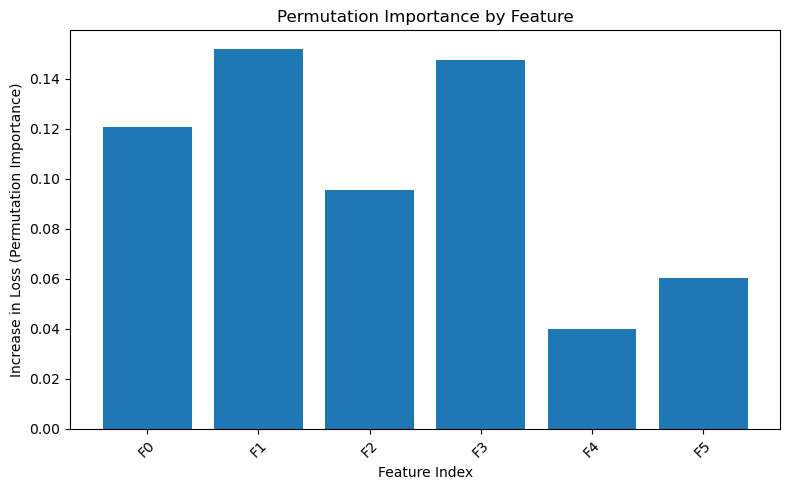

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()
